<a href="https://colab.research.google.com/github/kengmingcheng/Concrete_Strength_Prediction/blob/master/AdaNet/Adanet_tf2_compat_tf1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install adanet

     |████████████████████████████████| 122kB 4.7MB/s 
     |████████████████████████████████| 215kB 13.3MB/s 
     |████████████████████████████████| 163kB 13.1MB/s 
  Created wheel for rednose: filename=rednose-1.3.0-cp36-none-any.whl size=12156 sha256=4032d2ad31c723356f59ebc7fd26254476b91238cc05d8a04eb13ba40aabe74b
  Stored in directory: /root/.cache/pip/wheels/21/be/74/e74fbccdaf7ab983f847153b2708e4d1722801ce7265dfa643
  Created wheel for termstyle: filename=termstyle-0.1.11-cp36-none-any.whl size=4779 sha256=7862242b787b2d8a671ae85066765d0e6f69df8373022fe4313ed4379da39a28
  Stored in directory: /root/.cache/pip/wheels/93/0c/cf/1d134a42237c338ee1d733c81b92d95f6d04d9531bf4c2a9a1
Successfully built rednose termstyle
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 4.5.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.99

In [ ]:
%load_ext tensorboard

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
import os

import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import functools
import shutil

import adanet
import tensorflow.compat.v1 as tf
from tensorflow.keras.layers import Add

print(tf.__version__)
print(tf.keras.__version__)
print('Eager execution: %r' %tf.executing_eagerly())
tf.config.list_physical_devices('GPU')
# The random seed to use.
RANDOM_SEED = 42

test_date = datetime.now().strftime('%Y%m%d')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm



2.3.0
2.4.0
Eager execution: True


In [ ]:
# Code to read csv file into Colaboratory:
from google.colab import files, drive#, auth

Mount_DIR = r'/content/gdrive'
drive.mount(Mount_DIR)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
DATA_DIR = os.path.join(Mount_DIR, r'My Drive/UCLA/_Lab/ML_datasets')
LOG_DIR = os.path.join(Mount_DIR, r'My Drive/UCLA/_Lab/Log/AdaNet', test_date)
SAVE_DIR = os.path.join(Mount_DIR, r'My Drive/UCLA/_Lab/Results', test_date)
if not os.path.isdir(SAVE_DIR):
  !mkdir -p "{SAVE_DIR}"

In [ ]:
FILE_NAME = 'Concrete_US concrete_individul strength_strong&weak&individual outlier removed.csv' #@param {type:"string"}
# Concrete_merge (total fraction).csv  
# Concrete_US concrete_individul strength_strong&weak&individual outlier removed.csv
df_data = pd.read_csv(os.path.join(DATA_DIR, FILE_NAME), index_col = 0)
df_data.describe()

,W/C,W/CM,Fraction_cement,Fraction_coarse agg,Fraction_fine agg,Fraction_fly ash,Fraction_Slag,Entrainer,Accelerator,Retarder,Plasticizer,Viscosity,Load Size,Air Temp,Concrete Temp,Slump,7d Strength,28d Strength,28d Strength_1,28d Strength_2,28d Strength_3,Strength score,cov
count,8876.000000,8875.000000,8876.000000,8876.000000,8876.000000,8876.000000,8876.000000,8876.000000,8876.000000,8876.000000,8876.000000,8876.000000,8864.000000,8284.000000,8361.000000,8876.000000,3224.000000,8876.000000,8821.000000,7710.000000,6395.000000,8698.000000,8876.000000
mean,0.705326,0.394124,12.531752,40.491205,41.676077,2.978286,2.322680,0.020703,0.961438,0.629262,6.009911,0.422044,9.555223,61.471753,70.669107,6.103580,4501.724566,6488.254845,6486.565015,6404.465629,6398.431587,130.402981,0.020297
std,1.574189,0.090457,4.152901,11.946207,9.637921,2.159725,2.862153,0.154989,4.116885,1.401710,3.528158,1.230227,1.802188,9.042273,7.240603,16.335187,1662.925232,1694.479555,1706.966735,1611.845193,1522.204621,87.782582,0.018404
min,0.220000,0.200000,0.279018,0.000000,29.746508,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,31.000000,37.000000,0.000000,80.000000,87.000000,70.000000,100.000000,90.000000,83.750000,0.000000
25%,0.460000,0.340000,9.375000,42.550363,36.810406,2.178731,0.000000,0.000000,0.000000,0.000000,3.600000,0.000000,9.000000,55.000000,66.000000,4.500000,3340.000000,5487.000000,5470.000000,5490.000000,5490.000000,110.800000,0.007443
50%,0.550000,0.380000,12.263396,44.843049,39.023747,3.108108,0.000000,0.000000,0.000000,0.000000,5.050505,0.000000,10.000000,61.000000,71.000000,5.000000,4330.000000,6397.000000,6380.000000,6360.000000,6350.000000,123.250000,0.016608
75%,0.700000,0.430000,15.145119,45.830106,41.712347,3.939313,4.687077,0.000000,0.000000,0.000000,7.851100,0.000000,11.000000,67.000000,75.000000,6.500000,5490.000000,7340.000000,7350.000000,7250.000000,7250.000000,139.740000,0.028514
max,30.620000,1.000000,25.046268,54.408482,87.586662,17.412782,10.067959,3.939394,40.000000,13.000000,22.566285,10.000000,11.500000,103.000000,97.000000,1425.000000,12800.000000,14030.000000,14190.000000,14080.000000,13350.000000,5670.000000,0.367307


In [ ]:
# Data processing
process = True
if process:
    catag_columns = ['Cement Type']#, 'Admixture type', 'Coarse aggregate type', 'Fine aggregate type']
    df_data = pd.get_dummies(df_data, catag_columns)

    df_data.fillna(value = 0, inplace = True)

df_data.columns

Index(['W/C', 'W/CM', 'Fraction_cement', 'Fraction_coarse agg',
       'Fraction_fine agg', 'Fraction_fly ash', 'Fraction_Slag', 'Entrainer',
       'Accelerator', 'Retarder', 'Plasticizer', 'Viscosity', 'Load Size',
       'Air Temp', 'Concrete Temp', 'Slump', '7d Strength', '28d Strength',
       '28d Strength_1', '28d Strength_2', '28d Strength_3', 'Strength score',
       'cov', 'Cement Type_CSF', 'Cement Type_II/V', 'Cement Type_TYPE III',
       'Cement Type_TYPE V'],
      dtype='object')

In [ ]:
input_numericals=['W/CM', 'Fraction_cement', 'Fraction_coarse agg',
                # 'Fraction_water', 'Fraction_slag',
                'Viscosity', 'Fraction_Slag',
 	              'Fraction_fine agg', 'Fraction_fly ash', 
                'Entrainer', 'Accelerator', 'Retarder', 'Plasticizer', 'Load Size', 'Air Temp', 'Concrete Temp', 
                # 'Air entraining agent', 'Water reducing admixture',
                ]

input_categoricals=['Cement Type_CSF', 'Cement Type_II/V', 'Cement Type_TYPE III', 'Cement Type_TYPE V']

input_features = input_numericals + input_categoricals

x_data = df_data[input_features].to_numpy(dtype=np.float32)
y_data = df_data[["28d Strength"]].to_numpy(dtype=np.float32)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [ ]:
FEATURES_KEY = "x"

# Initiate scaler
input_scaler = StandardScaler()
target_scaler = StandardScaler()
# fit scaler   # Only fit numerical data
input_scaler.fit(x_data[:,:len(input_numericals)])
target_scaler.fit(y_data)

def input_fn(partition, training, batch_size):
  """Generate an input function for the Estimator."""
  def _input_fn():

    if partition == "train":
      dataset = tf.data.Dataset.from_tensor_slices(({
          FEATURES_KEY: np.concatenate(
              # Only transform numerical data then concatenate both numericals and categoricals
              (input_scaler.transform(x_train[:,:len(input_numericals)]), 
               x_train[:,len(input_numericals):]), 
              axis=1)
      }, target_scaler.transform(y_train)))
    else:
      dataset = tf.data.Dataset.from_tensor_slices(({
          FEATURES_KEY: np.concatenate(
              (input_scaler.transform(x_test[:,:len(input_numericals)]), 
               x_test[:,len(input_numericals):]), 
              axis=1)
      }, target_scaler.transform(y_test)))

    # We call repeat after shuffling, rather than before, to prevent separate
    # epochs from blending together.
    if training:
      dataset = dataset.shuffle(10 * batch_size, seed=RANDOM_SEED).repeat()

    dataset = dataset.batch(batch_size)
    iterator = dataset.make_one_shot_iterator()
    features, labels = iterator.get_next()
    return features, labels

  return _input_fn

# Modules

In [ ]:
def inverse_transform_data(y_test, validation_predict, y_train, train_predict):
    # scaler inverse transform (psi to MPa)
    training_predictions = np.array([item['predictions'][0] for item in train_predict])
    # train_predict_inverse = tf.expm1(training_predictions) *0.00689476
    train_predict_inverse = target_scaler.inverse_transform(training_predictions) *0.00689476
    
    validation_predictions = np.array([item['predictions'][0] for item in validation_predict])
    # validation_predict_inverse = tf.expm1(validation_predictions) *0.00689476
    validation_predict_inverse = target_scaler.inverse_transform(validation_predictions) *0.00689476

    y_train_inverse = y_train*0.00689476
    y_test_inverse = y_test*0.00689476

    return y_test_inverse, validation_predict_inverse, y_train_inverse, train_predict_inverse

def measure_v_predict(train_target_inverse, 
                      train_predict_inverse, 
                      cv_target_inverse, 
                      validation_predict_inverse, 
                      title='test', 
                      save=True, 
                      save_path=''):
    plt.plot(train_target_inverse, train_predict_inverse, marker='o', linestyle='None')
    plt.plot(cv_target_inverse, validation_predict_inverse, marker='x', linestyle='None')
    plt.plot([0,100],[0,100],'k')
    plt.xlabel('measured value')
    plt.ylabel('predicted value')
    _= plt.legend(['Train','Validation'], loc='upper left')
    if save:
      plt.savefig(os.path.join(save_path, title+'.png'), format='png')
    plt.show()

def report(y_train_inverse, 
           train_predict_inverse, 
           y_test_inverse, 
           validation_predict_inverse, 
           save=True):  
    # Validation
    r2_v = r2_score(y_test_inverse, validation_predict_inverse)
    mse_v = mean_squared_error(y_test_inverse, validation_predict_inverse)
    rmse_v = math.sqrt(mse_v)
    # Training
    r2_t = r2_score(y_train_inverse, train_predict_inverse)
    mse_t = mean_squared_error(y_train_inverse, train_predict_inverse)
    rmse_t = math.sqrt(mse_t)

    text_file_name = 'AdaNet-' + test_date + '.txt'
    record =["Test: {}".format(test_name),
            "Recording time: {}".format(datetime.now()),
            "Duriation: {}".format(end_time-start_time),
            "Layer Size: {}".format(LAYER_SIZE),
            "-------------------------",
            "Learning Rate: {}".format(LEARNING_RATE),
            "Train Steps: {}".format(ITERATION_TRAIN_STEPS),
            "Batch Size: {}".format(BATCH_SIZE),
            "Dropout Ratio: {}".format(DROPOUT_RATIO),
            "Lambda: {}".format(ADANET_LAMBDA),
            "Beta: {}".format(ADANET_BETA),
            "Start #: {}".format(START_NUMBER),
            "Iterations: {}".format(ADANET_ITERATIONS),
            "-------------------------",
            "Architecture: {}".format(ensemble_architecture(results)),
            "-------------------------",
            "cv_r2: {}".format(r2_v),
            "cv_mse: {}".format(mse_v),
            "cv_rmse: {}".format(rmse_v),
            "-------------------------",
            "train_r2: {}".format(r2_t),
            "train_mse: {}".format(mse_t),
            "train_rmse: {}".format(rmse_t),
            ]
    if save:
      with open(os.path.join(SAVE_DIR,text_file_name), "a+") as file:
        for line in record:
          file.write(line + "\n")
          print(line)
        file.write("\n")
    else:
      for line in record:
        print(line)
    print('\n')

# Model

In [ ]:
_NUM_LAYERS_KEY = "num_layers"


class _SimpleDNNBuilder(adanet.subnetwork.Builder):
  """Builds a DNN subnetwork for AdaNet."""

  def __init__(self, 
               optimizer, 
               layer_size, 
               num_layers, 
               dropout_ratio, 
               learn_mixture_weights,
               seed):
    """Initializes a `_DNNBuilder`.

    Args:
      optimizer: An `Optimizer` instance for training both the subnetwork and
        the mixture weights.
      layer_size: The number of nodes to output at each hidden layer.
      num_layers: The number of hidden layers.
      learn_mixture_weights: Whether to solve a learning problem to find the
        best mixture weights, or use their default value according to the
        mixture weight type. When `False`, the subnetworks will return a no_op
        for the mixture weight train op.
      seed: A random seed.

    Returns:
      An instance of `_SimpleDNNBuilder`.
    """

    self._optimizer = optimizer
    self._layer_size = layer_size
    self._num_layers = num_layers
    self._dropout_ratio = dropout_ratio
    self._learn_mixture_weights = learn_mixture_weights
    self._seed = seed

  def build_subnetwork(self,
                       features,
                       logits_dimension,
                       training,
                       iteration_step,
                       summary,
                       previous_ensemble=None):
    """See `adanet.subnetwork.Builder`."""

    input_layer = tf.to_float(features[FEATURES_KEY])
    kernel_initializer = tf.glorot_uniform_initializer(seed=self._seed)
    x = input_layer
    for _ in range(self._num_layers):
      x = tf.layers.Dense(
          units=self._layer_size,
          activation=tf.nn.relu,
          kernel_initializer=kernel_initializer)(x)
      x = tf.layers.Dropout(self._dropout_ratio)(x)
      x = tf.layers.BatchNormalization()(x)

    logits = tf.layers.Dense(
        units=logits_dimension,
        activation="linear",
        kernel_initializer=kernel_initializer)(x)

    shared = {_NUM_LAYERS_KEY: self._num_layers}
    return adanet.Subnetwork(
        last_layer= x,
        logits=logits,
        complexity=self._measure_complexity(),
        shared=shared)

  def _measure_complexity(self):
    """Approximates Rademacher complexity as the square-root of the depth."""
    return tf.sqrt(tf.to_float(self._num_layers))

  def build_subnetwork_train_op(self, subnetwork, loss, var_list, labels,
                                iteration_step, summary, previous_ensemble):
    """See `adanet.subnetwork.Builder`."""
    return self._optimizer.minimize(loss=loss, var_list=var_list)

  @property
  def name(self):
    """See `adanet.subnetwork.Builder`."""

    if self._num_layers == 0:
      # A DNN with no hidden layers is a linear model.
      return "linear"
    return "{}_layer_dnn".format(self._num_layers)

class _ResnetBuilder(adanet.subnetwork.Builder):
  def __init__(self, optimizer, layer_size, num_layers, learn_mixture_weights,
               seed):
    """Initializes a `_DNNBuilder`.

    Args:
      optimizer: An `Optimizer` instance for training both the subnetwork and
        the mixture weights.
      layer_size: The number of nodes to output at each hidden layer.
      num_layers: The number of hidden layers.
      learn_mixture_weights: Whether to solve a learning problem to find the
        best mixture weights, or use their default value according to the
        mixture weight type. When `False`, the subnetworks will return a no_op
        for the mixture weight train op.
      seed: A random seed.

    Returns:
      An instance of `_SimpleDNNBuilder`.
    """

    self._optimizer = optimizer
    self._layer_size = layer_size
    self._num_layers = num_layers
    self._learn_mixture_weights = learn_mixture_weights
    self._seed = seed

  def build_subnetwork(self,
                       features,
                       logits_dimension,
                       training,
                       iteration_step,
                       summary,
                       previous_ensemble=None):
    input_layer = tf.to_float(features[FEATURES_KEY])
    kernel_initializer = tf.glorot_uniform_initializer(seed=self._seed)  # wait to modify
    x = input_layer
    x = tf.layers.Dense(
          units=self._layer_size,
          activation=tf.nn.relu,
          kernel_initializer=kernel_initializer)(x)
    x = tf.layers.BatchNormalization()(x)
    for _ in range((self._num_layers-2) // 2):
      x = self.resnet_block(x, kernel_initializer)

    x = tf.layers.Dense(
          units=self._layer_size,
          activation=tf.nn.relu,
          kernel_initializer=kernel_initializer)(x)
    x = tf.layers.BatchNormalization()(x)

    logits = tf.layers.Dense(
        units=logits_dimension,
        activation="linear",
        kernel_initializer=kernel_initializer)(x)
    
    shared = {_NUM_LAYERS_KEY: self._num_layers}

    return adanet.Subnetwork(
        last_layer=x,
        logits=logits,
        complexity=self._measure_complexity(),
        shared=shared
    )
  
  def resnet_block(self,
                   input_data,
                   kernel_initializer):
      x = tf.layers.Dense(
          units=self._layer_size,
          activation=tf.nn.relu,
          kernel_initializer=kernel_initializer)(input_data)
      x = tf.layers.BatchNormalization()(x)
      x = tf.layers.Dense(
          units=self._layer_size,
          activation=tf.nn.relu,
          kernel_initializer=kernel_initializer)(x)
      x = tf.layers.BatchNormalization()(x)

      x = Add()([x, input_data])
      x = tf.keras.activations.relu(x)

      return x

  def _measure_complexity(self):
    """Approximates Rademacher complexity as the square-root of the depth."""
    return tf.sqrt(tf.to_float(self._num_layers))

  def build_subnetwork_train_op(self, subnetwork, loss, var_list, labels,
                                iteration_step, summary, previous_ensemble):
    """See `adanet.subnetwork.Builder`."""
    return self._optimizer.minimize(loss=loss, var_list=var_list)

  @property
  def name(self):
    """See `adanet.subnetwork.Builder`."""

    if self._num_layers == 0:
      # A DNN with no hidden layers is a linear model.
      return "linear"
    return "{}_layer_ResNet".format(self._num_layers)


class SimpleDNNGenerator(adanet.subnetwork.Generator):
  """Generates a two DNN subnetworks at each iteration.

  The first DNN has an identical shape to the most recently added subnetwork
  in `previous_ensemble`. The second has the same shape plus one more dense
  layer on top. This is similar to the adaptive network presented in Figure 2 of
  [Cortes et al. ICML 2017](https://arxiv.org/abs/1607.01097), without the
  connections to hidden layers of networks from previous iterations.
  """

  def __init__(self,
               optimizer,
               num_of_layers=0,
               layer_size=64, # default = 64
               dropout_ratio=0.5, 
               learn_mixture_weights=False,
               seed=None):
    """Initializes a DNN `Generator`.

    Args:
      optimizer: An `Optimizer` instance for training both the subnetwork and
        the mixture weights.
      layer_size: Number of nodes in each hidden layer of the subnetwork
        candidates. Note that this parameter is ignored in a DNN with no hidden
        layers.
      learn_mixture_weights: Whether to solve a learning problem to find the
        best mixture weights, or use their default value according to the
        mixture weight type. When `False`, the subnetworks will return a no_op
        for the mixture weight train op.
      seed: A random seed.

    Returns:
      An instance of `Generator`.
    """

    self._seed = seed
    self._num_of_layers = num_of_layers
    self._dnn_builder_fn = functools.partial(
        _SimpleDNNBuilder,
        optimizer=optimizer,
        layer_size=layer_size,
        dropout_ratio=dropout_ratio,
        learn_mixture_weights=learn_mixture_weights)
    self._resnet_builder_fn = functools.partial(
        _ResnetBuilder,
        optimizer=optimizer,
        layer_size=layer_size,
        learn_mixture_weights=learn_mixture_weights)

  def generate_candidates(self, previous_ensemble, iteration_number,
                          previous_ensemble_reports, all_reports):
    """See `adanet.subnetwork.Generator`."""

    num_layers = self._num_of_layers
    seed = self._seed
    if previous_ensemble:
      num_layers = previous_ensemble.subnetworks[-1].shared[_NUM_LAYERS_KEY]
    if seed is not None:
      seed += iteration_number
    return [
        self._dnn_builder_fn(num_layers=num_layers, seed=seed),
        self._dnn_builder_fn(num_layers=num_layers + 1, seed=seed),
        # self._dnn_builder_fn(num_layers=num_layers + 2, seed=seed),
        # self._resnet_builder_fn (num_layers=num_layers, seed=seed),
        # self._resnet_builder_fn (num_layers=num_layers + 2, seed=seed)
    ]

In [ ]:
#@title AdaNet parameters
LEARNING_RATE = 0.001  #@param {type:"number"}
TRAIN_STEPS = 60000  #@param {type:"integer"}
ITERATION_TRAIN_STEPS =  3000#@param {type:"integer"}
BATCH_SIZE =   128#@param {type:"integer"}
LAYER_SIZE = 64#@param {type:"integer"}
DROPOUT_RATIO = 0.6 #@param {type:"number"}


LEARN_MIXTURE_WEIGHTS = True  #@param {type:"boolean"}
ADANET_LAMBDA =   0.01#@param {type:"number"}
ADANET_BETA =  0.02#@param {type:"number"}
ADANET_ITERATIONS =   10#@param {type:"integer"}
START_NUMBER =  1#@param {type:"integer"}

END_TRAINING = True#@param {type:"boolean"}

class train_and_evaluate:
  def __init__(self, 
               experiment_name, 
               learn_mixture_weights=LEARN_MIXTURE_WEIGHTS,
               train_iteration_steps=ITERATION_TRAIN_STEPS, # or TRAIN_STEPS // ADANET_ITERATIONS
               learning_rate=LEARNING_RATE,
               batch_size=BATCH_SIZE,
               layer_size=LAYER_SIZE,
               dropout_ratio=DROPOUT_RATIO,
               adanet_lambda=ADANET_LAMBDA,
               adanet_beta=ADANET_BETA):

    model_dir = os.path.join(LOG_DIR, experiment_name)

    ensembler_optimizer = None
    if learn_mixture_weights:
      # ensembler_optimizer = tf.train.AdamOptimizer(
      #     learning_rate=learning_rate)
      
      ensembler_optimizer = tf.train.RMSPropOptimizer(
          learning_rate=learning_rate, decay=0.9, momentum=0.0, epsilon=1e-10, use_locking=False,
          centered=False, name='RMSProp')

    self.estimator = adanet.Estimator(
        # Since we are predicting housing prices, we'll use a regression
        # head that optimizes for MSE.
        head=tf.estimator.RegressionHead(),

        # Define the generator, which defines our search space of subnetworks
        # to train as candidates to add to the final AdaNet model.
        subnetwork_generator=SimpleDNNGenerator(
            optimizer=tf.train.RMSPropOptimizer(learning_rate=learning_rate),
            num_of_layers = START_NUMBER,
            layer_size = LAYER_SIZE,
            dropout_ratio = dropout_ratio,
            learn_mixture_weights=learn_mixture_weights,
            seed=RANDOM_SEED),

        # The number of train steps per iteration.
        max_iteration_steps=train_iteration_steps,

        # The evaluator will evaluate the model on the full training set to
        # compute the overall AdaNet loss (train loss + complexity
        # regularization) to select the best candidate to include in the
        # final AdaNet model.
        evaluator=adanet.Evaluator(
            input_fn=input_fn("train", training=False, batch_size=BATCH_SIZE)),

        ensemblers=[
            adanet.ensemble.ComplexityRegularizedEnsembler(
                optimizer=ensembler_optimizer,
                mixture_weight_type='scalar',
                # Lambda is a the strength of complexity regularization. A larger
                # value will penalize more complex subnetworks.
                adanet_lambda=adanet_lambda,
                adanet_beta=adanet_beta),
        ],      
        # Configuration for Estimators.
        config=tf.estimator.RunConfig(
            model_dir=model_dir, 
            tf_random_seed=RANDOM_SEED, 
            save_summary_steps=100,
            save_checkpoints_steps=train_iteration_steps, 
            # save_checkpoints_secs=_USE_DEFAULT,
            session_config=None, 
            keep_checkpoint_max=None, 
            keep_checkpoint_every_n_hours=10000,
            log_step_count_steps=100, 
            train_distribute=None, 
            device_fn=None, 
            protocol=None,
            eval_distribute=None, 
            experimental_distribute=None,
            experimental_max_worker_delay_secs=None, 
            session_creation_timeout_secs=7200
            ),
          export_subnetwork_logits = True,
      )

    # Train and evaluate using using the tf.estimator tooling.
    train_spec = tf.estimator.TrainSpec(
        input_fn=input_fn("train", training=True, batch_size=BATCH_SIZE),
        max_steps=train_iteration_steps*ADANET_ITERATIONS)
    eval_spec = tf.estimator.EvalSpec(
        input_fn=input_fn("test", training=False, batch_size=BATCH_SIZE),
        steps=None,
        start_delay_secs=1,
        throttle_secs=30,
    )

    tf.estimator.train_and_evaluate(self.estimator, train_spec, eval_spec)

  # estimator.train(
  #     input_fn("train", training=True, batch_size=BATCH_SIZE),
  #     hooks=None,
  #     steps=None, #train_iteration_steps,
  #     max_steps=train_iteration_steps*ADANET_ITERATIONS,
  #     saving_listeners=None)

    print("End of TRAINING")

  def get_results(self):
    results = self.estimator.evaluate(
        input_fn("test", training=False, batch_size=BATCH_SIZE),
        steps=None)
    
    train_predict = self.estimator.predict(
        input_fn("train", training=False, batch_size=BATCH_SIZE),
        predict_keys=None, hooks=None, 
        checkpoint_path=None,
        yield_single_examples=True)

    validation_predict = self.estimator.predict(
        input_fn("test", training=False, batch_size=BATCH_SIZE),
        predict_keys=None, hooks=None, 
        checkpoint_path=None,
        yield_single_examples=True)
    
    return results,train_predict,validation_predict
  
  def get_detail_of_iterations(self):
    for i in range(ADANET_ITERATIONS):
      _step = (i+1) * ITERATION_TRAIN_STEPS

      t_prediction = self.estimator.predict(
          input_fn("train", training=False, batch_size=BATCH_SIZE),
          predict_keys=None, hooks=None, 
          checkpoint_path=model_dir+'/model.ckpt-'+str(_step),
          yield_single_examples=True)
      tr_prediction = np.array([item['predictions'][0] for item in t_prediction])
      train_prediction = target_scaler.inverse_transform(tr_prediction) *0.00689476

      v_prediction = self.estimator.predict(
      input_fn("test", training=False, batch_size=BATCH_SIZE),
      predict_keys=None, hooks=None, 
      checkpoint_path=model_dir+'/model.ckpt-'+str(_step),
      yield_single_examples=True)
      va_prediction = np.array([item['predictions'][0] for item in v_prediction])
      test_prediction = target_scaler.inverse_transform(va_prediction) *0.00689476

      measure_v_predict(y_train_inverse, 
                        train_prediction, 
                        y_test_inverse, 
                        test_prediction, 
                        title = test_name, 
                        save_path=SAVE_DIR,
                        save=False)
      report(y_train_inverse, 
            train_prediction, 
            y_test_inverse, 
            test_prediction, 
            save=False)


def ensemble_architecture(result):
  """Extracts the ensemble architecture from evaluation results."""

  architecture = result["architecture/adanet/ensembles"]
  # The architecture is a serialized Summary proto for TensorBoard.
  summary_proto = tf.summary.Summary.FromString(architecture)
  return summary_proto.value[0].tensor.string_val[0]


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation loca

INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.


Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:loss = 1.443887, step = 0


INFO:tensorflow:loss = 1.443887, step = 0


INFO:tensorflow:global_step/sec: 93.8491


INFO:tensorflow:global_step/sec: 93.8491


INFO:tensorflow:loss = 0.22566345, step = 100 (1.069 sec)


INFO:tensorflow:loss = 0.22566345, step = 100 (1.069 sec)


INFO:tensorflow:global_step/sec: 189.524


INFO:tensorflow:global_step/sec: 189.524


INFO:tensorflow:loss = 0.19754633, step = 200 (0.527 sec)


INFO:tensorflow:loss = 0.19754633, step = 200 (0.527 sec)


INFO:tensorflow:global_step/sec: 200.461


INFO:tensorflow:global_step/sec: 200.461


INFO:tensorflow:loss = 0.2569955, step = 300 (0.498 sec)


INFO:tensorflow:loss = 0.2569955, step = 300 (0.498 sec)


INFO:tensorflow:global_step/sec: 178.654


INFO:tensorflow:global_step/sec: 178.654


INFO:tensorflow:loss = 0.2286595, step = 400 (0.561 sec)


INFO:tensorflow:loss = 0.2286595, step = 400 (0.561 sec)


INFO:tensorflow:global_step/sec: 199.684


INFO:tensorflow:global_step/sec: 199.684


INFO:tensorflow:loss = 0.15861484, step = 500 (0.502 sec)


INFO:tensorflow:loss = 0.15861484, step = 500 (0.502 sec)


INFO:tensorflow:global_step/sec: 192.482


INFO:tensorflow:global_step/sec: 192.482


INFO:tensorflow:loss = 0.21081841, step = 600 (0.520 sec)


INFO:tensorflow:loss = 0.21081841, step = 600 (0.520 sec)


INFO:tensorflow:global_step/sec: 186.734


INFO:tensorflow:global_step/sec: 186.734


INFO:tensorflow:loss = 0.21906927, step = 700 (0.535 sec)


INFO:tensorflow:loss = 0.21906927, step = 700 (0.535 sec)


INFO:tensorflow:global_step/sec: 195.495


INFO:tensorflow:global_step/sec: 195.495


INFO:tensorflow:loss = 0.19548663, step = 800 (0.513 sec)


INFO:tensorflow:loss = 0.19548663, step = 800 (0.513 sec)


INFO:tensorflow:global_step/sec: 198.608


INFO:tensorflow:global_step/sec: 198.608


INFO:tensorflow:loss = 0.17917721, step = 900 (0.503 sec)


INFO:tensorflow:loss = 0.17917721, step = 900 (0.503 sec)


INFO:tensorflow:global_step/sec: 193.361


INFO:tensorflow:global_step/sec: 193.361


INFO:tensorflow:loss = 0.13196182, step = 1000 (0.515 sec)


INFO:tensorflow:loss = 0.13196182, step = 1000 (0.515 sec)


INFO:tensorflow:global_step/sec: 198.392


INFO:tensorflow:global_step/sec: 198.392


INFO:tensorflow:loss = 0.18021666, step = 1100 (0.506 sec)


INFO:tensorflow:loss = 0.18021666, step = 1100 (0.506 sec)


INFO:tensorflow:global_step/sec: 188.391


INFO:tensorflow:global_step/sec: 188.391


INFO:tensorflow:loss = 0.19683647, step = 1200 (0.532 sec)


INFO:tensorflow:loss = 0.19683647, step = 1200 (0.532 sec)


INFO:tensorflow:global_step/sec: 193.051


INFO:tensorflow:global_step/sec: 193.051


INFO:tensorflow:loss = 0.1539569, step = 1300 (0.521 sec)


INFO:tensorflow:loss = 0.1539569, step = 1300 (0.521 sec)


INFO:tensorflow:global_step/sec: 191.604


INFO:tensorflow:global_step/sec: 191.604


INFO:tensorflow:loss = 0.1424464, step = 1400 (0.519 sec)


INFO:tensorflow:loss = 0.1424464, step = 1400 (0.519 sec)


INFO:tensorflow:global_step/sec: 197.717


INFO:tensorflow:global_step/sec: 197.717


INFO:tensorflow:loss = 0.144881, step = 1500 (0.506 sec)


INFO:tensorflow:loss = 0.144881, step = 1500 (0.506 sec)


INFO:tensorflow:global_step/sec: 193.245


INFO:tensorflow:global_step/sec: 193.245


INFO:tensorflow:loss = 0.1952572, step = 1600 (0.519 sec)


INFO:tensorflow:loss = 0.1952572, step = 1600 (0.519 sec)


INFO:tensorflow:global_step/sec: 181.803


INFO:tensorflow:global_step/sec: 181.803


INFO:tensorflow:loss = 0.1962405, step = 1700 (0.546 sec)


INFO:tensorflow:loss = 0.1962405, step = 1700 (0.546 sec)


INFO:tensorflow:global_step/sec: 194.353


INFO:tensorflow:global_step/sec: 194.353


INFO:tensorflow:loss = 0.15550847, step = 1800 (0.517 sec)


INFO:tensorflow:loss = 0.15550847, step = 1800 (0.517 sec)


INFO:tensorflow:global_step/sec: 198.165


INFO:tensorflow:global_step/sec: 198.165


INFO:tensorflow:loss = 0.1220793, step = 1900 (0.500 sec)


INFO:tensorflow:loss = 0.1220793, step = 1900 (0.500 sec)


INFO:tensorflow:global_step/sec: 199.641


INFO:tensorflow:global_step/sec: 199.641


INFO:tensorflow:loss = 0.11215836, step = 2000 (0.504 sec)


INFO:tensorflow:loss = 0.11215836, step = 2000 (0.504 sec)


INFO:tensorflow:global_step/sec: 196.419


INFO:tensorflow:global_step/sec: 196.419


INFO:tensorflow:loss = 0.18566811, step = 2100 (0.509 sec)


INFO:tensorflow:loss = 0.18566811, step = 2100 (0.509 sec)


INFO:tensorflow:global_step/sec: 202.18


INFO:tensorflow:global_step/sec: 202.18


INFO:tensorflow:loss = 0.18914858, step = 2200 (0.495 sec)


INFO:tensorflow:loss = 0.18914858, step = 2200 (0.495 sec)


INFO:tensorflow:global_step/sec: 192.981


INFO:tensorflow:global_step/sec: 192.981


INFO:tensorflow:loss = 0.20269059, step = 2300 (0.516 sec)


INFO:tensorflow:loss = 0.20269059, step = 2300 (0.516 sec)


INFO:tensorflow:global_step/sec: 191.181


INFO:tensorflow:global_step/sec: 191.181


INFO:tensorflow:loss = 0.12057355, step = 2400 (0.523 sec)


INFO:tensorflow:loss = 0.12057355, step = 2400 (0.523 sec)


INFO:tensorflow:global_step/sec: 195.971


INFO:tensorflow:global_step/sec: 195.971


INFO:tensorflow:loss = 0.16976877, step = 2500 (0.515 sec)


INFO:tensorflow:loss = 0.16976877, step = 2500 (0.515 sec)


INFO:tensorflow:global_step/sec: 194.575


INFO:tensorflow:global_step/sec: 194.575


INFO:tensorflow:loss = 0.16862194, step = 2600 (0.512 sec)


INFO:tensorflow:loss = 0.16862194, step = 2600 (0.512 sec)


INFO:tensorflow:global_step/sec: 188.955


INFO:tensorflow:global_step/sec: 188.955


INFO:tensorflow:loss = 0.14265966, step = 2700 (0.528 sec)


INFO:tensorflow:loss = 0.14265966, step = 2700 (0.528 sec)


INFO:tensorflow:global_step/sec: 196.955


INFO:tensorflow:global_step/sec: 196.955


INFO:tensorflow:loss = 0.13574311, step = 2800 (0.508 sec)


INFO:tensorflow:loss = 0.13574311, step = 2800 (0.508 sec)


INFO:tensorflow:global_step/sec: 194.49


INFO:tensorflow:global_step/sec: 194.49


INFO:tensorflow:loss = 0.1479205, step = 2900 (0.513 sec)


INFO:tensorflow:loss = 0.1479205, step = 2900 (0.513 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3000...


INFO:tensorflow:Saving checkpoints for 3000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:model.ckpt-3000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-3000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-3000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-3000


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T01:22:41Z


INFO:tensorflow:Starting evaluation at 2020-08-29T01:22:41Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-3000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-3000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 1.13564s


INFO:tensorflow:Inference Time : 1.13564s


INFO:tensorflow:Finished evaluation at 2020-08-29-01:22:43


INFO:tensorflow:Finished evaluation at 2020-08-29-01:22:43


INFO:tensorflow:Saving dict for global step 3000: average_loss = 0.2088585, best_ensemble_index_0 = 1, global_step = 3000, iteration = 0, label/mean = -0.0007050394, loss = 0.20929432, prediction/mean = -0.05629672


INFO:tensorflow:Saving dict for global step 3000: average_loss = 0.2088585, best_ensemble_index_0 = 1, global_step = 3000, iteration = 0, label/mean = -0.0007050394, loss = 0.20929432, prediction/mean = -0.05629672


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-3000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-3000


INFO:tensorflow:Loss for final step: 0.12590353.


INFO:tensorflow:Loss for final step: 0.12590353.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-3000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-3000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664164637', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664164637', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


Instructions for updating:
Use standard file utilities to get mtimes.


Instructions for updating:
Use standard file utilities to get mtimes.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664164637/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664164637/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-3000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-3000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3001...


INFO:tensorflow:Saving checkpoints for 3001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664164637/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664164637/model.ckpt.


INFO:tensorflow:model.ckpt-3001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-3001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3001...


INFO:tensorflow:loss = 0.12744826, step = 3001


INFO:tensorflow:loss = 0.12744826, step = 3001


INFO:tensorflow:Loss for final step: 0.12744826.


INFO:tensorflow:Loss for final step: 0.12744826.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-1


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-1


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3000...


INFO:tensorflow:Saving checkpoints for 3000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:model.ckpt-3000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-3000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3000...


INFO:tensorflow:loss = 0.12744826, step = 3000


INFO:tensorflow:loss = 0.12744826, step = 3000


INFO:tensorflow:global_step/sec: 68.4585


INFO:tensorflow:global_step/sec: 68.4585


INFO:tensorflow:loss = 0.11402623, step = 3100 (1.464 sec)


INFO:tensorflow:loss = 0.11402623, step = 3100 (1.464 sec)


INFO:tensorflow:global_step/sec: 154.664


INFO:tensorflow:global_step/sec: 154.664


INFO:tensorflow:loss = 0.14769031, step = 3200 (0.650 sec)


INFO:tensorflow:loss = 0.14769031, step = 3200 (0.650 sec)


INFO:tensorflow:global_step/sec: 147.308


INFO:tensorflow:global_step/sec: 147.308


INFO:tensorflow:loss = 0.16867241, step = 3300 (0.678 sec)


INFO:tensorflow:loss = 0.16867241, step = 3300 (0.678 sec)


INFO:tensorflow:global_step/sec: 158.925


INFO:tensorflow:global_step/sec: 158.925


INFO:tensorflow:loss = 0.15456346, step = 3400 (0.628 sec)


INFO:tensorflow:loss = 0.15456346, step = 3400 (0.628 sec)


INFO:tensorflow:global_step/sec: 152.518


INFO:tensorflow:global_step/sec: 152.518


INFO:tensorflow:loss = 0.111760415, step = 3500 (0.656 sec)


INFO:tensorflow:loss = 0.111760415, step = 3500 (0.656 sec)


INFO:tensorflow:global_step/sec: 153.225


INFO:tensorflow:global_step/sec: 153.225


INFO:tensorflow:loss = 0.14792478, step = 3600 (0.651 sec)


INFO:tensorflow:loss = 0.14792478, step = 3600 (0.651 sec)


INFO:tensorflow:global_step/sec: 159.677


INFO:tensorflow:global_step/sec: 159.677


INFO:tensorflow:loss = 0.16103812, step = 3700 (0.627 sec)


INFO:tensorflow:loss = 0.16103812, step = 3700 (0.627 sec)


INFO:tensorflow:global_step/sec: 155.697


INFO:tensorflow:global_step/sec: 155.697


INFO:tensorflow:loss = 0.16363749, step = 3800 (0.644 sec)


INFO:tensorflow:loss = 0.16363749, step = 3800 (0.644 sec)


INFO:tensorflow:global_step/sec: 153.772


INFO:tensorflow:global_step/sec: 153.772


INFO:tensorflow:loss = 0.13474214, step = 3900 (0.651 sec)


INFO:tensorflow:loss = 0.13474214, step = 3900 (0.651 sec)


INFO:tensorflow:global_step/sec: 156.412


INFO:tensorflow:global_step/sec: 156.412


INFO:tensorflow:loss = 0.11556461, step = 4000 (0.635 sec)


INFO:tensorflow:loss = 0.11556461, step = 4000 (0.635 sec)


INFO:tensorflow:global_step/sec: 151.608


INFO:tensorflow:global_step/sec: 151.608


INFO:tensorflow:loss = 0.13250634, step = 4100 (0.661 sec)


INFO:tensorflow:loss = 0.13250634, step = 4100 (0.661 sec)


INFO:tensorflow:global_step/sec: 155.161


INFO:tensorflow:global_step/sec: 155.161


INFO:tensorflow:loss = 0.13523605, step = 4200 (0.643 sec)


INFO:tensorflow:loss = 0.13523605, step = 4200 (0.643 sec)


INFO:tensorflow:global_step/sec: 154.314


INFO:tensorflow:global_step/sec: 154.314


INFO:tensorflow:loss = 0.14063804, step = 4300 (0.651 sec)


INFO:tensorflow:loss = 0.14063804, step = 4300 (0.651 sec)


INFO:tensorflow:global_step/sec: 157.855


INFO:tensorflow:global_step/sec: 157.855


INFO:tensorflow:loss = 0.123110466, step = 4400 (0.632 sec)


INFO:tensorflow:loss = 0.123110466, step = 4400 (0.632 sec)


INFO:tensorflow:global_step/sec: 157.411


INFO:tensorflow:global_step/sec: 157.411


INFO:tensorflow:loss = 0.10856944, step = 4500 (0.638 sec)


INFO:tensorflow:loss = 0.10856944, step = 4500 (0.638 sec)


INFO:tensorflow:global_step/sec: 155.957


INFO:tensorflow:global_step/sec: 155.957


INFO:tensorflow:loss = 0.15606123, step = 4600 (0.640 sec)


INFO:tensorflow:loss = 0.15606123, step = 4600 (0.640 sec)


INFO:tensorflow:global_step/sec: 152.707


INFO:tensorflow:global_step/sec: 152.707


INFO:tensorflow:loss = 0.17103046, step = 4700 (0.654 sec)


INFO:tensorflow:loss = 0.17103046, step = 4700 (0.654 sec)


INFO:tensorflow:global_step/sec: 157.179


INFO:tensorflow:global_step/sec: 157.179


INFO:tensorflow:loss = 0.13582224, step = 4800 (0.639 sec)


INFO:tensorflow:loss = 0.13582224, step = 4800 (0.639 sec)


INFO:tensorflow:global_step/sec: 155.415


INFO:tensorflow:global_step/sec: 155.415


INFO:tensorflow:loss = 0.12333297, step = 4900 (0.641 sec)


INFO:tensorflow:loss = 0.12333297, step = 4900 (0.641 sec)


INFO:tensorflow:global_step/sec: 160.418


INFO:tensorflow:global_step/sec: 160.418


INFO:tensorflow:loss = 0.091963634, step = 5000 (0.625 sec)


INFO:tensorflow:loss = 0.091963634, step = 5000 (0.625 sec)


INFO:tensorflow:global_step/sec: 153.61


INFO:tensorflow:global_step/sec: 153.61


INFO:tensorflow:loss = 0.14505142, step = 5100 (0.651 sec)


INFO:tensorflow:loss = 0.14505142, step = 5100 (0.651 sec)


INFO:tensorflow:global_step/sec: 154.926


INFO:tensorflow:global_step/sec: 154.926


INFO:tensorflow:loss = 0.16488382, step = 5200 (0.644 sec)


INFO:tensorflow:loss = 0.16488382, step = 5200 (0.644 sec)


INFO:tensorflow:global_step/sec: 158.181


INFO:tensorflow:global_step/sec: 158.181


INFO:tensorflow:loss = 0.18135911, step = 5300 (0.633 sec)


INFO:tensorflow:loss = 0.18135911, step = 5300 (0.633 sec)


INFO:tensorflow:global_step/sec: 156.034


INFO:tensorflow:global_step/sec: 156.034


INFO:tensorflow:loss = 0.12931773, step = 5400 (0.640 sec)


INFO:tensorflow:loss = 0.12931773, step = 5400 (0.640 sec)


INFO:tensorflow:global_step/sec: 153.739


INFO:tensorflow:global_step/sec: 153.739


INFO:tensorflow:loss = 0.12755015, step = 5500 (0.652 sec)


INFO:tensorflow:loss = 0.12755015, step = 5500 (0.652 sec)


INFO:tensorflow:global_step/sec: 158.06


INFO:tensorflow:global_step/sec: 158.06


INFO:tensorflow:loss = 0.16136086, step = 5600 (0.634 sec)


INFO:tensorflow:loss = 0.16136086, step = 5600 (0.634 sec)


INFO:tensorflow:global_step/sec: 153.496


INFO:tensorflow:global_step/sec: 153.496


INFO:tensorflow:loss = 0.12603843, step = 5700 (0.652 sec)


INFO:tensorflow:loss = 0.12603843, step = 5700 (0.652 sec)


INFO:tensorflow:global_step/sec: 154.886


INFO:tensorflow:global_step/sec: 154.886


INFO:tensorflow:loss = 0.14746, step = 5800 (0.645 sec)


INFO:tensorflow:loss = 0.14746, step = 5800 (0.645 sec)


INFO:tensorflow:global_step/sec: 159.545


INFO:tensorflow:global_step/sec: 159.545


INFO:tensorflow:loss = 0.13581428, step = 5900 (0.627 sec)


INFO:tensorflow:loss = 0.13581428, step = 5900 (0.627 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6000...


INFO:tensorflow:Saving checkpoints for 6000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:Saving checkpoints for 6000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:model.ckpt-6000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-6000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-6000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-6000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T01:23:18Z


INFO:tensorflow:Starting evaluation at 2020-08-29T01:23:18Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-6000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-6000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 1.74032s


INFO:tensorflow:Inference Time : 1.74032s


INFO:tensorflow:Finished evaluation at 2020-08-29-01:23:20


INFO:tensorflow:Finished evaluation at 2020-08-29-01:23:20


INFO:tensorflow:Saving dict for global step 6000: average_loss = 0.20212252, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, global_step = 6000, iteration = 1, label/mean = -0.0007050394, loss = 0.20253026, prediction/mean = -0.06203354


INFO:tensorflow:Saving dict for global step 6000: average_loss = 0.20212252, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, global_step = 6000, iteration = 1, label/mean = -0.0007050394, loss = 0.20253026, prediction/mean = -0.06203354


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-6000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-6000


INFO:tensorflow:Loss for final step: 0.09776475.


INFO:tensorflow:Loss for final step: 0.09776475.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-6000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-6000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664202896', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664202896', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664202896/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664202896/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-6000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-6000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-2 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-2 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6001...


INFO:tensorflow:Saving checkpoints for 6001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664202896/model.ckpt.


INFO:tensorflow:Saving checkpoints for 6001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664202896/model.ckpt.


INFO:tensorflow:model.ckpt-6001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-6001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6001...


INFO:tensorflow:loss = 0.11682876, step = 6000


INFO:tensorflow:loss = 0.11682876, step = 6000


INFO:tensorflow:Loss for final step: 0.11682876.


INFO:tensorflow:Loss for final step: 0.11682876.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-2


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-2


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6000...


INFO:tensorflow:Saving checkpoints for 6000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:Saving checkpoints for 6000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:model.ckpt-6000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-6000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6000...


INFO:tensorflow:loss = 0.11682876, step = 6000


INFO:tensorflow:loss = 0.11682876, step = 6000


INFO:tensorflow:global_step/sec: 56.7821


INFO:tensorflow:global_step/sec: 56.7821


INFO:tensorflow:loss = 0.10080837, step = 6100 (1.767 sec)


INFO:tensorflow:loss = 0.10080837, step = 6100 (1.767 sec)


INFO:tensorflow:global_step/sec: 128.98


INFO:tensorflow:global_step/sec: 128.98


INFO:tensorflow:loss = 0.13306752, step = 6200 (0.772 sec)


INFO:tensorflow:loss = 0.13306752, step = 6200 (0.772 sec)


INFO:tensorflow:global_step/sec: 133.137


INFO:tensorflow:global_step/sec: 133.137


INFO:tensorflow:loss = 0.15395921, step = 6300 (0.754 sec)


INFO:tensorflow:loss = 0.15395921, step = 6300 (0.754 sec)


INFO:tensorflow:global_step/sec: 134.621


INFO:tensorflow:global_step/sec: 134.621


INFO:tensorflow:loss = 0.14428051, step = 6400 (0.740 sec)


INFO:tensorflow:loss = 0.14428051, step = 6400 (0.740 sec)


INFO:tensorflow:global_step/sec: 134.039


INFO:tensorflow:global_step/sec: 134.039


INFO:tensorflow:loss = 0.101707324, step = 6500 (0.749 sec)


INFO:tensorflow:loss = 0.101707324, step = 6500 (0.749 sec)


INFO:tensorflow:global_step/sec: 133.521


INFO:tensorflow:global_step/sec: 133.521


INFO:tensorflow:loss = 0.1342482, step = 6600 (0.745 sec)


INFO:tensorflow:loss = 0.1342482, step = 6600 (0.745 sec)


INFO:tensorflow:global_step/sec: 134.024


INFO:tensorflow:global_step/sec: 134.024


INFO:tensorflow:loss = 0.1430199, step = 6700 (0.748 sec)


INFO:tensorflow:loss = 0.1430199, step = 6700 (0.748 sec)


INFO:tensorflow:global_step/sec: 132.518


INFO:tensorflow:global_step/sec: 132.518


INFO:tensorflow:loss = 0.15295877, step = 6800 (0.756 sec)


INFO:tensorflow:loss = 0.15295877, step = 6800 (0.756 sec)


INFO:tensorflow:global_step/sec: 137.047


INFO:tensorflow:global_step/sec: 137.047


INFO:tensorflow:loss = 0.1243952, step = 6900 (0.728 sec)


INFO:tensorflow:loss = 0.1243952, step = 6900 (0.728 sec)


INFO:tensorflow:global_step/sec: 137.145


INFO:tensorflow:global_step/sec: 137.145


INFO:tensorflow:loss = 0.10593927, step = 7000 (0.732 sec)


INFO:tensorflow:loss = 0.10593927, step = 7000 (0.732 sec)


INFO:tensorflow:global_step/sec: 131.911


INFO:tensorflow:global_step/sec: 131.911


INFO:tensorflow:loss = 0.11481957, step = 7100 (0.754 sec)


INFO:tensorflow:loss = 0.11481957, step = 7100 (0.754 sec)


INFO:tensorflow:global_step/sec: 129.962


INFO:tensorflow:global_step/sec: 129.962


INFO:tensorflow:loss = 0.12365855, step = 7200 (0.772 sec)


INFO:tensorflow:loss = 0.12365855, step = 7200 (0.772 sec)


INFO:tensorflow:global_step/sec: 137.044


INFO:tensorflow:global_step/sec: 137.044


INFO:tensorflow:loss = 0.13188389, step = 7300 (0.730 sec)


INFO:tensorflow:loss = 0.13188389, step = 7300 (0.730 sec)


INFO:tensorflow:global_step/sec: 130.807


INFO:tensorflow:global_step/sec: 130.807


INFO:tensorflow:loss = 0.11479655, step = 7400 (0.763 sec)


INFO:tensorflow:loss = 0.11479655, step = 7400 (0.763 sec)


INFO:tensorflow:global_step/sec: 131.425


INFO:tensorflow:global_step/sec: 131.425


INFO:tensorflow:loss = 0.0979601, step = 7500 (0.761 sec)


INFO:tensorflow:loss = 0.0979601, step = 7500 (0.761 sec)


INFO:tensorflow:global_step/sec: 127.659


INFO:tensorflow:global_step/sec: 127.659


INFO:tensorflow:loss = 0.13930602, step = 7600 (0.784 sec)


INFO:tensorflow:loss = 0.13930602, step = 7600 (0.784 sec)


INFO:tensorflow:global_step/sec: 130.722


INFO:tensorflow:global_step/sec: 130.722


INFO:tensorflow:loss = 0.15723956, step = 7700 (0.765 sec)


INFO:tensorflow:loss = 0.15723956, step = 7700 (0.765 sec)


INFO:tensorflow:global_step/sec: 128.575


INFO:tensorflow:global_step/sec: 128.575


INFO:tensorflow:loss = 0.1236254, step = 7800 (0.776 sec)


INFO:tensorflow:loss = 0.1236254, step = 7800 (0.776 sec)


INFO:tensorflow:global_step/sec: 134.222


INFO:tensorflow:global_step/sec: 134.222


INFO:tensorflow:loss = 0.11437392, step = 7900 (0.748 sec)


INFO:tensorflow:loss = 0.11437392, step = 7900 (0.748 sec)


INFO:tensorflow:global_step/sec: 133.64


INFO:tensorflow:global_step/sec: 133.64


INFO:tensorflow:loss = 0.083224066, step = 8000 (0.747 sec)


INFO:tensorflow:loss = 0.083224066, step = 8000 (0.747 sec)


INFO:tensorflow:global_step/sec: 134.469


INFO:tensorflow:global_step/sec: 134.469


INFO:tensorflow:loss = 0.13121733, step = 8100 (0.742 sec)


INFO:tensorflow:loss = 0.13121733, step = 8100 (0.742 sec)


INFO:tensorflow:global_step/sec: 134.185


INFO:tensorflow:global_step/sec: 134.185


INFO:tensorflow:loss = 0.1412618, step = 8200 (0.747 sec)


INFO:tensorflow:loss = 0.1412618, step = 8200 (0.747 sec)


INFO:tensorflow:global_step/sec: 131.828


INFO:tensorflow:global_step/sec: 131.828


INFO:tensorflow:loss = 0.15911075, step = 8300 (0.759 sec)


INFO:tensorflow:loss = 0.15911075, step = 8300 (0.759 sec)


INFO:tensorflow:global_step/sec: 134.788


INFO:tensorflow:global_step/sec: 134.788


INFO:tensorflow:loss = 0.11292294, step = 8400 (0.741 sec)


INFO:tensorflow:loss = 0.11292294, step = 8400 (0.741 sec)


INFO:tensorflow:global_step/sec: 128.007


INFO:tensorflow:global_step/sec: 128.007


INFO:tensorflow:loss = 0.12001884, step = 8500 (0.779 sec)


INFO:tensorflow:loss = 0.12001884, step = 8500 (0.779 sec)


INFO:tensorflow:global_step/sec: 131.609


INFO:tensorflow:global_step/sec: 131.609


INFO:tensorflow:loss = 0.158592, step = 8600 (0.763 sec)


INFO:tensorflow:loss = 0.158592, step = 8600 (0.763 sec)


INFO:tensorflow:global_step/sec: 132.874


INFO:tensorflow:global_step/sec: 132.874


INFO:tensorflow:loss = 0.12349144, step = 8700 (0.751 sec)


INFO:tensorflow:loss = 0.12349144, step = 8700 (0.751 sec)


INFO:tensorflow:global_step/sec: 131.319


INFO:tensorflow:global_step/sec: 131.319


INFO:tensorflow:loss = 0.13276091, step = 8800 (0.762 sec)


INFO:tensorflow:loss = 0.13276091, step = 8800 (0.762 sec)


INFO:tensorflow:global_step/sec: 132.885


INFO:tensorflow:global_step/sec: 132.885


INFO:tensorflow:loss = 0.13814381, step = 8900 (0.753 sec)


INFO:tensorflow:loss = 0.13814381, step = 8900 (0.753 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9000...


INFO:tensorflow:Saving checkpoints for 9000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:Saving checkpoints for 9000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:model.ckpt-9000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-9000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-9000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-9000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T01:24:06Z


INFO:tensorflow:Starting evaluation at 2020-08-29T01:24:06Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-9000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-9000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 2.43427s


INFO:tensorflow:Inference Time : 2.43427s


INFO:tensorflow:Finished evaluation at 2020-08-29-01:24:08


INFO:tensorflow:Finished evaluation at 2020-08-29-01:24:08


INFO:tensorflow:Saving dict for global step 9000: average_loss = 0.19871329, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, global_step = 9000, iteration = 2, label/mean = -0.0007050394, loss = 0.19900553, prediction/mean = -0.06544421


INFO:tensorflow:Saving dict for global step 9000: average_loss = 0.19871329, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, global_step = 9000, iteration = 2, label/mean = -0.0007050394, loss = 0.19900553, prediction/mean = -0.06544421


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-9000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-9000


INFO:tensorflow:Loss for final step: 0.08448577.


INFO:tensorflow:Loss for final step: 0.08448577.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-9000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-9000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664252439', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664252439', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664252439/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664252439/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-9000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-9000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-3 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-3 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9001...


INFO:tensorflow:Saving checkpoints for 9001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664252439/model.ckpt.


INFO:tensorflow:Saving checkpoints for 9001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664252439/model.ckpt.


INFO:tensorflow:model.ckpt-9001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-9001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9001...


INFO:tensorflow:loss = 0.10543321, step = 9000


INFO:tensorflow:loss = 0.10543321, step = 9000


INFO:tensorflow:Loss for final step: 0.10543321.


INFO:tensorflow:Loss for final step: 0.10543321.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-3


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-3


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9000...


INFO:tensorflow:Saving checkpoints for 9000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:Saving checkpoints for 9000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:model.ckpt-9000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-9000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9000...


INFO:tensorflow:loss = 0.10543321, step = 9000


INFO:tensorflow:loss = 0.10543321, step = 9000


INFO:tensorflow:global_step/sec: 41.4764


INFO:tensorflow:global_step/sec: 41.4764


INFO:tensorflow:loss = 0.089800574, step = 9100 (2.423 sec)


INFO:tensorflow:loss = 0.089800574, step = 9100 (2.423 sec)


INFO:tensorflow:global_step/sec: 104.989


INFO:tensorflow:global_step/sec: 104.989


INFO:tensorflow:loss = 0.11880466, step = 9200 (0.945 sec)


INFO:tensorflow:loss = 0.11880466, step = 9200 (0.945 sec)


INFO:tensorflow:global_step/sec: 107.383


INFO:tensorflow:global_step/sec: 107.383


INFO:tensorflow:loss = 0.13496208, step = 9300 (0.930 sec)


INFO:tensorflow:loss = 0.13496208, step = 9300 (0.930 sec)


INFO:tensorflow:global_step/sec: 106.023


INFO:tensorflow:global_step/sec: 106.023


INFO:tensorflow:loss = 0.13249366, step = 9400 (0.943 sec)


INFO:tensorflow:loss = 0.13249366, step = 9400 (0.943 sec)


INFO:tensorflow:global_step/sec: 109.643


INFO:tensorflow:global_step/sec: 109.643


INFO:tensorflow:loss = 0.089258835, step = 9500 (0.911 sec)


INFO:tensorflow:loss = 0.089258835, step = 9500 (0.911 sec)


INFO:tensorflow:global_step/sec: 107.437


INFO:tensorflow:global_step/sec: 107.437


INFO:tensorflow:loss = 0.12429097, step = 9600 (0.931 sec)


INFO:tensorflow:loss = 0.12429097, step = 9600 (0.931 sec)


INFO:tensorflow:global_step/sec: 106.861


INFO:tensorflow:global_step/sec: 106.861


INFO:tensorflow:loss = 0.123579785, step = 9700 (0.936 sec)


INFO:tensorflow:loss = 0.123579785, step = 9700 (0.936 sec)


INFO:tensorflow:global_step/sec: 111.543


INFO:tensorflow:global_step/sec: 111.543


INFO:tensorflow:loss = 0.14251241, step = 9800 (0.899 sec)


INFO:tensorflow:loss = 0.14251241, step = 9800 (0.899 sec)


INFO:tensorflow:global_step/sec: 107.319


INFO:tensorflow:global_step/sec: 107.319


INFO:tensorflow:loss = 0.11088823, step = 9900 (0.929 sec)


INFO:tensorflow:loss = 0.11088823, step = 9900 (0.929 sec)


INFO:tensorflow:global_step/sec: 108.599


INFO:tensorflow:global_step/sec: 108.599


INFO:tensorflow:loss = 0.095927894, step = 10000 (0.922 sec)


INFO:tensorflow:loss = 0.095927894, step = 10000 (0.922 sec)


INFO:tensorflow:global_step/sec: 110.404


INFO:tensorflow:global_step/sec: 110.404


INFO:tensorflow:loss = 0.095158935, step = 10100 (0.907 sec)


INFO:tensorflow:loss = 0.095158935, step = 10100 (0.907 sec)


INFO:tensorflow:global_step/sec: 108.423


INFO:tensorflow:global_step/sec: 108.423


INFO:tensorflow:loss = 0.109698065, step = 10200 (0.924 sec)


INFO:tensorflow:loss = 0.109698065, step = 10200 (0.924 sec)


INFO:tensorflow:global_step/sec: 107.035


INFO:tensorflow:global_step/sec: 107.035


INFO:tensorflow:loss = 0.11888318, step = 10300 (0.930 sec)


INFO:tensorflow:loss = 0.11888318, step = 10300 (0.930 sec)


INFO:tensorflow:global_step/sec: 107.661


INFO:tensorflow:global_step/sec: 107.661


INFO:tensorflow:loss = 0.09672232, step = 10400 (0.930 sec)


INFO:tensorflow:loss = 0.09672232, step = 10400 (0.930 sec)


INFO:tensorflow:global_step/sec: 105.215


INFO:tensorflow:global_step/sec: 105.215


INFO:tensorflow:loss = 0.08858117, step = 10500 (0.947 sec)


INFO:tensorflow:loss = 0.08858117, step = 10500 (0.947 sec)


INFO:tensorflow:global_step/sec: 109.407


INFO:tensorflow:global_step/sec: 109.407


INFO:tensorflow:loss = 0.12529097, step = 10600 (0.916 sec)


INFO:tensorflow:loss = 0.12529097, step = 10600 (0.916 sec)


INFO:tensorflow:global_step/sec: 109.028


INFO:tensorflow:global_step/sec: 109.028


INFO:tensorflow:loss = 0.13867673, step = 10700 (0.918 sec)


INFO:tensorflow:loss = 0.13867673, step = 10700 (0.918 sec)


INFO:tensorflow:global_step/sec: 108.663


INFO:tensorflow:global_step/sec: 108.663


INFO:tensorflow:loss = 0.113304794, step = 10800 (0.921 sec)


INFO:tensorflow:loss = 0.113304794, step = 10800 (0.921 sec)


INFO:tensorflow:global_step/sec: 107.046


INFO:tensorflow:global_step/sec: 107.046


INFO:tensorflow:loss = 0.10399208, step = 10900 (0.935 sec)


INFO:tensorflow:loss = 0.10399208, step = 10900 (0.935 sec)


INFO:tensorflow:global_step/sec: 111.546


INFO:tensorflow:global_step/sec: 111.546


INFO:tensorflow:loss = 0.071235485, step = 11000 (0.898 sec)


INFO:tensorflow:loss = 0.071235485, step = 11000 (0.898 sec)


INFO:tensorflow:global_step/sec: 106.171


INFO:tensorflow:global_step/sec: 106.171


INFO:tensorflow:loss = 0.11580768, step = 11100 (0.939 sec)


INFO:tensorflow:loss = 0.11580768, step = 11100 (0.939 sec)


INFO:tensorflow:global_step/sec: 108.818


INFO:tensorflow:global_step/sec: 108.818


INFO:tensorflow:loss = 0.119001105, step = 11200 (0.918 sec)


INFO:tensorflow:loss = 0.119001105, step = 11200 (0.918 sec)


INFO:tensorflow:global_step/sec: 111.059


INFO:tensorflow:global_step/sec: 111.059


INFO:tensorflow:loss = 0.13432732, step = 11300 (0.901 sec)


INFO:tensorflow:loss = 0.13432732, step = 11300 (0.901 sec)


INFO:tensorflow:global_step/sec: 110.375


INFO:tensorflow:global_step/sec: 110.375


INFO:tensorflow:loss = 0.09724116, step = 11400 (0.905 sec)


INFO:tensorflow:loss = 0.09724116, step = 11400 (0.905 sec)


INFO:tensorflow:global_step/sec: 111.183


INFO:tensorflow:global_step/sec: 111.183


INFO:tensorflow:loss = 0.10675429, step = 11500 (0.902 sec)


INFO:tensorflow:loss = 0.10675429, step = 11500 (0.902 sec)


INFO:tensorflow:global_step/sec: 107.463


INFO:tensorflow:global_step/sec: 107.463


INFO:tensorflow:loss = 0.14215681, step = 11600 (0.931 sec)


INFO:tensorflow:loss = 0.14215681, step = 11600 (0.931 sec)


INFO:tensorflow:global_step/sec: 111.32


INFO:tensorflow:global_step/sec: 111.32


INFO:tensorflow:loss = 0.10611738, step = 11700 (0.897 sec)


INFO:tensorflow:loss = 0.10611738, step = 11700 (0.897 sec)


INFO:tensorflow:global_step/sec: 107.36


INFO:tensorflow:global_step/sec: 107.36


INFO:tensorflow:loss = 0.11668207, step = 11800 (0.932 sec)


INFO:tensorflow:loss = 0.11668207, step = 11800 (0.932 sec)


INFO:tensorflow:global_step/sec: 105.754


INFO:tensorflow:global_step/sec: 105.754


INFO:tensorflow:loss = 0.124352545, step = 11900 (0.945 sec)


INFO:tensorflow:loss = 0.124352545, step = 11900 (0.945 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 12000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 12000...


INFO:tensorflow:Saving checkpoints for 12000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:Saving checkpoints for 12000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:model.ckpt-12000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-12000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 12000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 12000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-12000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-12000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T01:25:08Z


INFO:tensorflow:Starting evaluation at 2020-08-29T01:25:08Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-12000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-12000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 3.75304s


INFO:tensorflow:Inference Time : 3.75304s


INFO:tensorflow:Finished evaluation at 2020-08-29-01:25:12


INFO:tensorflow:Finished evaluation at 2020-08-29-01:25:12


INFO:tensorflow:Saving dict for global step 12000: average_loss = 0.19444305, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, global_step = 12000, iteration = 3, label/mean = -0.0007050394, loss = 0.19457136, prediction/mean = -0.06632364


INFO:tensorflow:Saving dict for global step 12000: average_loss = 0.19444305, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, global_step = 12000, iteration = 3, label/mean = -0.0007050394, loss = 0.19457136, prediction/mean = -0.06632364


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 12000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-12000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 12000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-12000


INFO:tensorflow:Loss for final step: 0.0737342.


INFO:tensorflow:Loss for final step: 0.0737342.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-12000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-12000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664316423', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664316423', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664316423/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664316423/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-12000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-12000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-4 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-4 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 12001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 12001...


INFO:tensorflow:Saving checkpoints for 12001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664316423/model.ckpt.


INFO:tensorflow:Saving checkpoints for 12001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664316423/model.ckpt.


INFO:tensorflow:model.ckpt-12001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-12001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 12001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 12001...


INFO:tensorflow:loss = 0.094595894, step = 12001


INFO:tensorflow:loss = 0.094595894, step = 12001


INFO:tensorflow:Loss for final step: 0.094595894.


INFO:tensorflow:Loss for final step: 0.094595894.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-4


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-4


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 12000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 12000...


INFO:tensorflow:Saving checkpoints for 12000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:Saving checkpoints for 12000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:model.ckpt-12000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-12000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 12000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 12000...


INFO:tensorflow:loss = 0.094595894, step = 12000


INFO:tensorflow:loss = 0.094595894, step = 12000


INFO:tensorflow:global_step/sec: 36.7639


INFO:tensorflow:global_step/sec: 36.7639


INFO:tensorflow:loss = 0.08566728, step = 12100 (2.724 sec)


INFO:tensorflow:loss = 0.08566728, step = 12100 (2.724 sec)


INFO:tensorflow:global_step/sec: 95.6973


INFO:tensorflow:global_step/sec: 95.6973


INFO:tensorflow:loss = 0.11172308, step = 12200 (1.046 sec)


INFO:tensorflow:loss = 0.11172308, step = 12200 (1.046 sec)


INFO:tensorflow:global_step/sec: 96.3125


INFO:tensorflow:global_step/sec: 96.3125


INFO:tensorflow:loss = 0.122113235, step = 12300 (1.040 sec)


INFO:tensorflow:loss = 0.122113235, step = 12300 (1.040 sec)


INFO:tensorflow:global_step/sec: 97.6348


INFO:tensorflow:global_step/sec: 97.6348


INFO:tensorflow:loss = 0.12432523, step = 12400 (1.022 sec)


INFO:tensorflow:loss = 0.12432523, step = 12400 (1.022 sec)


INFO:tensorflow:global_step/sec: 95.8913


INFO:tensorflow:global_step/sec: 95.8913


INFO:tensorflow:loss = 0.07801543, step = 12500 (1.043 sec)


INFO:tensorflow:loss = 0.07801543, step = 12500 (1.043 sec)


INFO:tensorflow:global_step/sec: 99.3073


INFO:tensorflow:global_step/sec: 99.3073


INFO:tensorflow:loss = 0.11697386, step = 12600 (1.005 sec)


INFO:tensorflow:loss = 0.11697386, step = 12600 (1.005 sec)


INFO:tensorflow:global_step/sec: 98.8152


INFO:tensorflow:global_step/sec: 98.8152


INFO:tensorflow:loss = 0.10956946, step = 12700 (1.016 sec)


INFO:tensorflow:loss = 0.10956946, step = 12700 (1.016 sec)


INFO:tensorflow:global_step/sec: 98.3918


INFO:tensorflow:global_step/sec: 98.3918


INFO:tensorflow:loss = 0.13752472, step = 12800 (1.016 sec)


INFO:tensorflow:loss = 0.13752472, step = 12800 (1.016 sec)


INFO:tensorflow:global_step/sec: 99.4786


INFO:tensorflow:global_step/sec: 99.4786


INFO:tensorflow:loss = 0.09989703, step = 12900 (1.005 sec)


INFO:tensorflow:loss = 0.09989703, step = 12900 (1.005 sec)


INFO:tensorflow:global_step/sec: 97.4746


INFO:tensorflow:global_step/sec: 97.4746


INFO:tensorflow:loss = 0.091296054, step = 13000 (1.026 sec)


INFO:tensorflow:loss = 0.091296054, step = 13000 (1.026 sec)


INFO:tensorflow:global_step/sec: 98.6818


INFO:tensorflow:global_step/sec: 98.6818


INFO:tensorflow:loss = 0.08559416, step = 13100 (1.012 sec)


INFO:tensorflow:loss = 0.08559416, step = 13100 (1.012 sec)


INFO:tensorflow:global_step/sec: 97.1075


INFO:tensorflow:global_step/sec: 97.1075


INFO:tensorflow:loss = 0.09658117, step = 13200 (1.029 sec)


INFO:tensorflow:loss = 0.09658117, step = 13200 (1.029 sec)


INFO:tensorflow:global_step/sec: 97.6955


INFO:tensorflow:global_step/sec: 97.6955


INFO:tensorflow:loss = 0.1085248, step = 13300 (1.026 sec)


INFO:tensorflow:loss = 0.1085248, step = 13300 (1.026 sec)


INFO:tensorflow:global_step/sec: 99.0927


INFO:tensorflow:global_step/sec: 99.0927


INFO:tensorflow:loss = 0.08950641, step = 13400 (1.009 sec)


INFO:tensorflow:loss = 0.08950641, step = 13400 (1.009 sec)


INFO:tensorflow:global_step/sec: 97.2411


INFO:tensorflow:global_step/sec: 97.2411


INFO:tensorflow:loss = 0.07903749, step = 13500 (1.026 sec)


INFO:tensorflow:loss = 0.07903749, step = 13500 (1.026 sec)


INFO:tensorflow:global_step/sec: 98.4019


INFO:tensorflow:global_step/sec: 98.4019


INFO:tensorflow:loss = 0.112671226, step = 13600 (1.016 sec)


INFO:tensorflow:loss = 0.112671226, step = 13600 (1.016 sec)


INFO:tensorflow:global_step/sec: 100.08


INFO:tensorflow:global_step/sec: 100.08


INFO:tensorflow:loss = 0.12653689, step = 13700 (1.001 sec)


INFO:tensorflow:loss = 0.12653689, step = 13700 (1.001 sec)


INFO:tensorflow:global_step/sec: 99.2338


INFO:tensorflow:global_step/sec: 99.2338


INFO:tensorflow:loss = 0.107568815, step = 13800 (1.008 sec)


INFO:tensorflow:loss = 0.107568815, step = 13800 (1.008 sec)


INFO:tensorflow:global_step/sec: 97.0549


INFO:tensorflow:global_step/sec: 97.0549


INFO:tensorflow:loss = 0.097184494, step = 13900 (1.030 sec)


INFO:tensorflow:loss = 0.097184494, step = 13900 (1.030 sec)


INFO:tensorflow:global_step/sec: 95.4715


INFO:tensorflow:global_step/sec: 95.4715


INFO:tensorflow:loss = 0.06291966, step = 14000 (1.051 sec)


INFO:tensorflow:loss = 0.06291966, step = 14000 (1.051 sec)


INFO:tensorflow:global_step/sec: 95.9413


INFO:tensorflow:global_step/sec: 95.9413


INFO:tensorflow:loss = 0.10366256, step = 14100 (1.039 sec)


INFO:tensorflow:loss = 0.10366256, step = 14100 (1.039 sec)


INFO:tensorflow:global_step/sec: 97.6957


INFO:tensorflow:global_step/sec: 97.6957


INFO:tensorflow:loss = 0.113012806, step = 14200 (1.022 sec)


INFO:tensorflow:loss = 0.113012806, step = 14200 (1.022 sec)


INFO:tensorflow:global_step/sec: 98.8422


INFO:tensorflow:global_step/sec: 98.8422


INFO:tensorflow:loss = 0.12176909, step = 14300 (1.013 sec)


INFO:tensorflow:loss = 0.12176909, step = 14300 (1.013 sec)


INFO:tensorflow:global_step/sec: 98.2806


INFO:tensorflow:global_step/sec: 98.2806


INFO:tensorflow:loss = 0.08922981, step = 14400 (1.016 sec)


INFO:tensorflow:loss = 0.08922981, step = 14400 (1.016 sec)


INFO:tensorflow:global_step/sec: 95.9553


INFO:tensorflow:global_step/sec: 95.9553


INFO:tensorflow:loss = 0.10648359, step = 14500 (1.040 sec)


INFO:tensorflow:loss = 0.10648359, step = 14500 (1.040 sec)


INFO:tensorflow:global_step/sec: 98.135


INFO:tensorflow:global_step/sec: 98.135


INFO:tensorflow:loss = 0.13236254, step = 14600 (1.022 sec)


INFO:tensorflow:loss = 0.13236254, step = 14600 (1.022 sec)


INFO:tensorflow:global_step/sec: 98.2165


INFO:tensorflow:global_step/sec: 98.2165


INFO:tensorflow:loss = 0.09733501, step = 14700 (1.017 sec)


INFO:tensorflow:loss = 0.09733501, step = 14700 (1.017 sec)


INFO:tensorflow:global_step/sec: 98.4514


INFO:tensorflow:global_step/sec: 98.4514


INFO:tensorflow:loss = 0.10561034, step = 14800 (1.018 sec)


INFO:tensorflow:loss = 0.10561034, step = 14800 (1.018 sec)


INFO:tensorflow:global_step/sec: 96.8214


INFO:tensorflow:global_step/sec: 96.8214


INFO:tensorflow:loss = 0.11491975, step = 14900 (1.030 sec)


INFO:tensorflow:loss = 0.11491975, step = 14900 (1.030 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15000...


INFO:tensorflow:Saving checkpoints for 15000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:Saving checkpoints for 15000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:model.ckpt-15000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-15000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-15000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-15000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T01:26:22Z


INFO:tensorflow:Starting evaluation at 2020-08-29T01:26:22Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-15000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-15000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 4.05842s


INFO:tensorflow:Inference Time : 4.05842s


INFO:tensorflow:Finished evaluation at 2020-08-29-01:26:26


INFO:tensorflow:Finished evaluation at 2020-08-29-01:26:26


INFO:tensorflow:Saving dict for global step 15000: average_loss = 0.19356579, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, global_step = 15000, iteration = 4, label/mean = -0.0007050394, loss = 0.19373019, prediction/mean = -0.074311085


INFO:tensorflow:Saving dict for global step 15000: average_loss = 0.19356579, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, global_step = 15000, iteration = 4, label/mean = -0.0007050394, loss = 0.19373019, prediction/mean = -0.074311085


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 15000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-15000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 15000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-15000


INFO:tensorflow:Loss for final step: 0.07243264.


INFO:tensorflow:Loss for final step: 0.07243264.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-15000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-15000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664391693', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664391693', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664391693/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664391693/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-15000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-15000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-5 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-5 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15001...


INFO:tensorflow:Saving checkpoints for 15001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664391693/model.ckpt.


INFO:tensorflow:Saving checkpoints for 15001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664391693/model.ckpt.


INFO:tensorflow:model.ckpt-15001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-15001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15001...


INFO:tensorflow:loss = 0.089536294, step = 15001


INFO:tensorflow:loss = 0.089536294, step = 15001


INFO:tensorflow:Loss for final step: 0.089536294.


INFO:tensorflow:Loss for final step: 0.089536294.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-5


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-5


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15000...


INFO:tensorflow:Saving checkpoints for 15000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:Saving checkpoints for 15000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:model.ckpt-15000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-15000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15000...


INFO:tensorflow:loss = 0.089536294, step = 15000


INFO:tensorflow:loss = 0.089536294, step = 15000


INFO:tensorflow:global_step/sec: 32.2442


INFO:tensorflow:global_step/sec: 32.2442


INFO:tensorflow:loss = 0.08303875, step = 15100 (3.104 sec)


INFO:tensorflow:loss = 0.08303875, step = 15100 (3.104 sec)


INFO:tensorflow:global_step/sec: 88.2374


INFO:tensorflow:global_step/sec: 88.2374


INFO:tensorflow:loss = 0.10753451, step = 15200 (1.135 sec)


INFO:tensorflow:loss = 0.10753451, step = 15200 (1.135 sec)


INFO:tensorflow:global_step/sec: 86.6837


INFO:tensorflow:global_step/sec: 86.6837


INFO:tensorflow:loss = 0.11932107, step = 15300 (1.154 sec)


INFO:tensorflow:loss = 0.11932107, step = 15300 (1.154 sec)


INFO:tensorflow:global_step/sec: 88.772


INFO:tensorflow:global_step/sec: 88.772


INFO:tensorflow:loss = 0.12073321, step = 15400 (1.127 sec)


INFO:tensorflow:loss = 0.12073321, step = 15400 (1.127 sec)


INFO:tensorflow:global_step/sec: 88.1929


INFO:tensorflow:global_step/sec: 88.1929


INFO:tensorflow:loss = 0.0747572, step = 15500 (1.134 sec)


INFO:tensorflow:loss = 0.0747572, step = 15500 (1.134 sec)


INFO:tensorflow:global_step/sec: 87.6735


INFO:tensorflow:global_step/sec: 87.6735


INFO:tensorflow:loss = 0.110607445, step = 15600 (1.140 sec)


INFO:tensorflow:loss = 0.110607445, step = 15600 (1.140 sec)


INFO:tensorflow:global_step/sec: 85.8053


INFO:tensorflow:global_step/sec: 85.8053


INFO:tensorflow:loss = 0.09986189, step = 15700 (1.163 sec)


INFO:tensorflow:loss = 0.09986189, step = 15700 (1.163 sec)


INFO:tensorflow:global_step/sec: 87.5326


INFO:tensorflow:global_step/sec: 87.5326


INFO:tensorflow:loss = 0.12983686, step = 15800 (1.142 sec)


INFO:tensorflow:loss = 0.12983686, step = 15800 (1.142 sec)


INFO:tensorflow:global_step/sec: 85.6693


INFO:tensorflow:global_step/sec: 85.6693


INFO:tensorflow:loss = 0.093180045, step = 15900 (1.169 sec)


INFO:tensorflow:loss = 0.093180045, step = 15900 (1.169 sec)


INFO:tensorflow:global_step/sec: 86.9718


INFO:tensorflow:global_step/sec: 86.9718


INFO:tensorflow:loss = 0.08762299, step = 16000 (1.149 sec)


INFO:tensorflow:loss = 0.08762299, step = 16000 (1.149 sec)


INFO:tensorflow:global_step/sec: 87.0896


INFO:tensorflow:global_step/sec: 87.0896


INFO:tensorflow:loss = 0.08245398, step = 16100 (1.148 sec)


INFO:tensorflow:loss = 0.08245398, step = 16100 (1.148 sec)


INFO:tensorflow:global_step/sec: 88.0088


INFO:tensorflow:global_step/sec: 88.0088


INFO:tensorflow:loss = 0.09116311, step = 16200 (1.139 sec)


INFO:tensorflow:loss = 0.09116311, step = 16200 (1.139 sec)


INFO:tensorflow:global_step/sec: 87.7509


INFO:tensorflow:global_step/sec: 87.7509


INFO:tensorflow:loss = 0.10249374, step = 16300 (1.138 sec)


INFO:tensorflow:loss = 0.10249374, step = 16300 (1.138 sec)


INFO:tensorflow:global_step/sec: 87.8124


INFO:tensorflow:global_step/sec: 87.8124


INFO:tensorflow:loss = 0.08538963, step = 16400 (1.145 sec)


INFO:tensorflow:loss = 0.08538963, step = 16400 (1.145 sec)


INFO:tensorflow:global_step/sec: 82.2683


INFO:tensorflow:global_step/sec: 82.2683


INFO:tensorflow:loss = 0.076691404, step = 16500 (1.208 sec)


INFO:tensorflow:loss = 0.076691404, step = 16500 (1.208 sec)


INFO:tensorflow:global_step/sec: 86.1898


INFO:tensorflow:global_step/sec: 86.1898


INFO:tensorflow:loss = 0.10485897, step = 16600 (1.162 sec)


INFO:tensorflow:loss = 0.10485897, step = 16600 (1.162 sec)


INFO:tensorflow:global_step/sec: 88.2146


INFO:tensorflow:global_step/sec: 88.2146


INFO:tensorflow:loss = 0.11918948, step = 16700 (1.130 sec)


INFO:tensorflow:loss = 0.11918948, step = 16700 (1.130 sec)


INFO:tensorflow:global_step/sec: 86.4977


INFO:tensorflow:global_step/sec: 86.4977


INFO:tensorflow:loss = 0.10463297, step = 16800 (1.158 sec)


INFO:tensorflow:loss = 0.10463297, step = 16800 (1.158 sec)


INFO:tensorflow:global_step/sec: 89.3344


INFO:tensorflow:global_step/sec: 89.3344


INFO:tensorflow:loss = 0.09539543, step = 16900 (1.122 sec)


INFO:tensorflow:loss = 0.09539543, step = 16900 (1.122 sec)


INFO:tensorflow:global_step/sec: 86.5771


INFO:tensorflow:global_step/sec: 86.5771


INFO:tensorflow:loss = 0.058445297, step = 17000 (1.155 sec)


INFO:tensorflow:loss = 0.058445297, step = 17000 (1.155 sec)


INFO:tensorflow:global_step/sec: 86.903


INFO:tensorflow:global_step/sec: 86.903


INFO:tensorflow:loss = 0.09925462, step = 17100 (1.148 sec)


INFO:tensorflow:loss = 0.09925462, step = 17100 (1.148 sec)


INFO:tensorflow:global_step/sec: 85.8863


INFO:tensorflow:global_step/sec: 85.8863


INFO:tensorflow:loss = 0.1083491, step = 17200 (1.164 sec)


INFO:tensorflow:loss = 0.1083491, step = 17200 (1.164 sec)


INFO:tensorflow:global_step/sec: 87.8224


INFO:tensorflow:global_step/sec: 87.8224


INFO:tensorflow:loss = 0.11536761, step = 17300 (1.139 sec)


INFO:tensorflow:loss = 0.11536761, step = 17300 (1.139 sec)


INFO:tensorflow:global_step/sec: 87.7385


INFO:tensorflow:global_step/sec: 87.7385


INFO:tensorflow:loss = 0.08309574, step = 17400 (1.139 sec)


INFO:tensorflow:loss = 0.08309574, step = 17400 (1.139 sec)


INFO:tensorflow:global_step/sec: 88.2541


INFO:tensorflow:global_step/sec: 88.2541


INFO:tensorflow:loss = 0.10482321, step = 17500 (1.134 sec)


INFO:tensorflow:loss = 0.10482321, step = 17500 (1.134 sec)


INFO:tensorflow:global_step/sec: 86.4016


INFO:tensorflow:global_step/sec: 86.4016


INFO:tensorflow:loss = 0.12904257, step = 17600 (1.160 sec)


INFO:tensorflow:loss = 0.12904257, step = 17600 (1.160 sec)


INFO:tensorflow:global_step/sec: 85.125


INFO:tensorflow:global_step/sec: 85.125


INFO:tensorflow:loss = 0.09274859, step = 17700 (1.174 sec)


INFO:tensorflow:loss = 0.09274859, step = 17700 (1.174 sec)


INFO:tensorflow:global_step/sec: 87.8348


INFO:tensorflow:global_step/sec: 87.8348


INFO:tensorflow:loss = 0.10403902, step = 17800 (1.134 sec)


INFO:tensorflow:loss = 0.10403902, step = 17800 (1.134 sec)


INFO:tensorflow:global_step/sec: 88.8806


INFO:tensorflow:global_step/sec: 88.8806


INFO:tensorflow:loss = 0.11157957, step = 17900 (1.126 sec)


INFO:tensorflow:loss = 0.11157957, step = 17900 (1.126 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 18000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 18000...


INFO:tensorflow:Saving checkpoints for 18000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:Saving checkpoints for 18000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:model.ckpt-18000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-18000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 18000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 18000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-18000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-18000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T01:27:49Z


INFO:tensorflow:Starting evaluation at 2020-08-29T01:27:49Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-18000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-18000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 4.72933s


INFO:tensorflow:Inference Time : 4.72933s


INFO:tensorflow:Finished evaluation at 2020-08-29-01:27:53


INFO:tensorflow:Finished evaluation at 2020-08-29-01:27:53


INFO:tensorflow:Saving dict for global step 18000: average_loss = 0.19436058, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 2, global_step = 18000, iteration = 5, label/mean = -0.0007050394, loss = 0.19455071, prediction/mean = -0.08520737


INFO:tensorflow:Saving dict for global step 18000: average_loss = 0.19436058, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 2, global_step = 18000, iteration = 5, label/mean = -0.0007050394, loss = 0.19455071, prediction/mean = -0.08520737


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 18000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-18000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 18000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-18000


INFO:tensorflow:Loss for final step: 0.06649482.


INFO:tensorflow:Loss for final step: 0.06649482.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-18000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-18000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664480988', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664480988', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664480988/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664480988/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-18000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-18000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-6 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-6 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 18001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 18001...


INFO:tensorflow:Saving checkpoints for 18001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664480988/model.ckpt.


INFO:tensorflow:Saving checkpoints for 18001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664480988/model.ckpt.


INFO:tensorflow:model.ckpt-18001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-18001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 18001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 18001...


INFO:tensorflow:loss = 0.08661337, step = 18001


INFO:tensorflow:loss = 0.08661337, step = 18001


INFO:tensorflow:Loss for final step: 0.08661337.


INFO:tensorflow:Loss for final step: 0.08661337.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-6


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-6


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 18000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 18000...


INFO:tensorflow:Saving checkpoints for 18000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:Saving checkpoints for 18000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:model.ckpt-18000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-18000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 18000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 18000...


INFO:tensorflow:loss = 0.08661337, step = 18000


INFO:tensorflow:loss = 0.08661337, step = 18000


INFO:tensorflow:global_step/sec: 27.4075


INFO:tensorflow:global_step/sec: 27.4075


INFO:tensorflow:loss = 0.082573384, step = 18100 (3.652 sec)


INFO:tensorflow:loss = 0.082573384, step = 18100 (3.652 sec)


INFO:tensorflow:global_step/sec: 77.3319


INFO:tensorflow:global_step/sec: 77.3319


INFO:tensorflow:loss = 0.102519885, step = 18200 (1.293 sec)


INFO:tensorflow:loss = 0.102519885, step = 18200 (1.293 sec)


INFO:tensorflow:global_step/sec: 78.1865


INFO:tensorflow:global_step/sec: 78.1865


INFO:tensorflow:loss = 0.12008974, step = 18300 (1.281 sec)


INFO:tensorflow:loss = 0.12008974, step = 18300 (1.281 sec)


INFO:tensorflow:global_step/sec: 78.7809


INFO:tensorflow:global_step/sec: 78.7809


INFO:tensorflow:loss = 0.118339054, step = 18400 (1.270 sec)


INFO:tensorflow:loss = 0.118339054, step = 18400 (1.270 sec)


INFO:tensorflow:global_step/sec: 78.2601


INFO:tensorflow:global_step/sec: 78.2601


INFO:tensorflow:loss = 0.07343727, step = 18500 (1.278 sec)


INFO:tensorflow:loss = 0.07343727, step = 18500 (1.278 sec)


INFO:tensorflow:global_step/sec: 78.9921


INFO:tensorflow:global_step/sec: 78.9921


INFO:tensorflow:loss = 0.10790935, step = 18600 (1.263 sec)


INFO:tensorflow:loss = 0.10790935, step = 18600 (1.263 sec)


INFO:tensorflow:global_step/sec: 77.5035


INFO:tensorflow:global_step/sec: 77.5035


INFO:tensorflow:loss = 0.09167391, step = 18700 (1.293 sec)


INFO:tensorflow:loss = 0.09167391, step = 18700 (1.293 sec)


INFO:tensorflow:global_step/sec: 79.1316


INFO:tensorflow:global_step/sec: 79.1316


INFO:tensorflow:loss = 0.12307465, step = 18800 (1.261 sec)


INFO:tensorflow:loss = 0.12307465, step = 18800 (1.261 sec)


INFO:tensorflow:global_step/sec: 76.7911


INFO:tensorflow:global_step/sec: 76.7911


INFO:tensorflow:loss = 0.08658335, step = 18900 (1.304 sec)


INFO:tensorflow:loss = 0.08658335, step = 18900 (1.304 sec)


INFO:tensorflow:global_step/sec: 78.9265


INFO:tensorflow:global_step/sec: 78.9265


INFO:tensorflow:loss = 0.08659862, step = 19000 (1.265 sec)


INFO:tensorflow:loss = 0.08659862, step = 19000 (1.265 sec)


INFO:tensorflow:global_step/sec: 77.2989


INFO:tensorflow:global_step/sec: 77.2989


INFO:tensorflow:loss = 0.08022323, step = 19100 (1.296 sec)


INFO:tensorflow:loss = 0.08022323, step = 19100 (1.296 sec)


INFO:tensorflow:global_step/sec: 73.3016


INFO:tensorflow:global_step/sec: 73.3016


INFO:tensorflow:loss = 0.08885166, step = 19200 (1.364 sec)


INFO:tensorflow:loss = 0.08885166, step = 19200 (1.364 sec)


INFO:tensorflow:global_step/sec: 74.1678


INFO:tensorflow:global_step/sec: 74.1678


INFO:tensorflow:loss = 0.09665336, step = 19300 (1.347 sec)


INFO:tensorflow:loss = 0.09665336, step = 19300 (1.347 sec)


INFO:tensorflow:global_step/sec: 73.4372


INFO:tensorflow:global_step/sec: 73.4372


INFO:tensorflow:loss = 0.08200415, step = 19400 (1.361 sec)


INFO:tensorflow:loss = 0.08200415, step = 19400 (1.361 sec)


INFO:tensorflow:global_step/sec: 74.0806


INFO:tensorflow:global_step/sec: 74.0806


INFO:tensorflow:loss = 0.07607372, step = 19500 (1.350 sec)


INFO:tensorflow:loss = 0.07607372, step = 19500 (1.350 sec)


INFO:tensorflow:global_step/sec: 73.8327


INFO:tensorflow:global_step/sec: 73.8327


INFO:tensorflow:loss = 0.101572074, step = 19600 (1.356 sec)


INFO:tensorflow:loss = 0.101572074, step = 19600 (1.356 sec)


INFO:tensorflow:global_step/sec: 75.3178


INFO:tensorflow:global_step/sec: 75.3178


INFO:tensorflow:loss = 0.113005966, step = 19700 (1.328 sec)


INFO:tensorflow:loss = 0.113005966, step = 19700 (1.328 sec)


INFO:tensorflow:global_step/sec: 75.4669


INFO:tensorflow:global_step/sec: 75.4669


INFO:tensorflow:loss = 0.102888815, step = 19800 (1.326 sec)


INFO:tensorflow:loss = 0.102888815, step = 19800 (1.326 sec)


INFO:tensorflow:global_step/sec: 76.2235


INFO:tensorflow:global_step/sec: 76.2235


INFO:tensorflow:loss = 0.09321904, step = 19900 (1.318 sec)


INFO:tensorflow:loss = 0.09321904, step = 19900 (1.318 sec)


INFO:tensorflow:global_step/sec: 72.0822


INFO:tensorflow:global_step/sec: 72.0822


INFO:tensorflow:loss = 0.05582778, step = 20000 (1.379 sec)


INFO:tensorflow:loss = 0.05582778, step = 20000 (1.379 sec)


INFO:tensorflow:global_step/sec: 77.8801


INFO:tensorflow:global_step/sec: 77.8801


INFO:tensorflow:loss = 0.09395948, step = 20100 (1.285 sec)


INFO:tensorflow:loss = 0.09395948, step = 20100 (1.285 sec)


INFO:tensorflow:global_step/sec: 79.0825


INFO:tensorflow:global_step/sec: 79.0825


INFO:tensorflow:loss = 0.10201772, step = 20200 (1.265 sec)


INFO:tensorflow:loss = 0.10201772, step = 20200 (1.265 sec)


INFO:tensorflow:global_step/sec: 79.3746


INFO:tensorflow:global_step/sec: 79.3746


INFO:tensorflow:loss = 0.1087586, step = 20300 (1.258 sec)


INFO:tensorflow:loss = 0.1087586, step = 20300 (1.258 sec)


INFO:tensorflow:global_step/sec: 76.048


INFO:tensorflow:global_step/sec: 76.048


INFO:tensorflow:loss = 0.07696645, step = 20400 (1.313 sec)


INFO:tensorflow:loss = 0.07696645, step = 20400 (1.313 sec)


INFO:tensorflow:global_step/sec: 78.877


INFO:tensorflow:global_step/sec: 78.877


INFO:tensorflow:loss = 0.101768605, step = 20500 (1.271 sec)


INFO:tensorflow:loss = 0.101768605, step = 20500 (1.271 sec)


INFO:tensorflow:global_step/sec: 79.0876


INFO:tensorflow:global_step/sec: 79.0876


INFO:tensorflow:loss = 0.12661572, step = 20600 (1.262 sec)


INFO:tensorflow:loss = 0.12661572, step = 20600 (1.262 sec)


INFO:tensorflow:global_step/sec: 77.993


INFO:tensorflow:global_step/sec: 77.993


INFO:tensorflow:loss = 0.08993061, step = 20700 (1.283 sec)


INFO:tensorflow:loss = 0.08993061, step = 20700 (1.283 sec)


INFO:tensorflow:global_step/sec: 76.7046


INFO:tensorflow:global_step/sec: 76.7046


INFO:tensorflow:loss = 0.103439115, step = 20800 (1.308 sec)


INFO:tensorflow:loss = 0.103439115, step = 20800 (1.308 sec)


INFO:tensorflow:global_step/sec: 77.7487


INFO:tensorflow:global_step/sec: 77.7487


INFO:tensorflow:loss = 0.107918754, step = 20900 (1.280 sec)


INFO:tensorflow:loss = 0.107918754, step = 20900 (1.280 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 21000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 21000...


INFO:tensorflow:Saving checkpoints for 21000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:Saving checkpoints for 21000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:model.ckpt-21000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-21000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 21000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 21000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-21000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-21000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T01:29:32Z


INFO:tensorflow:Starting evaluation at 2020-08-29T01:29:32Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-21000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-21000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 5.80753s


INFO:tensorflow:Inference Time : 5.80753s


INFO:tensorflow:Finished evaluation at 2020-08-29-01:29:37


INFO:tensorflow:Finished evaluation at 2020-08-29-01:29:37


INFO:tensorflow:Saving dict for global step 21000: average_loss = 0.19436058, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 2, best_ensemble_index_6 = -1, global_step = 21000, iteration = 6, label/mean = -0.0007050394, loss = 0.19455071, prediction/mean = -0.08520737


INFO:tensorflow:Saving dict for global step 21000: average_loss = 0.19436058, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 2, best_ensemble_index_6 = -1, global_step = 21000, iteration = 6, label/mean = -0.0007050394, loss = 0.19455071, prediction/mean = -0.08520737


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 21000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-21000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 21000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-21000


INFO:tensorflow:Loss for final step: 0.069399446.


INFO:tensorflow:Loss for final step: 0.069399446.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-21000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-21000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664586410', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664586410', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664586410/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664586410/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-21000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-21000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-7 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-7 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 21001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 21001...


INFO:tensorflow:Saving checkpoints for 21001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664586410/model.ckpt.


INFO:tensorflow:Saving checkpoints for 21001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664586410/model.ckpt.


INFO:tensorflow:model.ckpt-21001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-21001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 21001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 21001...


INFO:tensorflow:loss = 0.08661337, step = 21001


INFO:tensorflow:loss = 0.08661337, step = 21001


INFO:tensorflow:Loss for final step: 0.08661337.


INFO:tensorflow:Loss for final step: 0.08661337.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-7


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-7


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 21000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 21000...


INFO:tensorflow:Saving checkpoints for 21000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:Saving checkpoints for 21000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:model.ckpt-21000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-21000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 21000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 21000...


INFO:tensorflow:loss = 0.08661337, step = 21000


INFO:tensorflow:loss = 0.08661337, step = 21000


INFO:tensorflow:global_step/sec: 26.7028


INFO:tensorflow:global_step/sec: 26.7028


INFO:tensorflow:loss = 0.082573384, step = 21100 (3.751 sec)


INFO:tensorflow:loss = 0.082573384, step = 21100 (3.751 sec)


INFO:tensorflow:global_step/sec: 77.4748


INFO:tensorflow:global_step/sec: 77.4748


INFO:tensorflow:loss = 0.102519885, step = 21200 (1.289 sec)


INFO:tensorflow:loss = 0.102519885, step = 21200 (1.289 sec)


INFO:tensorflow:global_step/sec: 78.2837


INFO:tensorflow:global_step/sec: 78.2837


INFO:tensorflow:loss = 0.12008974, step = 21300 (1.279 sec)


INFO:tensorflow:loss = 0.12008974, step = 21300 (1.279 sec)


INFO:tensorflow:global_step/sec: 76.9848


INFO:tensorflow:global_step/sec: 76.9848


INFO:tensorflow:loss = 0.118339054, step = 21400 (1.299 sec)


INFO:tensorflow:loss = 0.118339054, step = 21400 (1.299 sec)


INFO:tensorflow:global_step/sec: 77.3672


INFO:tensorflow:global_step/sec: 77.3672


INFO:tensorflow:loss = 0.07343727, step = 21500 (1.292 sec)


INFO:tensorflow:loss = 0.07343727, step = 21500 (1.292 sec)


INFO:tensorflow:global_step/sec: 76.7648


INFO:tensorflow:global_step/sec: 76.7648


INFO:tensorflow:loss = 0.10790935, step = 21600 (1.304 sec)


INFO:tensorflow:loss = 0.10790935, step = 21600 (1.304 sec)


INFO:tensorflow:global_step/sec: 77.4194


INFO:tensorflow:global_step/sec: 77.4194


INFO:tensorflow:loss = 0.09167391, step = 21700 (1.291 sec)


INFO:tensorflow:loss = 0.09167391, step = 21700 (1.291 sec)


INFO:tensorflow:global_step/sec: 76.8332


INFO:tensorflow:global_step/sec: 76.8332


INFO:tensorflow:loss = 0.12307465, step = 21800 (1.301 sec)


INFO:tensorflow:loss = 0.12307465, step = 21800 (1.301 sec)


INFO:tensorflow:global_step/sec: 77.9761


INFO:tensorflow:global_step/sec: 77.9761


INFO:tensorflow:loss = 0.08658335, step = 21900 (1.286 sec)


INFO:tensorflow:loss = 0.08658335, step = 21900 (1.286 sec)


INFO:tensorflow:global_step/sec: 77.5291


INFO:tensorflow:global_step/sec: 77.5291


INFO:tensorflow:loss = 0.08659862, step = 22000 (1.285 sec)


INFO:tensorflow:loss = 0.08659862, step = 22000 (1.285 sec)


INFO:tensorflow:global_step/sec: 77.3585


INFO:tensorflow:global_step/sec: 77.3585


INFO:tensorflow:loss = 0.08022323, step = 22100 (1.295 sec)


INFO:tensorflow:loss = 0.08022323, step = 22100 (1.295 sec)


INFO:tensorflow:global_step/sec: 75.6731


INFO:tensorflow:global_step/sec: 75.6731


INFO:tensorflow:loss = 0.08885166, step = 22200 (1.321 sec)


INFO:tensorflow:loss = 0.08885166, step = 22200 (1.321 sec)


INFO:tensorflow:global_step/sec: 77.8468


INFO:tensorflow:global_step/sec: 77.8468


INFO:tensorflow:loss = 0.09665336, step = 22300 (1.285 sec)


INFO:tensorflow:loss = 0.09665336, step = 22300 (1.285 sec)


INFO:tensorflow:global_step/sec: 76.7483


INFO:tensorflow:global_step/sec: 76.7483


INFO:tensorflow:loss = 0.08200415, step = 22400 (1.303 sec)


INFO:tensorflow:loss = 0.08200415, step = 22400 (1.303 sec)


INFO:tensorflow:global_step/sec: 77.5344


INFO:tensorflow:global_step/sec: 77.5344


INFO:tensorflow:loss = 0.07607372, step = 22500 (1.289 sec)


INFO:tensorflow:loss = 0.07607372, step = 22500 (1.289 sec)


INFO:tensorflow:global_step/sec: 74.853


INFO:tensorflow:global_step/sec: 74.853


INFO:tensorflow:loss = 0.101572074, step = 22600 (1.336 sec)


INFO:tensorflow:loss = 0.101572074, step = 22600 (1.336 sec)


INFO:tensorflow:global_step/sec: 77.1348


INFO:tensorflow:global_step/sec: 77.1348


INFO:tensorflow:loss = 0.113005966, step = 22700 (1.298 sec)


INFO:tensorflow:loss = 0.113005966, step = 22700 (1.298 sec)


INFO:tensorflow:global_step/sec: 77.155


INFO:tensorflow:global_step/sec: 77.155


INFO:tensorflow:loss = 0.102888815, step = 22800 (1.294 sec)


INFO:tensorflow:loss = 0.102888815, step = 22800 (1.294 sec)


INFO:tensorflow:global_step/sec: 78.0698


INFO:tensorflow:global_step/sec: 78.0698


INFO:tensorflow:loss = 0.09321904, step = 22900 (1.284 sec)


INFO:tensorflow:loss = 0.09321904, step = 22900 (1.284 sec)


INFO:tensorflow:global_step/sec: 75.6647


INFO:tensorflow:global_step/sec: 75.6647


INFO:tensorflow:loss = 0.05582778, step = 23000 (1.321 sec)


INFO:tensorflow:loss = 0.05582778, step = 23000 (1.321 sec)


INFO:tensorflow:global_step/sec: 77.6546


INFO:tensorflow:global_step/sec: 77.6546


INFO:tensorflow:loss = 0.09395948, step = 23100 (1.287 sec)


INFO:tensorflow:loss = 0.09395948, step = 23100 (1.287 sec)


INFO:tensorflow:global_step/sec: 76.8043


INFO:tensorflow:global_step/sec: 76.8043


INFO:tensorflow:loss = 0.10201772, step = 23200 (1.303 sec)


INFO:tensorflow:loss = 0.10201772, step = 23200 (1.303 sec)


INFO:tensorflow:global_step/sec: 78.286


INFO:tensorflow:global_step/sec: 78.286


INFO:tensorflow:loss = 0.1087586, step = 23300 (1.278 sec)


INFO:tensorflow:loss = 0.1087586, step = 23300 (1.278 sec)


INFO:tensorflow:global_step/sec: 75.4354


INFO:tensorflow:global_step/sec: 75.4354


INFO:tensorflow:loss = 0.07696645, step = 23400 (1.325 sec)


INFO:tensorflow:loss = 0.07696645, step = 23400 (1.325 sec)


INFO:tensorflow:global_step/sec: 78.2491


INFO:tensorflow:global_step/sec: 78.2491


INFO:tensorflow:loss = 0.101768605, step = 23500 (1.274 sec)


INFO:tensorflow:loss = 0.101768605, step = 23500 (1.274 sec)


INFO:tensorflow:global_step/sec: 78.829


INFO:tensorflow:global_step/sec: 78.829


INFO:tensorflow:loss = 0.12661572, step = 23600 (1.272 sec)


INFO:tensorflow:loss = 0.12661572, step = 23600 (1.272 sec)


INFO:tensorflow:global_step/sec: 76.0799


INFO:tensorflow:global_step/sec: 76.0799


INFO:tensorflow:loss = 0.08993061, step = 23700 (1.313 sec)


INFO:tensorflow:loss = 0.08993061, step = 23700 (1.313 sec)


INFO:tensorflow:global_step/sec: 77.1614


INFO:tensorflow:global_step/sec: 77.1614


INFO:tensorflow:loss = 0.103439115, step = 23800 (1.296 sec)


INFO:tensorflow:loss = 0.103439115, step = 23800 (1.296 sec)


INFO:tensorflow:global_step/sec: 78.6743


INFO:tensorflow:global_step/sec: 78.6743


INFO:tensorflow:loss = 0.107918754, step = 23900 (1.272 sec)


INFO:tensorflow:loss = 0.107918754, step = 23900 (1.272 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 24000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 24000...


INFO:tensorflow:Saving checkpoints for 24000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:Saving checkpoints for 24000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:model.ckpt-24000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-24000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 24000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 24000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-24000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-24000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T01:31:18Z


INFO:tensorflow:Starting evaluation at 2020-08-29T01:31:18Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-24000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-24000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 5.84774s


INFO:tensorflow:Inference Time : 5.84774s


INFO:tensorflow:Finished evaluation at 2020-08-29-01:31:23


INFO:tensorflow:Finished evaluation at 2020-08-29-01:31:23


INFO:tensorflow:Saving dict for global step 24000: average_loss = 0.19374111, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 2, best_ensemble_index_6 = 2, global_step = 24000, iteration = 7, label/mean = -0.0007050394, loss = 0.19393136, prediction/mean = -0.08312421


INFO:tensorflow:Saving dict for global step 24000: average_loss = 0.19374111, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 2, best_ensemble_index_6 = 2, global_step = 24000, iteration = 7, label/mean = -0.0007050394, loss = 0.19393136, prediction/mean = -0.08312421


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 24000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-24000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 24000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-24000


INFO:tensorflow:Loss for final step: 0.069399446.


INFO:tensorflow:Loss for final step: 0.069399446.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-24000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-24000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664693244', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664693244', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664693244/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664693244/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-24000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-24000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-8 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-8 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 24001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 24001...


INFO:tensorflow:Saving checkpoints for 24001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664693244/model.ckpt.


INFO:tensorflow:Saving checkpoints for 24001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664693244/model.ckpt.


INFO:tensorflow:model.ckpt-24001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-24001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 24001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 24001...


INFO:tensorflow:loss = 0.085910246, step = 24000


INFO:tensorflow:loss = 0.085910246, step = 24000


INFO:tensorflow:Loss for final step: 0.085910246.


INFO:tensorflow:Loss for final step: 0.085910246.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-8


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-8


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 24000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 24000...


INFO:tensorflow:Saving checkpoints for 24000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:Saving checkpoints for 24000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:model.ckpt-24000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-24000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 24000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 24000...


INFO:tensorflow:loss = 0.085910246, step = 24000


INFO:tensorflow:loss = 0.085910246, step = 24000


INFO:tensorflow:global_step/sec: 23.7116


INFO:tensorflow:global_step/sec: 23.7116


INFO:tensorflow:loss = 0.082105435, step = 24100 (4.221 sec)


INFO:tensorflow:loss = 0.082105435, step = 24100 (4.221 sec)


INFO:tensorflow:global_step/sec: 66.9616


INFO:tensorflow:global_step/sec: 66.9616


INFO:tensorflow:loss = 0.10221383, step = 24200 (1.496 sec)


INFO:tensorflow:loss = 0.10221383, step = 24200 (1.496 sec)


INFO:tensorflow:global_step/sec: 68.9707


INFO:tensorflow:global_step/sec: 68.9707


INFO:tensorflow:loss = 0.12009245, step = 24300 (1.449 sec)


INFO:tensorflow:loss = 0.12009245, step = 24300 (1.449 sec)


INFO:tensorflow:global_step/sec: 70.5781


INFO:tensorflow:global_step/sec: 70.5781


INFO:tensorflow:loss = 0.116009995, step = 24400 (1.419 sec)


INFO:tensorflow:loss = 0.116009995, step = 24400 (1.419 sec)


INFO:tensorflow:global_step/sec: 71.76


INFO:tensorflow:global_step/sec: 71.76


INFO:tensorflow:loss = 0.07278879, step = 24500 (1.389 sec)


INFO:tensorflow:loss = 0.07278879, step = 24500 (1.389 sec)


INFO:tensorflow:global_step/sec: 68.9228


INFO:tensorflow:global_step/sec: 68.9228


INFO:tensorflow:loss = 0.1077148, step = 24600 (1.453 sec)


INFO:tensorflow:loss = 0.1077148, step = 24600 (1.453 sec)


INFO:tensorflow:global_step/sec: 68.8308


INFO:tensorflow:global_step/sec: 68.8308


INFO:tensorflow:loss = 0.089779876, step = 24700 (1.452 sec)


INFO:tensorflow:loss = 0.089779876, step = 24700 (1.452 sec)


INFO:tensorflow:global_step/sec: 70.2845


INFO:tensorflow:global_step/sec: 70.2845


INFO:tensorflow:loss = 0.12273751, step = 24800 (1.425 sec)


INFO:tensorflow:loss = 0.12273751, step = 24800 (1.425 sec)


INFO:tensorflow:global_step/sec: 70.1167


INFO:tensorflow:global_step/sec: 70.1167


INFO:tensorflow:loss = 0.08612619, step = 24900 (1.426 sec)


INFO:tensorflow:loss = 0.08612619, step = 24900 (1.426 sec)


INFO:tensorflow:global_step/sec: 69.6893


INFO:tensorflow:global_step/sec: 69.6893


INFO:tensorflow:loss = 0.085344195, step = 25000 (1.435 sec)


INFO:tensorflow:loss = 0.085344195, step = 25000 (1.435 sec)


INFO:tensorflow:global_step/sec: 68.7229


INFO:tensorflow:global_step/sec: 68.7229


INFO:tensorflow:loss = 0.0794536, step = 25100 (1.454 sec)


INFO:tensorflow:loss = 0.0794536, step = 25100 (1.454 sec)


INFO:tensorflow:global_step/sec: 70.2183


INFO:tensorflow:global_step/sec: 70.2183


INFO:tensorflow:loss = 0.08810711, step = 25200 (1.423 sec)


INFO:tensorflow:loss = 0.08810711, step = 25200 (1.423 sec)


INFO:tensorflow:global_step/sec: 69.0952


INFO:tensorflow:global_step/sec: 69.0952


INFO:tensorflow:loss = 0.09580313, step = 25300 (1.446 sec)


INFO:tensorflow:loss = 0.09580313, step = 25300 (1.446 sec)


INFO:tensorflow:global_step/sec: 70.1324


INFO:tensorflow:global_step/sec: 70.1324


INFO:tensorflow:loss = 0.08127679, step = 25400 (1.426 sec)


INFO:tensorflow:loss = 0.08127679, step = 25400 (1.426 sec)


INFO:tensorflow:global_step/sec: 71.9157


INFO:tensorflow:global_step/sec: 71.9157


INFO:tensorflow:loss = 0.07442558, step = 25500 (1.394 sec)


INFO:tensorflow:loss = 0.07442558, step = 25500 (1.394 sec)


INFO:tensorflow:global_step/sec: 69.2455


INFO:tensorflow:global_step/sec: 69.2455


INFO:tensorflow:loss = 0.10019856, step = 25600 (1.445 sec)


INFO:tensorflow:loss = 0.10019856, step = 25600 (1.445 sec)


INFO:tensorflow:global_step/sec: 69.8243


INFO:tensorflow:global_step/sec: 69.8243


INFO:tensorflow:loss = 0.11287747, step = 25700 (1.433 sec)


INFO:tensorflow:loss = 0.11287747, step = 25700 (1.433 sec)


INFO:tensorflow:global_step/sec: 69.613


INFO:tensorflow:global_step/sec: 69.613


INFO:tensorflow:loss = 0.10177504, step = 25800 (1.435 sec)


INFO:tensorflow:loss = 0.10177504, step = 25800 (1.435 sec)


INFO:tensorflow:global_step/sec: 72.1897


INFO:tensorflow:global_step/sec: 72.1897


INFO:tensorflow:loss = 0.09320955, step = 25900 (1.385 sec)


INFO:tensorflow:loss = 0.09320955, step = 25900 (1.385 sec)


INFO:tensorflow:global_step/sec: 70.1316


INFO:tensorflow:global_step/sec: 70.1316


INFO:tensorflow:loss = 0.054880086, step = 26000 (1.424 sec)


INFO:tensorflow:loss = 0.054880086, step = 26000 (1.424 sec)


INFO:tensorflow:global_step/sec: 68.7382


INFO:tensorflow:global_step/sec: 68.7382


INFO:tensorflow:loss = 0.09244334, step = 26100 (1.457 sec)


INFO:tensorflow:loss = 0.09244334, step = 26100 (1.457 sec)


INFO:tensorflow:global_step/sec: 70.9957


INFO:tensorflow:global_step/sec: 70.9957


INFO:tensorflow:loss = 0.10077717, step = 26200 (1.407 sec)


INFO:tensorflow:loss = 0.10077717, step = 26200 (1.407 sec)


INFO:tensorflow:global_step/sec: 69.8933


INFO:tensorflow:global_step/sec: 69.8933


INFO:tensorflow:loss = 0.10674563, step = 26300 (1.430 sec)


INFO:tensorflow:loss = 0.10674563, step = 26300 (1.430 sec)


INFO:tensorflow:global_step/sec: 69.6621


INFO:tensorflow:global_step/sec: 69.6621


INFO:tensorflow:loss = 0.07614494, step = 26400 (1.437 sec)


INFO:tensorflow:loss = 0.07614494, step = 26400 (1.437 sec)


INFO:tensorflow:global_step/sec: 72.0358


INFO:tensorflow:global_step/sec: 72.0358


INFO:tensorflow:loss = 0.09981406, step = 26500 (1.389 sec)


INFO:tensorflow:loss = 0.09981406, step = 26500 (1.389 sec)


INFO:tensorflow:global_step/sec: 70.8652


INFO:tensorflow:global_step/sec: 70.8652


INFO:tensorflow:loss = 0.12513274, step = 26600 (1.412 sec)


INFO:tensorflow:loss = 0.12513274, step = 26600 (1.412 sec)


INFO:tensorflow:global_step/sec: 71.2306


INFO:tensorflow:global_step/sec: 71.2306


INFO:tensorflow:loss = 0.089168, step = 26700 (1.403 sec)


INFO:tensorflow:loss = 0.089168, step = 26700 (1.403 sec)


INFO:tensorflow:global_step/sec: 67.6495


INFO:tensorflow:global_step/sec: 67.6495


INFO:tensorflow:loss = 0.10213568, step = 26800 (1.478 sec)


INFO:tensorflow:loss = 0.10213568, step = 26800 (1.478 sec)


INFO:tensorflow:global_step/sec: 70.502


INFO:tensorflow:global_step/sec: 70.502


INFO:tensorflow:loss = 0.107712954, step = 26900 (1.419 sec)


INFO:tensorflow:loss = 0.107712954, step = 26900 (1.419 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 27000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 27000...


INFO:tensorflow:Saving checkpoints for 27000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:Saving checkpoints for 27000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:model.ckpt-27000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-27000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 27000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 27000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-27000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-27000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T01:33:17Z


INFO:tensorflow:Starting evaluation at 2020-08-29T01:33:17Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-27000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-27000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 6.85273s


INFO:tensorflow:Inference Time : 6.85273s


INFO:tensorflow:Finished evaluation at 2020-08-29-01:33:23


INFO:tensorflow:Finished evaluation at 2020-08-29-01:33:23


INFO:tensorflow:Saving dict for global step 27000: average_loss = 0.19260189, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 2, best_ensemble_index_6 = 2, best_ensemble_index_7 = 1, global_step = 27000, iteration = 8, label/mean = -0.0007050394, loss = 0.19279988, prediction/mean = -0.07930687


INFO:tensorflow:Saving dict for global step 27000: average_loss = 0.19260189, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 2, best_ensemble_index_6 = 2, best_ensemble_index_7 = 1, global_step = 27000, iteration = 8, label/mean = -0.0007050394, loss = 0.19279988, prediction/mean = -0.07930687


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 27000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-27000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 27000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-27000


INFO:tensorflow:Loss for final step: 0.06518108.


INFO:tensorflow:Loss for final step: 0.06518108.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-27000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-27000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664814369', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664814369', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664814369/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664814369/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-27000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-27000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-9 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-9 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 27001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 27001...


INFO:tensorflow:Saving checkpoints for 27001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664814369/model.ckpt.


INFO:tensorflow:Saving checkpoints for 27001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/temp_model_dir/1598664814369/model.ckpt.


INFO:tensorflow:model.ckpt-27001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-27001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 27001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 27001...


INFO:tensorflow:loss = 0.08490037, step = 27000


INFO:tensorflow:loss = 0.08490037, step = 27000


INFO:tensorflow:Loss for final step: 0.08490037.


INFO:tensorflow:Loss for final step: 0.08490037.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-9


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/increment.ckpt-9


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 27000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 27000...


INFO:tensorflow:Saving checkpoints for 27000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:Saving checkpoints for 27000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:model.ckpt-27000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-27000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 27000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 27000...


INFO:tensorflow:loss = 0.08490037, step = 27000


INFO:tensorflow:loss = 0.08490037, step = 27000


INFO:tensorflow:global_step/sec: 21.2587


INFO:tensorflow:global_step/sec: 21.2587


INFO:tensorflow:loss = 0.08233827, step = 27100 (4.707 sec)


INFO:tensorflow:loss = 0.08233827, step = 27100 (4.707 sec)


INFO:tensorflow:global_step/sec: 64.8962


INFO:tensorflow:global_step/sec: 64.8962


INFO:tensorflow:loss = 0.100699194, step = 27200 (1.543 sec)


INFO:tensorflow:loss = 0.100699194, step = 27200 (1.543 sec)


INFO:tensorflow:global_step/sec: 66.772


INFO:tensorflow:global_step/sec: 66.772


INFO:tensorflow:loss = 0.11956394, step = 27300 (1.498 sec)


INFO:tensorflow:loss = 0.11956394, step = 27300 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.1566


INFO:tensorflow:global_step/sec: 67.1566


INFO:tensorflow:loss = 0.11452173, step = 27400 (1.488 sec)


INFO:tensorflow:loss = 0.11452173, step = 27400 (1.488 sec)


INFO:tensorflow:global_step/sec: 64.9957


INFO:tensorflow:global_step/sec: 64.9957


INFO:tensorflow:loss = 0.07265358, step = 27500 (1.539 sec)


INFO:tensorflow:loss = 0.07265358, step = 27500 (1.539 sec)


INFO:tensorflow:global_step/sec: 64.0284


INFO:tensorflow:global_step/sec: 64.0284


INFO:tensorflow:loss = 0.107047655, step = 27600 (1.567 sec)


INFO:tensorflow:loss = 0.107047655, step = 27600 (1.567 sec)


INFO:tensorflow:global_step/sec: 64.2458


INFO:tensorflow:global_step/sec: 64.2458


INFO:tensorflow:loss = 0.08770338, step = 27700 (1.550 sec)


INFO:tensorflow:loss = 0.08770338, step = 27700 (1.550 sec)


INFO:tensorflow:global_step/sec: 65.036


INFO:tensorflow:global_step/sec: 65.036


INFO:tensorflow:loss = 0.12089138, step = 27800 (1.538 sec)


INFO:tensorflow:loss = 0.12089138, step = 27800 (1.538 sec)


INFO:tensorflow:global_step/sec: 64.57


INFO:tensorflow:global_step/sec: 64.57


INFO:tensorflow:loss = 0.08532999, step = 27900 (1.548 sec)


INFO:tensorflow:loss = 0.08532999, step = 27900 (1.548 sec)


INFO:tensorflow:global_step/sec: 64.255


INFO:tensorflow:global_step/sec: 64.255


INFO:tensorflow:loss = 0.0845718, step = 28000 (1.559 sec)


INFO:tensorflow:loss = 0.0845718, step = 28000 (1.559 sec)


INFO:tensorflow:global_step/sec: 65.9392


INFO:tensorflow:global_step/sec: 65.9392


INFO:tensorflow:loss = 0.07887956, step = 28100 (1.515 sec)


INFO:tensorflow:loss = 0.07887956, step = 28100 (1.515 sec)


INFO:tensorflow:global_step/sec: 64.4918


INFO:tensorflow:global_step/sec: 64.4918


INFO:tensorflow:loss = 0.08640735, step = 28200 (1.552 sec)


INFO:tensorflow:loss = 0.08640735, step = 28200 (1.552 sec)


INFO:tensorflow:global_step/sec: 64.7917


INFO:tensorflow:global_step/sec: 64.7917


INFO:tensorflow:loss = 0.09492682, step = 28300 (1.543 sec)


INFO:tensorflow:loss = 0.09492682, step = 28300 (1.543 sec)


INFO:tensorflow:global_step/sec: 65.4063


INFO:tensorflow:global_step/sec: 65.4063


INFO:tensorflow:loss = 0.0797553, step = 28400 (1.529 sec)


INFO:tensorflow:loss = 0.0797553, step = 28400 (1.529 sec)


INFO:tensorflow:global_step/sec: 64.094


INFO:tensorflow:global_step/sec: 64.094


INFO:tensorflow:loss = 0.07304515, step = 28500 (1.559 sec)


INFO:tensorflow:loss = 0.07304515, step = 28500 (1.559 sec)


INFO:tensorflow:global_step/sec: 64.5017


INFO:tensorflow:global_step/sec: 64.5017


INFO:tensorflow:loss = 0.098382875, step = 28600 (1.552 sec)


INFO:tensorflow:loss = 0.098382875, step = 28600 (1.552 sec)


INFO:tensorflow:global_step/sec: 66.0161


INFO:tensorflow:global_step/sec: 66.0161


INFO:tensorflow:loss = 0.11241541, step = 28700 (1.513 sec)


INFO:tensorflow:loss = 0.11241541, step = 28700 (1.513 sec)


INFO:tensorflow:global_step/sec: 67.5235


INFO:tensorflow:global_step/sec: 67.5235


INFO:tensorflow:loss = 0.0999614, step = 28800 (1.482 sec)


INFO:tensorflow:loss = 0.0999614, step = 28800 (1.482 sec)


INFO:tensorflow:global_step/sec: 65.1935


INFO:tensorflow:global_step/sec: 65.1935


INFO:tensorflow:loss = 0.09283414, step = 28900 (1.535 sec)


INFO:tensorflow:loss = 0.09283414, step = 28900 (1.535 sec)


INFO:tensorflow:global_step/sec: 66.1949


INFO:tensorflow:global_step/sec: 66.1949


INFO:tensorflow:loss = 0.054302637, step = 29000 (1.511 sec)


INFO:tensorflow:loss = 0.054302637, step = 29000 (1.511 sec)


INFO:tensorflow:global_step/sec: 65.4687


INFO:tensorflow:global_step/sec: 65.4687


INFO:tensorflow:loss = 0.091541186, step = 29100 (1.525 sec)


INFO:tensorflow:loss = 0.091541186, step = 29100 (1.525 sec)


INFO:tensorflow:global_step/sec: 63.1426


INFO:tensorflow:global_step/sec: 63.1426


INFO:tensorflow:loss = 0.0989576, step = 29200 (1.585 sec)


INFO:tensorflow:loss = 0.0989576, step = 29200 (1.585 sec)


INFO:tensorflow:global_step/sec: 65.0272


INFO:tensorflow:global_step/sec: 65.0272


INFO:tensorflow:loss = 0.105822325, step = 29300 (1.537 sec)


INFO:tensorflow:loss = 0.105822325, step = 29300 (1.537 sec)


INFO:tensorflow:global_step/sec: 66.0003


INFO:tensorflow:global_step/sec: 66.0003


INFO:tensorflow:loss = 0.07497296, step = 29400 (1.516 sec)


INFO:tensorflow:loss = 0.07497296, step = 29400 (1.516 sec)


INFO:tensorflow:global_step/sec: 64.9469


INFO:tensorflow:global_step/sec: 64.9469


INFO:tensorflow:loss = 0.09828616, step = 29500 (1.549 sec)


INFO:tensorflow:loss = 0.09828616, step = 29500 (1.549 sec)


INFO:tensorflow:global_step/sec: 65.0577


INFO:tensorflow:global_step/sec: 65.0577


INFO:tensorflow:loss = 0.123480424, step = 29600 (1.530 sec)


INFO:tensorflow:loss = 0.123480424, step = 29600 (1.530 sec)


INFO:tensorflow:global_step/sec: 65.1403


INFO:tensorflow:global_step/sec: 65.1403


INFO:tensorflow:loss = 0.087576635, step = 29700 (1.534 sec)


INFO:tensorflow:loss = 0.087576635, step = 29700 (1.534 sec)


INFO:tensorflow:global_step/sec: 66.3184


INFO:tensorflow:global_step/sec: 66.3184


INFO:tensorflow:loss = 0.10056892, step = 29800 (1.508 sec)


INFO:tensorflow:loss = 0.10056892, step = 29800 (1.508 sec)


INFO:tensorflow:global_step/sec: 65.2281


INFO:tensorflow:global_step/sec: 65.2281


INFO:tensorflow:loss = 0.106252566, step = 29900 (1.531 sec)


INFO:tensorflow:loss = 0.106252566, step = 29900 (1.531 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 30000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 30000...


INFO:tensorflow:Saving checkpoints for 30000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:Saving checkpoints for 30000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt.


INFO:tensorflow:model.ckpt-30000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-30000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 30000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 30000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-30000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T01:35:32Z


INFO:tensorflow:Starting evaluation at 2020-08-29T01:35:32Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-30000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 8.44446s


INFO:tensorflow:Inference Time : 8.44446s


INFO:tensorflow:Finished evaluation at 2020-08-29-01:35:41


INFO:tensorflow:Finished evaluation at 2020-08-29-01:35:41


INFO:tensorflow:Saving dict for global step 30000: average_loss = 0.19196932, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 2, best_ensemble_index_6 = 2, best_ensemble_index_7 = 1, best_ensemble_index_8 = 2, global_step = 30000, iteration = 9, label/mean = -0.0007050394, loss = 0.19218077, prediction/mean = -0.07858755


INFO:tensorflow:Saving dict for global step 30000: average_loss = 0.19196932, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 2, best_ensemble_index_6 = 2, best_ensemble_index_7 = 1, best_ensemble_index_8 = 2, global_step = 30000, iteration = 9, label/mean = -0.0007050394, loss = 0.19218077, prediction/mean = -0.07858755


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 30000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-30000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 30000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-30000


INFO:tensorflow:Loss for final step: 0.06472848.


INFO:tensorflow:Loss for final step: 0.06472848.


End of TRAINING
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-30000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T01:36:01Z


INFO:tensorflow:Starting evaluation at 2020-08-29T01:36:01Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-30000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 3.90941s


INFO:tensorflow:Inference Time : 3.90941s


INFO:tensorflow:Finished evaluation at 2020-08-29-01:36:05


INFO:tensorflow:Finished evaluation at 2020-08-29-01:36:05


INFO:tensorflow:Saving dict for global step 30000: average_loss = 0.19196932, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 2, best_ensemble_index_6 = 2, best_ensemble_index_7 = 1, best_ensemble_index_8 = 2, global_step = 30000, iteration = 9, label/mean = -0.0007050394, loss = 0.19218077, prediction/mean = -0.07858755


INFO:tensorflow:Saving dict for global step 30000: average_loss = 0.19196932, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 2, best_ensemble_index_6 = 2, best_ensemble_index_7 = 1, best_ensemble_index_8 = 2, global_step = 30000, iteration = 9, label/mean = -0.0007050394, loss = 0.19218077, prediction/mean = -0.07858755


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 30000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-30000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 30000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-30000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-30000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Loss: 0.19196932
Architecture: b'| 2_layer_dnn | 3_layer_dnn | 4_layer_dnn | 5_layer_dnn | 6_layer_dnn | 7_layer_dnn | 8_layer_dnn | 8_layer_dnn | 9_layer_dnn |'
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-30000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-012214/model.ckpt-30000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


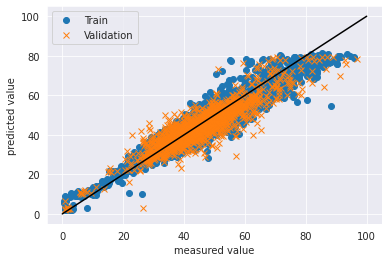

Test: s1i10-012214
Recording time: 2020-08-29 01:36:45.478729
Duriation: 0:14:14.435984
Layer Size: 64
-------------------------
Learning Rate: 0.001
Train Steps: 3000
Batch Size: 128
Dropout Ratio: 0.5
Lambda: 0.01
Beta: 0.02
Start #: 1
Iterations: 10
-------------------------
Architecture: b'| 2_layer_dnn | 3_layer_dnn | 4_layer_dnn | 5_layer_dnn | 6_layer_dnn | 7_layer_dnn | 8_layer_dnn | 8_layer_dnn | 9_layer_dnn |'
-------------------------
cv_r2: 0.8062631738868581
cv_mse: 26.199552536010742
cv_rmse: 5.118549846979195
-------------------------
train_r2: 0.9022139250641396
train_mse: 13.376082420349121
train_rmse: 3.657332692051561


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps 3000 or save_checkpoints_secs None.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps 3000 or save_checkpoints_secs None.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:loss = 1.443887, step = 0


INFO:tensorflow:loss = 1.443887, step = 0


INFO:tensorflow:global_step/sec: 82.8328


INFO:tensorflow:global_step/sec: 82.8328


INFO:tensorflow:loss = 0.22566345, step = 100 (1.214 sec)


INFO:tensorflow:loss = 0.22566345, step = 100 (1.214 sec)


INFO:tensorflow:global_step/sec: 187.816


INFO:tensorflow:global_step/sec: 187.816


INFO:tensorflow:loss = 0.19754633, step = 200 (0.530 sec)


INFO:tensorflow:loss = 0.19754633, step = 200 (0.530 sec)


INFO:tensorflow:global_step/sec: 189.701


INFO:tensorflow:global_step/sec: 189.701


INFO:tensorflow:loss = 0.2569955, step = 300 (0.527 sec)


INFO:tensorflow:loss = 0.2569955, step = 300 (0.527 sec)


INFO:tensorflow:global_step/sec: 187.957


INFO:tensorflow:global_step/sec: 187.957


INFO:tensorflow:loss = 0.22865954, step = 400 (0.530 sec)


INFO:tensorflow:loss = 0.22865954, step = 400 (0.530 sec)


INFO:tensorflow:global_step/sec: 189.738


INFO:tensorflow:global_step/sec: 189.738


INFO:tensorflow:loss = 0.15861486, step = 500 (0.530 sec)


INFO:tensorflow:loss = 0.15861486, step = 500 (0.530 sec)


INFO:tensorflow:global_step/sec: 182.203


INFO:tensorflow:global_step/sec: 182.203


INFO:tensorflow:loss = 0.21081844, step = 600 (0.547 sec)


INFO:tensorflow:loss = 0.21081844, step = 600 (0.547 sec)


INFO:tensorflow:global_step/sec: 192.64


INFO:tensorflow:global_step/sec: 192.64


INFO:tensorflow:loss = 0.21906927, step = 700 (0.521 sec)


INFO:tensorflow:loss = 0.21906927, step = 700 (0.521 sec)


INFO:tensorflow:global_step/sec: 189.159


INFO:tensorflow:global_step/sec: 189.159


INFO:tensorflow:loss = 0.19548665, step = 800 (0.528 sec)


INFO:tensorflow:loss = 0.19548665, step = 800 (0.528 sec)


INFO:tensorflow:global_step/sec: 193.246


INFO:tensorflow:global_step/sec: 193.246


INFO:tensorflow:loss = 0.17917722, step = 900 (0.516 sec)


INFO:tensorflow:loss = 0.17917722, step = 900 (0.516 sec)


INFO:tensorflow:global_step/sec: 182.809


INFO:tensorflow:global_step/sec: 182.809


INFO:tensorflow:loss = 0.13196182, step = 1000 (0.549 sec)


INFO:tensorflow:loss = 0.13196182, step = 1000 (0.549 sec)


INFO:tensorflow:global_step/sec: 192.868


INFO:tensorflow:global_step/sec: 192.868


INFO:tensorflow:loss = 0.18021663, step = 1100 (0.518 sec)


INFO:tensorflow:loss = 0.18021663, step = 1100 (0.518 sec)


INFO:tensorflow:global_step/sec: 193.023


INFO:tensorflow:global_step/sec: 193.023


INFO:tensorflow:loss = 0.1973865, step = 1200 (0.517 sec)


INFO:tensorflow:loss = 0.1973865, step = 1200 (0.517 sec)


INFO:tensorflow:global_step/sec: 188.354


INFO:tensorflow:global_step/sec: 188.354


INFO:tensorflow:loss = 0.15418392, step = 1300 (0.535 sec)


INFO:tensorflow:loss = 0.15418392, step = 1300 (0.535 sec)


INFO:tensorflow:global_step/sec: 185.663


INFO:tensorflow:global_step/sec: 185.663


INFO:tensorflow:loss = 0.14211625, step = 1400 (0.537 sec)


INFO:tensorflow:loss = 0.14211625, step = 1400 (0.537 sec)


INFO:tensorflow:global_step/sec: 189.236


INFO:tensorflow:global_step/sec: 189.236


INFO:tensorflow:loss = 0.14456582, step = 1500 (0.526 sec)


INFO:tensorflow:loss = 0.14456582, step = 1500 (0.526 sec)


INFO:tensorflow:global_step/sec: 189.071


INFO:tensorflow:global_step/sec: 189.071


INFO:tensorflow:loss = 0.19369277, step = 1600 (0.530 sec)


INFO:tensorflow:loss = 0.19369277, step = 1600 (0.530 sec)


INFO:tensorflow:global_step/sec: 190.084


INFO:tensorflow:global_step/sec: 190.084


INFO:tensorflow:loss = 0.19696762, step = 1700 (0.527 sec)


INFO:tensorflow:loss = 0.19696762, step = 1700 (0.527 sec)


INFO:tensorflow:global_step/sec: 184.043


INFO:tensorflow:global_step/sec: 184.043


INFO:tensorflow:loss = 0.15542182, step = 1800 (0.541 sec)


INFO:tensorflow:loss = 0.15542182, step = 1800 (0.541 sec)


INFO:tensorflow:global_step/sec: 178.416


INFO:tensorflow:global_step/sec: 178.416


INFO:tensorflow:loss = 0.121708736, step = 1900 (0.561 sec)


INFO:tensorflow:loss = 0.121708736, step = 1900 (0.561 sec)


INFO:tensorflow:global_step/sec: 190.149


INFO:tensorflow:global_step/sec: 190.149


INFO:tensorflow:loss = 0.11169838, step = 2000 (0.530 sec)


INFO:tensorflow:loss = 0.11169838, step = 2000 (0.530 sec)


INFO:tensorflow:global_step/sec: 187.32


INFO:tensorflow:global_step/sec: 187.32


INFO:tensorflow:loss = 0.18578671, step = 2100 (0.533 sec)


INFO:tensorflow:loss = 0.18578671, step = 2100 (0.533 sec)


INFO:tensorflow:global_step/sec: 185.599


INFO:tensorflow:global_step/sec: 185.599


INFO:tensorflow:loss = 0.18789859, step = 2200 (0.536 sec)


INFO:tensorflow:loss = 0.18789859, step = 2200 (0.536 sec)


INFO:tensorflow:global_step/sec: 190.08


INFO:tensorflow:global_step/sec: 190.08


INFO:tensorflow:loss = 0.20446673, step = 2300 (0.532 sec)


INFO:tensorflow:loss = 0.20446673, step = 2300 (0.532 sec)


INFO:tensorflow:global_step/sec: 179.86


INFO:tensorflow:global_step/sec: 179.86


INFO:tensorflow:loss = 0.12315251, step = 2400 (0.550 sec)


INFO:tensorflow:loss = 0.12315251, step = 2400 (0.550 sec)


INFO:tensorflow:global_step/sec: 192.637


INFO:tensorflow:global_step/sec: 192.637


INFO:tensorflow:loss = 0.17200762, step = 2500 (0.523 sec)


INFO:tensorflow:loss = 0.17200762, step = 2500 (0.523 sec)


INFO:tensorflow:global_step/sec: 178.66


INFO:tensorflow:global_step/sec: 178.66


INFO:tensorflow:loss = 0.17045905, step = 2600 (0.560 sec)


INFO:tensorflow:loss = 0.17045905, step = 2600 (0.560 sec)


INFO:tensorflow:global_step/sec: 184.892


INFO:tensorflow:global_step/sec: 184.892


INFO:tensorflow:loss = 0.14334711, step = 2700 (0.539 sec)


INFO:tensorflow:loss = 0.14334711, step = 2700 (0.539 sec)


INFO:tensorflow:global_step/sec: 183.721


INFO:tensorflow:global_step/sec: 183.721


INFO:tensorflow:loss = 0.13429797, step = 2800 (0.543 sec)


INFO:tensorflow:loss = 0.13429797, step = 2800 (0.543 sec)


INFO:tensorflow:global_step/sec: 179.864


INFO:tensorflow:global_step/sec: 179.864


INFO:tensorflow:loss = 0.14731942, step = 2900 (0.556 sec)


INFO:tensorflow:loss = 0.14731942, step = 2900 (0.556 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3000...


INFO:tensorflow:Saving checkpoints for 3000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:model.ckpt-3000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-3000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-3000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-3000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T01:37:07Z


INFO:tensorflow:Starting evaluation at 2020-08-29T01:37:07Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-3000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-3000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 1.30800s


INFO:tensorflow:Inference Time : 1.30800s


INFO:tensorflow:Finished evaluation at 2020-08-29-01:37:09


INFO:tensorflow:Finished evaluation at 2020-08-29-01:37:09


INFO:tensorflow:Saving dict for global step 3000: average_loss = 0.2088695, best_ensemble_index_0 = 1, global_step = 3000, iteration = 0, label/mean = -0.0007050394, loss = 0.20930173, prediction/mean = -0.053851187


INFO:tensorflow:Saving dict for global step 3000: average_loss = 0.2088695, best_ensemble_index_0 = 1, global_step = 3000, iteration = 0, label/mean = -0.0007050394, loss = 0.20930173, prediction/mean = -0.053851187


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-3000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-3000


INFO:tensorflow:Loss for final step: 0.125428.


INFO:tensorflow:Loss for final step: 0.125428.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-3000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-3000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665031035', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665031035', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665031035/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665031035/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-3000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-3000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3001...


INFO:tensorflow:Saving checkpoints for 3001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665031035/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665031035/model.ckpt.


INFO:tensorflow:model.ckpt-3001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-3001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3001...


INFO:tensorflow:loss = 0.12905383, step = 3000


INFO:tensorflow:loss = 0.12905383, step = 3000


INFO:tensorflow:Loss for final step: 0.12905383.


INFO:tensorflow:Loss for final step: 0.12905383.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-1


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-1


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3000...


INFO:tensorflow:Saving checkpoints for 3000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:model.ckpt-3000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-3000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3000...


INFO:tensorflow:loss = 0.12905383, step = 3000


INFO:tensorflow:loss = 0.12905383, step = 3000


INFO:tensorflow:global_step/sec: 62.5214


INFO:tensorflow:global_step/sec: 62.5214


INFO:tensorflow:loss = 0.115191735, step = 3100 (1.604 sec)


INFO:tensorflow:loss = 0.115191735, step = 3100 (1.604 sec)


INFO:tensorflow:global_step/sec: 145.824


INFO:tensorflow:global_step/sec: 145.824


INFO:tensorflow:loss = 0.14769521, step = 3200 (0.687 sec)


INFO:tensorflow:loss = 0.14769521, step = 3200 (0.687 sec)


INFO:tensorflow:global_step/sec: 136.289


INFO:tensorflow:global_step/sec: 136.289


INFO:tensorflow:loss = 0.16819647, step = 3300 (0.732 sec)


INFO:tensorflow:loss = 0.16819647, step = 3300 (0.732 sec)


INFO:tensorflow:global_step/sec: 147.915


INFO:tensorflow:global_step/sec: 147.915


INFO:tensorflow:loss = 0.15454838, step = 3400 (0.676 sec)


INFO:tensorflow:loss = 0.15454838, step = 3400 (0.676 sec)


INFO:tensorflow:global_step/sec: 150.341


INFO:tensorflow:global_step/sec: 150.341


INFO:tensorflow:loss = 0.11357107, step = 3500 (0.670 sec)


INFO:tensorflow:loss = 0.11357107, step = 3500 (0.670 sec)


INFO:tensorflow:global_step/sec: 146.461


INFO:tensorflow:global_step/sec: 146.461


INFO:tensorflow:loss = 0.14884585, step = 3600 (0.680 sec)


INFO:tensorflow:loss = 0.14884585, step = 3600 (0.680 sec)


INFO:tensorflow:global_step/sec: 148.354


INFO:tensorflow:global_step/sec: 148.354


INFO:tensorflow:loss = 0.16294985, step = 3700 (0.674 sec)


INFO:tensorflow:loss = 0.16294985, step = 3700 (0.674 sec)


INFO:tensorflow:global_step/sec: 149.442


INFO:tensorflow:global_step/sec: 149.442


INFO:tensorflow:loss = 0.16311, step = 3800 (0.676 sec)


INFO:tensorflow:loss = 0.16311, step = 3800 (0.676 sec)


INFO:tensorflow:global_step/sec: 143.917


INFO:tensorflow:global_step/sec: 143.917


INFO:tensorflow:loss = 0.1355194, step = 3900 (0.687 sec)


INFO:tensorflow:loss = 0.1355194, step = 3900 (0.687 sec)


INFO:tensorflow:global_step/sec: 149.067


INFO:tensorflow:global_step/sec: 149.067


INFO:tensorflow:loss = 0.11575034, step = 4000 (0.673 sec)


INFO:tensorflow:loss = 0.11575034, step = 4000 (0.673 sec)


INFO:tensorflow:global_step/sec: 142.58


INFO:tensorflow:global_step/sec: 142.58


INFO:tensorflow:loss = 0.13231805, step = 4100 (0.700 sec)


INFO:tensorflow:loss = 0.13231805, step = 4100 (0.700 sec)


INFO:tensorflow:global_step/sec: 151.084


INFO:tensorflow:global_step/sec: 151.084


INFO:tensorflow:loss = 0.1342716, step = 4200 (0.663 sec)


INFO:tensorflow:loss = 0.1342716, step = 4200 (0.663 sec)


INFO:tensorflow:global_step/sec: 151.589


INFO:tensorflow:global_step/sec: 151.589


INFO:tensorflow:loss = 0.14035562, step = 4300 (0.660 sec)


INFO:tensorflow:loss = 0.14035562, step = 4300 (0.660 sec)


INFO:tensorflow:global_step/sec: 150.635


INFO:tensorflow:global_step/sec: 150.635


INFO:tensorflow:loss = 0.124331, step = 4400 (0.664 sec)


INFO:tensorflow:loss = 0.124331, step = 4400 (0.664 sec)


INFO:tensorflow:global_step/sec: 141.109


INFO:tensorflow:global_step/sec: 141.109


INFO:tensorflow:loss = 0.10820315, step = 4500 (0.708 sec)


INFO:tensorflow:loss = 0.10820315, step = 4500 (0.708 sec)


INFO:tensorflow:global_step/sec: 150.388


INFO:tensorflow:global_step/sec: 150.388


INFO:tensorflow:loss = 0.15783495, step = 4600 (0.664 sec)


INFO:tensorflow:loss = 0.15783495, step = 4600 (0.664 sec)


INFO:tensorflow:global_step/sec: 151.799


INFO:tensorflow:global_step/sec: 151.799


INFO:tensorflow:loss = 0.17137925, step = 4700 (0.657 sec)


INFO:tensorflow:loss = 0.17137925, step = 4700 (0.657 sec)


INFO:tensorflow:global_step/sec: 141.555


INFO:tensorflow:global_step/sec: 141.555


INFO:tensorflow:loss = 0.13551277, step = 4800 (0.708 sec)


INFO:tensorflow:loss = 0.13551277, step = 4800 (0.708 sec)


INFO:tensorflow:global_step/sec: 152.012


INFO:tensorflow:global_step/sec: 152.012


INFO:tensorflow:loss = 0.122677505, step = 4900 (0.660 sec)


INFO:tensorflow:loss = 0.122677505, step = 4900 (0.660 sec)


INFO:tensorflow:global_step/sec: 153.686


INFO:tensorflow:global_step/sec: 153.686


INFO:tensorflow:loss = 0.09180826, step = 5000 (0.650 sec)


INFO:tensorflow:loss = 0.09180826, step = 5000 (0.650 sec)


INFO:tensorflow:global_step/sec: 149.962


INFO:tensorflow:global_step/sec: 149.962


INFO:tensorflow:loss = 0.14480264, step = 5100 (0.665 sec)


INFO:tensorflow:loss = 0.14480264, step = 5100 (0.665 sec)


INFO:tensorflow:global_step/sec: 150.808


INFO:tensorflow:global_step/sec: 150.808


INFO:tensorflow:loss = 0.16262585, step = 5200 (0.664 sec)


INFO:tensorflow:loss = 0.16262585, step = 5200 (0.664 sec)


INFO:tensorflow:global_step/sec: 155.426


INFO:tensorflow:global_step/sec: 155.426


INFO:tensorflow:loss = 0.18084049, step = 5300 (0.644 sec)


INFO:tensorflow:loss = 0.18084049, step = 5300 (0.644 sec)


INFO:tensorflow:global_step/sec: 147.989


INFO:tensorflow:global_step/sec: 147.989


INFO:tensorflow:loss = 0.13085894, step = 5400 (0.677 sec)


INFO:tensorflow:loss = 0.13085894, step = 5400 (0.677 sec)


INFO:tensorflow:global_step/sec: 149.99


INFO:tensorflow:global_step/sec: 149.99


INFO:tensorflow:loss = 0.12659027, step = 5500 (0.666 sec)


INFO:tensorflow:loss = 0.12659027, step = 5500 (0.666 sec)


INFO:tensorflow:global_step/sec: 141.266


INFO:tensorflow:global_step/sec: 141.266


INFO:tensorflow:loss = 0.16114268, step = 5600 (0.710 sec)


INFO:tensorflow:loss = 0.16114268, step = 5600 (0.710 sec)


INFO:tensorflow:global_step/sec: 145.924


INFO:tensorflow:global_step/sec: 145.924


INFO:tensorflow:loss = 0.12482212, step = 5700 (0.682 sec)


INFO:tensorflow:loss = 0.12482212, step = 5700 (0.682 sec)


INFO:tensorflow:global_step/sec: 151.759


INFO:tensorflow:global_step/sec: 151.759


INFO:tensorflow:loss = 0.14940587, step = 5800 (0.662 sec)


INFO:tensorflow:loss = 0.14940587, step = 5800 (0.662 sec)


INFO:tensorflow:global_step/sec: 153.613


INFO:tensorflow:global_step/sec: 153.613


INFO:tensorflow:loss = 0.13687393, step = 5900 (0.656 sec)


INFO:tensorflow:loss = 0.13687393, step = 5900 (0.656 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6000...


INFO:tensorflow:Saving checkpoints for 6000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:Saving checkpoints for 6000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:model.ckpt-6000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-6000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-6000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-6000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T01:37:47Z


INFO:tensorflow:Starting evaluation at 2020-08-29T01:37:47Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-6000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-6000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 1.97805s


INFO:tensorflow:Inference Time : 1.97805s


INFO:tensorflow:Finished evaluation at 2020-08-29-01:37:49


INFO:tensorflow:Finished evaluation at 2020-08-29-01:37:49


INFO:tensorflow:Saving dict for global step 6000: average_loss = 0.20092107, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, global_step = 6000, iteration = 1, label/mean = -0.0007050394, loss = 0.201314, prediction/mean = -0.056317333


INFO:tensorflow:Saving dict for global step 6000: average_loss = 0.20092107, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, global_step = 6000, iteration = 1, label/mean = -0.0007050394, loss = 0.201314, prediction/mean = -0.056317333


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-6000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-6000


INFO:tensorflow:Loss for final step: 0.09701089.


INFO:tensorflow:Loss for final step: 0.09701089.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-6000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-6000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665071556', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665071556', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665071556/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665071556/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-6000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-6000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-2 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-2 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6001...


INFO:tensorflow:Saving checkpoints for 6001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665071556/model.ckpt.


INFO:tensorflow:Saving checkpoints for 6001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665071556/model.ckpt.


INFO:tensorflow:model.ckpt-6001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-6001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6001...


INFO:tensorflow:loss = 0.11579645, step = 6000


INFO:tensorflow:loss = 0.11579645, step = 6000


INFO:tensorflow:Loss for final step: 0.11579645.


INFO:tensorflow:Loss for final step: 0.11579645.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-2


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-2


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6000...


INFO:tensorflow:Saving checkpoints for 6000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:Saving checkpoints for 6000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:model.ckpt-6000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-6000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6000...


INFO:tensorflow:loss = 0.11579645, step = 6000


INFO:tensorflow:loss = 0.11579645, step = 6000


INFO:tensorflow:global_step/sec: 50.4951


INFO:tensorflow:global_step/sec: 50.4951


INFO:tensorflow:loss = 0.100529045, step = 6100 (1.988 sec)


INFO:tensorflow:loss = 0.100529045, step = 6100 (1.988 sec)


INFO:tensorflow:global_step/sec: 125.865


INFO:tensorflow:global_step/sec: 125.865


INFO:tensorflow:loss = 0.13244513, step = 6200 (0.791 sec)


INFO:tensorflow:loss = 0.13244513, step = 6200 (0.791 sec)


INFO:tensorflow:global_step/sec: 129.244


INFO:tensorflow:global_step/sec: 129.244


INFO:tensorflow:loss = 0.15195265, step = 6300 (0.774 sec)


INFO:tensorflow:loss = 0.15195265, step = 6300 (0.774 sec)


INFO:tensorflow:global_step/sec: 119.329


INFO:tensorflow:global_step/sec: 119.329


INFO:tensorflow:loss = 0.14308393, step = 6400 (0.838 sec)


INFO:tensorflow:loss = 0.14308393, step = 6400 (0.838 sec)


INFO:tensorflow:global_step/sec: 126.833


INFO:tensorflow:global_step/sec: 126.833


INFO:tensorflow:loss = 0.10207476, step = 6500 (0.788 sec)


INFO:tensorflow:loss = 0.10207476, step = 6500 (0.788 sec)


INFO:tensorflow:global_step/sec: 123.381


INFO:tensorflow:global_step/sec: 123.381


INFO:tensorflow:loss = 0.13597074, step = 6600 (0.811 sec)


INFO:tensorflow:loss = 0.13597074, step = 6600 (0.811 sec)


INFO:tensorflow:global_step/sec: 127.346


INFO:tensorflow:global_step/sec: 127.346


INFO:tensorflow:loss = 0.14311415, step = 6700 (0.786 sec)


INFO:tensorflow:loss = 0.14311415, step = 6700 (0.786 sec)


INFO:tensorflow:global_step/sec: 129.308


INFO:tensorflow:global_step/sec: 129.308


INFO:tensorflow:loss = 0.15255496, step = 6800 (0.771 sec)


INFO:tensorflow:loss = 0.15255496, step = 6800 (0.771 sec)


INFO:tensorflow:global_step/sec: 126.102


INFO:tensorflow:global_step/sec: 126.102


INFO:tensorflow:loss = 0.12459096, step = 6900 (0.793 sec)


INFO:tensorflow:loss = 0.12459096, step = 6900 (0.793 sec)


INFO:tensorflow:global_step/sec: 122.885


INFO:tensorflow:global_step/sec: 122.885


INFO:tensorflow:loss = 0.103842735, step = 7000 (0.813 sec)


INFO:tensorflow:loss = 0.103842735, step = 7000 (0.813 sec)


INFO:tensorflow:global_step/sec: 122.215


INFO:tensorflow:global_step/sec: 122.215


INFO:tensorflow:loss = 0.114596024, step = 7100 (0.821 sec)


INFO:tensorflow:loss = 0.114596024, step = 7100 (0.821 sec)


INFO:tensorflow:global_step/sec: 126.836


INFO:tensorflow:global_step/sec: 126.836


INFO:tensorflow:loss = 0.12310956, step = 7200 (0.786 sec)


INFO:tensorflow:loss = 0.12310956, step = 7200 (0.786 sec)


INFO:tensorflow:global_step/sec: 127.297


INFO:tensorflow:global_step/sec: 127.297


INFO:tensorflow:loss = 0.12984475, step = 7300 (0.786 sec)


INFO:tensorflow:loss = 0.12984475, step = 7300 (0.786 sec)


INFO:tensorflow:global_step/sec: 129.258


INFO:tensorflow:global_step/sec: 129.258


INFO:tensorflow:loss = 0.1145594, step = 7400 (0.776 sec)


INFO:tensorflow:loss = 0.1145594, step = 7400 (0.776 sec)


INFO:tensorflow:global_step/sec: 128.574


INFO:tensorflow:global_step/sec: 128.574


INFO:tensorflow:loss = 0.094795585, step = 7500 (0.774 sec)


INFO:tensorflow:loss = 0.094795585, step = 7500 (0.774 sec)


INFO:tensorflow:global_step/sec: 123.374


INFO:tensorflow:global_step/sec: 123.374


INFO:tensorflow:loss = 0.13795714, step = 7600 (0.811 sec)


INFO:tensorflow:loss = 0.13795714, step = 7600 (0.811 sec)


INFO:tensorflow:global_step/sec: 123.716


INFO:tensorflow:global_step/sec: 123.716


INFO:tensorflow:loss = 0.15569979, step = 7700 (0.811 sec)


INFO:tensorflow:loss = 0.15569979, step = 7700 (0.811 sec)


INFO:tensorflow:global_step/sec: 127.725


INFO:tensorflow:global_step/sec: 127.725


INFO:tensorflow:loss = 0.12137569, step = 7800 (0.780 sec)


INFO:tensorflow:loss = 0.12137569, step = 7800 (0.780 sec)


INFO:tensorflow:global_step/sec: 126.771


INFO:tensorflow:global_step/sec: 126.771


INFO:tensorflow:loss = 0.11246943, step = 7900 (0.790 sec)


INFO:tensorflow:loss = 0.11246943, step = 7900 (0.790 sec)


INFO:tensorflow:global_step/sec: 128.223


INFO:tensorflow:global_step/sec: 128.223


INFO:tensorflow:loss = 0.083749175, step = 8000 (0.778 sec)


INFO:tensorflow:loss = 0.083749175, step = 8000 (0.778 sec)


INFO:tensorflow:global_step/sec: 127.515


INFO:tensorflow:global_step/sec: 127.515


INFO:tensorflow:loss = 0.12915911, step = 8100 (0.784 sec)


INFO:tensorflow:loss = 0.12915911, step = 8100 (0.784 sec)


INFO:tensorflow:global_step/sec: 129.131


INFO:tensorflow:global_step/sec: 129.131


INFO:tensorflow:loss = 0.13846725, step = 8200 (0.776 sec)


INFO:tensorflow:loss = 0.13846725, step = 8200 (0.776 sec)


INFO:tensorflow:global_step/sec: 121.278


INFO:tensorflow:global_step/sec: 121.278


INFO:tensorflow:loss = 0.15702173, step = 8300 (0.825 sec)


INFO:tensorflow:loss = 0.15702173, step = 8300 (0.825 sec)


INFO:tensorflow:global_step/sec: 125.706


INFO:tensorflow:global_step/sec: 125.706


INFO:tensorflow:loss = 0.11479153, step = 8400 (0.793 sec)


INFO:tensorflow:loss = 0.11479153, step = 8400 (0.793 sec)


INFO:tensorflow:global_step/sec: 131.333


INFO:tensorflow:global_step/sec: 131.333


INFO:tensorflow:loss = 0.11514013, step = 8500 (0.764 sec)


INFO:tensorflow:loss = 0.11514013, step = 8500 (0.764 sec)


INFO:tensorflow:global_step/sec: 128.044


INFO:tensorflow:global_step/sec: 128.044


INFO:tensorflow:loss = 0.15816337, step = 8600 (0.779 sec)


INFO:tensorflow:loss = 0.15816337, step = 8600 (0.779 sec)


INFO:tensorflow:global_step/sec: 126.08


INFO:tensorflow:global_step/sec: 126.08


INFO:tensorflow:loss = 0.1215574, step = 8700 (0.794 sec)


INFO:tensorflow:loss = 0.1215574, step = 8700 (0.794 sec)


INFO:tensorflow:global_step/sec: 127.667


INFO:tensorflow:global_step/sec: 127.667


INFO:tensorflow:loss = 0.1319115, step = 8800 (0.782 sec)


INFO:tensorflow:loss = 0.1319115, step = 8800 (0.782 sec)


INFO:tensorflow:global_step/sec: 128.93


INFO:tensorflow:global_step/sec: 128.93


INFO:tensorflow:loss = 0.13902786, step = 8900 (0.776 sec)


INFO:tensorflow:loss = 0.13902786, step = 8900 (0.776 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9000...


INFO:tensorflow:Saving checkpoints for 9000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:Saving checkpoints for 9000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:model.ckpt-9000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-9000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-9000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-9000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T01:38:36Z


INFO:tensorflow:Starting evaluation at 2020-08-29T01:38:36Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-9000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-9000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 4.55135s


INFO:tensorflow:Inference Time : 4.55135s


INFO:tensorflow:Finished evaluation at 2020-08-29-01:38:41


INFO:tensorflow:Finished evaluation at 2020-08-29-01:38:41


INFO:tensorflow:Saving dict for global step 9000: average_loss = 0.19817969, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, global_step = 9000, iteration = 2, label/mean = -0.0007050394, loss = 0.19845068, prediction/mean = -0.05889497


INFO:tensorflow:Saving dict for global step 9000: average_loss = 0.19817969, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, global_step = 9000, iteration = 2, label/mean = -0.0007050394, loss = 0.19845068, prediction/mean = -0.05889497


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-9000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-9000


INFO:tensorflow:Loss for final step: 0.08491351.


INFO:tensorflow:Loss for final step: 0.08491351.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-9000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-9000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665124874', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665124874', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665124874/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665124874/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-9000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-9000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-3 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-3 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9001...


INFO:tensorflow:Saving checkpoints for 9001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665124874/model.ckpt.


INFO:tensorflow:Saving checkpoints for 9001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665124874/model.ckpt.


INFO:tensorflow:model.ckpt-9001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-9001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9001...


INFO:tensorflow:loss = 0.10308263, step = 9001


INFO:tensorflow:loss = 0.10308263, step = 9001


INFO:tensorflow:Loss for final step: 0.10308263.


INFO:tensorflow:Loss for final step: 0.10308263.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-3


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-3


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9000...


INFO:tensorflow:Saving checkpoints for 9000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:Saving checkpoints for 9000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:model.ckpt-9000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-9000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9000...


INFO:tensorflow:loss = 0.10308263, step = 9000


INFO:tensorflow:loss = 0.10308263, step = 9000


INFO:tensorflow:global_step/sec: 40.5633


INFO:tensorflow:global_step/sec: 40.5633


INFO:tensorflow:loss = 0.08883905, step = 9100 (2.471 sec)


INFO:tensorflow:loss = 0.08883905, step = 9100 (2.471 sec)


INFO:tensorflow:global_step/sec: 110.275


INFO:tensorflow:global_step/sec: 110.275


INFO:tensorflow:loss = 0.1167973, step = 9200 (0.906 sec)


INFO:tensorflow:loss = 0.1167973, step = 9200 (0.906 sec)


INFO:tensorflow:global_step/sec: 110.353


INFO:tensorflow:global_step/sec: 110.353


INFO:tensorflow:loss = 0.13155386, step = 9300 (0.905 sec)


INFO:tensorflow:loss = 0.13155386, step = 9300 (0.905 sec)


INFO:tensorflow:global_step/sec: 110.201


INFO:tensorflow:global_step/sec: 110.201


INFO:tensorflow:loss = 0.13064346, step = 9400 (0.908 sec)


INFO:tensorflow:loss = 0.13064346, step = 9400 (0.908 sec)


INFO:tensorflow:global_step/sec: 112.065


INFO:tensorflow:global_step/sec: 112.065


INFO:tensorflow:loss = 0.08891152, step = 9500 (0.891 sec)


INFO:tensorflow:loss = 0.08891152, step = 9500 (0.891 sec)


INFO:tensorflow:global_step/sec: 110.79


INFO:tensorflow:global_step/sec: 110.79


INFO:tensorflow:loss = 0.12811857, step = 9600 (0.906 sec)


INFO:tensorflow:loss = 0.12811857, step = 9600 (0.906 sec)


INFO:tensorflow:global_step/sec: 106.633


INFO:tensorflow:global_step/sec: 106.633


INFO:tensorflow:loss = 0.12235132, step = 9700 (0.937 sec)


INFO:tensorflow:loss = 0.12235132, step = 9700 (0.937 sec)


INFO:tensorflow:global_step/sec: 110.393


INFO:tensorflow:global_step/sec: 110.393


INFO:tensorflow:loss = 0.14142339, step = 9800 (0.906 sec)


INFO:tensorflow:loss = 0.14142339, step = 9800 (0.906 sec)


INFO:tensorflow:global_step/sec: 108.545


INFO:tensorflow:global_step/sec: 108.545


INFO:tensorflow:loss = 0.11026436, step = 9900 (0.920 sec)


INFO:tensorflow:loss = 0.11026436, step = 9900 (0.920 sec)


INFO:tensorflow:global_step/sec: 109.4


INFO:tensorflow:global_step/sec: 109.4


INFO:tensorflow:loss = 0.09512387, step = 10000 (0.913 sec)


INFO:tensorflow:loss = 0.09512387, step = 10000 (0.913 sec)


INFO:tensorflow:global_step/sec: 109.769


INFO:tensorflow:global_step/sec: 109.769


INFO:tensorflow:loss = 0.095193595, step = 10100 (0.912 sec)


INFO:tensorflow:loss = 0.095193595, step = 10100 (0.912 sec)


INFO:tensorflow:global_step/sec: 102.431


INFO:tensorflow:global_step/sec: 102.431


INFO:tensorflow:loss = 0.10969329, step = 10200 (0.978 sec)


INFO:tensorflow:loss = 0.10969329, step = 10200 (0.978 sec)


INFO:tensorflow:global_step/sec: 108.276


INFO:tensorflow:global_step/sec: 108.276


INFO:tensorflow:loss = 0.11565947, step = 10300 (0.924 sec)


INFO:tensorflow:loss = 0.11565947, step = 10300 (0.924 sec)


INFO:tensorflow:global_step/sec: 110.843


INFO:tensorflow:global_step/sec: 110.843


INFO:tensorflow:loss = 0.09488125, step = 10400 (0.900 sec)


INFO:tensorflow:loss = 0.09488125, step = 10400 (0.900 sec)


INFO:tensorflow:global_step/sec: 108.887


INFO:tensorflow:global_step/sec: 108.887


INFO:tensorflow:loss = 0.086091906, step = 10500 (0.921 sec)


INFO:tensorflow:loss = 0.086091906, step = 10500 (0.921 sec)


INFO:tensorflow:global_step/sec: 108.789


INFO:tensorflow:global_step/sec: 108.789


INFO:tensorflow:loss = 0.12184958, step = 10600 (0.919 sec)


INFO:tensorflow:loss = 0.12184958, step = 10600 (0.919 sec)


INFO:tensorflow:global_step/sec: 112.124


INFO:tensorflow:global_step/sec: 112.124


INFO:tensorflow:loss = 0.13640529, step = 10700 (0.893 sec)


INFO:tensorflow:loss = 0.13640529, step = 10700 (0.893 sec)


INFO:tensorflow:global_step/sec: 103.217


INFO:tensorflow:global_step/sec: 103.217


INFO:tensorflow:loss = 0.11014413, step = 10800 (0.965 sec)


INFO:tensorflow:loss = 0.11014413, step = 10800 (0.965 sec)


INFO:tensorflow:global_step/sec: 109.606


INFO:tensorflow:global_step/sec: 109.606


INFO:tensorflow:loss = 0.102012105, step = 10900 (0.915 sec)


INFO:tensorflow:loss = 0.102012105, step = 10900 (0.915 sec)


INFO:tensorflow:global_step/sec: 111.171


INFO:tensorflow:global_step/sec: 111.171


INFO:tensorflow:loss = 0.07206896, step = 11000 (0.897 sec)


INFO:tensorflow:loss = 0.07206896, step = 11000 (0.897 sec)


INFO:tensorflow:global_step/sec: 109.995


INFO:tensorflow:global_step/sec: 109.995


INFO:tensorflow:loss = 0.11197686, step = 11100 (0.909 sec)


INFO:tensorflow:loss = 0.11197686, step = 11100 (0.909 sec)


INFO:tensorflow:global_step/sec: 110.139


INFO:tensorflow:global_step/sec: 110.139


INFO:tensorflow:loss = 0.116390675, step = 11200 (0.911 sec)


INFO:tensorflow:loss = 0.116390675, step = 11200 (0.911 sec)


INFO:tensorflow:global_step/sec: 103.7


INFO:tensorflow:global_step/sec: 103.7


INFO:tensorflow:loss = 0.13170981, step = 11300 (0.961 sec)


INFO:tensorflow:loss = 0.13170981, step = 11300 (0.961 sec)


INFO:tensorflow:global_step/sec: 111.366


INFO:tensorflow:global_step/sec: 111.366


INFO:tensorflow:loss = 0.10116915, step = 11400 (0.899 sec)


INFO:tensorflow:loss = 0.10116915, step = 11400 (0.899 sec)


INFO:tensorflow:global_step/sec: 109.76


INFO:tensorflow:global_step/sec: 109.76


INFO:tensorflow:loss = 0.1073765, step = 11500 (0.912 sec)


INFO:tensorflow:loss = 0.1073765, step = 11500 (0.912 sec)


INFO:tensorflow:global_step/sec: 109.081


INFO:tensorflow:global_step/sec: 109.081


INFO:tensorflow:loss = 0.14147517, step = 11600 (0.918 sec)


INFO:tensorflow:loss = 0.14147517, step = 11600 (0.918 sec)


INFO:tensorflow:global_step/sec: 111.837


INFO:tensorflow:global_step/sec: 111.837


INFO:tensorflow:loss = 0.10456172, step = 11700 (0.899 sec)


INFO:tensorflow:loss = 0.10456172, step = 11700 (0.899 sec)


INFO:tensorflow:global_step/sec: 110.326


INFO:tensorflow:global_step/sec: 110.326


INFO:tensorflow:loss = 0.11332085, step = 11800 (0.899 sec)


INFO:tensorflow:loss = 0.11332085, step = 11800 (0.899 sec)


INFO:tensorflow:global_step/sec: 103.586


INFO:tensorflow:global_step/sec: 103.586


INFO:tensorflow:loss = 0.1250614, step = 11900 (0.967 sec)


INFO:tensorflow:loss = 0.1250614, step = 11900 (0.967 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 12000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 12000...


INFO:tensorflow:Saving checkpoints for 12000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:Saving checkpoints for 12000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:model.ckpt-12000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-12000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 12000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 12000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-12000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-12000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T01:39:40Z


INFO:tensorflow:Starting evaluation at 2020-08-29T01:39:40Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-12000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-12000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 3.40868s


INFO:tensorflow:Inference Time : 3.40868s


INFO:tensorflow:Finished evaluation at 2020-08-29-01:39:44


INFO:tensorflow:Finished evaluation at 2020-08-29-01:39:44


INFO:tensorflow:Saving dict for global step 12000: average_loss = 0.19590761, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, global_step = 12000, iteration = 3, label/mean = -0.0007050394, loss = 0.19602077, prediction/mean = -0.068932265


INFO:tensorflow:Saving dict for global step 12000: average_loss = 0.19590761, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, global_step = 12000, iteration = 3, label/mean = -0.0007050394, loss = 0.19602077, prediction/mean = -0.068932265


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 12000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-12000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 12000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-12000


INFO:tensorflow:Loss for final step: 0.07547416.


INFO:tensorflow:Loss for final step: 0.07547416.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-12000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-12000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665188958', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665188958', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665188958/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665188958/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-12000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-12000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-4 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-4 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 12001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 12001...


INFO:tensorflow:Saving checkpoints for 12001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665188958/model.ckpt.


INFO:tensorflow:Saving checkpoints for 12001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665188958/model.ckpt.


INFO:tensorflow:model.ckpt-12001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-12001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 12001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 12001...


INFO:tensorflow:loss = 0.09385044, step = 12000


INFO:tensorflow:loss = 0.09385044, step = 12000


INFO:tensorflow:Loss for final step: 0.09385044.


INFO:tensorflow:Loss for final step: 0.09385044.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-4


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-4


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 12000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 12000...


INFO:tensorflow:Saving checkpoints for 12000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:Saving checkpoints for 12000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:model.ckpt-12000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-12000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 12000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 12000...


INFO:tensorflow:loss = 0.09385044, step = 12000


INFO:tensorflow:loss = 0.09385044, step = 12000


INFO:tensorflow:global_step/sec: 36.4174


INFO:tensorflow:global_step/sec: 36.4174


INFO:tensorflow:loss = 0.08607597, step = 12100 (2.755 sec)


INFO:tensorflow:loss = 0.08607597, step = 12100 (2.755 sec)


INFO:tensorflow:global_step/sec: 95.888


INFO:tensorflow:global_step/sec: 95.888


INFO:tensorflow:loss = 0.109329075, step = 12200 (1.039 sec)


INFO:tensorflow:loss = 0.109329075, step = 12200 (1.039 sec)


INFO:tensorflow:global_step/sec: 95.254


INFO:tensorflow:global_step/sec: 95.254


INFO:tensorflow:loss = 0.12004385, step = 12300 (1.052 sec)


INFO:tensorflow:loss = 0.12004385, step = 12300 (1.052 sec)


INFO:tensorflow:global_step/sec: 91.5826


INFO:tensorflow:global_step/sec: 91.5826


INFO:tensorflow:loss = 0.12490795, step = 12400 (1.089 sec)


INFO:tensorflow:loss = 0.12490795, step = 12400 (1.089 sec)


INFO:tensorflow:global_step/sec: 95.3504


INFO:tensorflow:global_step/sec: 95.3504


INFO:tensorflow:loss = 0.07869717, step = 12500 (1.051 sec)


INFO:tensorflow:loss = 0.07869717, step = 12500 (1.051 sec)


INFO:tensorflow:global_step/sec: 95.4347


INFO:tensorflow:global_step/sec: 95.4347


INFO:tensorflow:loss = 0.119002886, step = 12600 (1.047 sec)


INFO:tensorflow:loss = 0.119002886, step = 12600 (1.047 sec)


INFO:tensorflow:global_step/sec: 93.8139


INFO:tensorflow:global_step/sec: 93.8139


INFO:tensorflow:loss = 0.10869843, step = 12700 (1.067 sec)


INFO:tensorflow:loss = 0.10869843, step = 12700 (1.067 sec)


INFO:tensorflow:global_step/sec: 90.4115


INFO:tensorflow:global_step/sec: 90.4115


INFO:tensorflow:loss = 0.1359931, step = 12800 (1.106 sec)


INFO:tensorflow:loss = 0.1359931, step = 12800 (1.106 sec)


INFO:tensorflow:global_step/sec: 95.5353


INFO:tensorflow:global_step/sec: 95.5353


INFO:tensorflow:loss = 0.09815833, step = 12900 (1.047 sec)


INFO:tensorflow:loss = 0.09815833, step = 12900 (1.047 sec)


INFO:tensorflow:global_step/sec: 94.7199


INFO:tensorflow:global_step/sec: 94.7199


INFO:tensorflow:loss = 0.09219442, step = 13000 (1.054 sec)


INFO:tensorflow:loss = 0.09219442, step = 13000 (1.054 sec)


INFO:tensorflow:global_step/sec: 96.5893


INFO:tensorflow:global_step/sec: 96.5893


INFO:tensorflow:loss = 0.08598817, step = 13100 (1.034 sec)


INFO:tensorflow:loss = 0.08598817, step = 13100 (1.034 sec)


INFO:tensorflow:global_step/sec: 96.3463


INFO:tensorflow:global_step/sec: 96.3463


INFO:tensorflow:loss = 0.096580885, step = 13200 (1.041 sec)


INFO:tensorflow:loss = 0.096580885, step = 13200 (1.041 sec)


INFO:tensorflow:global_step/sec: 94.575


INFO:tensorflow:global_step/sec: 94.575


INFO:tensorflow:loss = 0.10880013, step = 13300 (1.057 sec)


INFO:tensorflow:loss = 0.10880013, step = 13300 (1.057 sec)


INFO:tensorflow:global_step/sec: 93.6801


INFO:tensorflow:global_step/sec: 93.6801


INFO:tensorflow:loss = 0.0882019, step = 13400 (1.066 sec)


INFO:tensorflow:loss = 0.0882019, step = 13400 (1.066 sec)


INFO:tensorflow:global_step/sec: 97.7302


INFO:tensorflow:global_step/sec: 97.7302


INFO:tensorflow:loss = 0.07990377, step = 13500 (1.023 sec)


INFO:tensorflow:loss = 0.07990377, step = 13500 (1.023 sec)


INFO:tensorflow:global_step/sec: 97.764


INFO:tensorflow:global_step/sec: 97.764


INFO:tensorflow:loss = 0.1115473, step = 13600 (1.023 sec)


INFO:tensorflow:loss = 0.1115473, step = 13600 (1.023 sec)


INFO:tensorflow:global_step/sec: 92.8432


INFO:tensorflow:global_step/sec: 92.8432


INFO:tensorflow:loss = 0.12850738, step = 13700 (1.078 sec)


INFO:tensorflow:loss = 0.12850738, step = 13700 (1.078 sec)


INFO:tensorflow:global_step/sec: 88.9228


INFO:tensorflow:global_step/sec: 88.9228


INFO:tensorflow:loss = 0.10649462, step = 13800 (1.124 sec)


INFO:tensorflow:loss = 0.10649462, step = 13800 (1.124 sec)


INFO:tensorflow:global_step/sec: 93.0736


INFO:tensorflow:global_step/sec: 93.0736


INFO:tensorflow:loss = 0.096395105, step = 13900 (1.073 sec)


INFO:tensorflow:loss = 0.096395105, step = 13900 (1.073 sec)


INFO:tensorflow:global_step/sec: 92.8366


INFO:tensorflow:global_step/sec: 92.8366


INFO:tensorflow:loss = 0.0633808, step = 14000 (1.078 sec)


INFO:tensorflow:loss = 0.0633808, step = 14000 (1.078 sec)


INFO:tensorflow:global_step/sec: 93.5377


INFO:tensorflow:global_step/sec: 93.5377


INFO:tensorflow:loss = 0.10063012, step = 14100 (1.069 sec)


INFO:tensorflow:loss = 0.10063012, step = 14100 (1.069 sec)


INFO:tensorflow:global_step/sec: 93.3781


INFO:tensorflow:global_step/sec: 93.3781


INFO:tensorflow:loss = 0.11072198, step = 14200 (1.073 sec)


INFO:tensorflow:loss = 0.11072198, step = 14200 (1.073 sec)


INFO:tensorflow:global_step/sec: 89.4093


INFO:tensorflow:global_step/sec: 89.4093


INFO:tensorflow:loss = 0.122634634, step = 14300 (1.117 sec)


INFO:tensorflow:loss = 0.122634634, step = 14300 (1.117 sec)


INFO:tensorflow:global_step/sec: 91.6135


INFO:tensorflow:global_step/sec: 91.6135


INFO:tensorflow:loss = 0.092900455, step = 14400 (1.094 sec)


INFO:tensorflow:loss = 0.092900455, step = 14400 (1.094 sec)


INFO:tensorflow:global_step/sec: 92.5788


INFO:tensorflow:global_step/sec: 92.5788


INFO:tensorflow:loss = 0.10655056, step = 14500 (1.079 sec)


INFO:tensorflow:loss = 0.10655056, step = 14500 (1.079 sec)


INFO:tensorflow:global_step/sec: 92.3569


INFO:tensorflow:global_step/sec: 92.3569


INFO:tensorflow:loss = 0.13315259, step = 14600 (1.084 sec)


INFO:tensorflow:loss = 0.13315259, step = 14600 (1.084 sec)


INFO:tensorflow:global_step/sec: 93.0025


INFO:tensorflow:global_step/sec: 93.0025


INFO:tensorflow:loss = 0.09659904, step = 14700 (1.077 sec)


INFO:tensorflow:loss = 0.09659904, step = 14700 (1.077 sec)


INFO:tensorflow:global_step/sec: 97.0503


INFO:tensorflow:global_step/sec: 97.0503


INFO:tensorflow:loss = 0.102738515, step = 14800 (1.026 sec)


INFO:tensorflow:loss = 0.102738515, step = 14800 (1.026 sec)


INFO:tensorflow:global_step/sec: 96.6677


INFO:tensorflow:global_step/sec: 96.6677


INFO:tensorflow:loss = 0.11293438, step = 14900 (1.035 sec)


INFO:tensorflow:loss = 0.11293438, step = 14900 (1.035 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15000...


INFO:tensorflow:Saving checkpoints for 15000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:Saving checkpoints for 15000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:model.ckpt-15000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-15000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-15000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-15000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T01:40:57Z


INFO:tensorflow:Starting evaluation at 2020-08-29T01:40:57Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-15000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-15000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 4.76526s


INFO:tensorflow:Inference Time : 4.76526s


INFO:tensorflow:Finished evaluation at 2020-08-29-01:41:02


INFO:tensorflow:Finished evaluation at 2020-08-29-01:41:02


INFO:tensorflow:Saving dict for global step 15000: average_loss = 0.19443113, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, global_step = 15000, iteration = 4, label/mean = -0.0007050394, loss = 0.19460359, prediction/mean = -0.07595569


INFO:tensorflow:Saving dict for global step 15000: average_loss = 0.19443113, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, global_step = 15000, iteration = 4, label/mean = -0.0007050394, loss = 0.19460359, prediction/mean = -0.07595569


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 15000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-15000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 15000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-15000


INFO:tensorflow:Loss for final step: 0.074996315.


INFO:tensorflow:Loss for final step: 0.074996315.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-15000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-15000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665268293', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665268293', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665268293/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665268293/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-15000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-15000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-5 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-5 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15001...


INFO:tensorflow:Saving checkpoints for 15001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665268293/model.ckpt.


INFO:tensorflow:Saving checkpoints for 15001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665268293/model.ckpt.


INFO:tensorflow:model.ckpt-15001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-15001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15001...


INFO:tensorflow:loss = 0.091234535, step = 15000


INFO:tensorflow:loss = 0.091234535, step = 15000


INFO:tensorflow:Loss for final step: 0.091234535.


INFO:tensorflow:Loss for final step: 0.091234535.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-5


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-5


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15000...


INFO:tensorflow:Saving checkpoints for 15000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:Saving checkpoints for 15000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:model.ckpt-15000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-15000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15000...


INFO:tensorflow:loss = 0.091234535, step = 15000


INFO:tensorflow:loss = 0.091234535, step = 15000


INFO:tensorflow:global_step/sec: 29.877


INFO:tensorflow:global_step/sec: 29.877


INFO:tensorflow:loss = 0.08479048, step = 15100 (3.351 sec)


INFO:tensorflow:loss = 0.08479048, step = 15100 (3.351 sec)


INFO:tensorflow:global_step/sec: 84.1665


INFO:tensorflow:global_step/sec: 84.1665


INFO:tensorflow:loss = 0.10701461, step = 15200 (1.188 sec)


INFO:tensorflow:loss = 0.10701461, step = 15200 (1.188 sec)


INFO:tensorflow:global_step/sec: 84.9476


INFO:tensorflow:global_step/sec: 84.9476


INFO:tensorflow:loss = 0.11766133, step = 15300 (1.177 sec)


INFO:tensorflow:loss = 0.11766133, step = 15300 (1.177 sec)


INFO:tensorflow:global_step/sec: 81.8374


INFO:tensorflow:global_step/sec: 81.8374


INFO:tensorflow:loss = 0.12319715, step = 15400 (1.224 sec)


INFO:tensorflow:loss = 0.12319715, step = 15400 (1.224 sec)


INFO:tensorflow:global_step/sec: 85.3595


INFO:tensorflow:global_step/sec: 85.3595


INFO:tensorflow:loss = 0.0778736, step = 15500 (1.172 sec)


INFO:tensorflow:loss = 0.0778736, step = 15500 (1.172 sec)


INFO:tensorflow:global_step/sec: 85.9156


INFO:tensorflow:global_step/sec: 85.9156


INFO:tensorflow:loss = 0.11434628, step = 15600 (1.162 sec)


INFO:tensorflow:loss = 0.11434628, step = 15600 (1.162 sec)


INFO:tensorflow:global_step/sec: 85.2088


INFO:tensorflow:global_step/sec: 85.2088


INFO:tensorflow:loss = 0.1013371, step = 15700 (1.176 sec)


INFO:tensorflow:loss = 0.1013371, step = 15700 (1.176 sec)


INFO:tensorflow:global_step/sec: 84.1901


INFO:tensorflow:global_step/sec: 84.1901


INFO:tensorflow:loss = 0.13023394, step = 15800 (1.188 sec)


INFO:tensorflow:loss = 0.13023394, step = 15800 (1.188 sec)


INFO:tensorflow:global_step/sec: 84.4083


INFO:tensorflow:global_step/sec: 84.4083


INFO:tensorflow:loss = 0.09538231, step = 15900 (1.185 sec)


INFO:tensorflow:loss = 0.09538231, step = 15900 (1.185 sec)


INFO:tensorflow:global_step/sec: 83.9356


INFO:tensorflow:global_step/sec: 83.9356


INFO:tensorflow:loss = 0.090377524, step = 16000 (1.188 sec)


INFO:tensorflow:loss = 0.090377524, step = 16000 (1.188 sec)


INFO:tensorflow:global_step/sec: 83.3529


INFO:tensorflow:global_step/sec: 83.3529


INFO:tensorflow:loss = 0.08347558, step = 16100 (1.199 sec)


INFO:tensorflow:loss = 0.08347558, step = 16100 (1.199 sec)


INFO:tensorflow:global_step/sec: 84.1656


INFO:tensorflow:global_step/sec: 84.1656


INFO:tensorflow:loss = 0.09359477, step = 16200 (1.191 sec)


INFO:tensorflow:loss = 0.09359477, step = 16200 (1.191 sec)


INFO:tensorflow:global_step/sec: 81.8747


INFO:tensorflow:global_step/sec: 81.8747


INFO:tensorflow:loss = 0.103224784, step = 16300 (1.219 sec)


INFO:tensorflow:loss = 0.103224784, step = 16300 (1.219 sec)


INFO:tensorflow:global_step/sec: 85.6726


INFO:tensorflow:global_step/sec: 85.6726


INFO:tensorflow:loss = 0.08556874, step = 16400 (1.168 sec)


INFO:tensorflow:loss = 0.08556874, step = 16400 (1.168 sec)


INFO:tensorflow:global_step/sec: 83.8218


INFO:tensorflow:global_step/sec: 83.8218


INFO:tensorflow:loss = 0.08035165, step = 16500 (1.195 sec)


INFO:tensorflow:loss = 0.08035165, step = 16500 (1.195 sec)


INFO:tensorflow:global_step/sec: 86.2196


INFO:tensorflow:global_step/sec: 86.2196


INFO:tensorflow:loss = 0.105978265, step = 16600 (1.157 sec)


INFO:tensorflow:loss = 0.105978265, step = 16600 (1.157 sec)


INFO:tensorflow:global_step/sec: 83.099


INFO:tensorflow:global_step/sec: 83.099


INFO:tensorflow:loss = 0.12256287, step = 16700 (1.205 sec)


INFO:tensorflow:loss = 0.12256287, step = 16700 (1.205 sec)


INFO:tensorflow:global_step/sec: 85.2426


INFO:tensorflow:global_step/sec: 85.2426


INFO:tensorflow:loss = 0.104437344, step = 16800 (1.172 sec)


INFO:tensorflow:loss = 0.104437344, step = 16800 (1.172 sec)


INFO:tensorflow:global_step/sec: 84.338


INFO:tensorflow:global_step/sec: 84.338


INFO:tensorflow:loss = 0.09502245, step = 16900 (1.188 sec)


INFO:tensorflow:loss = 0.09502245, step = 16900 (1.188 sec)


INFO:tensorflow:global_step/sec: 85.8013


INFO:tensorflow:global_step/sec: 85.8013


INFO:tensorflow:loss = 0.060863085, step = 17000 (1.165 sec)


INFO:tensorflow:loss = 0.060863085, step = 17000 (1.165 sec)


INFO:tensorflow:global_step/sec: 83.0112


INFO:tensorflow:global_step/sec: 83.0112


INFO:tensorflow:loss = 0.09934689, step = 17100 (1.207 sec)


INFO:tensorflow:loss = 0.09934689, step = 17100 (1.207 sec)


INFO:tensorflow:global_step/sec: 85.1295


INFO:tensorflow:global_step/sec: 85.1295


INFO:tensorflow:loss = 0.10745775, step = 17200 (1.171 sec)


INFO:tensorflow:loss = 0.10745775, step = 17200 (1.171 sec)


INFO:tensorflow:global_step/sec: 86.6832


INFO:tensorflow:global_step/sec: 86.6832


INFO:tensorflow:loss = 0.11847699, step = 17300 (1.153 sec)


INFO:tensorflow:loss = 0.11847699, step = 17300 (1.153 sec)


INFO:tensorflow:global_step/sec: 86.2962


INFO:tensorflow:global_step/sec: 86.2962


INFO:tensorflow:loss = 0.08775739, step = 17400 (1.159 sec)


INFO:tensorflow:loss = 0.08775739, step = 17400 (1.159 sec)


INFO:tensorflow:global_step/sec: 84.5088


INFO:tensorflow:global_step/sec: 84.5088


INFO:tensorflow:loss = 0.10542645, step = 17500 (1.187 sec)


INFO:tensorflow:loss = 0.10542645, step = 17500 (1.187 sec)


INFO:tensorflow:global_step/sec: 82.19


INFO:tensorflow:global_step/sec: 82.19


INFO:tensorflow:loss = 0.13096288, step = 17600 (1.215 sec)


INFO:tensorflow:loss = 0.13096288, step = 17600 (1.215 sec)


INFO:tensorflow:global_step/sec: 85.0931


INFO:tensorflow:global_step/sec: 85.0931


INFO:tensorflow:loss = 0.09245229, step = 17700 (1.174 sec)


INFO:tensorflow:loss = 0.09245229, step = 17700 (1.174 sec)


INFO:tensorflow:global_step/sec: 84.594


INFO:tensorflow:global_step/sec: 84.594


INFO:tensorflow:loss = 0.10335393, step = 17800 (1.183 sec)


INFO:tensorflow:loss = 0.10335393, step = 17800 (1.183 sec)


INFO:tensorflow:global_step/sec: 85.1287


INFO:tensorflow:global_step/sec: 85.1287


INFO:tensorflow:loss = 0.10991654, step = 17900 (1.174 sec)


INFO:tensorflow:loss = 0.10991654, step = 17900 (1.174 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 18000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 18000...


INFO:tensorflow:Saving checkpoints for 18000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:Saving checkpoints for 18000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:model.ckpt-18000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-18000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 18000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 18000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-18000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-18000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T01:42:27Z


INFO:tensorflow:Starting evaluation at 2020-08-29T01:42:27Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-18000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-18000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 5.08120s


INFO:tensorflow:Inference Time : 5.08120s


INFO:tensorflow:Finished evaluation at 2020-08-29-01:42:32


INFO:tensorflow:Finished evaluation at 2020-08-29-01:42:32


INFO:tensorflow:Saving dict for global step 18000: average_loss = 0.19366387, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 1, global_step = 18000, iteration = 5, label/mean = -0.0007050394, loss = 0.1938587, prediction/mean = -0.0786729


INFO:tensorflow:Saving dict for global step 18000: average_loss = 0.19366387, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 1, global_step = 18000, iteration = 5, label/mean = -0.0007050394, loss = 0.1938587, prediction/mean = -0.0786729


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 18000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-18000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 18000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-18000


INFO:tensorflow:Loss for final step: 0.07175576.


INFO:tensorflow:Loss for final step: 0.07175576.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-18000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-18000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665359921', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665359921', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665359921/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665359921/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-18000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-18000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-6 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-6 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 18001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 18001...


INFO:tensorflow:Saving checkpoints for 18001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665359921/model.ckpt.


INFO:tensorflow:Saving checkpoints for 18001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665359921/model.ckpt.


INFO:tensorflow:model.ckpt-18001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-18001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 18001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 18001...


INFO:tensorflow:loss = 0.0859562, step = 18001


INFO:tensorflow:loss = 0.0859562, step = 18001


INFO:tensorflow:Loss for final step: 0.0859562.


INFO:tensorflow:Loss for final step: 0.0859562.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-6


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-6


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 18000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 18000...


INFO:tensorflow:Saving checkpoints for 18000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:Saving checkpoints for 18000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:model.ckpt-18000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-18000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 18000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 18000...


INFO:tensorflow:loss = 0.0859562, step = 18000


INFO:tensorflow:loss = 0.0859562, step = 18000


INFO:tensorflow:global_step/sec: 26.4411


INFO:tensorflow:global_step/sec: 26.4411


INFO:tensorflow:loss = 0.08247008, step = 18100 (3.786 sec)


INFO:tensorflow:loss = 0.08247008, step = 18100 (3.786 sec)


INFO:tensorflow:global_step/sec: 78.9241


INFO:tensorflow:global_step/sec: 78.9241


INFO:tensorflow:loss = 0.10240506, step = 18200 (1.269 sec)


INFO:tensorflow:loss = 0.10240506, step = 18200 (1.269 sec)


INFO:tensorflow:global_step/sec: 78.9896


INFO:tensorflow:global_step/sec: 78.9896


INFO:tensorflow:loss = 0.11796209, step = 18300 (1.266 sec)


INFO:tensorflow:loss = 0.11796209, step = 18300 (1.266 sec)


INFO:tensorflow:global_step/sec: 79.554


INFO:tensorflow:global_step/sec: 79.554


INFO:tensorflow:loss = 0.11938181, step = 18400 (1.256 sec)


INFO:tensorflow:loss = 0.11938181, step = 18400 (1.256 sec)


INFO:tensorflow:global_step/sec: 81.3629


INFO:tensorflow:global_step/sec: 81.3629


INFO:tensorflow:loss = 0.075275, step = 18500 (1.233 sec)


INFO:tensorflow:loss = 0.075275, step = 18500 (1.233 sec)


INFO:tensorflow:global_step/sec: 80.2739


INFO:tensorflow:global_step/sec: 80.2739


INFO:tensorflow:loss = 0.1086907, step = 18600 (1.243 sec)


INFO:tensorflow:loss = 0.1086907, step = 18600 (1.243 sec)


INFO:tensorflow:global_step/sec: 75.9741


INFO:tensorflow:global_step/sec: 75.9741


INFO:tensorflow:loss = 0.094831854, step = 18700 (1.314 sec)


INFO:tensorflow:loss = 0.094831854, step = 18700 (1.314 sec)


INFO:tensorflow:global_step/sec: 80.2056


INFO:tensorflow:global_step/sec: 80.2056


INFO:tensorflow:loss = 0.12487574, step = 18800 (1.246 sec)


INFO:tensorflow:loss = 0.12487574, step = 18800 (1.246 sec)


INFO:tensorflow:global_step/sec: 81.7344


INFO:tensorflow:global_step/sec: 81.7344


INFO:tensorflow:loss = 0.09237847, step = 18900 (1.227 sec)


INFO:tensorflow:loss = 0.09237847, step = 18900 (1.227 sec)


INFO:tensorflow:global_step/sec: 81.2957


INFO:tensorflow:global_step/sec: 81.2957


INFO:tensorflow:loss = 0.08692706, step = 19000 (1.231 sec)


INFO:tensorflow:loss = 0.08692706, step = 19000 (1.231 sec)


INFO:tensorflow:global_step/sec: 79.4629


INFO:tensorflow:global_step/sec: 79.4629


INFO:tensorflow:loss = 0.0819542, step = 19100 (1.259 sec)


INFO:tensorflow:loss = 0.0819542, step = 19100 (1.259 sec)


INFO:tensorflow:global_step/sec: 78.9651


INFO:tensorflow:global_step/sec: 78.9651


INFO:tensorflow:loss = 0.09163372, step = 19200 (1.265 sec)


INFO:tensorflow:loss = 0.09163372, step = 19200 (1.265 sec)


INFO:tensorflow:global_step/sec: 80.4675


INFO:tensorflow:global_step/sec: 80.4675


INFO:tensorflow:loss = 0.09804064, step = 19300 (1.241 sec)


INFO:tensorflow:loss = 0.09804064, step = 19300 (1.241 sec)


INFO:tensorflow:global_step/sec: 82.0262


INFO:tensorflow:global_step/sec: 82.0262


INFO:tensorflow:loss = 0.08221246, step = 19400 (1.219 sec)


INFO:tensorflow:loss = 0.08221246, step = 19400 (1.219 sec)


INFO:tensorflow:global_step/sec: 78.3658


INFO:tensorflow:global_step/sec: 78.3658


INFO:tensorflow:loss = 0.07734585, step = 19500 (1.276 sec)


INFO:tensorflow:loss = 0.07734585, step = 19500 (1.276 sec)


INFO:tensorflow:global_step/sec: 80.1862


INFO:tensorflow:global_step/sec: 80.1862


INFO:tensorflow:loss = 0.10050043, step = 19600 (1.248 sec)


INFO:tensorflow:loss = 0.10050043, step = 19600 (1.248 sec)


INFO:tensorflow:global_step/sec: 81.6941


INFO:tensorflow:global_step/sec: 81.6941


INFO:tensorflow:loss = 0.117745906, step = 19700 (1.223 sec)


INFO:tensorflow:loss = 0.117745906, step = 19700 (1.223 sec)


INFO:tensorflow:global_step/sec: 79.9165


INFO:tensorflow:global_step/sec: 79.9165


INFO:tensorflow:loss = 0.10050234, step = 19800 (1.251 sec)


INFO:tensorflow:loss = 0.10050234, step = 19800 (1.251 sec)


INFO:tensorflow:global_step/sec: 79.0829


INFO:tensorflow:global_step/sec: 79.0829


INFO:tensorflow:loss = 0.092214614, step = 19900 (1.266 sec)


INFO:tensorflow:loss = 0.092214614, step = 19900 (1.266 sec)


INFO:tensorflow:global_step/sec: 81.2406


INFO:tensorflow:global_step/sec: 81.2406


INFO:tensorflow:loss = 0.05652867, step = 20000 (1.231 sec)


INFO:tensorflow:loss = 0.05652867, step = 20000 (1.231 sec)


INFO:tensorflow:global_step/sec: 79.1255


INFO:tensorflow:global_step/sec: 79.1255


INFO:tensorflow:loss = 0.0946994, step = 20100 (1.263 sec)


INFO:tensorflow:loss = 0.0946994, step = 20100 (1.263 sec)


INFO:tensorflow:global_step/sec: 81.3098


INFO:tensorflow:global_step/sec: 81.3098


INFO:tensorflow:loss = 0.102393225, step = 20200 (1.232 sec)


INFO:tensorflow:loss = 0.102393225, step = 20200 (1.232 sec)


INFO:tensorflow:global_step/sec: 79.534


INFO:tensorflow:global_step/sec: 79.534


INFO:tensorflow:loss = 0.111278966, step = 20300 (1.262 sec)


INFO:tensorflow:loss = 0.111278966, step = 20300 (1.262 sec)


INFO:tensorflow:global_step/sec: 79.465


INFO:tensorflow:global_step/sec: 79.465


INFO:tensorflow:loss = 0.08133156, step = 20400 (1.252 sec)


INFO:tensorflow:loss = 0.08133156, step = 20400 (1.252 sec)


INFO:tensorflow:global_step/sec: 79.5731


INFO:tensorflow:global_step/sec: 79.5731


INFO:tensorflow:loss = 0.099686794, step = 20500 (1.257 sec)


INFO:tensorflow:loss = 0.099686794, step = 20500 (1.257 sec)


INFO:tensorflow:global_step/sec: 82.6593


INFO:tensorflow:global_step/sec: 82.6593


INFO:tensorflow:loss = 0.12663698, step = 20600 (1.210 sec)


INFO:tensorflow:loss = 0.12663698, step = 20600 (1.210 sec)


INFO:tensorflow:global_step/sec: 79.9058


INFO:tensorflow:global_step/sec: 79.9058


INFO:tensorflow:loss = 0.087883346, step = 20700 (1.253 sec)


INFO:tensorflow:loss = 0.087883346, step = 20700 (1.253 sec)


INFO:tensorflow:global_step/sec: 80.1141


INFO:tensorflow:global_step/sec: 80.1141


INFO:tensorflow:loss = 0.10432177, step = 20800 (1.246 sec)


INFO:tensorflow:loss = 0.10432177, step = 20800 (1.246 sec)


INFO:tensorflow:global_step/sec: 80.7923


INFO:tensorflow:global_step/sec: 80.7923


INFO:tensorflow:loss = 0.10571537, step = 20900 (1.241 sec)


INFO:tensorflow:loss = 0.10571537, step = 20900 (1.241 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 21000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 21000...


INFO:tensorflow:Saving checkpoints for 21000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:Saving checkpoints for 21000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:model.ckpt-21000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-21000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 21000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 21000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-21000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-21000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T01:44:10Z


INFO:tensorflow:Starting evaluation at 2020-08-29T01:44:10Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-21000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-21000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 5.88712s


INFO:tensorflow:Inference Time : 5.88712s


INFO:tensorflow:Finished evaluation at 2020-08-29-01:44:16


INFO:tensorflow:Finished evaluation at 2020-08-29-01:44:16


INFO:tensorflow:Saving dict for global step 21000: average_loss = 0.19325389, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 1, best_ensemble_index_6 = 1, global_step = 21000, iteration = 6, label/mean = -0.0007050394, loss = 0.19345436, prediction/mean = -0.07630543


INFO:tensorflow:Saving dict for global step 21000: average_loss = 0.19325389, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 1, best_ensemble_index_6 = 1, global_step = 21000, iteration = 6, label/mean = -0.0007050394, loss = 0.19345436, prediction/mean = -0.07630543


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 21000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-21000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 21000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-21000


INFO:tensorflow:Loss for final step: 0.070316024.


INFO:tensorflow:Loss for final step: 0.070316024.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-21000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-21000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665464599', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665464599', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665464599/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665464599/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-21000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-21000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-7 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-7 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 21001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 21001...


INFO:tensorflow:Saving checkpoints for 21001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665464599/model.ckpt.


INFO:tensorflow:Saving checkpoints for 21001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665464599/model.ckpt.


INFO:tensorflow:model.ckpt-21001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-21001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 21001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 21001...


INFO:tensorflow:loss = 0.082919195, step = 21001


INFO:tensorflow:loss = 0.082919195, step = 21001


INFO:tensorflow:Loss for final step: 0.082919195.


INFO:tensorflow:Loss for final step: 0.082919195.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-7


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-7


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 21000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 21000...


INFO:tensorflow:Saving checkpoints for 21000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:Saving checkpoints for 21000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:model.ckpt-21000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-21000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 21000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 21000...


INFO:tensorflow:loss = 0.082919195, step = 21000


INFO:tensorflow:loss = 0.082919195, step = 21000


INFO:tensorflow:global_step/sec: 25.5752


INFO:tensorflow:global_step/sec: 25.5752


INFO:tensorflow:loss = 0.08178474, step = 21100 (3.914 sec)


INFO:tensorflow:loss = 0.08178474, step = 21100 (3.914 sec)


INFO:tensorflow:global_step/sec: 72.0079


INFO:tensorflow:global_step/sec: 72.0079


INFO:tensorflow:loss = 0.099265926, step = 21200 (1.391 sec)


INFO:tensorflow:loss = 0.099265926, step = 21200 (1.391 sec)


INFO:tensorflow:global_step/sec: 77.579


INFO:tensorflow:global_step/sec: 77.579


INFO:tensorflow:loss = 0.11786824, step = 21300 (1.289 sec)


INFO:tensorflow:loss = 0.11786824, step = 21300 (1.289 sec)


INFO:tensorflow:global_step/sec: 77.0446


INFO:tensorflow:global_step/sec: 77.0446


INFO:tensorflow:loss = 0.11716444, step = 21400 (1.298 sec)


INFO:tensorflow:loss = 0.11716444, step = 21400 (1.298 sec)


INFO:tensorflow:global_step/sec: 76.808


INFO:tensorflow:global_step/sec: 76.808


INFO:tensorflow:loss = 0.073192656, step = 21500 (1.299 sec)


INFO:tensorflow:loss = 0.073192656, step = 21500 (1.299 sec)


INFO:tensorflow:global_step/sec: 73.8506


INFO:tensorflow:global_step/sec: 73.8506


INFO:tensorflow:loss = 0.108793125, step = 21600 (1.354 sec)


INFO:tensorflow:loss = 0.108793125, step = 21600 (1.354 sec)


INFO:tensorflow:global_step/sec: 77.393


INFO:tensorflow:global_step/sec: 77.393


INFO:tensorflow:loss = 0.09464424, step = 21700 (1.293 sec)


INFO:tensorflow:loss = 0.09464424, step = 21700 (1.293 sec)


INFO:tensorflow:global_step/sec: 76.9168


INFO:tensorflow:global_step/sec: 76.9168


INFO:tensorflow:loss = 0.121186554, step = 21800 (1.302 sec)


INFO:tensorflow:loss = 0.121186554, step = 21800 (1.302 sec)


INFO:tensorflow:global_step/sec: 78.4068


INFO:tensorflow:global_step/sec: 78.4068


INFO:tensorflow:loss = 0.08968779, step = 21900 (1.273 sec)


INFO:tensorflow:loss = 0.08968779, step = 21900 (1.273 sec)


INFO:tensorflow:global_step/sec: 76.076


INFO:tensorflow:global_step/sec: 76.076


INFO:tensorflow:loss = 0.08478891, step = 22000 (1.315 sec)


INFO:tensorflow:loss = 0.08478891, step = 22000 (1.315 sec)


INFO:tensorflow:global_step/sec: 77.749


INFO:tensorflow:global_step/sec: 77.749


INFO:tensorflow:loss = 0.08168223, step = 22100 (1.287 sec)


INFO:tensorflow:loss = 0.08168223, step = 22100 (1.287 sec)


INFO:tensorflow:global_step/sec: 78.2105


INFO:tensorflow:global_step/sec: 78.2105


INFO:tensorflow:loss = 0.09029289, step = 22200 (1.278 sec)


INFO:tensorflow:loss = 0.09029289, step = 22200 (1.278 sec)


INFO:tensorflow:global_step/sec: 75.8938


INFO:tensorflow:global_step/sec: 75.8938


INFO:tensorflow:loss = 0.09531195, step = 22300 (1.316 sec)


INFO:tensorflow:loss = 0.09531195, step = 22300 (1.316 sec)


INFO:tensorflow:global_step/sec: 74.1732


INFO:tensorflow:global_step/sec: 74.1732


INFO:tensorflow:loss = 0.08092027, step = 22400 (1.348 sec)


INFO:tensorflow:loss = 0.08092027, step = 22400 (1.348 sec)


INFO:tensorflow:global_step/sec: 74.5089


INFO:tensorflow:global_step/sec: 74.5089


INFO:tensorflow:loss = 0.074971996, step = 22500 (1.347 sec)


INFO:tensorflow:loss = 0.074971996, step = 22500 (1.347 sec)


INFO:tensorflow:global_step/sec: 74.4408


INFO:tensorflow:global_step/sec: 74.4408


INFO:tensorflow:loss = 0.09932604, step = 22600 (1.339 sec)


INFO:tensorflow:loss = 0.09932604, step = 22600 (1.339 sec)


INFO:tensorflow:global_step/sec: 72.3314


INFO:tensorflow:global_step/sec: 72.3314


INFO:tensorflow:loss = 0.11629172, step = 22700 (1.383 sec)


INFO:tensorflow:loss = 0.11629172, step = 22700 (1.383 sec)


INFO:tensorflow:global_step/sec: 75.1805


INFO:tensorflow:global_step/sec: 75.1805


INFO:tensorflow:loss = 0.09853553, step = 22800 (1.330 sec)


INFO:tensorflow:loss = 0.09853553, step = 22800 (1.330 sec)


INFO:tensorflow:global_step/sec: 76.0419


INFO:tensorflow:global_step/sec: 76.0419


INFO:tensorflow:loss = 0.09125826, step = 22900 (1.316 sec)


INFO:tensorflow:loss = 0.09125826, step = 22900 (1.316 sec)


INFO:tensorflow:global_step/sec: 74.6997


INFO:tensorflow:global_step/sec: 74.6997


INFO:tensorflow:loss = 0.053400084, step = 23000 (1.337 sec)


INFO:tensorflow:loss = 0.053400084, step = 23000 (1.337 sec)


INFO:tensorflow:global_step/sec: 75.0107


INFO:tensorflow:global_step/sec: 75.0107


INFO:tensorflow:loss = 0.09211292, step = 23100 (1.333 sec)


INFO:tensorflow:loss = 0.09211292, step = 23100 (1.333 sec)


INFO:tensorflow:global_step/sec: 78.5465


INFO:tensorflow:global_step/sec: 78.5465


INFO:tensorflow:loss = 0.10117196, step = 23200 (1.276 sec)


INFO:tensorflow:loss = 0.10117196, step = 23200 (1.276 sec)


INFO:tensorflow:global_step/sec: 77.9319


INFO:tensorflow:global_step/sec: 77.9319


INFO:tensorflow:loss = 0.10874315, step = 23300 (1.283 sec)


INFO:tensorflow:loss = 0.10874315, step = 23300 (1.283 sec)


INFO:tensorflow:global_step/sec: 76.9294


INFO:tensorflow:global_step/sec: 76.9294


INFO:tensorflow:loss = 0.07963604, step = 23400 (1.301 sec)


INFO:tensorflow:loss = 0.07963604, step = 23400 (1.301 sec)


INFO:tensorflow:global_step/sec: 74.3072


INFO:tensorflow:global_step/sec: 74.3072


INFO:tensorflow:loss = 0.096103214, step = 23500 (1.342 sec)


INFO:tensorflow:loss = 0.096103214, step = 23500 (1.342 sec)


INFO:tensorflow:global_step/sec: 78.8555


INFO:tensorflow:global_step/sec: 78.8555


INFO:tensorflow:loss = 0.12510158, step = 23600 (1.270 sec)


INFO:tensorflow:loss = 0.12510158, step = 23600 (1.270 sec)


INFO:tensorflow:global_step/sec: 77.7894


INFO:tensorflow:global_step/sec: 77.7894


INFO:tensorflow:loss = 0.08652277, step = 23700 (1.285 sec)


INFO:tensorflow:loss = 0.08652277, step = 23700 (1.285 sec)


INFO:tensorflow:global_step/sec: 73.2991


INFO:tensorflow:global_step/sec: 73.2991


INFO:tensorflow:loss = 0.10298361, step = 23800 (1.369 sec)


INFO:tensorflow:loss = 0.10298361, step = 23800 (1.369 sec)


INFO:tensorflow:global_step/sec: 71.1296


INFO:tensorflow:global_step/sec: 71.1296


INFO:tensorflow:loss = 0.10469109, step = 23900 (1.401 sec)


INFO:tensorflow:loss = 0.10469109, step = 23900 (1.401 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 24000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 24000...


INFO:tensorflow:Saving checkpoints for 24000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:Saving checkpoints for 24000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:model.ckpt-24000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-24000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 24000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 24000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-24000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-24000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T01:46:03Z


INFO:tensorflow:Starting evaluation at 2020-08-29T01:46:03Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-24000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-24000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 6.83287s


INFO:tensorflow:Inference Time : 6.83287s


INFO:tensorflow:Finished evaluation at 2020-08-29-01:46:10


INFO:tensorflow:Finished evaluation at 2020-08-29-01:46:10


INFO:tensorflow:Saving dict for global step 24000: average_loss = 0.19295646, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 1, best_ensemble_index_6 = 1, best_ensemble_index_7 = 2, global_step = 24000, iteration = 7, label/mean = -0.0007050394, loss = 0.19316886, prediction/mean = -0.07592497


INFO:tensorflow:Saving dict for global step 24000: average_loss = 0.19295646, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 1, best_ensemble_index_6 = 1, best_ensemble_index_7 = 2, global_step = 24000, iteration = 7, label/mean = -0.0007050394, loss = 0.19316886, prediction/mean = -0.07592497


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 24000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-24000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 24000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-24000


INFO:tensorflow:Loss for final step: 0.069189325.


INFO:tensorflow:Loss for final step: 0.069189325.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-24000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-24000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665580262', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665580262', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665580262/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665580262/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-24000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-24000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-8 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-8 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 24001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 24001...


INFO:tensorflow:Saving checkpoints for 24001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665580262/model.ckpt.


INFO:tensorflow:Saving checkpoints for 24001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665580262/model.ckpt.


INFO:tensorflow:model.ckpt-24001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-24001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 24001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 24001...


INFO:tensorflow:loss = 0.080746554, step = 24001


INFO:tensorflow:loss = 0.080746554, step = 24001


INFO:tensorflow:Loss for final step: 0.080746554.


INFO:tensorflow:Loss for final step: 0.080746554.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-8


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-8


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 24000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 24000...


INFO:tensorflow:Saving checkpoints for 24000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:Saving checkpoints for 24000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:model.ckpt-24000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-24000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 24000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 24000...


INFO:tensorflow:loss = 0.080746554, step = 24000


INFO:tensorflow:loss = 0.080746554, step = 24000


INFO:tensorflow:global_step/sec: 22.7266


INFO:tensorflow:global_step/sec: 22.7266


INFO:tensorflow:loss = 0.08050805, step = 24100 (4.403 sec)


INFO:tensorflow:loss = 0.08050805, step = 24100 (4.403 sec)


INFO:tensorflow:global_step/sec: 70.5235


INFO:tensorflow:global_step/sec: 70.5235


INFO:tensorflow:loss = 0.09803881, step = 24200 (1.420 sec)


INFO:tensorflow:loss = 0.09803881, step = 24200 (1.420 sec)


INFO:tensorflow:global_step/sec: 69.1353


INFO:tensorflow:global_step/sec: 69.1353


INFO:tensorflow:loss = 0.117718816, step = 24300 (1.444 sec)


INFO:tensorflow:loss = 0.117718816, step = 24300 (1.444 sec)


INFO:tensorflow:global_step/sec: 67.2073


INFO:tensorflow:global_step/sec: 67.2073


INFO:tensorflow:loss = 0.11580606, step = 24400 (1.489 sec)


INFO:tensorflow:loss = 0.11580606, step = 24400 (1.489 sec)


INFO:tensorflow:global_step/sec: 70.2827


INFO:tensorflow:global_step/sec: 70.2827


INFO:tensorflow:loss = 0.07244308, step = 24500 (1.423 sec)


INFO:tensorflow:loss = 0.07244308, step = 24500 (1.423 sec)


INFO:tensorflow:global_step/sec: 70.2264


INFO:tensorflow:global_step/sec: 70.2264


INFO:tensorflow:loss = 0.106355146, step = 24600 (1.423 sec)


INFO:tensorflow:loss = 0.106355146, step = 24600 (1.423 sec)


INFO:tensorflow:global_step/sec: 70.9827


INFO:tensorflow:global_step/sec: 70.9827


INFO:tensorflow:loss = 0.09373168, step = 24700 (1.410 sec)


INFO:tensorflow:loss = 0.09373168, step = 24700 (1.410 sec)


INFO:tensorflow:global_step/sec: 67.4482


INFO:tensorflow:global_step/sec: 67.4482


INFO:tensorflow:loss = 0.120172605, step = 24800 (1.482 sec)


INFO:tensorflow:loss = 0.120172605, step = 24800 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.0065


INFO:tensorflow:global_step/sec: 67.0065


INFO:tensorflow:loss = 0.08744098, step = 24900 (1.492 sec)


INFO:tensorflow:loss = 0.08744098, step = 24900 (1.492 sec)


INFO:tensorflow:global_step/sec: 68.8091


INFO:tensorflow:global_step/sec: 68.8091


INFO:tensorflow:loss = 0.082333185, step = 25000 (1.452 sec)


INFO:tensorflow:loss = 0.082333185, step = 25000 (1.452 sec)


INFO:tensorflow:global_step/sec: 67.9892


INFO:tensorflow:global_step/sec: 67.9892


INFO:tensorflow:loss = 0.08097549, step = 25100 (1.470 sec)


INFO:tensorflow:loss = 0.08097549, step = 25100 (1.470 sec)


INFO:tensorflow:global_step/sec: 69.8446


INFO:tensorflow:global_step/sec: 69.8446


INFO:tensorflow:loss = 0.08940281, step = 25200 (1.431 sec)


INFO:tensorflow:loss = 0.08940281, step = 25200 (1.431 sec)


INFO:tensorflow:global_step/sec: 71.4361


INFO:tensorflow:global_step/sec: 71.4361


INFO:tensorflow:loss = 0.09501202, step = 25300 (1.400 sec)


INFO:tensorflow:loss = 0.09501202, step = 25300 (1.400 sec)


INFO:tensorflow:global_step/sec: 71.4558


INFO:tensorflow:global_step/sec: 71.4558


INFO:tensorflow:loss = 0.07920854, step = 25400 (1.399 sec)


INFO:tensorflow:loss = 0.07920854, step = 25400 (1.399 sec)


INFO:tensorflow:global_step/sec: 67.6818


INFO:tensorflow:global_step/sec: 67.6818


INFO:tensorflow:loss = 0.07208703, step = 25500 (1.480 sec)


INFO:tensorflow:loss = 0.07208703, step = 25500 (1.480 sec)


INFO:tensorflow:global_step/sec: 71.9195


INFO:tensorflow:global_step/sec: 71.9195


INFO:tensorflow:loss = 0.09718959, step = 25600 (1.389 sec)


INFO:tensorflow:loss = 0.09718959, step = 25600 (1.389 sec)


INFO:tensorflow:global_step/sec: 71.0242


INFO:tensorflow:global_step/sec: 71.0242


INFO:tensorflow:loss = 0.11551605, step = 25700 (1.412 sec)


INFO:tensorflow:loss = 0.11551605, step = 25700 (1.412 sec)


INFO:tensorflow:global_step/sec: 65.0012


INFO:tensorflow:global_step/sec: 65.0012


INFO:tensorflow:loss = 0.09799602, step = 25800 (1.536 sec)


INFO:tensorflow:loss = 0.09799602, step = 25800 (1.536 sec)


INFO:tensorflow:global_step/sec: 70.1724


INFO:tensorflow:global_step/sec: 70.1724


INFO:tensorflow:loss = 0.09166006, step = 25900 (1.423 sec)


INFO:tensorflow:loss = 0.09166006, step = 25900 (1.423 sec)


INFO:tensorflow:global_step/sec: 70.6008


INFO:tensorflow:global_step/sec: 70.6008


INFO:tensorflow:loss = 0.051627714, step = 26000 (1.415 sec)


INFO:tensorflow:loss = 0.051627714, step = 26000 (1.415 sec)


INFO:tensorflow:global_step/sec: 71.7126


INFO:tensorflow:global_step/sec: 71.7126


INFO:tensorflow:loss = 0.091183126, step = 26100 (1.399 sec)


INFO:tensorflow:loss = 0.091183126, step = 26100 (1.399 sec)


INFO:tensorflow:global_step/sec: 68.2967


INFO:tensorflow:global_step/sec: 68.2967


INFO:tensorflow:loss = 0.09868533, step = 26200 (1.464 sec)


INFO:tensorflow:loss = 0.09868533, step = 26200 (1.464 sec)


INFO:tensorflow:global_step/sec: 70.7463


INFO:tensorflow:global_step/sec: 70.7463


INFO:tensorflow:loss = 0.1071925, step = 26300 (1.412 sec)


INFO:tensorflow:loss = 0.1071925, step = 26300 (1.412 sec)


INFO:tensorflow:global_step/sec: 69.9787


INFO:tensorflow:global_step/sec: 69.9787


INFO:tensorflow:loss = 0.07752495, step = 26400 (1.427 sec)


INFO:tensorflow:loss = 0.07752495, step = 26400 (1.427 sec)


INFO:tensorflow:global_step/sec: 67.915


INFO:tensorflow:global_step/sec: 67.915


INFO:tensorflow:loss = 0.09307604, step = 26500 (1.474 sec)


INFO:tensorflow:loss = 0.09307604, step = 26500 (1.474 sec)


INFO:tensorflow:global_step/sec: 70.9118


INFO:tensorflow:global_step/sec: 70.9118


INFO:tensorflow:loss = 0.12342651, step = 26600 (1.410 sec)


INFO:tensorflow:loss = 0.12342651, step = 26600 (1.410 sec)


INFO:tensorflow:global_step/sec: 70.7993


INFO:tensorflow:global_step/sec: 70.7993


INFO:tensorflow:loss = 0.0858583, step = 26700 (1.414 sec)


INFO:tensorflow:loss = 0.0858583, step = 26700 (1.414 sec)


INFO:tensorflow:global_step/sec: 71.5463


INFO:tensorflow:global_step/sec: 71.5463


INFO:tensorflow:loss = 0.10216539, step = 26800 (1.398 sec)


INFO:tensorflow:loss = 0.10216539, step = 26800 (1.398 sec)


INFO:tensorflow:global_step/sec: 68.6637


INFO:tensorflow:global_step/sec: 68.6637


INFO:tensorflow:loss = 0.10488893, step = 26900 (1.453 sec)


INFO:tensorflow:loss = 0.10488893, step = 26900 (1.453 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 27000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 27000...


INFO:tensorflow:Saving checkpoints for 27000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:Saving checkpoints for 27000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:model.ckpt-27000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-27000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 27000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 27000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-27000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-27000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T01:48:11Z


INFO:tensorflow:Starting evaluation at 2020-08-29T01:48:11Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-27000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-27000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 8.72886s


INFO:tensorflow:Inference Time : 8.72886s


INFO:tensorflow:Finished evaluation at 2020-08-29-01:48:20


INFO:tensorflow:Finished evaluation at 2020-08-29-01:48:20


INFO:tensorflow:Saving dict for global step 27000: average_loss = 0.19295646, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 1, best_ensemble_index_6 = 1, best_ensemble_index_7 = 2, best_ensemble_index_8 = -1, global_step = 27000, iteration = 8, label/mean = -0.0007050394, loss = 0.19316886, prediction/mean = -0.07592497


INFO:tensorflow:Saving dict for global step 27000: average_loss = 0.19295646, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 1, best_ensemble_index_6 = 1, best_ensemble_index_7 = 2, best_ensemble_index_8 = -1, global_step = 27000, iteration = 8, label/mean = -0.0007050394, loss = 0.19316886, prediction/mean = -0.07592497


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 27000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-27000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 27000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-27000


INFO:tensorflow:Loss for final step: 0.06760107.


INFO:tensorflow:Loss for final step: 0.06760107.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-27000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-27000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665711873', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665711873', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665711873/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665711873/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-27000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-27000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-9 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-9 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 27001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 27001...


INFO:tensorflow:Saving checkpoints for 27001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665711873/model.ckpt.


INFO:tensorflow:Saving checkpoints for 27001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/temp_model_dir/1598665711873/model.ckpt.


INFO:tensorflow:model.ckpt-27001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-27001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 27001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 27001...


INFO:tensorflow:loss = 0.080746554, step = 27001


INFO:tensorflow:loss = 0.080746554, step = 27001


INFO:tensorflow:Loss for final step: 0.080746554.


INFO:tensorflow:Loss for final step: 0.080746554.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-9


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/increment.ckpt-9


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 27000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 27000...


INFO:tensorflow:Saving checkpoints for 27000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:Saving checkpoints for 27000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:model.ckpt-27000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-27000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 27000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 27000...


INFO:tensorflow:loss = 0.080746554, step = 27000


INFO:tensorflow:loss = 0.080746554, step = 27000


INFO:tensorflow:global_step/sec: 22.3885


INFO:tensorflow:global_step/sec: 22.3885


INFO:tensorflow:loss = 0.08050805, step = 27100 (4.470 sec)


INFO:tensorflow:loss = 0.08050805, step = 27100 (4.470 sec)


INFO:tensorflow:global_step/sec: 69.591


INFO:tensorflow:global_step/sec: 69.591


INFO:tensorflow:loss = 0.09803881, step = 27200 (1.438 sec)


INFO:tensorflow:loss = 0.09803881, step = 27200 (1.438 sec)


INFO:tensorflow:global_step/sec: 70.5934


INFO:tensorflow:global_step/sec: 70.5934


INFO:tensorflow:loss = 0.117718816, step = 27300 (1.415 sec)


INFO:tensorflow:loss = 0.117718816, step = 27300 (1.415 sec)


INFO:tensorflow:global_step/sec: 71.3997


INFO:tensorflow:global_step/sec: 71.3997


INFO:tensorflow:loss = 0.11580606, step = 27400 (1.402 sec)


INFO:tensorflow:loss = 0.11580606, step = 27400 (1.402 sec)


INFO:tensorflow:global_step/sec: 66.7862


INFO:tensorflow:global_step/sec: 66.7862


INFO:tensorflow:loss = 0.07244308, step = 27500 (1.495 sec)


INFO:tensorflow:loss = 0.07244308, step = 27500 (1.495 sec)


INFO:tensorflow:global_step/sec: 69.9224


INFO:tensorflow:global_step/sec: 69.9224


INFO:tensorflow:loss = 0.106355146, step = 27600 (1.433 sec)


INFO:tensorflow:loss = 0.106355146, step = 27600 (1.433 sec)


INFO:tensorflow:global_step/sec: 69.8063


INFO:tensorflow:global_step/sec: 69.8063


INFO:tensorflow:loss = 0.09373168, step = 27700 (1.433 sec)


INFO:tensorflow:loss = 0.09373168, step = 27700 (1.433 sec)


INFO:tensorflow:global_step/sec: 66.7453


INFO:tensorflow:global_step/sec: 66.7453


INFO:tensorflow:loss = 0.120172605, step = 27800 (1.497 sec)


INFO:tensorflow:loss = 0.120172605, step = 27800 (1.497 sec)


INFO:tensorflow:global_step/sec: 69.2618


INFO:tensorflow:global_step/sec: 69.2618


INFO:tensorflow:loss = 0.08744098, step = 27900 (1.441 sec)


INFO:tensorflow:loss = 0.08744098, step = 27900 (1.441 sec)


INFO:tensorflow:global_step/sec: 67.66


INFO:tensorflow:global_step/sec: 67.66


INFO:tensorflow:loss = 0.082333185, step = 28000 (1.479 sec)


INFO:tensorflow:loss = 0.082333185, step = 28000 (1.479 sec)


INFO:tensorflow:global_step/sec: 69.2565


INFO:tensorflow:global_step/sec: 69.2565


INFO:tensorflow:loss = 0.08097549, step = 28100 (1.445 sec)


INFO:tensorflow:loss = 0.08097549, step = 28100 (1.445 sec)


INFO:tensorflow:global_step/sec: 66.659


INFO:tensorflow:global_step/sec: 66.659


INFO:tensorflow:loss = 0.08940281, step = 28200 (1.499 sec)


INFO:tensorflow:loss = 0.08940281, step = 28200 (1.499 sec)


INFO:tensorflow:global_step/sec: 70.5856


INFO:tensorflow:global_step/sec: 70.5856


INFO:tensorflow:loss = 0.09501202, step = 28300 (1.417 sec)


INFO:tensorflow:loss = 0.09501202, step = 28300 (1.417 sec)


INFO:tensorflow:global_step/sec: 70.1334


INFO:tensorflow:global_step/sec: 70.1334


INFO:tensorflow:loss = 0.07920854, step = 28400 (1.425 sec)


INFO:tensorflow:loss = 0.07920854, step = 28400 (1.425 sec)


INFO:tensorflow:global_step/sec: 67.5935


INFO:tensorflow:global_step/sec: 67.5935


INFO:tensorflow:loss = 0.07208703, step = 28500 (1.482 sec)


INFO:tensorflow:loss = 0.07208703, step = 28500 (1.482 sec)


INFO:tensorflow:global_step/sec: 69.7617


INFO:tensorflow:global_step/sec: 69.7617


INFO:tensorflow:loss = 0.09718959, step = 28600 (1.432 sec)


INFO:tensorflow:loss = 0.09718959, step = 28600 (1.432 sec)


INFO:tensorflow:global_step/sec: 71.2222


INFO:tensorflow:global_step/sec: 71.2222


INFO:tensorflow:loss = 0.11551605, step = 28700 (1.408 sec)


INFO:tensorflow:loss = 0.11551605, step = 28700 (1.408 sec)


INFO:tensorflow:global_step/sec: 70.3804


INFO:tensorflow:global_step/sec: 70.3804


INFO:tensorflow:loss = 0.09799602, step = 28800 (1.419 sec)


INFO:tensorflow:loss = 0.09799602, step = 28800 (1.419 sec)


INFO:tensorflow:global_step/sec: 65.8272


INFO:tensorflow:global_step/sec: 65.8272


INFO:tensorflow:loss = 0.09166006, step = 28900 (1.520 sec)


INFO:tensorflow:loss = 0.09166006, step = 28900 (1.520 sec)


INFO:tensorflow:global_step/sec: 69.6206


INFO:tensorflow:global_step/sec: 69.6206


INFO:tensorflow:loss = 0.051627714, step = 29000 (1.436 sec)


INFO:tensorflow:loss = 0.051627714, step = 29000 (1.436 sec)


INFO:tensorflow:global_step/sec: 70.6738


INFO:tensorflow:global_step/sec: 70.6738


INFO:tensorflow:loss = 0.091183126, step = 29100 (1.413 sec)


INFO:tensorflow:loss = 0.091183126, step = 29100 (1.413 sec)


INFO:tensorflow:global_step/sec: 69.3466


INFO:tensorflow:global_step/sec: 69.3466


INFO:tensorflow:loss = 0.09868533, step = 29200 (1.444 sec)


INFO:tensorflow:loss = 0.09868533, step = 29200 (1.444 sec)


INFO:tensorflow:global_step/sec: 69.9525


INFO:tensorflow:global_step/sec: 69.9525


INFO:tensorflow:loss = 0.1071925, step = 29300 (1.430 sec)


INFO:tensorflow:loss = 0.1071925, step = 29300 (1.430 sec)


INFO:tensorflow:global_step/sec: 71.676


INFO:tensorflow:global_step/sec: 71.676


INFO:tensorflow:loss = 0.07752495, step = 29400 (1.395 sec)


INFO:tensorflow:loss = 0.07752495, step = 29400 (1.395 sec)


INFO:tensorflow:global_step/sec: 71.5865


INFO:tensorflow:global_step/sec: 71.5865


INFO:tensorflow:loss = 0.09307604, step = 29500 (1.397 sec)


INFO:tensorflow:loss = 0.09307604, step = 29500 (1.397 sec)


INFO:tensorflow:global_step/sec: 67.1407


INFO:tensorflow:global_step/sec: 67.1407


INFO:tensorflow:loss = 0.12342651, step = 29600 (1.488 sec)


INFO:tensorflow:loss = 0.12342651, step = 29600 (1.488 sec)


INFO:tensorflow:global_step/sec: 71.0097


INFO:tensorflow:global_step/sec: 71.0097


INFO:tensorflow:loss = 0.0858583, step = 29700 (1.413 sec)


INFO:tensorflow:loss = 0.0858583, step = 29700 (1.413 sec)


INFO:tensorflow:global_step/sec: 71.0009


INFO:tensorflow:global_step/sec: 71.0009


INFO:tensorflow:loss = 0.10216539, step = 29800 (1.403 sec)


INFO:tensorflow:loss = 0.10216539, step = 29800 (1.403 sec)


INFO:tensorflow:global_step/sec: 70.9763


INFO:tensorflow:global_step/sec: 70.9763


INFO:tensorflow:loss = 0.10488893, step = 29900 (1.412 sec)


INFO:tensorflow:loss = 0.10488893, step = 29900 (1.412 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 30000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 30000...


INFO:tensorflow:Saving checkpoints for 30000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:Saving checkpoints for 30000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt.


INFO:tensorflow:model.ckpt-30000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-30000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 30000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 30000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-30000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T01:50:22Z


INFO:tensorflow:Starting evaluation at 2020-08-29T01:50:22Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-30000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 7.69851s


INFO:tensorflow:Inference Time : 7.69851s


INFO:tensorflow:Finished evaluation at 2020-08-29-01:50:29


INFO:tensorflow:Finished evaluation at 2020-08-29-01:50:29


INFO:tensorflow:Saving dict for global step 30000: average_loss = 0.19295646, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 1, best_ensemble_index_6 = 1, best_ensemble_index_7 = 2, best_ensemble_index_8 = -1, global_step = 30000, iteration = 9, label/mean = -0.0007050394, loss = 0.19316886, prediction/mean = -0.07592497


INFO:tensorflow:Saving dict for global step 30000: average_loss = 0.19295646, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 1, best_ensemble_index_6 = 1, best_ensemble_index_7 = 2, best_ensemble_index_8 = -1, global_step = 30000, iteration = 9, label/mean = -0.0007050394, loss = 0.19316886, prediction/mean = -0.07592497


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 30000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-30000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 30000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-30000


INFO:tensorflow:Loss for final step: 0.068154626.


INFO:tensorflow:Loss for final step: 0.068154626.


End of TRAINING
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-30000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T01:50:54Z


INFO:tensorflow:Starting evaluation at 2020-08-29T01:50:54Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-30000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 4.07590s


INFO:tensorflow:Inference Time : 4.07590s


INFO:tensorflow:Finished evaluation at 2020-08-29-01:50:58


INFO:tensorflow:Finished evaluation at 2020-08-29-01:50:58


INFO:tensorflow:Saving dict for global step 30000: average_loss = 0.19295646, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 1, best_ensemble_index_6 = 1, best_ensemble_index_7 = 2, best_ensemble_index_8 = -1, global_step = 30000, iteration = 9, label/mean = -0.0007050394, loss = 0.19316886, prediction/mean = -0.07592497


INFO:tensorflow:Saving dict for global step 30000: average_loss = 0.19295646, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 1, best_ensemble_index_6 = 1, best_ensemble_index_7 = 2, best_ensemble_index_8 = -1, global_step = 30000, iteration = 9, label/mean = -0.0007050394, loss = 0.19316886, prediction/mean = -0.07592497


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 30000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-30000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 30000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-30000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-30000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Loss: 0.19295646
Architecture: b'| 2_layer_dnn | 3_layer_dnn | 4_layer_dnn | 5_layer_dnn | 6_layer_dnn | 6_layer_dnn | 6_layer_dnn | 7_layer_dnn |'
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-30000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-013645/model.ckpt-30000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


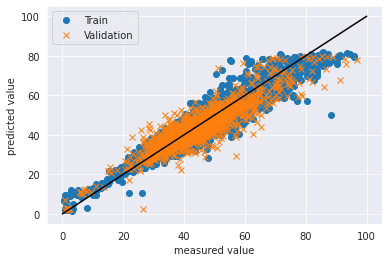

Test: s1i10-013645
Recording time: 2020-08-29 01:51:35.674639
Duriation: 0:14:36.213230
Layer Size: 64
-------------------------
Learning Rate: 0.001
Train Steps: 3000
Batch Size: 128
Dropout Ratio: 0.6
Lambda: 0.01
Beta: 0.02
Start #: 1
Iterations: 10
-------------------------
Architecture: b'| 2_layer_dnn | 3_layer_dnn | 4_layer_dnn | 5_layer_dnn | 6_layer_dnn | 6_layer_dnn | 6_layer_dnn | 7_layer_dnn |'
-------------------------
cv_r2: 0.8052669310587045
cv_mse: 26.334274291992188
cv_rmse: 5.131693121377406
-------------------------
train_r2: 0.9009591607149229
train_mse: 13.547719955444336
train_rmse: 3.680722749059529


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_che

INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps 3000 or save_checkpoints_secs None.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps 3000 or save_checkpoints_secs None.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:loss = 1.443887, step = 0


INFO:tensorflow:loss = 1.443887, step = 0


INFO:tensorflow:global_step/sec: 82.8046


INFO:tensorflow:global_step/sec: 82.8046


INFO:tensorflow:loss = 0.22566344, step = 100 (1.211 sec)


INFO:tensorflow:loss = 0.22566344, step = 100 (1.211 sec)


INFO:tensorflow:global_step/sec: 188.207


INFO:tensorflow:global_step/sec: 188.207


INFO:tensorflow:loss = 0.1975463, step = 200 (0.531 sec)


INFO:tensorflow:loss = 0.1975463, step = 200 (0.531 sec)


INFO:tensorflow:global_step/sec: 192.385


INFO:tensorflow:global_step/sec: 192.385


INFO:tensorflow:loss = 0.2569955, step = 300 (0.520 sec)


INFO:tensorflow:loss = 0.2569955, step = 300 (0.520 sec)


INFO:tensorflow:global_step/sec: 185.286


INFO:tensorflow:global_step/sec: 185.286


INFO:tensorflow:loss = 0.22865948, step = 400 (0.538 sec)


INFO:tensorflow:loss = 0.22865948, step = 400 (0.538 sec)


INFO:tensorflow:global_step/sec: 191.339


INFO:tensorflow:global_step/sec: 191.339


INFO:tensorflow:loss = 0.15861486, step = 500 (0.524 sec)


INFO:tensorflow:loss = 0.15861486, step = 500 (0.524 sec)


INFO:tensorflow:global_step/sec: 184.626


INFO:tensorflow:global_step/sec: 184.626


INFO:tensorflow:loss = 0.21081841, step = 600 (0.544 sec)


INFO:tensorflow:loss = 0.21081841, step = 600 (0.544 sec)


INFO:tensorflow:global_step/sec: 193.068


INFO:tensorflow:global_step/sec: 193.068


INFO:tensorflow:loss = 0.21906927, step = 700 (0.515 sec)


INFO:tensorflow:loss = 0.21906927, step = 700 (0.515 sec)


INFO:tensorflow:global_step/sec: 171.978


INFO:tensorflow:global_step/sec: 171.978


INFO:tensorflow:loss = 0.1954777, step = 800 (0.585 sec)


INFO:tensorflow:loss = 0.1954777, step = 800 (0.585 sec)


INFO:tensorflow:global_step/sec: 191.347


INFO:tensorflow:global_step/sec: 191.347


INFO:tensorflow:loss = 0.17955935, step = 900 (0.523 sec)


INFO:tensorflow:loss = 0.17955935, step = 900 (0.523 sec)


INFO:tensorflow:global_step/sec: 188.954


INFO:tensorflow:global_step/sec: 188.954


INFO:tensorflow:loss = 0.13189489, step = 1000 (0.530 sec)


INFO:tensorflow:loss = 0.13189489, step = 1000 (0.530 sec)


INFO:tensorflow:global_step/sec: 188.558


INFO:tensorflow:global_step/sec: 188.558


INFO:tensorflow:loss = 0.17990164, step = 1100 (0.527 sec)


INFO:tensorflow:loss = 0.17990164, step = 1100 (0.527 sec)


INFO:tensorflow:global_step/sec: 189.877


INFO:tensorflow:global_step/sec: 189.877


INFO:tensorflow:loss = 0.1976824, step = 1200 (0.527 sec)


INFO:tensorflow:loss = 0.1976824, step = 1200 (0.527 sec)


INFO:tensorflow:global_step/sec: 189.732


INFO:tensorflow:global_step/sec: 189.732


INFO:tensorflow:loss = 0.15341705, step = 1300 (0.529 sec)


INFO:tensorflow:loss = 0.15341705, step = 1300 (0.529 sec)


INFO:tensorflow:global_step/sec: 189.699


INFO:tensorflow:global_step/sec: 189.699


INFO:tensorflow:loss = 0.14214675, step = 1400 (0.526 sec)


INFO:tensorflow:loss = 0.14214675, step = 1400 (0.526 sec)


INFO:tensorflow:global_step/sec: 185.789


INFO:tensorflow:global_step/sec: 185.789


INFO:tensorflow:loss = 0.14513645, step = 1500 (0.539 sec)


INFO:tensorflow:loss = 0.14513645, step = 1500 (0.539 sec)


INFO:tensorflow:global_step/sec: 191.849


INFO:tensorflow:global_step/sec: 191.849


INFO:tensorflow:loss = 0.19364318, step = 1600 (0.521 sec)


INFO:tensorflow:loss = 0.19364318, step = 1600 (0.521 sec)


INFO:tensorflow:global_step/sec: 188.571


INFO:tensorflow:global_step/sec: 188.571


INFO:tensorflow:loss = 0.19661435, step = 1700 (0.529 sec)


INFO:tensorflow:loss = 0.19661435, step = 1700 (0.529 sec)


INFO:tensorflow:global_step/sec: 169.392


INFO:tensorflow:global_step/sec: 169.392


INFO:tensorflow:loss = 0.15544474, step = 1800 (0.592 sec)


INFO:tensorflow:loss = 0.15544474, step = 1800 (0.592 sec)


INFO:tensorflow:global_step/sec: 191.05


INFO:tensorflow:global_step/sec: 191.05


INFO:tensorflow:loss = 0.1219357, step = 1900 (0.524 sec)


INFO:tensorflow:loss = 0.1219357, step = 1900 (0.524 sec)


INFO:tensorflow:global_step/sec: 182.976


INFO:tensorflow:global_step/sec: 182.976


INFO:tensorflow:loss = 0.112767816, step = 2000 (0.546 sec)


INFO:tensorflow:loss = 0.112767816, step = 2000 (0.546 sec)


INFO:tensorflow:global_step/sec: 186.817


INFO:tensorflow:global_step/sec: 186.817


INFO:tensorflow:loss = 0.1829567, step = 2100 (0.535 sec)


INFO:tensorflow:loss = 0.1829567, step = 2100 (0.535 sec)


INFO:tensorflow:global_step/sec: 187.343


INFO:tensorflow:global_step/sec: 187.343


INFO:tensorflow:loss = 0.18835196, step = 2200 (0.536 sec)


INFO:tensorflow:loss = 0.18835196, step = 2200 (0.536 sec)


INFO:tensorflow:global_step/sec: 184.731


INFO:tensorflow:global_step/sec: 184.731


INFO:tensorflow:loss = 0.20053464, step = 2300 (0.539 sec)


INFO:tensorflow:loss = 0.20053464, step = 2300 (0.539 sec)


INFO:tensorflow:global_step/sec: 193.819


INFO:tensorflow:global_step/sec: 193.819


INFO:tensorflow:loss = 0.120334506, step = 2400 (0.515 sec)


INFO:tensorflow:loss = 0.120334506, step = 2400 (0.515 sec)


INFO:tensorflow:global_step/sec: 183.415


INFO:tensorflow:global_step/sec: 183.415


INFO:tensorflow:loss = 0.1695587, step = 2500 (0.544 sec)


INFO:tensorflow:loss = 0.1695587, step = 2500 (0.544 sec)


INFO:tensorflow:global_step/sec: 193.636


INFO:tensorflow:global_step/sec: 193.636


INFO:tensorflow:loss = 0.16996807, step = 2600 (0.516 sec)


INFO:tensorflow:loss = 0.16996807, step = 2600 (0.516 sec)


INFO:tensorflow:global_step/sec: 182.738


INFO:tensorflow:global_step/sec: 182.738


INFO:tensorflow:loss = 0.14282253, step = 2700 (0.552 sec)


INFO:tensorflow:loss = 0.14282253, step = 2700 (0.552 sec)


INFO:tensorflow:global_step/sec: 167.678


INFO:tensorflow:global_step/sec: 167.678


INFO:tensorflow:loss = 0.13353747, step = 2800 (0.593 sec)


INFO:tensorflow:loss = 0.13353747, step = 2800 (0.593 sec)


INFO:tensorflow:global_step/sec: 189.762


INFO:tensorflow:global_step/sec: 189.762


INFO:tensorflow:loss = 0.14855406, step = 2900 (0.527 sec)


INFO:tensorflow:loss = 0.14855406, step = 2900 (0.527 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3000...


INFO:tensorflow:Saving checkpoints for 3000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:model.ckpt-3000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-3000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-3000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-3000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T01:51:58Z


INFO:tensorflow:Starting evaluation at 2020-08-29T01:51:58Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-3000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-3000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 1.37199s


INFO:tensorflow:Inference Time : 1.37199s


INFO:tensorflow:Finished evaluation at 2020-08-29-01:51:59


INFO:tensorflow:Finished evaluation at 2020-08-29-01:51:59


INFO:tensorflow:Saving dict for global step 3000: average_loss = 0.20818616, best_ensemble_index_0 = 1, global_step = 3000, iteration = 0, label/mean = -0.0007050394, loss = 0.20861046, prediction/mean = -0.05681093


INFO:tensorflow:Saving dict for global step 3000: average_loss = 0.20818616, best_ensemble_index_0 = 1, global_step = 3000, iteration = 0, label/mean = -0.0007050394, loss = 0.20861046, prediction/mean = -0.05681093


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-3000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-3000


INFO:tensorflow:Loss for final step: 0.12569115.


INFO:tensorflow:Loss for final step: 0.12569115.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-3000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-3000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598665921269', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598665921269', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598665921269/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598665921269/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-3000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-3000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3001...


INFO:tensorflow:Saving checkpoints for 3001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598665921269/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598665921269/model.ckpt.


INFO:tensorflow:model.ckpt-3001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-3001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3001...


INFO:tensorflow:loss = 0.12850255, step = 3000


INFO:tensorflow:loss = 0.12850255, step = 3000


INFO:tensorflow:Loss for final step: 0.12850255.


INFO:tensorflow:Loss for final step: 0.12850255.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-1


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-1


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3000...


INFO:tensorflow:Saving checkpoints for 3000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:model.ckpt-3000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-3000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3000...


INFO:tensorflow:loss = 0.12850255, step = 3000


INFO:tensorflow:loss = 0.12850255, step = 3000


INFO:tensorflow:global_step/sec: 58.1358


INFO:tensorflow:global_step/sec: 58.1358


INFO:tensorflow:loss = 0.11449303, step = 3100 (1.727 sec)


INFO:tensorflow:loss = 0.11449303, step = 3100 (1.727 sec)


INFO:tensorflow:global_step/sec: 144.547


INFO:tensorflow:global_step/sec: 144.547


INFO:tensorflow:loss = 0.14840166, step = 3200 (0.690 sec)


INFO:tensorflow:loss = 0.14840166, step = 3200 (0.690 sec)


INFO:tensorflow:global_step/sec: 144.568


INFO:tensorflow:global_step/sec: 144.568


INFO:tensorflow:loss = 0.16791764, step = 3300 (0.691 sec)


INFO:tensorflow:loss = 0.16791764, step = 3300 (0.691 sec)


INFO:tensorflow:global_step/sec: 149.503


INFO:tensorflow:global_step/sec: 149.503


INFO:tensorflow:loss = 0.15414076, step = 3400 (0.667 sec)


INFO:tensorflow:loss = 0.15414076, step = 3400 (0.667 sec)


INFO:tensorflow:global_step/sec: 149.284


INFO:tensorflow:global_step/sec: 149.284


INFO:tensorflow:loss = 0.11194762, step = 3500 (0.670 sec)


INFO:tensorflow:loss = 0.11194762, step = 3500 (0.670 sec)


INFO:tensorflow:global_step/sec: 136.919


INFO:tensorflow:global_step/sec: 136.919


INFO:tensorflow:loss = 0.14527524, step = 3600 (0.732 sec)


INFO:tensorflow:loss = 0.14527524, step = 3600 (0.732 sec)


INFO:tensorflow:global_step/sec: 126.316


INFO:tensorflow:global_step/sec: 126.316


INFO:tensorflow:loss = 0.16172405, step = 3700 (0.793 sec)


INFO:tensorflow:loss = 0.16172405, step = 3700 (0.793 sec)


INFO:tensorflow:global_step/sec: 149.171


INFO:tensorflow:global_step/sec: 149.171


INFO:tensorflow:loss = 0.16201356, step = 3800 (0.670 sec)


INFO:tensorflow:loss = 0.16201356, step = 3800 (0.670 sec)


INFO:tensorflow:global_step/sec: 146.694


INFO:tensorflow:global_step/sec: 146.694


INFO:tensorflow:loss = 0.13666496, step = 3900 (0.682 sec)


INFO:tensorflow:loss = 0.13666496, step = 3900 (0.682 sec)


INFO:tensorflow:global_step/sec: 146.643


INFO:tensorflow:global_step/sec: 146.643


INFO:tensorflow:loss = 0.11750878, step = 4000 (0.683 sec)


INFO:tensorflow:loss = 0.11750878, step = 4000 (0.683 sec)


INFO:tensorflow:global_step/sec: 145.726


INFO:tensorflow:global_step/sec: 145.726


INFO:tensorflow:loss = 0.13170475, step = 4100 (0.685 sec)


INFO:tensorflow:loss = 0.13170475, step = 4100 (0.685 sec)


INFO:tensorflow:global_step/sec: 147.246


INFO:tensorflow:global_step/sec: 147.246


INFO:tensorflow:loss = 0.13477713, step = 4200 (0.680 sec)


INFO:tensorflow:loss = 0.13477713, step = 4200 (0.680 sec)


INFO:tensorflow:global_step/sec: 149.224


INFO:tensorflow:global_step/sec: 149.224


INFO:tensorflow:loss = 0.14234811, step = 4300 (0.669 sec)


INFO:tensorflow:loss = 0.14234811, step = 4300 (0.669 sec)


INFO:tensorflow:global_step/sec: 130.227


INFO:tensorflow:global_step/sec: 130.227


INFO:tensorflow:loss = 0.123250835, step = 4400 (0.772 sec)


INFO:tensorflow:loss = 0.123250835, step = 4400 (0.772 sec)


INFO:tensorflow:global_step/sec: 147.73


INFO:tensorflow:global_step/sec: 147.73


INFO:tensorflow:loss = 0.10756713, step = 4500 (0.671 sec)


INFO:tensorflow:loss = 0.10756713, step = 4500 (0.671 sec)


INFO:tensorflow:global_step/sec: 146.244


INFO:tensorflow:global_step/sec: 146.244


INFO:tensorflow:loss = 0.1554859, step = 4600 (0.686 sec)


INFO:tensorflow:loss = 0.1554859, step = 4600 (0.686 sec)


INFO:tensorflow:global_step/sec: 151.832


INFO:tensorflow:global_step/sec: 151.832


INFO:tensorflow:loss = 0.17152041, step = 4700 (0.660 sec)


INFO:tensorflow:loss = 0.17152041, step = 4700 (0.660 sec)


INFO:tensorflow:global_step/sec: 147.965


INFO:tensorflow:global_step/sec: 147.965


INFO:tensorflow:loss = 0.13333294, step = 4800 (0.673 sec)


INFO:tensorflow:loss = 0.13333294, step = 4800 (0.673 sec)


INFO:tensorflow:global_step/sec: 148.008


INFO:tensorflow:global_step/sec: 148.008


INFO:tensorflow:loss = 0.12269412, step = 4900 (0.676 sec)


INFO:tensorflow:loss = 0.12269412, step = 4900 (0.676 sec)


INFO:tensorflow:global_step/sec: 152.699


INFO:tensorflow:global_step/sec: 152.699


INFO:tensorflow:loss = 0.09162471, step = 5000 (0.654 sec)


INFO:tensorflow:loss = 0.09162471, step = 5000 (0.654 sec)


INFO:tensorflow:global_step/sec: 146.872


INFO:tensorflow:global_step/sec: 146.872


INFO:tensorflow:loss = 0.14280427, step = 5100 (0.683 sec)


INFO:tensorflow:loss = 0.14280427, step = 5100 (0.683 sec)


INFO:tensorflow:global_step/sec: 135.731


INFO:tensorflow:global_step/sec: 135.731


INFO:tensorflow:loss = 0.16319132, step = 5200 (0.738 sec)


INFO:tensorflow:loss = 0.16319132, step = 5200 (0.738 sec)


INFO:tensorflow:global_step/sec: 145.399


INFO:tensorflow:global_step/sec: 145.399


INFO:tensorflow:loss = 0.18073653, step = 5300 (0.684 sec)


INFO:tensorflow:loss = 0.18073653, step = 5300 (0.684 sec)


INFO:tensorflow:global_step/sec: 148.959


INFO:tensorflow:global_step/sec: 148.959


INFO:tensorflow:loss = 0.12719658, step = 5400 (0.676 sec)


INFO:tensorflow:loss = 0.12719658, step = 5400 (0.676 sec)


INFO:tensorflow:global_step/sec: 139.914


INFO:tensorflow:global_step/sec: 139.914


INFO:tensorflow:loss = 0.12723756, step = 5500 (0.710 sec)


INFO:tensorflow:loss = 0.12723756, step = 5500 (0.710 sec)


INFO:tensorflow:global_step/sec: 145.847


INFO:tensorflow:global_step/sec: 145.847


INFO:tensorflow:loss = 0.16107175, step = 5600 (0.686 sec)


INFO:tensorflow:loss = 0.16107175, step = 5600 (0.686 sec)


INFO:tensorflow:global_step/sec: 150.24


INFO:tensorflow:global_step/sec: 150.24


INFO:tensorflow:loss = 0.1266726, step = 5700 (0.667 sec)


INFO:tensorflow:loss = 0.1266726, step = 5700 (0.667 sec)


INFO:tensorflow:global_step/sec: 148.51


INFO:tensorflow:global_step/sec: 148.51


INFO:tensorflow:loss = 0.14770165, step = 5800 (0.673 sec)


INFO:tensorflow:loss = 0.14770165, step = 5800 (0.673 sec)


INFO:tensorflow:global_step/sec: 136.63


INFO:tensorflow:global_step/sec: 136.63


INFO:tensorflow:loss = 0.13712558, step = 5900 (0.730 sec)


INFO:tensorflow:loss = 0.13712558, step = 5900 (0.730 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6000...


INFO:tensorflow:Saving checkpoints for 6000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:Saving checkpoints for 6000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:model.ckpt-6000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-6000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-6000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-6000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T01:52:40Z


INFO:tensorflow:Starting evaluation at 2020-08-29T01:52:40Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-6000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-6000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 2.19482s


INFO:tensorflow:Inference Time : 2.19482s


INFO:tensorflow:Finished evaluation at 2020-08-29-01:52:42


INFO:tensorflow:Finished evaluation at 2020-08-29-01:52:42


INFO:tensorflow:Saving dict for global step 6000: average_loss = 0.20265946, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, global_step = 6000, iteration = 1, label/mean = -0.0007050394, loss = 0.20305881, prediction/mean = -0.0647211


INFO:tensorflow:Saving dict for global step 6000: average_loss = 0.20265946, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, global_step = 6000, iteration = 1, label/mean = -0.0007050394, loss = 0.20305881, prediction/mean = -0.0647211


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-6000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-6000


INFO:tensorflow:Loss for final step: 0.09830958.


INFO:tensorflow:Loss for final step: 0.09830958.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-6000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-6000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598665964716', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598665964716', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598665964716/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598665964716/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-6000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-6000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-2 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-2 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6001...


INFO:tensorflow:Saving checkpoints for 6001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598665964716/model.ckpt.


INFO:tensorflow:Saving checkpoints for 6001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598665964716/model.ckpt.


INFO:tensorflow:model.ckpt-6001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-6001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6001...


INFO:tensorflow:loss = 0.11720079, step = 6001


INFO:tensorflow:loss = 0.11720079, step = 6001


INFO:tensorflow:Loss for final step: 0.11720079.


INFO:tensorflow:Loss for final step: 0.11720079.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-2


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-2


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6000...


INFO:tensorflow:Saving checkpoints for 6000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:Saving checkpoints for 6000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:model.ckpt-6000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-6000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6000...


INFO:tensorflow:loss = 0.11720079, step = 6000


INFO:tensorflow:loss = 0.11720079, step = 6000


INFO:tensorflow:global_step/sec: 46.563


INFO:tensorflow:global_step/sec: 46.563


INFO:tensorflow:loss = 0.10166222, step = 6100 (2.155 sec)


INFO:tensorflow:loss = 0.10166222, step = 6100 (2.155 sec)


INFO:tensorflow:global_step/sec: 127.072


INFO:tensorflow:global_step/sec: 127.072


INFO:tensorflow:loss = 0.13329819, step = 6200 (0.784 sec)


INFO:tensorflow:loss = 0.13329819, step = 6200 (0.784 sec)


INFO:tensorflow:global_step/sec: 125.509


INFO:tensorflow:global_step/sec: 125.509


INFO:tensorflow:loss = 0.15151557, step = 6300 (0.796 sec)


INFO:tensorflow:loss = 0.15151557, step = 6300 (0.796 sec)


INFO:tensorflow:global_step/sec: 126.458


INFO:tensorflow:global_step/sec: 126.458


INFO:tensorflow:loss = 0.14353368, step = 6400 (0.792 sec)


INFO:tensorflow:loss = 0.14353368, step = 6400 (0.792 sec)


INFO:tensorflow:global_step/sec: 127.379


INFO:tensorflow:global_step/sec: 127.379


INFO:tensorflow:loss = 0.10181866, step = 6500 (0.796 sec)


INFO:tensorflow:loss = 0.10181866, step = 6500 (0.796 sec)


INFO:tensorflow:global_step/sec: 124.08


INFO:tensorflow:global_step/sec: 124.08


INFO:tensorflow:loss = 0.13439688, step = 6600 (0.796 sec)


INFO:tensorflow:loss = 0.13439688, step = 6600 (0.796 sec)


INFO:tensorflow:global_step/sec: 116.48


INFO:tensorflow:global_step/sec: 116.48


INFO:tensorflow:loss = 0.14559726, step = 6700 (0.858 sec)


INFO:tensorflow:loss = 0.14559726, step = 6700 (0.858 sec)


INFO:tensorflow:global_step/sec: 124.386


INFO:tensorflow:global_step/sec: 124.386


INFO:tensorflow:loss = 0.15233353, step = 6800 (0.806 sec)


INFO:tensorflow:loss = 0.15233353, step = 6800 (0.806 sec)


INFO:tensorflow:global_step/sec: 127.69


INFO:tensorflow:global_step/sec: 127.69


INFO:tensorflow:loss = 0.125249, step = 6900 (0.783 sec)


INFO:tensorflow:loss = 0.125249, step = 6900 (0.783 sec)


INFO:tensorflow:global_step/sec: 127.805


INFO:tensorflow:global_step/sec: 127.805


INFO:tensorflow:loss = 0.1070867, step = 7000 (0.780 sec)


INFO:tensorflow:loss = 0.1070867, step = 7000 (0.780 sec)


INFO:tensorflow:global_step/sec: 126.357


INFO:tensorflow:global_step/sec: 126.357


INFO:tensorflow:loss = 0.113986045, step = 7100 (0.790 sec)


INFO:tensorflow:loss = 0.113986045, step = 7100 (0.790 sec)


INFO:tensorflow:global_step/sec: 128.026


INFO:tensorflow:global_step/sec: 128.026


INFO:tensorflow:loss = 0.123402715, step = 7200 (0.782 sec)


INFO:tensorflow:loss = 0.123402715, step = 7200 (0.782 sec)


INFO:tensorflow:global_step/sec: 117.158


INFO:tensorflow:global_step/sec: 117.158


INFO:tensorflow:loss = 0.13300331, step = 7300 (0.854 sec)


INFO:tensorflow:loss = 0.13300331, step = 7300 (0.854 sec)


INFO:tensorflow:global_step/sec: 125.229


INFO:tensorflow:global_step/sec: 125.229


INFO:tensorflow:loss = 0.11507541, step = 7400 (0.802 sec)


INFO:tensorflow:loss = 0.11507541, step = 7400 (0.802 sec)


INFO:tensorflow:global_step/sec: 126.132


INFO:tensorflow:global_step/sec: 126.132


INFO:tensorflow:loss = 0.0975263, step = 7500 (0.791 sec)


INFO:tensorflow:loss = 0.0975263, step = 7500 (0.791 sec)


INFO:tensorflow:global_step/sec: 127.932


INFO:tensorflow:global_step/sec: 127.932


INFO:tensorflow:loss = 0.13893995, step = 7600 (0.781 sec)


INFO:tensorflow:loss = 0.13893995, step = 7600 (0.781 sec)


INFO:tensorflow:global_step/sec: 129.46


INFO:tensorflow:global_step/sec: 129.46


INFO:tensorflow:loss = 0.15794362, step = 7700 (0.773 sec)


INFO:tensorflow:loss = 0.15794362, step = 7700 (0.773 sec)


INFO:tensorflow:global_step/sec: 124.608


INFO:tensorflow:global_step/sec: 124.608


INFO:tensorflow:loss = 0.12266309, step = 7800 (0.801 sec)


INFO:tensorflow:loss = 0.12266309, step = 7800 (0.801 sec)


INFO:tensorflow:global_step/sec: 127.485


INFO:tensorflow:global_step/sec: 127.485


INFO:tensorflow:loss = 0.11326912, step = 7900 (0.787 sec)


INFO:tensorflow:loss = 0.11326912, step = 7900 (0.787 sec)


INFO:tensorflow:global_step/sec: 119.439


INFO:tensorflow:global_step/sec: 119.439


INFO:tensorflow:loss = 0.08395235, step = 8000 (0.834 sec)


INFO:tensorflow:loss = 0.08395235, step = 8000 (0.834 sec)


INFO:tensorflow:global_step/sec: 124.589


INFO:tensorflow:global_step/sec: 124.589


INFO:tensorflow:loss = 0.12987562, step = 8100 (0.803 sec)


INFO:tensorflow:loss = 0.12987562, step = 8100 (0.803 sec)


INFO:tensorflow:global_step/sec: 128.51


INFO:tensorflow:global_step/sec: 128.51


INFO:tensorflow:loss = 0.13967949, step = 8200 (0.778 sec)


INFO:tensorflow:loss = 0.13967949, step = 8200 (0.778 sec)


INFO:tensorflow:global_step/sec: 125.181


INFO:tensorflow:global_step/sec: 125.181


INFO:tensorflow:loss = 0.15844697, step = 8300 (0.799 sec)


INFO:tensorflow:loss = 0.15844697, step = 8300 (0.799 sec)


INFO:tensorflow:global_step/sec: 126.045


INFO:tensorflow:global_step/sec: 126.045


INFO:tensorflow:loss = 0.11342834, step = 8400 (0.795 sec)


INFO:tensorflow:loss = 0.11342834, step = 8400 (0.795 sec)


INFO:tensorflow:global_step/sec: 128.574


INFO:tensorflow:global_step/sec: 128.574


INFO:tensorflow:loss = 0.12401731, step = 8500 (0.777 sec)


INFO:tensorflow:loss = 0.12401731, step = 8500 (0.777 sec)


INFO:tensorflow:global_step/sec: 116.688


INFO:tensorflow:global_step/sec: 116.688


INFO:tensorflow:loss = 0.15823394, step = 8600 (0.858 sec)


INFO:tensorflow:loss = 0.15823394, step = 8600 (0.858 sec)


INFO:tensorflow:global_step/sec: 123.603


INFO:tensorflow:global_step/sec: 123.603


INFO:tensorflow:loss = 0.12257449, step = 8700 (0.810 sec)


INFO:tensorflow:loss = 0.12257449, step = 8700 (0.810 sec)


INFO:tensorflow:global_step/sec: 125.825


INFO:tensorflow:global_step/sec: 125.825


INFO:tensorflow:loss = 0.13279776, step = 8800 (0.792 sec)


INFO:tensorflow:loss = 0.13279776, step = 8800 (0.792 sec)


INFO:tensorflow:global_step/sec: 127.31


INFO:tensorflow:global_step/sec: 127.31


INFO:tensorflow:loss = 0.139491, step = 8900 (0.786 sec)


INFO:tensorflow:loss = 0.139491, step = 8900 (0.786 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9000...


INFO:tensorflow:Saving checkpoints for 9000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:Saving checkpoints for 9000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:model.ckpt-9000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-9000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-9000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-9000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T01:53:31Z


INFO:tensorflow:Starting evaluation at 2020-08-29T01:53:31Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-9000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-9000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 3.01551s


INFO:tensorflow:Inference Time : 3.01551s


INFO:tensorflow:Finished evaluation at 2020-08-29-01:53:34


INFO:tensorflow:Finished evaluation at 2020-08-29-01:53:34


INFO:tensorflow:Saving dict for global step 9000: average_loss = 0.20164368, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, global_step = 9000, iteration = 2, label/mean = -0.0007050394, loss = 0.20192793, prediction/mean = -0.07319032


INFO:tensorflow:Saving dict for global step 9000: average_loss = 0.20164368, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, global_step = 9000, iteration = 2, label/mean = -0.0007050394, loss = 0.20192793, prediction/mean = -0.07319032


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-9000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-9000


INFO:tensorflow:Loss for final step: 0.086436585.


INFO:tensorflow:Loss for final step: 0.086436585.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-9000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-9000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666017803', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666017803', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666017803/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666017803/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-9000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-9000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-3 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-3 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9001...


INFO:tensorflow:Saving checkpoints for 9001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666017803/model.ckpt.


INFO:tensorflow:Saving checkpoints for 9001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666017803/model.ckpt.


INFO:tensorflow:model.ckpt-9001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-9001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9001...


INFO:tensorflow:loss = 0.10568507, step = 9001


INFO:tensorflow:loss = 0.10568507, step = 9001


INFO:tensorflow:Loss for final step: 0.10568507.


INFO:tensorflow:Loss for final step: 0.10568507.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-3


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-3


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9000...


INFO:tensorflow:Saving checkpoints for 9000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:Saving checkpoints for 9000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:model.ckpt-9000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-9000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9000...


INFO:tensorflow:loss = 0.10568507, step = 9000


INFO:tensorflow:loss = 0.10568507, step = 9000


INFO:tensorflow:global_step/sec: 40.3683


INFO:tensorflow:global_step/sec: 40.3683


INFO:tensorflow:loss = 0.09163803, step = 9100 (2.480 sec)


INFO:tensorflow:loss = 0.09163803, step = 9100 (2.480 sec)


INFO:tensorflow:global_step/sec: 108.474


INFO:tensorflow:global_step/sec: 108.474


INFO:tensorflow:loss = 0.11777256, step = 9200 (0.922 sec)


INFO:tensorflow:loss = 0.11777256, step = 9200 (0.922 sec)


INFO:tensorflow:global_step/sec: 110.651


INFO:tensorflow:global_step/sec: 110.651


INFO:tensorflow:loss = 0.13213032, step = 9300 (0.904 sec)


INFO:tensorflow:loss = 0.13213032, step = 9300 (0.904 sec)


INFO:tensorflow:global_step/sec: 108.978


INFO:tensorflow:global_step/sec: 108.978


INFO:tensorflow:loss = 0.13244222, step = 9400 (0.916 sec)


INFO:tensorflow:loss = 0.13244222, step = 9400 (0.916 sec)


INFO:tensorflow:global_step/sec: 99.2645


INFO:tensorflow:global_step/sec: 99.2645


INFO:tensorflow:loss = 0.09013242, step = 9500 (1.010 sec)


INFO:tensorflow:loss = 0.09013242, step = 9500 (1.010 sec)


INFO:tensorflow:global_step/sec: 105.798


INFO:tensorflow:global_step/sec: 105.798


INFO:tensorflow:loss = 0.12748463, step = 9600 (0.944 sec)


INFO:tensorflow:loss = 0.12748463, step = 9600 (0.944 sec)


INFO:tensorflow:global_step/sec: 105.708


INFO:tensorflow:global_step/sec: 105.708


INFO:tensorflow:loss = 0.12714627, step = 9700 (0.948 sec)


INFO:tensorflow:loss = 0.12714627, step = 9700 (0.948 sec)


INFO:tensorflow:global_step/sec: 106.749


INFO:tensorflow:global_step/sec: 106.749


INFO:tensorflow:loss = 0.14311272, step = 9800 (0.936 sec)


INFO:tensorflow:loss = 0.14311272, step = 9800 (0.936 sec)


INFO:tensorflow:global_step/sec: 106.651


INFO:tensorflow:global_step/sec: 106.651


INFO:tensorflow:loss = 0.110323265, step = 9900 (0.935 sec)


INFO:tensorflow:loss = 0.110323265, step = 9900 (0.935 sec)


INFO:tensorflow:global_step/sec: 104.156


INFO:tensorflow:global_step/sec: 104.156


INFO:tensorflow:loss = 0.09849278, step = 10000 (0.964 sec)


INFO:tensorflow:loss = 0.09849278, step = 10000 (0.964 sec)


INFO:tensorflow:global_step/sec: 105.618


INFO:tensorflow:global_step/sec: 105.618


INFO:tensorflow:loss = 0.09622057, step = 10100 (0.945 sec)


INFO:tensorflow:loss = 0.09622057, step = 10100 (0.945 sec)


INFO:tensorflow:global_step/sec: 109.503


INFO:tensorflow:global_step/sec: 109.503


INFO:tensorflow:loss = 0.11004852, step = 10200 (0.914 sec)


INFO:tensorflow:loss = 0.11004852, step = 10200 (0.914 sec)


INFO:tensorflow:global_step/sec: 110.015


INFO:tensorflow:global_step/sec: 110.015


INFO:tensorflow:loss = 0.11850983, step = 10300 (0.905 sec)


INFO:tensorflow:loss = 0.11850983, step = 10300 (0.905 sec)


INFO:tensorflow:global_step/sec: 110.765


INFO:tensorflow:global_step/sec: 110.765


INFO:tensorflow:loss = 0.09706093, step = 10400 (0.908 sec)


INFO:tensorflow:loss = 0.09706093, step = 10400 (0.908 sec)


INFO:tensorflow:global_step/sec: 110.393


INFO:tensorflow:global_step/sec: 110.393


INFO:tensorflow:loss = 0.090457834, step = 10500 (0.904 sec)


INFO:tensorflow:loss = 0.090457834, step = 10500 (0.904 sec)


INFO:tensorflow:global_step/sec: 103.28


INFO:tensorflow:global_step/sec: 103.28


INFO:tensorflow:loss = 0.12605551, step = 10600 (0.968 sec)


INFO:tensorflow:loss = 0.12605551, step = 10600 (0.968 sec)


INFO:tensorflow:global_step/sec: 107.52


INFO:tensorflow:global_step/sec: 107.52


INFO:tensorflow:loss = 0.13978681, step = 10700 (0.929 sec)


INFO:tensorflow:loss = 0.13978681, step = 10700 (0.929 sec)


INFO:tensorflow:global_step/sec: 110.951


INFO:tensorflow:global_step/sec: 110.951


INFO:tensorflow:loss = 0.114190005, step = 10800 (0.902 sec)


INFO:tensorflow:loss = 0.114190005, step = 10800 (0.902 sec)


INFO:tensorflow:global_step/sec: 109.092


INFO:tensorflow:global_step/sec: 109.092


INFO:tensorflow:loss = 0.1033943, step = 10900 (0.916 sec)


INFO:tensorflow:loss = 0.1033943, step = 10900 (0.916 sec)


INFO:tensorflow:global_step/sec: 108.576


INFO:tensorflow:global_step/sec: 108.576


INFO:tensorflow:loss = 0.07335652, step = 11000 (0.921 sec)


INFO:tensorflow:loss = 0.07335652, step = 11000 (0.921 sec)


INFO:tensorflow:global_step/sec: 108.447


INFO:tensorflow:global_step/sec: 108.447


INFO:tensorflow:loss = 0.114877015, step = 11100 (0.923 sec)


INFO:tensorflow:loss = 0.114877015, step = 11100 (0.923 sec)


INFO:tensorflow:global_step/sec: 98.7435


INFO:tensorflow:global_step/sec: 98.7435


INFO:tensorflow:loss = 0.118874, step = 11200 (1.012 sec)


INFO:tensorflow:loss = 0.118874, step = 11200 (1.012 sec)


INFO:tensorflow:global_step/sec: 110.194


INFO:tensorflow:global_step/sec: 110.194


INFO:tensorflow:loss = 0.13467985, step = 11300 (0.909 sec)


INFO:tensorflow:loss = 0.13467985, step = 11300 (0.909 sec)


INFO:tensorflow:global_step/sec: 106.697


INFO:tensorflow:global_step/sec: 106.697


INFO:tensorflow:loss = 0.100861, step = 11400 (0.936 sec)


INFO:tensorflow:loss = 0.100861, step = 11400 (0.936 sec)


INFO:tensorflow:global_step/sec: 107.339


INFO:tensorflow:global_step/sec: 107.339


INFO:tensorflow:loss = 0.111056894, step = 11500 (0.932 sec)


INFO:tensorflow:loss = 0.111056894, step = 11500 (0.932 sec)


INFO:tensorflow:global_step/sec: 108.037


INFO:tensorflow:global_step/sec: 108.037


INFO:tensorflow:loss = 0.14277211, step = 11600 (0.927 sec)


INFO:tensorflow:loss = 0.14277211, step = 11600 (0.927 sec)


INFO:tensorflow:global_step/sec: 99.9817


INFO:tensorflow:global_step/sec: 99.9817


INFO:tensorflow:loss = 0.10547773, step = 11700 (1.000 sec)


INFO:tensorflow:loss = 0.10547773, step = 11700 (1.000 sec)


INFO:tensorflow:global_step/sec: 109.459


INFO:tensorflow:global_step/sec: 109.459


INFO:tensorflow:loss = 0.116739474, step = 11800 (0.910 sec)


INFO:tensorflow:loss = 0.116739474, step = 11800 (0.910 sec)


INFO:tensorflow:global_step/sec: 108.621


INFO:tensorflow:global_step/sec: 108.621


INFO:tensorflow:loss = 0.12630089, step = 11900 (0.924 sec)


INFO:tensorflow:loss = 0.12630089, step = 11900 (0.924 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 12000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 12000...


INFO:tensorflow:Saving checkpoints for 12000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:Saving checkpoints for 12000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:model.ckpt-12000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-12000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 12000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 12000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-12000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-12000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T01:54:35Z


INFO:tensorflow:Starting evaluation at 2020-08-29T01:54:35Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-12000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-12000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 3.91870s


INFO:tensorflow:Inference Time : 3.91870s


INFO:tensorflow:Finished evaluation at 2020-08-29-01:54:39


INFO:tensorflow:Finished evaluation at 2020-08-29-01:54:39


INFO:tensorflow:Saving dict for global step 12000: average_loss = 0.19869837, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, global_step = 12000, iteration = 3, label/mean = -0.0007050394, loss = 0.19881845, prediction/mean = -0.080074176


INFO:tensorflow:Saving dict for global step 12000: average_loss = 0.19869837, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, global_step = 12000, iteration = 3, label/mean = -0.0007050394, loss = 0.19881845, prediction/mean = -0.080074176


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 12000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-12000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 12000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-12000


INFO:tensorflow:Loss for final step: 0.0765056.


INFO:tensorflow:Loss for final step: 0.0765056.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-12000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-12000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666084220', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666084220', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666084220/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666084220/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-12000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-12000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-4 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-4 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 12001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 12001...


INFO:tensorflow:Saving checkpoints for 12001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666084220/model.ckpt.


INFO:tensorflow:Saving checkpoints for 12001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666084220/model.ckpt.


INFO:tensorflow:model.ckpt-12001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-12001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 12001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 12001...


INFO:tensorflow:loss = 0.096716315, step = 12000


INFO:tensorflow:loss = 0.096716315, step = 12000


INFO:tensorflow:Loss for final step: 0.096716315.


INFO:tensorflow:Loss for final step: 0.096716315.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-4


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-4


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 12000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 12000...


INFO:tensorflow:Saving checkpoints for 12000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:Saving checkpoints for 12000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:model.ckpt-12000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-12000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 12000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 12000...


INFO:tensorflow:loss = 0.096716315, step = 12000


INFO:tensorflow:loss = 0.096716315, step = 12000


INFO:tensorflow:global_step/sec: 35.8309


INFO:tensorflow:global_step/sec: 35.8309


INFO:tensorflow:loss = 0.08829582, step = 12100 (2.796 sec)


INFO:tensorflow:loss = 0.08829582, step = 12100 (2.796 sec)


INFO:tensorflow:global_step/sec: 99.1586


INFO:tensorflow:global_step/sec: 99.1586


INFO:tensorflow:loss = 0.11003725, step = 12200 (1.009 sec)


INFO:tensorflow:loss = 0.11003725, step = 12200 (1.009 sec)


INFO:tensorflow:global_step/sec: 97.0894


INFO:tensorflow:global_step/sec: 97.0894


INFO:tensorflow:loss = 0.1217814, step = 12300 (1.029 sec)


INFO:tensorflow:loss = 0.1217814, step = 12300 (1.029 sec)


INFO:tensorflow:global_step/sec: 99.5115


INFO:tensorflow:global_step/sec: 99.5115


INFO:tensorflow:loss = 0.12569262, step = 12400 (1.003 sec)


INFO:tensorflow:loss = 0.12569262, step = 12400 (1.003 sec)


INFO:tensorflow:global_step/sec: 98.671


INFO:tensorflow:global_step/sec: 98.671


INFO:tensorflow:loss = 0.0804054, step = 12500 (1.013 sec)


INFO:tensorflow:loss = 0.0804054, step = 12500 (1.013 sec)


INFO:tensorflow:global_step/sec: 91.3147


INFO:tensorflow:global_step/sec: 91.3147


INFO:tensorflow:loss = 0.11950247, step = 12600 (1.095 sec)


INFO:tensorflow:loss = 0.11950247, step = 12600 (1.095 sec)


INFO:tensorflow:global_step/sec: 98.5176


INFO:tensorflow:global_step/sec: 98.5176


INFO:tensorflow:loss = 0.112539664, step = 12700 (1.016 sec)


INFO:tensorflow:loss = 0.112539664, step = 12700 (1.016 sec)


INFO:tensorflow:global_step/sec: 99.3715


INFO:tensorflow:global_step/sec: 99.3715


INFO:tensorflow:loss = 0.13772132, step = 12800 (1.008 sec)


INFO:tensorflow:loss = 0.13772132, step = 12800 (1.008 sec)


INFO:tensorflow:global_step/sec: 99.0705


INFO:tensorflow:global_step/sec: 99.0705


INFO:tensorflow:loss = 0.100600526, step = 12900 (1.008 sec)


INFO:tensorflow:loss = 0.100600526, step = 12900 (1.008 sec)


INFO:tensorflow:global_step/sec: 100.481


INFO:tensorflow:global_step/sec: 100.481


INFO:tensorflow:loss = 0.09412688, step = 13000 (0.996 sec)


INFO:tensorflow:loss = 0.09412688, step = 13000 (0.996 sec)


INFO:tensorflow:global_step/sec: 91.7263


INFO:tensorflow:global_step/sec: 91.7263


INFO:tensorflow:loss = 0.08814808, step = 13100 (1.089 sec)


INFO:tensorflow:loss = 0.08814808, step = 13100 (1.089 sec)


INFO:tensorflow:global_step/sec: 100.528


INFO:tensorflow:global_step/sec: 100.528


INFO:tensorflow:loss = 0.0993276, step = 13200 (0.995 sec)


INFO:tensorflow:loss = 0.0993276, step = 13200 (0.995 sec)


INFO:tensorflow:global_step/sec: 99.1683


INFO:tensorflow:global_step/sec: 99.1683


INFO:tensorflow:loss = 0.11074259, step = 13300 (1.010 sec)


INFO:tensorflow:loss = 0.11074259, step = 13300 (1.010 sec)


INFO:tensorflow:global_step/sec: 99.7432


INFO:tensorflow:global_step/sec: 99.7432


INFO:tensorflow:loss = 0.08998844, step = 13400 (1.002 sec)


INFO:tensorflow:loss = 0.08998844, step = 13400 (1.002 sec)


INFO:tensorflow:global_step/sec: 99.9699


INFO:tensorflow:global_step/sec: 99.9699


INFO:tensorflow:loss = 0.08279213, step = 13500 (1.002 sec)


INFO:tensorflow:loss = 0.08279213, step = 13500 (1.002 sec)


INFO:tensorflow:global_step/sec: 95.1586


INFO:tensorflow:global_step/sec: 95.1586


INFO:tensorflow:loss = 0.11650546, step = 13600 (1.051 sec)


INFO:tensorflow:loss = 0.11650546, step = 13600 (1.051 sec)


INFO:tensorflow:global_step/sec: 100.043


INFO:tensorflow:global_step/sec: 100.043


INFO:tensorflow:loss = 0.12990108, step = 13700 (0.999 sec)


INFO:tensorflow:loss = 0.12990108, step = 13700 (0.999 sec)


INFO:tensorflow:global_step/sec: 99.5766


INFO:tensorflow:global_step/sec: 99.5766


INFO:tensorflow:loss = 0.10864963, step = 13800 (1.007 sec)


INFO:tensorflow:loss = 0.10864963, step = 13800 (1.007 sec)


INFO:tensorflow:global_step/sec: 98.8065


INFO:tensorflow:global_step/sec: 98.8065


INFO:tensorflow:loss = 0.09850249, step = 13900 (1.011 sec)


INFO:tensorflow:loss = 0.09850249, step = 13900 (1.011 sec)


INFO:tensorflow:global_step/sec: 99.7726


INFO:tensorflow:global_step/sec: 99.7726


INFO:tensorflow:loss = 0.065038055, step = 14000 (1.001 sec)


INFO:tensorflow:loss = 0.065038055, step = 14000 (1.001 sec)


INFO:tensorflow:global_step/sec: 94.6346


INFO:tensorflow:global_step/sec: 94.6346


INFO:tensorflow:loss = 0.1043008, step = 14100 (1.056 sec)


INFO:tensorflow:loss = 0.1043008, step = 14100 (1.056 sec)


INFO:tensorflow:global_step/sec: 98.4265


INFO:tensorflow:global_step/sec: 98.4265


INFO:tensorflow:loss = 0.113723844, step = 14200 (1.018 sec)


INFO:tensorflow:loss = 0.113723844, step = 14200 (1.018 sec)


INFO:tensorflow:global_step/sec: 92.8655


INFO:tensorflow:global_step/sec: 92.8655


INFO:tensorflow:loss = 0.12511769, step = 14300 (1.076 sec)


INFO:tensorflow:loss = 0.12511769, step = 14300 (1.076 sec)


INFO:tensorflow:global_step/sec: 99.2148


INFO:tensorflow:global_step/sec: 99.2148


INFO:tensorflow:loss = 0.09233831, step = 14400 (1.008 sec)


INFO:tensorflow:loss = 0.09233831, step = 14400 (1.008 sec)


INFO:tensorflow:global_step/sec: 99.2931


INFO:tensorflow:global_step/sec: 99.2931


INFO:tensorflow:loss = 0.11071137, step = 14500 (1.006 sec)


INFO:tensorflow:loss = 0.11071137, step = 14500 (1.006 sec)


INFO:tensorflow:global_step/sec: 91.994


INFO:tensorflow:global_step/sec: 91.994


INFO:tensorflow:loss = 0.13444878, step = 14600 (1.089 sec)


INFO:tensorflow:loss = 0.13444878, step = 14600 (1.089 sec)


INFO:tensorflow:global_step/sec: 94.7324


INFO:tensorflow:global_step/sec: 94.7324


INFO:tensorflow:loss = 0.09789415, step = 14700 (1.051 sec)


INFO:tensorflow:loss = 0.09789415, step = 14700 (1.051 sec)


INFO:tensorflow:global_step/sec: 97.3587


INFO:tensorflow:global_step/sec: 97.3587


INFO:tensorflow:loss = 0.10736469, step = 14800 (1.029 sec)


INFO:tensorflow:loss = 0.10736469, step = 14800 (1.029 sec)


INFO:tensorflow:global_step/sec: 94.7771


INFO:tensorflow:global_step/sec: 94.7771


INFO:tensorflow:loss = 0.11619252, step = 14900 (1.056 sec)


INFO:tensorflow:loss = 0.11619252, step = 14900 (1.056 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15000...


INFO:tensorflow:Saving checkpoints for 15000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:Saving checkpoints for 15000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:model.ckpt-15000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-15000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-15000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-15000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T01:55:49Z


INFO:tensorflow:Starting evaluation at 2020-08-29T01:55:49Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-15000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-15000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 3.99733s


INFO:tensorflow:Inference Time : 3.99733s


INFO:tensorflow:Finished evaluation at 2020-08-29-01:55:53


INFO:tensorflow:Finished evaluation at 2020-08-29-01:55:53


INFO:tensorflow:Saving dict for global step 15000: average_loss = 0.19727212, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, global_step = 15000, iteration = 4, label/mean = -0.0007050394, loss = 0.19740675, prediction/mean = -0.088580914


INFO:tensorflow:Saving dict for global step 15000: average_loss = 0.19727212, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, global_step = 15000, iteration = 4, label/mean = -0.0007050394, loss = 0.19740675, prediction/mean = -0.088580914


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 15000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-15000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 15000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-15000


INFO:tensorflow:Loss for final step: 0.07396869.


INFO:tensorflow:Loss for final step: 0.07396869.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-15000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-15000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666159303', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666159303', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666159303/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666159303/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-15000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-15000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-5 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-5 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15001...


INFO:tensorflow:Saving checkpoints for 15001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666159303/model.ckpt.


INFO:tensorflow:Saving checkpoints for 15001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666159303/model.ckpt.


INFO:tensorflow:model.ckpt-15001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-15001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15001...


INFO:tensorflow:loss = 0.09105399, step = 15000


INFO:tensorflow:loss = 0.09105399, step = 15000


INFO:tensorflow:Loss for final step: 0.09105399.


INFO:tensorflow:Loss for final step: 0.09105399.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-5


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-5


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15000...


INFO:tensorflow:Saving checkpoints for 15000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:Saving checkpoints for 15000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:model.ckpt-15000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-15000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15000...


INFO:tensorflow:loss = 0.09105399, step = 15000


INFO:tensorflow:loss = 0.09105399, step = 15000


INFO:tensorflow:global_step/sec: 29.9619


INFO:tensorflow:global_step/sec: 29.9619


INFO:tensorflow:loss = 0.08543743, step = 15100 (3.342 sec)


INFO:tensorflow:loss = 0.08543743, step = 15100 (3.342 sec)


INFO:tensorflow:global_step/sec: 85.9566


INFO:tensorflow:global_step/sec: 85.9566


INFO:tensorflow:loss = 0.10609211, step = 15200 (1.163 sec)


INFO:tensorflow:loss = 0.10609211, step = 15200 (1.163 sec)


INFO:tensorflow:global_step/sec: 86.9208


INFO:tensorflow:global_step/sec: 86.9208


INFO:tensorflow:loss = 0.1174048, step = 15300 (1.152 sec)


INFO:tensorflow:loss = 0.1174048, step = 15300 (1.152 sec)


INFO:tensorflow:global_step/sec: 87.086


INFO:tensorflow:global_step/sec: 87.086


INFO:tensorflow:loss = 0.122110546, step = 15400 (1.147 sec)


INFO:tensorflow:loss = 0.122110546, step = 15400 (1.147 sec)


INFO:tensorflow:global_step/sec: 80.9153


INFO:tensorflow:global_step/sec: 80.9153


INFO:tensorflow:loss = 0.07722387, step = 15500 (1.235 sec)


INFO:tensorflow:loss = 0.07722387, step = 15500 (1.235 sec)


INFO:tensorflow:global_step/sec: 87.3285


INFO:tensorflow:global_step/sec: 87.3285


INFO:tensorflow:loss = 0.114525795, step = 15600 (1.147 sec)


INFO:tensorflow:loss = 0.114525795, step = 15600 (1.147 sec)


INFO:tensorflow:global_step/sec: 86.2215


INFO:tensorflow:global_step/sec: 86.2215


INFO:tensorflow:loss = 0.1026658, step = 15700 (1.160 sec)


INFO:tensorflow:loss = 0.1026658, step = 15700 (1.160 sec)


INFO:tensorflow:global_step/sec: 87.4922


INFO:tensorflow:global_step/sec: 87.4922


INFO:tensorflow:loss = 0.13012695, step = 15800 (1.141 sec)


INFO:tensorflow:loss = 0.13012695, step = 15800 (1.141 sec)


INFO:tensorflow:global_step/sec: 85.6865


INFO:tensorflow:global_step/sec: 85.6865


INFO:tensorflow:loss = 0.0941627, step = 15900 (1.169 sec)


INFO:tensorflow:loss = 0.0941627, step = 15900 (1.169 sec)


INFO:tensorflow:global_step/sec: 81.8526


INFO:tensorflow:global_step/sec: 81.8526


INFO:tensorflow:loss = 0.090999916, step = 16000 (1.221 sec)


INFO:tensorflow:loss = 0.090999916, step = 16000 (1.221 sec)


INFO:tensorflow:global_step/sec: 86.6357


INFO:tensorflow:global_step/sec: 86.6357


INFO:tensorflow:loss = 0.08350577, step = 16100 (1.154 sec)


INFO:tensorflow:loss = 0.08350577, step = 16100 (1.154 sec)


INFO:tensorflow:global_step/sec: 85.3756


INFO:tensorflow:global_step/sec: 85.3756


INFO:tensorflow:loss = 0.095891386, step = 16200 (1.170 sec)


INFO:tensorflow:loss = 0.095891386, step = 16200 (1.170 sec)


INFO:tensorflow:global_step/sec: 86.3545


INFO:tensorflow:global_step/sec: 86.3545


INFO:tensorflow:loss = 0.10526217, step = 16300 (1.159 sec)


INFO:tensorflow:loss = 0.10526217, step = 16300 (1.159 sec)


INFO:tensorflow:global_step/sec: 81.4932


INFO:tensorflow:global_step/sec: 81.4932


INFO:tensorflow:loss = 0.08565895, step = 16400 (1.228 sec)


INFO:tensorflow:loss = 0.08565895, step = 16400 (1.228 sec)


INFO:tensorflow:global_step/sec: 86.0079


INFO:tensorflow:global_step/sec: 86.0079


INFO:tensorflow:loss = 0.08077168, step = 16500 (1.162 sec)


INFO:tensorflow:loss = 0.08077168, step = 16500 (1.162 sec)


INFO:tensorflow:global_step/sec: 83.7322


INFO:tensorflow:global_step/sec: 83.7322


INFO:tensorflow:loss = 0.11027051, step = 16600 (1.191 sec)


INFO:tensorflow:loss = 0.11027051, step = 16600 (1.191 sec)


INFO:tensorflow:global_step/sec: 85.6293


INFO:tensorflow:global_step/sec: 85.6293


INFO:tensorflow:loss = 0.12400512, step = 16700 (1.171 sec)


INFO:tensorflow:loss = 0.12400512, step = 16700 (1.171 sec)


INFO:tensorflow:global_step/sec: 82.2212


INFO:tensorflow:global_step/sec: 82.2212


INFO:tensorflow:loss = 0.10452634, step = 16800 (1.217 sec)


INFO:tensorflow:loss = 0.10452634, step = 16800 (1.217 sec)


INFO:tensorflow:global_step/sec: 89.237


INFO:tensorflow:global_step/sec: 89.237


INFO:tensorflow:loss = 0.09622079, step = 16900 (1.120 sec)


INFO:tensorflow:loss = 0.09622079, step = 16900 (1.120 sec)


INFO:tensorflow:global_step/sec: 88.1567


INFO:tensorflow:global_step/sec: 88.1567


INFO:tensorflow:loss = 0.06086877, step = 17000 (1.133 sec)


INFO:tensorflow:loss = 0.06086877, step = 17000 (1.133 sec)


INFO:tensorflow:global_step/sec: 87.2215


INFO:tensorflow:global_step/sec: 87.2215


INFO:tensorflow:loss = 0.100780934, step = 17100 (1.149 sec)


INFO:tensorflow:loss = 0.100780934, step = 17100 (1.149 sec)


INFO:tensorflow:global_step/sec: 83.0862


INFO:tensorflow:global_step/sec: 83.0862


INFO:tensorflow:loss = 0.10994252, step = 17200 (1.203 sec)


INFO:tensorflow:loss = 0.10994252, step = 17200 (1.203 sec)


INFO:tensorflow:global_step/sec: 80.8602


INFO:tensorflow:global_step/sec: 80.8602


INFO:tensorflow:loss = 0.12036038, step = 17300 (1.234 sec)


INFO:tensorflow:loss = 0.12036038, step = 17300 (1.234 sec)


INFO:tensorflow:global_step/sec: 87.2175


INFO:tensorflow:global_step/sec: 87.2175


INFO:tensorflow:loss = 0.08677046, step = 17400 (1.149 sec)


INFO:tensorflow:loss = 0.08677046, step = 17400 (1.149 sec)


INFO:tensorflow:global_step/sec: 86.7085


INFO:tensorflow:global_step/sec: 86.7085


INFO:tensorflow:loss = 0.10866089, step = 17500 (1.151 sec)


INFO:tensorflow:loss = 0.10866089, step = 17500 (1.151 sec)


INFO:tensorflow:global_step/sec: 87.8178


INFO:tensorflow:global_step/sec: 87.8178


INFO:tensorflow:loss = 0.13115087, step = 17600 (1.140 sec)


INFO:tensorflow:loss = 0.13115087, step = 17600 (1.140 sec)


INFO:tensorflow:global_step/sec: 82.3626


INFO:tensorflow:global_step/sec: 82.3626


INFO:tensorflow:loss = 0.09102445, step = 17700 (1.212 sec)


INFO:tensorflow:loss = 0.09102445, step = 17700 (1.212 sec)


INFO:tensorflow:global_step/sec: 87.3982


INFO:tensorflow:global_step/sec: 87.3982


INFO:tensorflow:loss = 0.10610617, step = 17800 (1.147 sec)


INFO:tensorflow:loss = 0.10610617, step = 17800 (1.147 sec)


INFO:tensorflow:global_step/sec: 87.6745


INFO:tensorflow:global_step/sec: 87.6745


INFO:tensorflow:loss = 0.11087372, step = 17900 (1.138 sec)


INFO:tensorflow:loss = 0.11087372, step = 17900 (1.138 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 18000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 18000...


INFO:tensorflow:Saving checkpoints for 18000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:Saving checkpoints for 18000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:model.ckpt-18000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-18000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 18000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 18000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-18000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-18000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T01:57:18Z


INFO:tensorflow:Starting evaluation at 2020-08-29T01:57:18Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-18000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-18000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 4.88373s


INFO:tensorflow:Inference Time : 4.88373s


INFO:tensorflow:Finished evaluation at 2020-08-29-01:57:23


INFO:tensorflow:Finished evaluation at 2020-08-29-01:57:23


INFO:tensorflow:Saving dict for global step 18000: average_loss = 0.19604674, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 1, global_step = 18000, iteration = 5, label/mean = -0.0007050394, loss = 0.19623229, prediction/mean = -0.08970575


INFO:tensorflow:Saving dict for global step 18000: average_loss = 0.19604674, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 1, global_step = 18000, iteration = 5, label/mean = -0.0007050394, loss = 0.19623229, prediction/mean = -0.08970575


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 18000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-18000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 18000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-18000


INFO:tensorflow:Loss for final step: 0.06973761.


INFO:tensorflow:Loss for final step: 0.06973761.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-18000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-18000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666250896', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666250896', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666250896/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666250896/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-18000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-18000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-6 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-6 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 18001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 18001...


INFO:tensorflow:Saving checkpoints for 18001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666250896/model.ckpt.


INFO:tensorflow:Saving checkpoints for 18001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666250896/model.ckpt.


INFO:tensorflow:model.ckpt-18001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-18001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 18001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 18001...


INFO:tensorflow:loss = 0.08517986, step = 18000


INFO:tensorflow:loss = 0.08517986, step = 18000


INFO:tensorflow:Loss for final step: 0.08517986.


INFO:tensorflow:Loss for final step: 0.08517986.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-6


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-6


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 18000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 18000...


INFO:tensorflow:Saving checkpoints for 18000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:Saving checkpoints for 18000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:model.ckpt-18000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-18000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 18000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 18000...


INFO:tensorflow:loss = 0.08517986, step = 18000


INFO:tensorflow:loss = 0.08517986, step = 18000


INFO:tensorflow:global_step/sec: 29.0035


INFO:tensorflow:global_step/sec: 29.0035


INFO:tensorflow:loss = 0.08415849, step = 18100 (3.455 sec)


INFO:tensorflow:loss = 0.08415849, step = 18100 (3.455 sec)


INFO:tensorflow:global_step/sec: 79.361


INFO:tensorflow:global_step/sec: 79.361


INFO:tensorflow:loss = 0.10346001, step = 18200 (1.256 sec)


INFO:tensorflow:loss = 0.10346001, step = 18200 (1.256 sec)


INFO:tensorflow:global_step/sec: 79.1059


INFO:tensorflow:global_step/sec: 79.1059


INFO:tensorflow:loss = 0.11629158, step = 18300 (1.266 sec)


INFO:tensorflow:loss = 0.11629158, step = 18300 (1.266 sec)


INFO:tensorflow:global_step/sec: 73.8562


INFO:tensorflow:global_step/sec: 73.8562


INFO:tensorflow:loss = 0.1184988, step = 18400 (1.353 sec)


INFO:tensorflow:loss = 0.1184988, step = 18400 (1.353 sec)


INFO:tensorflow:global_step/sec: 74.5712


INFO:tensorflow:global_step/sec: 74.5712


INFO:tensorflow:loss = 0.07480703, step = 18500 (1.341 sec)


INFO:tensorflow:loss = 0.07480703, step = 18500 (1.341 sec)


INFO:tensorflow:global_step/sec: 80.117


INFO:tensorflow:global_step/sec: 80.117


INFO:tensorflow:loss = 0.11155881, step = 18600 (1.247 sec)


INFO:tensorflow:loss = 0.11155881, step = 18600 (1.247 sec)


INFO:tensorflow:global_step/sec: 80.2512


INFO:tensorflow:global_step/sec: 80.2512


INFO:tensorflow:loss = 0.096947804, step = 18700 (1.246 sec)


INFO:tensorflow:loss = 0.096947804, step = 18700 (1.246 sec)


INFO:tensorflow:global_step/sec: 78.1334


INFO:tensorflow:global_step/sec: 78.1334


INFO:tensorflow:loss = 0.12535767, step = 18800 (1.281 sec)


INFO:tensorflow:loss = 0.12535767, step = 18800 (1.281 sec)


INFO:tensorflow:global_step/sec: 74.7705


INFO:tensorflow:global_step/sec: 74.7705


INFO:tensorflow:loss = 0.08906794, step = 18900 (1.337 sec)


INFO:tensorflow:loss = 0.08906794, step = 18900 (1.337 sec)


INFO:tensorflow:global_step/sec: 76.4084


INFO:tensorflow:global_step/sec: 76.4084


INFO:tensorflow:loss = 0.08832023, step = 19000 (1.309 sec)


INFO:tensorflow:loss = 0.08832023, step = 19000 (1.309 sec)


INFO:tensorflow:global_step/sec: 77.1625


INFO:tensorflow:global_step/sec: 77.1625


INFO:tensorflow:loss = 0.08200312, step = 19100 (1.296 sec)


INFO:tensorflow:loss = 0.08200312, step = 19100 (1.296 sec)


INFO:tensorflow:global_step/sec: 78.9204


INFO:tensorflow:global_step/sec: 78.9204


INFO:tensorflow:loss = 0.09462413, step = 19200 (1.269 sec)


INFO:tensorflow:loss = 0.09462413, step = 19200 (1.269 sec)


INFO:tensorflow:global_step/sec: 78.7397


INFO:tensorflow:global_step/sec: 78.7397


INFO:tensorflow:loss = 0.099861555, step = 19300 (1.269 sec)


INFO:tensorflow:loss = 0.099861555, step = 19300 (1.269 sec)


INFO:tensorflow:global_step/sec: 82.3468


INFO:tensorflow:global_step/sec: 82.3468


INFO:tensorflow:loss = 0.0815645, step = 19400 (1.214 sec)


INFO:tensorflow:loss = 0.0815645, step = 19400 (1.214 sec)


INFO:tensorflow:global_step/sec: 83.873


INFO:tensorflow:global_step/sec: 83.873


INFO:tensorflow:loss = 0.077496216, step = 19500 (1.195 sec)


INFO:tensorflow:loss = 0.077496216, step = 19500 (1.195 sec)


INFO:tensorflow:global_step/sec: 80.0011


INFO:tensorflow:global_step/sec: 80.0011


INFO:tensorflow:loss = 0.10556398, step = 19600 (1.248 sec)


INFO:tensorflow:loss = 0.10556398, step = 19600 (1.248 sec)


INFO:tensorflow:global_step/sec: 74.076


INFO:tensorflow:global_step/sec: 74.076


INFO:tensorflow:loss = 0.12047424, step = 19700 (1.351 sec)


INFO:tensorflow:loss = 0.12047424, step = 19700 (1.351 sec)


INFO:tensorflow:global_step/sec: 77.8989


INFO:tensorflow:global_step/sec: 77.8989


INFO:tensorflow:loss = 0.10234587, step = 19800 (1.287 sec)


INFO:tensorflow:loss = 0.10234587, step = 19800 (1.287 sec)


INFO:tensorflow:global_step/sec: 77.8335


INFO:tensorflow:global_step/sec: 77.8335


INFO:tensorflow:loss = 0.09366073, step = 19900 (1.279 sec)


INFO:tensorflow:loss = 0.09366073, step = 19900 (1.279 sec)


INFO:tensorflow:global_step/sec: 80.9023


INFO:tensorflow:global_step/sec: 80.9023


INFO:tensorflow:loss = 0.056298494, step = 20000 (1.237 sec)


INFO:tensorflow:loss = 0.056298494, step = 20000 (1.237 sec)


INFO:tensorflow:global_step/sec: 73.9733


INFO:tensorflow:global_step/sec: 73.9733


INFO:tensorflow:loss = 0.096565425, step = 20100 (1.352 sec)


INFO:tensorflow:loss = 0.096565425, step = 20100 (1.352 sec)


INFO:tensorflow:global_step/sec: 76.707


INFO:tensorflow:global_step/sec: 76.707


INFO:tensorflow:loss = 0.10469905, step = 20200 (1.303 sec)


INFO:tensorflow:loss = 0.10469905, step = 20200 (1.303 sec)


INFO:tensorflow:global_step/sec: 76.8648


INFO:tensorflow:global_step/sec: 76.8648


INFO:tensorflow:loss = 0.11321117, step = 20300 (1.301 sec)


INFO:tensorflow:loss = 0.11321117, step = 20300 (1.301 sec)


INFO:tensorflow:global_step/sec: 78.9464


INFO:tensorflow:global_step/sec: 78.9464


INFO:tensorflow:loss = 0.082444906, step = 20400 (1.268 sec)


INFO:tensorflow:loss = 0.082444906, step = 20400 (1.268 sec)


INFO:tensorflow:global_step/sec: 74.4026


INFO:tensorflow:global_step/sec: 74.4026


INFO:tensorflow:loss = 0.103226125, step = 20500 (1.343 sec)


INFO:tensorflow:loss = 0.103226125, step = 20500 (1.343 sec)


INFO:tensorflow:global_step/sec: 77.0416


INFO:tensorflow:global_step/sec: 77.0416


INFO:tensorflow:loss = 0.12699983, step = 20600 (1.298 sec)


INFO:tensorflow:loss = 0.12699983, step = 20600 (1.298 sec)


INFO:tensorflow:global_step/sec: 79.1561


INFO:tensorflow:global_step/sec: 79.1561


INFO:tensorflow:loss = 0.08674936, step = 20700 (1.261 sec)


INFO:tensorflow:loss = 0.08674936, step = 20700 (1.261 sec)


INFO:tensorflow:global_step/sec: 78.437


INFO:tensorflow:global_step/sec: 78.437


INFO:tensorflow:loss = 0.10580583, step = 20800 (1.275 sec)


INFO:tensorflow:loss = 0.10580583, step = 20800 (1.275 sec)


INFO:tensorflow:global_step/sec: 75.1616


INFO:tensorflow:global_step/sec: 75.1616


INFO:tensorflow:loss = 0.106294096, step = 20900 (1.331 sec)


INFO:tensorflow:loss = 0.106294096, step = 20900 (1.331 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 21000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 21000...


INFO:tensorflow:Saving checkpoints for 21000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:Saving checkpoints for 21000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:model.ckpt-21000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-21000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 21000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 21000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-21000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-21000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T01:59:00Z


INFO:tensorflow:Starting evaluation at 2020-08-29T01:59:00Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-21000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-21000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 6.65827s


INFO:tensorflow:Inference Time : 6.65827s


INFO:tensorflow:Finished evaluation at 2020-08-29-01:59:07


INFO:tensorflow:Finished evaluation at 2020-08-29-01:59:07


INFO:tensorflow:Saving dict for global step 21000: average_loss = 0.19521387, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 1, best_ensemble_index_6 = 1, global_step = 21000, iteration = 6, label/mean = -0.0007050394, loss = 0.19543435, prediction/mean = -0.086317815


INFO:tensorflow:Saving dict for global step 21000: average_loss = 0.19521387, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 1, best_ensemble_index_6 = 1, global_step = 21000, iteration = 6, label/mean = -0.0007050394, loss = 0.19543435, prediction/mean = -0.086317815


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 21000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-21000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 21000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-21000


INFO:tensorflow:Loss for final step: 0.070648536.


INFO:tensorflow:Loss for final step: 0.070648536.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-21000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-21000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666355839', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666355839', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666355839/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666355839/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-21000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-21000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-7 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-7 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 21001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 21001...


INFO:tensorflow:Saving checkpoints for 21001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666355839/model.ckpt.


INFO:tensorflow:Saving checkpoints for 21001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666355839/model.ckpt.


INFO:tensorflow:model.ckpt-21001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-21001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 21001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 21001...


INFO:tensorflow:loss = 0.08159548, step = 21000


INFO:tensorflow:loss = 0.08159548, step = 21000


INFO:tensorflow:Loss for final step: 0.08159548.


INFO:tensorflow:Loss for final step: 0.08159548.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-7


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-7


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 21000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 21000...


INFO:tensorflow:Saving checkpoints for 21000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:Saving checkpoints for 21000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:model.ckpt-21000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-21000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 21000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 21000...


INFO:tensorflow:loss = 0.08159548, step = 21000


INFO:tensorflow:loss = 0.08159548, step = 21000


INFO:tensorflow:global_step/sec: 26.0172


INFO:tensorflow:global_step/sec: 26.0172


INFO:tensorflow:loss = 0.0828207, step = 21100 (3.847 sec)


INFO:tensorflow:loss = 0.0828207, step = 21100 (3.847 sec)


INFO:tensorflow:global_step/sec: 77.8688


INFO:tensorflow:global_step/sec: 77.8688


INFO:tensorflow:loss = 0.10068892, step = 21200 (1.286 sec)


INFO:tensorflow:loss = 0.10068892, step = 21200 (1.286 sec)


INFO:tensorflow:global_step/sec: 72.8503


INFO:tensorflow:global_step/sec: 72.8503


INFO:tensorflow:loss = 0.11606914, step = 21300 (1.371 sec)


INFO:tensorflow:loss = 0.11606914, step = 21300 (1.371 sec)


INFO:tensorflow:global_step/sec: 78.3128


INFO:tensorflow:global_step/sec: 78.3128


INFO:tensorflow:loss = 0.11642392, step = 21400 (1.278 sec)


INFO:tensorflow:loss = 0.11642392, step = 21400 (1.278 sec)


INFO:tensorflow:global_step/sec: 78.3555


INFO:tensorflow:global_step/sec: 78.3555


INFO:tensorflow:loss = 0.07304516, step = 21500 (1.273 sec)


INFO:tensorflow:loss = 0.07304516, step = 21500 (1.273 sec)


INFO:tensorflow:global_step/sec: 77.7656


INFO:tensorflow:global_step/sec: 77.7656


INFO:tensorflow:loss = 0.11050139, step = 21600 (1.289 sec)


INFO:tensorflow:loss = 0.11050139, step = 21600 (1.289 sec)


INFO:tensorflow:global_step/sec: 73.5759


INFO:tensorflow:global_step/sec: 73.5759


INFO:tensorflow:loss = 0.095805995, step = 21700 (1.358 sec)


INFO:tensorflow:loss = 0.095805995, step = 21700 (1.358 sec)


INFO:tensorflow:global_step/sec: 79.9631


INFO:tensorflow:global_step/sec: 79.9631


INFO:tensorflow:loss = 0.12285473, step = 21800 (1.250 sec)


INFO:tensorflow:loss = 0.12285473, step = 21800 (1.250 sec)


INFO:tensorflow:global_step/sec: 78.0348


INFO:tensorflow:global_step/sec: 78.0348


INFO:tensorflow:loss = 0.086336486, step = 21900 (1.283 sec)


INFO:tensorflow:loss = 0.086336486, step = 21900 (1.283 sec)


INFO:tensorflow:global_step/sec: 76.6213


INFO:tensorflow:global_step/sec: 76.6213


INFO:tensorflow:loss = 0.08536443, step = 22000 (1.306 sec)


INFO:tensorflow:loss = 0.08536443, step = 22000 (1.306 sec)


INFO:tensorflow:global_step/sec: 73.237


INFO:tensorflow:global_step/sec: 73.237


INFO:tensorflow:loss = 0.08210215, step = 22100 (1.362 sec)


INFO:tensorflow:loss = 0.08210215, step = 22100 (1.362 sec)


INFO:tensorflow:global_step/sec: 77.2444


INFO:tensorflow:global_step/sec: 77.2444


INFO:tensorflow:loss = 0.09315844, step = 22200 (1.297 sec)


INFO:tensorflow:loss = 0.09315844, step = 22200 (1.297 sec)


INFO:tensorflow:global_step/sec: 75.5997


INFO:tensorflow:global_step/sec: 75.5997


INFO:tensorflow:loss = 0.09676892, step = 22300 (1.321 sec)


INFO:tensorflow:loss = 0.09676892, step = 22300 (1.321 sec)


INFO:tensorflow:global_step/sec: 77.1272


INFO:tensorflow:global_step/sec: 77.1272


INFO:tensorflow:loss = 0.078979015, step = 22400 (1.298 sec)


INFO:tensorflow:loss = 0.078979015, step = 22400 (1.298 sec)


INFO:tensorflow:global_step/sec: 72.4637


INFO:tensorflow:global_step/sec: 72.4637


INFO:tensorflow:loss = 0.07417907, step = 22500 (1.379 sec)


INFO:tensorflow:loss = 0.07417907, step = 22500 (1.379 sec)


INFO:tensorflow:global_step/sec: 75.8687


INFO:tensorflow:global_step/sec: 75.8687


INFO:tensorflow:loss = 0.10128246, step = 22600 (1.320 sec)


INFO:tensorflow:loss = 0.10128246, step = 22600 (1.320 sec)


INFO:tensorflow:global_step/sec: 77.3958


INFO:tensorflow:global_step/sec: 77.3958


INFO:tensorflow:loss = 0.1190764, step = 22700 (1.290 sec)


INFO:tensorflow:loss = 0.1190764, step = 22700 (1.290 sec)


INFO:tensorflow:global_step/sec: 78.0427


INFO:tensorflow:global_step/sec: 78.0427


INFO:tensorflow:loss = 0.10071876, step = 22800 (1.279 sec)


INFO:tensorflow:loss = 0.10071876, step = 22800 (1.279 sec)


INFO:tensorflow:global_step/sec: 74.0526


INFO:tensorflow:global_step/sec: 74.0526


INFO:tensorflow:loss = 0.0921361, step = 22900 (1.352 sec)


INFO:tensorflow:loss = 0.0921361, step = 22900 (1.352 sec)


INFO:tensorflow:global_step/sec: 76.57


INFO:tensorflow:global_step/sec: 76.57


INFO:tensorflow:loss = 0.052942466, step = 23000 (1.308 sec)


INFO:tensorflow:loss = 0.052942466, step = 23000 (1.308 sec)


INFO:tensorflow:global_step/sec: 79.0441


INFO:tensorflow:global_step/sec: 79.0441


INFO:tensorflow:loss = 0.09356481, step = 23100 (1.264 sec)


INFO:tensorflow:loss = 0.09356481, step = 23100 (1.264 sec)


INFO:tensorflow:global_step/sec: 78.0406


INFO:tensorflow:global_step/sec: 78.0406


INFO:tensorflow:loss = 0.10194722, step = 23200 (1.286 sec)


INFO:tensorflow:loss = 0.10194722, step = 23200 (1.286 sec)


INFO:tensorflow:global_step/sec: 73.471


INFO:tensorflow:global_step/sec: 73.471


INFO:tensorflow:loss = 0.108406514, step = 23300 (1.356 sec)


INFO:tensorflow:loss = 0.108406514, step = 23300 (1.356 sec)


INFO:tensorflow:global_step/sec: 79.5835


INFO:tensorflow:global_step/sec: 79.5835


INFO:tensorflow:loss = 0.07965265, step = 23400 (1.259 sec)


INFO:tensorflow:loss = 0.07965265, step = 23400 (1.259 sec)


INFO:tensorflow:global_step/sec: 80.1373


INFO:tensorflow:global_step/sec: 80.1373


INFO:tensorflow:loss = 0.09778208, step = 23500 (1.246 sec)


INFO:tensorflow:loss = 0.09778208, step = 23500 (1.246 sec)


INFO:tensorflow:global_step/sec: 78.4615


INFO:tensorflow:global_step/sec: 78.4615


INFO:tensorflow:loss = 0.12346104, step = 23600 (1.277 sec)


INFO:tensorflow:loss = 0.12346104, step = 23600 (1.277 sec)


INFO:tensorflow:global_step/sec: 75.6522


INFO:tensorflow:global_step/sec: 75.6522


INFO:tensorflow:loss = 0.08548944, step = 23700 (1.321 sec)


INFO:tensorflow:loss = 0.08548944, step = 23700 (1.321 sec)


INFO:tensorflow:global_step/sec: 79.5488


INFO:tensorflow:global_step/sec: 79.5488


INFO:tensorflow:loss = 0.10307573, step = 23800 (1.255 sec)


INFO:tensorflow:loss = 0.10307573, step = 23800 (1.255 sec)


INFO:tensorflow:global_step/sec: 75.6684


INFO:tensorflow:global_step/sec: 75.6684


INFO:tensorflow:loss = 0.10528257, step = 23900 (1.323 sec)


INFO:tensorflow:loss = 0.10528257, step = 23900 (1.323 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 24000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 24000...


INFO:tensorflow:Saving checkpoints for 24000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:Saving checkpoints for 24000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:model.ckpt-24000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-24000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 24000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 24000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-24000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-24000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T02:00:51Z


INFO:tensorflow:Starting evaluation at 2020-08-29T02:00:51Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-24000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-24000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 6.33065s


INFO:tensorflow:Inference Time : 6.33065s


INFO:tensorflow:Finished evaluation at 2020-08-29-02:00:57


INFO:tensorflow:Finished evaluation at 2020-08-29-02:00:57


INFO:tensorflow:Saving dict for global step 24000: average_loss = 0.19512662, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 1, best_ensemble_index_6 = 1, best_ensemble_index_7 = 1, global_step = 24000, iteration = 7, label/mean = -0.0007050394, loss = 0.19537129, prediction/mean = -0.08830889


INFO:tensorflow:Saving dict for global step 24000: average_loss = 0.19512662, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 1, best_ensemble_index_6 = 1, best_ensemble_index_7 = 1, global_step = 24000, iteration = 7, label/mean = -0.0007050394, loss = 0.19537129, prediction/mean = -0.08830889


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 24000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-24000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 24000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-24000


INFO:tensorflow:Loss for final step: 0.0699579.


INFO:tensorflow:Loss for final step: 0.0699579.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-24000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-24000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666467257', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666467257', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666467257/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666467257/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-24000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-24000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-8 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-8 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 24001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 24001...


INFO:tensorflow:Saving checkpoints for 24001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666467257/model.ckpt.


INFO:tensorflow:Saving checkpoints for 24001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666467257/model.ckpt.


INFO:tensorflow:model.ckpt-24001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-24001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 24001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 24001...


INFO:tensorflow:loss = 0.08028889, step = 24001


INFO:tensorflow:loss = 0.08028889, step = 24001


INFO:tensorflow:Loss for final step: 0.08028889.


INFO:tensorflow:Loss for final step: 0.08028889.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-8


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-8


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 24000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 24000...


INFO:tensorflow:Saving checkpoints for 24000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:Saving checkpoints for 24000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:model.ckpt-24000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-24000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 24000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 24000...


INFO:tensorflow:loss = 0.08028889, step = 24000


INFO:tensorflow:loss = 0.08028889, step = 24000


INFO:tensorflow:global_step/sec: 24.6659


INFO:tensorflow:global_step/sec: 24.6659


INFO:tensorflow:loss = 0.083242595, step = 24100 (4.060 sec)


INFO:tensorflow:loss = 0.083242595, step = 24100 (4.060 sec)


INFO:tensorflow:global_step/sec: 75.4816


INFO:tensorflow:global_step/sec: 75.4816


INFO:tensorflow:loss = 0.09986735, step = 24200 (1.324 sec)


INFO:tensorflow:loss = 0.09986735, step = 24200 (1.324 sec)


INFO:tensorflow:global_step/sec: 70.9959


INFO:tensorflow:global_step/sec: 70.9959


INFO:tensorflow:loss = 0.11632899, step = 24300 (1.409 sec)


INFO:tensorflow:loss = 0.11632899, step = 24300 (1.409 sec)


INFO:tensorflow:global_step/sec: 73.9304


INFO:tensorflow:global_step/sec: 73.9304


INFO:tensorflow:loss = 0.115713745, step = 24400 (1.350 sec)


INFO:tensorflow:loss = 0.115713745, step = 24400 (1.350 sec)


INFO:tensorflow:global_step/sec: 76.6328


INFO:tensorflow:global_step/sec: 76.6328


INFO:tensorflow:loss = 0.07247749, step = 24500 (1.306 sec)


INFO:tensorflow:loss = 0.07247749, step = 24500 (1.306 sec)


INFO:tensorflow:global_step/sec: 74.6899


INFO:tensorflow:global_step/sec: 74.6899


INFO:tensorflow:loss = 0.11009182, step = 24600 (1.341 sec)


INFO:tensorflow:loss = 0.11009182, step = 24600 (1.341 sec)


INFO:tensorflow:global_step/sec: 70.6399


INFO:tensorflow:global_step/sec: 70.6399


INFO:tensorflow:loss = 0.095193155, step = 24700 (1.415 sec)


INFO:tensorflow:loss = 0.095193155, step = 24700 (1.415 sec)


INFO:tensorflow:global_step/sec: 75.3909


INFO:tensorflow:global_step/sec: 75.3909


INFO:tensorflow:loss = 0.12314409, step = 24800 (1.326 sec)


INFO:tensorflow:loss = 0.12314409, step = 24800 (1.326 sec)


INFO:tensorflow:global_step/sec: 74.8557


INFO:tensorflow:global_step/sec: 74.8557


INFO:tensorflow:loss = 0.08591773, step = 24900 (1.336 sec)


INFO:tensorflow:loss = 0.08591773, step = 24900 (1.336 sec)


INFO:tensorflow:global_step/sec: 74.1234


INFO:tensorflow:global_step/sec: 74.1234


INFO:tensorflow:loss = 0.0837028, step = 25000 (1.349 sec)


INFO:tensorflow:loss = 0.0837028, step = 25000 (1.349 sec)


INFO:tensorflow:global_step/sec: 71.3829


INFO:tensorflow:global_step/sec: 71.3829


INFO:tensorflow:loss = 0.08152771, step = 25100 (1.400 sec)


INFO:tensorflow:loss = 0.08152771, step = 25100 (1.400 sec)


INFO:tensorflow:global_step/sec: 75.7779


INFO:tensorflow:global_step/sec: 75.7779


INFO:tensorflow:loss = 0.092402466, step = 25200 (1.322 sec)


INFO:tensorflow:loss = 0.092402466, step = 25200 (1.322 sec)


INFO:tensorflow:global_step/sec: 74.4167


INFO:tensorflow:global_step/sec: 74.4167


INFO:tensorflow:loss = 0.0965012, step = 25300 (1.341 sec)


INFO:tensorflow:loss = 0.0965012, step = 25300 (1.341 sec)


INFO:tensorflow:global_step/sec: 75.5753


INFO:tensorflow:global_step/sec: 75.5753


INFO:tensorflow:loss = 0.0788325, step = 25400 (1.324 sec)


INFO:tensorflow:loss = 0.0788325, step = 25400 (1.324 sec)


INFO:tensorflow:global_step/sec: 72.3491


INFO:tensorflow:global_step/sec: 72.3491


INFO:tensorflow:loss = 0.07308234, step = 25500 (1.381 sec)


INFO:tensorflow:loss = 0.07308234, step = 25500 (1.381 sec)


INFO:tensorflow:global_step/sec: 73.7503


INFO:tensorflow:global_step/sec: 73.7503


INFO:tensorflow:loss = 0.09834123, step = 25600 (1.357 sec)


INFO:tensorflow:loss = 0.09834123, step = 25600 (1.357 sec)


INFO:tensorflow:global_step/sec: 75.7038


INFO:tensorflow:global_step/sec: 75.7038


INFO:tensorflow:loss = 0.11777508, step = 25700 (1.321 sec)


INFO:tensorflow:loss = 0.11777508, step = 25700 (1.321 sec)


INFO:tensorflow:global_step/sec: 74.2898


INFO:tensorflow:global_step/sec: 74.2898


INFO:tensorflow:loss = 0.09953619, step = 25800 (1.344 sec)


INFO:tensorflow:loss = 0.09953619, step = 25800 (1.344 sec)


INFO:tensorflow:global_step/sec: 67.9513


INFO:tensorflow:global_step/sec: 67.9513


INFO:tensorflow:loss = 0.09247549, step = 25900 (1.472 sec)


INFO:tensorflow:loss = 0.09247549, step = 25900 (1.472 sec)


INFO:tensorflow:global_step/sec: 72.7627


INFO:tensorflow:global_step/sec: 72.7627


INFO:tensorflow:loss = 0.052147623, step = 26000 (1.376 sec)


INFO:tensorflow:loss = 0.052147623, step = 26000 (1.376 sec)


INFO:tensorflow:global_step/sec: 74.9152


INFO:tensorflow:global_step/sec: 74.9152


INFO:tensorflow:loss = 0.09023226, step = 26100 (1.335 sec)


INFO:tensorflow:loss = 0.09023226, step = 26100 (1.335 sec)


INFO:tensorflow:global_step/sec: 70.1876


INFO:tensorflow:global_step/sec: 70.1876


INFO:tensorflow:loss = 0.10093396, step = 26200 (1.423 sec)


INFO:tensorflow:loss = 0.10093396, step = 26200 (1.423 sec)


INFO:tensorflow:global_step/sec: 76.1029


INFO:tensorflow:global_step/sec: 76.1029


INFO:tensorflow:loss = 0.1043133, step = 26300 (1.316 sec)


INFO:tensorflow:loss = 0.1043133, step = 26300 (1.316 sec)


INFO:tensorflow:global_step/sec: 74.7061


INFO:tensorflow:global_step/sec: 74.7061


INFO:tensorflow:loss = 0.07869654, step = 26400 (1.338 sec)


INFO:tensorflow:loss = 0.07869654, step = 26400 (1.338 sec)


INFO:tensorflow:global_step/sec: 75.8976


INFO:tensorflow:global_step/sec: 75.8976


INFO:tensorflow:loss = 0.0963781, step = 26500 (1.318 sec)


INFO:tensorflow:loss = 0.0963781, step = 26500 (1.318 sec)


INFO:tensorflow:global_step/sec: 70.1637


INFO:tensorflow:global_step/sec: 70.1637


INFO:tensorflow:loss = 0.1231147, step = 26600 (1.424 sec)


INFO:tensorflow:loss = 0.1231147, step = 26600 (1.424 sec)


INFO:tensorflow:global_step/sec: 76.5244


INFO:tensorflow:global_step/sec: 76.5244


INFO:tensorflow:loss = 0.08474373, step = 26700 (1.306 sec)


INFO:tensorflow:loss = 0.08474373, step = 26700 (1.306 sec)


INFO:tensorflow:global_step/sec: 73.1731


INFO:tensorflow:global_step/sec: 73.1731


INFO:tensorflow:loss = 0.101971515, step = 26800 (1.369 sec)


INFO:tensorflow:loss = 0.101971515, step = 26800 (1.369 sec)


INFO:tensorflow:global_step/sec: 75.6203


INFO:tensorflow:global_step/sec: 75.6203


INFO:tensorflow:loss = 0.10569878, step = 26900 (1.321 sec)


INFO:tensorflow:loss = 0.10569878, step = 26900 (1.321 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 27000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 27000...


INFO:tensorflow:Saving checkpoints for 27000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:Saving checkpoints for 27000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:model.ckpt-27000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-27000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 27000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 27000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-27000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-27000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T02:02:53Z


INFO:tensorflow:Starting evaluation at 2020-08-29T02:02:53Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-27000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-27000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 7.36931s


INFO:tensorflow:Inference Time : 7.36931s


INFO:tensorflow:Finished evaluation at 2020-08-29-02:03:01


INFO:tensorflow:Finished evaluation at 2020-08-29-02:03:01


INFO:tensorflow:Saving dict for global step 27000: average_loss = 0.19349705, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 1, best_ensemble_index_6 = 1, best_ensemble_index_7 = 1, best_ensemble_index_8 = 2, global_step = 27000, iteration = 8, label/mean = -0.0007050394, loss = 0.19373657, prediction/mean = -0.08290942


INFO:tensorflow:Saving dict for global step 27000: average_loss = 0.19349705, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 1, best_ensemble_index_6 = 1, best_ensemble_index_7 = 1, best_ensemble_index_8 = 2, global_step = 27000, iteration = 8, label/mean = -0.0007050394, loss = 0.19373657, prediction/mean = -0.08290942


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 27000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-27000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 27000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-27000


INFO:tensorflow:Loss for final step: 0.07060668.


INFO:tensorflow:Loss for final step: 0.07060668.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-27000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-27000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666592048', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666592048', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666592048/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666592048/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-27000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-27000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-9 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-9 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 27001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 27001...


INFO:tensorflow:Saving checkpoints for 27001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666592048/model.ckpt.


INFO:tensorflow:Saving checkpoints for 27001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/temp_model_dir/1598666592048/model.ckpt.


INFO:tensorflow:model.ckpt-27001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-27001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 27001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 27001...


INFO:tensorflow:loss = 0.08005832, step = 27000


INFO:tensorflow:loss = 0.08005832, step = 27000


INFO:tensorflow:Loss for final step: 0.08005832.


INFO:tensorflow:Loss for final step: 0.08005832.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-9


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/increment.ckpt-9


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 27000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 27000...


INFO:tensorflow:Saving checkpoints for 27000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:Saving checkpoints for 27000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:model.ckpt-27000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-27000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 27000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 27000...


INFO:tensorflow:loss = 0.08005832, step = 27000


INFO:tensorflow:loss = 0.08005832, step = 27000


INFO:tensorflow:global_step/sec: 22.0764


INFO:tensorflow:global_step/sec: 22.0764


INFO:tensorflow:loss = 0.083147146, step = 27100 (4.537 sec)


INFO:tensorflow:loss = 0.083147146, step = 27100 (4.537 sec)


INFO:tensorflow:global_step/sec: 67.9094


INFO:tensorflow:global_step/sec: 67.9094


INFO:tensorflow:loss = 0.09797664, step = 27200 (1.469 sec)


INFO:tensorflow:loss = 0.09797664, step = 27200 (1.469 sec)


INFO:tensorflow:global_step/sec: 66.3887


INFO:tensorflow:global_step/sec: 66.3887


INFO:tensorflow:loss = 0.11576089, step = 27300 (1.508 sec)


INFO:tensorflow:loss = 0.11576089, step = 27300 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.7872


INFO:tensorflow:global_step/sec: 66.7872


INFO:tensorflow:loss = 0.11508702, step = 27400 (1.500 sec)


INFO:tensorflow:loss = 0.11508702, step = 27400 (1.500 sec)


INFO:tensorflow:global_step/sec: 68.1671


INFO:tensorflow:global_step/sec: 68.1671


INFO:tensorflow:loss = 0.07254037, step = 27500 (1.465 sec)


INFO:tensorflow:loss = 0.07254037, step = 27500 (1.465 sec)


INFO:tensorflow:global_step/sec: 64.5502


INFO:tensorflow:global_step/sec: 64.5502


INFO:tensorflow:loss = 0.10956741, step = 27600 (1.548 sec)


INFO:tensorflow:loss = 0.10956741, step = 27600 (1.548 sec)


INFO:tensorflow:global_step/sec: 67.3324


INFO:tensorflow:global_step/sec: 67.3324


INFO:tensorflow:loss = 0.09577294, step = 27700 (1.485 sec)


INFO:tensorflow:loss = 0.09577294, step = 27700 (1.485 sec)


INFO:tensorflow:global_step/sec: 68.9648


INFO:tensorflow:global_step/sec: 68.9648


INFO:tensorflow:loss = 0.122097194, step = 27800 (1.449 sec)


INFO:tensorflow:loss = 0.122097194, step = 27800 (1.449 sec)


INFO:tensorflow:global_step/sec: 67.0407


INFO:tensorflow:global_step/sec: 67.0407


INFO:tensorflow:loss = 0.08578302, step = 27900 (1.492 sec)


INFO:tensorflow:loss = 0.08578302, step = 27900 (1.492 sec)


INFO:tensorflow:global_step/sec: 64.8664


INFO:tensorflow:global_step/sec: 64.8664


INFO:tensorflow:loss = 0.08371108, step = 28000 (1.543 sec)


INFO:tensorflow:loss = 0.08371108, step = 28000 (1.543 sec)


INFO:tensorflow:global_step/sec: 68.3032


INFO:tensorflow:global_step/sec: 68.3032


INFO:tensorflow:loss = 0.081431225, step = 28100 (1.465 sec)


INFO:tensorflow:loss = 0.081431225, step = 28100 (1.465 sec)


INFO:tensorflow:global_step/sec: 69.2389


INFO:tensorflow:global_step/sec: 69.2389


INFO:tensorflow:loss = 0.09147053, step = 28200 (1.442 sec)


INFO:tensorflow:loss = 0.09147053, step = 28200 (1.442 sec)


INFO:tensorflow:global_step/sec: 64.3321


INFO:tensorflow:global_step/sec: 64.3321


INFO:tensorflow:loss = 0.09631741, step = 28300 (1.554 sec)


INFO:tensorflow:loss = 0.09631741, step = 28300 (1.554 sec)


INFO:tensorflow:global_step/sec: 69.2286


INFO:tensorflow:global_step/sec: 69.2286


INFO:tensorflow:loss = 0.07814506, step = 28400 (1.444 sec)


INFO:tensorflow:loss = 0.07814506, step = 28400 (1.444 sec)


INFO:tensorflow:global_step/sec: 69.2434


INFO:tensorflow:global_step/sec: 69.2434


INFO:tensorflow:loss = 0.0728368, step = 28500 (1.447 sec)


INFO:tensorflow:loss = 0.0728368, step = 28500 (1.447 sec)


INFO:tensorflow:global_step/sec: 67.9961


INFO:tensorflow:global_step/sec: 67.9961


INFO:tensorflow:loss = 0.097683184, step = 28600 (1.468 sec)


INFO:tensorflow:loss = 0.097683184, step = 28600 (1.468 sec)


INFO:tensorflow:global_step/sec: 66.0165


INFO:tensorflow:global_step/sec: 66.0165


INFO:tensorflow:loss = 0.11690281, step = 28700 (1.517 sec)


INFO:tensorflow:loss = 0.11690281, step = 28700 (1.517 sec)


INFO:tensorflow:global_step/sec: 68.9431


INFO:tensorflow:global_step/sec: 68.9431


INFO:tensorflow:loss = 0.09901617, step = 28800 (1.448 sec)


INFO:tensorflow:loss = 0.09901617, step = 28800 (1.448 sec)


INFO:tensorflow:global_step/sec: 70.3288


INFO:tensorflow:global_step/sec: 70.3288


INFO:tensorflow:loss = 0.09147652, step = 28900 (1.426 sec)


INFO:tensorflow:loss = 0.09147652, step = 28900 (1.426 sec)


INFO:tensorflow:global_step/sec: 65.6862


INFO:tensorflow:global_step/sec: 65.6862


INFO:tensorflow:loss = 0.0523625, step = 29000 (1.522 sec)


INFO:tensorflow:loss = 0.0523625, step = 29000 (1.522 sec)


INFO:tensorflow:global_step/sec: 69.682


INFO:tensorflow:global_step/sec: 69.682


INFO:tensorflow:loss = 0.09082297, step = 29100 (1.432 sec)


INFO:tensorflow:loss = 0.09082297, step = 29100 (1.432 sec)


INFO:tensorflow:global_step/sec: 68.8375


INFO:tensorflow:global_step/sec: 68.8375


INFO:tensorflow:loss = 0.10016467, step = 29200 (1.456 sec)


INFO:tensorflow:loss = 0.10016467, step = 29200 (1.456 sec)


INFO:tensorflow:global_step/sec: 68.6609


INFO:tensorflow:global_step/sec: 68.6609


INFO:tensorflow:loss = 0.104604825, step = 29300 (1.455 sec)


INFO:tensorflow:loss = 0.104604825, step = 29300 (1.455 sec)


INFO:tensorflow:global_step/sec: 65.6439


INFO:tensorflow:global_step/sec: 65.6439


INFO:tensorflow:loss = 0.07853287, step = 29400 (1.522 sec)


INFO:tensorflow:loss = 0.07853287, step = 29400 (1.522 sec)


INFO:tensorflow:global_step/sec: 69.1508


INFO:tensorflow:global_step/sec: 69.1508


INFO:tensorflow:loss = 0.09480484, step = 29500 (1.447 sec)


INFO:tensorflow:loss = 0.09480484, step = 29500 (1.447 sec)


INFO:tensorflow:global_step/sec: 69.7738


INFO:tensorflow:global_step/sec: 69.7738


INFO:tensorflow:loss = 0.12294643, step = 29600 (1.432 sec)


INFO:tensorflow:loss = 0.12294643, step = 29600 (1.432 sec)


INFO:tensorflow:global_step/sec: 66.3445


INFO:tensorflow:global_step/sec: 66.3445


INFO:tensorflow:loss = 0.08387093, step = 29700 (1.507 sec)


INFO:tensorflow:loss = 0.08387093, step = 29700 (1.507 sec)


INFO:tensorflow:global_step/sec: 69.3499


INFO:tensorflow:global_step/sec: 69.3499


INFO:tensorflow:loss = 0.10118729, step = 29800 (1.444 sec)


INFO:tensorflow:loss = 0.10118729, step = 29800 (1.444 sec)


INFO:tensorflow:global_step/sec: 66.7165


INFO:tensorflow:global_step/sec: 66.7165


INFO:tensorflow:loss = 0.10451314, step = 29900 (1.499 sec)


INFO:tensorflow:loss = 0.10451314, step = 29900 (1.499 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 30000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 30000...


INFO:tensorflow:Saving checkpoints for 30000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:Saving checkpoints for 30000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt.


INFO:tensorflow:model.ckpt-30000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-30000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 30000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 30000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-30000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T02:05:10Z


INFO:tensorflow:Starting evaluation at 2020-08-29T02:05:10Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-30000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 8.13360s


INFO:tensorflow:Inference Time : 8.13360s


INFO:tensorflow:Finished evaluation at 2020-08-29-02:05:18


INFO:tensorflow:Finished evaluation at 2020-08-29-02:05:18


INFO:tensorflow:Saving dict for global step 30000: average_loss = 0.19349705, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 1, best_ensemble_index_6 = 1, best_ensemble_index_7 = 1, best_ensemble_index_8 = 2, best_ensemble_index_9 = -1, global_step = 30000, iteration = 9, label/mean = -0.0007050394, loss = 0.19373657, prediction/mean = -0.08290942


INFO:tensorflow:Saving dict for global step 30000: average_loss = 0.19349705, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 1, best_ensemble_index_6 = 1, best_ensemble_index_7 = 1, best_ensemble_index_8 = 2, best_ensemble_index_9 = -1, global_step = 30000, iteration = 9, label/mean = -0.0007050394, loss = 0.19373657, prediction/mean = -0.08290942


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 30000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-30000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 30000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-30000


INFO:tensorflow:Loss for final step: 0.0662867.


INFO:tensorflow:Loss for final step: 0.0662867.


End of TRAINING
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-30000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T02:05:39Z


INFO:tensorflow:Starting evaluation at 2020-08-29T02:05:39Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-30000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 3.74605s


INFO:tensorflow:Inference Time : 3.74605s


INFO:tensorflow:Finished evaluation at 2020-08-29-02:05:43


INFO:tensorflow:Finished evaluation at 2020-08-29-02:05:43


INFO:tensorflow:Saving dict for global step 30000: average_loss = 0.19349705, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 1, best_ensemble_index_6 = 1, best_ensemble_index_7 = 1, best_ensemble_index_8 = 2, best_ensemble_index_9 = -1, global_step = 30000, iteration = 9, label/mean = -0.0007050394, loss = 0.19373657, prediction/mean = -0.08290942


INFO:tensorflow:Saving dict for global step 30000: average_loss = 0.19349705, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 2, best_ensemble_index_5 = 1, best_ensemble_index_6 = 1, best_ensemble_index_7 = 1, best_ensemble_index_8 = 2, best_ensemble_index_9 = -1, global_step = 30000, iteration = 9, label/mean = -0.0007050394, loss = 0.19373657, prediction/mean = -0.08290942


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 30000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-30000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 30000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-30000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-30000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Loss: 0.19349705
Architecture: b'| 2_layer_dnn | 3_layer_dnn | 4_layer_dnn | 5_layer_dnn | 6_layer_dnn | 6_layer_dnn | 6_layer_dnn | 6_layer_dnn | 7_layer_dnn |'
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-30000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-015135/model.ckpt-30000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


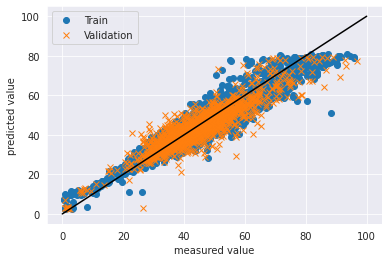

Test: s1i10-015135
Recording time: 2020-08-29 02:06:29.232398
Duriation: 0:14:37.719580
Layer Size: 64
-------------------------
Learning Rate: 0.001
Train Steps: 3000
Batch Size: 128
Dropout Ratio: 0.7
Lambda: 0.01
Beta: 0.02
Start #: 1
Iterations: 10
-------------------------
Architecture: b'| 2_layer_dnn | 3_layer_dnn | 4_layer_dnn | 5_layer_dnn | 6_layer_dnn | 6_layer_dnn | 6_layer_dnn | 6_layer_dnn | 7_layer_dnn |'
-------------------------
cv_r2: 0.8047213567153924
cv_mse: 26.408056259155273
cv_rmse: 5.138876945321348
-------------------------
train_r2: 0.9011137533630577
train_mse: 13.52657413482666
train_rmse: 3.6778491180072437


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps 3000 or save_checkpoints_secs None.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps 3000 or save_checkpoints_secs None.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:loss = 1.443887, step = 0


INFO:tensorflow:loss = 1.443887, step = 0


INFO:tensorflow:global_step/sec: 73.4595


INFO:tensorflow:global_step/sec: 73.4595


INFO:tensorflow:loss = 0.22566345, step = 100 (1.365 sec)


INFO:tensorflow:loss = 0.22566345, step = 100 (1.365 sec)


INFO:tensorflow:global_step/sec: 183.645


INFO:tensorflow:global_step/sec: 183.645


INFO:tensorflow:loss = 0.19754633, step = 200 (0.546 sec)


INFO:tensorflow:loss = 0.19754633, step = 200 (0.546 sec)


INFO:tensorflow:global_step/sec: 189.608


INFO:tensorflow:global_step/sec: 189.608


INFO:tensorflow:loss = 0.2569955, step = 300 (0.528 sec)


INFO:tensorflow:loss = 0.2569955, step = 300 (0.528 sec)


INFO:tensorflow:global_step/sec: 182.758


INFO:tensorflow:global_step/sec: 182.758


INFO:tensorflow:loss = 0.2286595, step = 400 (0.546 sec)


INFO:tensorflow:loss = 0.2286595, step = 400 (0.546 sec)


INFO:tensorflow:global_step/sec: 183.278


INFO:tensorflow:global_step/sec: 183.278


INFO:tensorflow:loss = 0.15861486, step = 500 (0.544 sec)


INFO:tensorflow:loss = 0.15861486, step = 500 (0.544 sec)


INFO:tensorflow:global_step/sec: 173.654


INFO:tensorflow:global_step/sec: 173.654


INFO:tensorflow:loss = 0.2108184, step = 600 (0.577 sec)


INFO:tensorflow:loss = 0.2108184, step = 600 (0.577 sec)


INFO:tensorflow:global_step/sec: 187.745


INFO:tensorflow:global_step/sec: 187.745


INFO:tensorflow:loss = 0.21906927, step = 700 (0.532 sec)


INFO:tensorflow:loss = 0.21906927, step = 700 (0.532 sec)


INFO:tensorflow:global_step/sec: 189.422


INFO:tensorflow:global_step/sec: 189.422


INFO:tensorflow:loss = 0.19547768, step = 800 (0.527 sec)


INFO:tensorflow:loss = 0.19547768, step = 800 (0.527 sec)


INFO:tensorflow:global_step/sec: 172.334


INFO:tensorflow:global_step/sec: 172.334


INFO:tensorflow:loss = 0.17955934, step = 900 (0.582 sec)


INFO:tensorflow:loss = 0.17955934, step = 900 (0.582 sec)


INFO:tensorflow:global_step/sec: 190.222


INFO:tensorflow:global_step/sec: 190.222


INFO:tensorflow:loss = 0.13189489, step = 1000 (0.524 sec)


INFO:tensorflow:loss = 0.13189489, step = 1000 (0.524 sec)


INFO:tensorflow:global_step/sec: 192.007


INFO:tensorflow:global_step/sec: 192.007


INFO:tensorflow:loss = 0.17990167, step = 1100 (0.520 sec)


INFO:tensorflow:loss = 0.17990167, step = 1100 (0.520 sec)


INFO:tensorflow:global_step/sec: 195.749


INFO:tensorflow:global_step/sec: 195.749


INFO:tensorflow:loss = 0.19768241, step = 1200 (0.510 sec)


INFO:tensorflow:loss = 0.19768241, step = 1200 (0.510 sec)


INFO:tensorflow:global_step/sec: 192.843


INFO:tensorflow:global_step/sec: 192.843


INFO:tensorflow:loss = 0.15341705, step = 1300 (0.525 sec)


INFO:tensorflow:loss = 0.15341705, step = 1300 (0.525 sec)


INFO:tensorflow:global_step/sec: 197.618


INFO:tensorflow:global_step/sec: 197.618


INFO:tensorflow:loss = 0.14214678, step = 1400 (0.500 sec)


INFO:tensorflow:loss = 0.14214678, step = 1400 (0.500 sec)


INFO:tensorflow:global_step/sec: 198.067


INFO:tensorflow:global_step/sec: 198.067


INFO:tensorflow:loss = 0.14513645, step = 1500 (0.507 sec)


INFO:tensorflow:loss = 0.14513645, step = 1500 (0.507 sec)


INFO:tensorflow:global_step/sec: 194.653


INFO:tensorflow:global_step/sec: 194.653


INFO:tensorflow:loss = 0.19364315, step = 1600 (0.515 sec)


INFO:tensorflow:loss = 0.19364315, step = 1600 (0.515 sec)


INFO:tensorflow:global_step/sec: 192.215


INFO:tensorflow:global_step/sec: 192.215


INFO:tensorflow:loss = 0.19661435, step = 1700 (0.517 sec)


INFO:tensorflow:loss = 0.19661435, step = 1700 (0.517 sec)


INFO:tensorflow:global_step/sec: 197.465


INFO:tensorflow:global_step/sec: 197.465


INFO:tensorflow:loss = 0.15544474, step = 1800 (0.507 sec)


INFO:tensorflow:loss = 0.15544474, step = 1800 (0.507 sec)


INFO:tensorflow:global_step/sec: 166.075


INFO:tensorflow:global_step/sec: 166.075


INFO:tensorflow:loss = 0.12193572, step = 1900 (0.605 sec)


INFO:tensorflow:loss = 0.12193572, step = 1900 (0.605 sec)


INFO:tensorflow:global_step/sec: 194.592


INFO:tensorflow:global_step/sec: 194.592


INFO:tensorflow:loss = 0.112767786, step = 2000 (0.514 sec)


INFO:tensorflow:loss = 0.112767786, step = 2000 (0.514 sec)


INFO:tensorflow:global_step/sec: 191.74


INFO:tensorflow:global_step/sec: 191.74


INFO:tensorflow:loss = 0.18295673, step = 2100 (0.520 sec)


INFO:tensorflow:loss = 0.18295673, step = 2100 (0.520 sec)


INFO:tensorflow:global_step/sec: 195.007


INFO:tensorflow:global_step/sec: 195.007


INFO:tensorflow:loss = 0.18835196, step = 2200 (0.515 sec)


INFO:tensorflow:loss = 0.18835196, step = 2200 (0.515 sec)


INFO:tensorflow:global_step/sec: 191.948


INFO:tensorflow:global_step/sec: 191.948


INFO:tensorflow:loss = 0.20053104, step = 2300 (0.519 sec)


INFO:tensorflow:loss = 0.20053104, step = 2300 (0.519 sec)


INFO:tensorflow:global_step/sec: 196.803


INFO:tensorflow:global_step/sec: 196.803


INFO:tensorflow:loss = 0.120563515, step = 2400 (0.506 sec)


INFO:tensorflow:loss = 0.120563515, step = 2400 (0.506 sec)


INFO:tensorflow:global_step/sec: 190.162


INFO:tensorflow:global_step/sec: 190.162


INFO:tensorflow:loss = 0.1687991, step = 2500 (0.528 sec)


INFO:tensorflow:loss = 0.1687991, step = 2500 (0.528 sec)


INFO:tensorflow:global_step/sec: 193.839


INFO:tensorflow:global_step/sec: 193.839


INFO:tensorflow:loss = 0.16943103, step = 2600 (0.514 sec)


INFO:tensorflow:loss = 0.16943103, step = 2600 (0.514 sec)


INFO:tensorflow:global_step/sec: 192.027


INFO:tensorflow:global_step/sec: 192.027


INFO:tensorflow:loss = 0.14389443, step = 2700 (0.523 sec)


INFO:tensorflow:loss = 0.14389443, step = 2700 (0.523 sec)


INFO:tensorflow:global_step/sec: 201.021


INFO:tensorflow:global_step/sec: 201.021


INFO:tensorflow:loss = 0.13265195, step = 2800 (0.500 sec)


INFO:tensorflow:loss = 0.13265195, step = 2800 (0.500 sec)


INFO:tensorflow:global_step/sec: 166.479


INFO:tensorflow:global_step/sec: 166.479


INFO:tensorflow:loss = 0.14871944, step = 2900 (0.600 sec)


INFO:tensorflow:loss = 0.14871944, step = 2900 (0.600 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3000...


INFO:tensorflow:Saving checkpoints for 3000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:model.ckpt-3000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-3000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-3000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-3000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T02:06:51Z


INFO:tensorflow:Starting evaluation at 2020-08-29T02:06:51Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-3000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-3000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 1.40079s


INFO:tensorflow:Inference Time : 1.40079s


INFO:tensorflow:Finished evaluation at 2020-08-29-02:06:53


INFO:tensorflow:Finished evaluation at 2020-08-29-02:06:53


INFO:tensorflow:Saving dict for global step 3000: average_loss = 0.20785187, best_ensemble_index_0 = 1, global_step = 3000, iteration = 0, label/mean = -0.0007050394, loss = 0.208267, prediction/mean = -0.05278963


INFO:tensorflow:Saving dict for global step 3000: average_loss = 0.20785187, best_ensemble_index_0 = 1, global_step = 3000, iteration = 0, label/mean = -0.0007050394, loss = 0.208267, prediction/mean = -0.05278963


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-3000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-3000


INFO:tensorflow:Loss for final step: 0.12549268.


INFO:tensorflow:Loss for final step: 0.12549268.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-3000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-3000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598666814861', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598666814861', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598666814861/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598666814861/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-3000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-3000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3001...


INFO:tensorflow:Saving checkpoints for 3001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598666814861/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598666814861/model.ckpt.


INFO:tensorflow:model.ckpt-3001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-3001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3001...


INFO:tensorflow:loss = 0.1269562, step = 3000


INFO:tensorflow:loss = 0.1269562, step = 3000


INFO:tensorflow:Loss for final step: 0.1269562.


INFO:tensorflow:Loss for final step: 0.1269562.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-1


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-1


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3000...


INFO:tensorflow:Saving checkpoints for 3000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:model.ckpt-3000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-3000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3000...


INFO:tensorflow:loss = 0.1269562, step = 3000


INFO:tensorflow:loss = 0.1269562, step = 3000


INFO:tensorflow:global_step/sec: 63.9552


INFO:tensorflow:global_step/sec: 63.9552


INFO:tensorflow:loss = 0.11335787, step = 3100 (1.570 sec)


INFO:tensorflow:loss = 0.11335787, step = 3100 (1.570 sec)


INFO:tensorflow:global_step/sec: 150.718


INFO:tensorflow:global_step/sec: 150.718


INFO:tensorflow:loss = 0.14722395, step = 3200 (0.662 sec)


INFO:tensorflow:loss = 0.14722395, step = 3200 (0.662 sec)


INFO:tensorflow:global_step/sec: 153.3


INFO:tensorflow:global_step/sec: 153.3


INFO:tensorflow:loss = 0.16727626, step = 3300 (0.652 sec)


INFO:tensorflow:loss = 0.16727626, step = 3300 (0.652 sec)


INFO:tensorflow:global_step/sec: 150.469


INFO:tensorflow:global_step/sec: 150.469


INFO:tensorflow:loss = 0.15469187, step = 3400 (0.665 sec)


INFO:tensorflow:loss = 0.15469187, step = 3400 (0.665 sec)


INFO:tensorflow:global_step/sec: 136.774


INFO:tensorflow:global_step/sec: 136.774


INFO:tensorflow:loss = 0.11217028, step = 3500 (0.729 sec)


INFO:tensorflow:loss = 0.11217028, step = 3500 (0.729 sec)


INFO:tensorflow:global_step/sec: 154.844


INFO:tensorflow:global_step/sec: 154.844


INFO:tensorflow:loss = 0.14558963, step = 3600 (0.650 sec)


INFO:tensorflow:loss = 0.14558963, step = 3600 (0.650 sec)


INFO:tensorflow:global_step/sec: 153.328


INFO:tensorflow:global_step/sec: 153.328


INFO:tensorflow:loss = 0.16200495, step = 3700 (0.650 sec)


INFO:tensorflow:loss = 0.16200495, step = 3700 (0.650 sec)


INFO:tensorflow:global_step/sec: 155.967


INFO:tensorflow:global_step/sec: 155.967


INFO:tensorflow:loss = 0.16209798, step = 3800 (0.642 sec)


INFO:tensorflow:loss = 0.16209798, step = 3800 (0.642 sec)


INFO:tensorflow:global_step/sec: 151.104


INFO:tensorflow:global_step/sec: 151.104


INFO:tensorflow:loss = 0.13594532, step = 3900 (0.660 sec)


INFO:tensorflow:loss = 0.13594532, step = 3900 (0.660 sec)


INFO:tensorflow:global_step/sec: 155.874


INFO:tensorflow:global_step/sec: 155.874


INFO:tensorflow:loss = 0.11615239, step = 4000 (0.641 sec)


INFO:tensorflow:loss = 0.11615239, step = 4000 (0.641 sec)


INFO:tensorflow:global_step/sec: 156.93


INFO:tensorflow:global_step/sec: 156.93


INFO:tensorflow:loss = 0.1316455, step = 4100 (0.641 sec)


INFO:tensorflow:loss = 0.1316455, step = 4100 (0.641 sec)


INFO:tensorflow:global_step/sec: 152.22


INFO:tensorflow:global_step/sec: 152.22


INFO:tensorflow:loss = 0.13369721, step = 4200 (0.657 sec)


INFO:tensorflow:loss = 0.13369721, step = 4200 (0.657 sec)


INFO:tensorflow:global_step/sec: 140.674


INFO:tensorflow:global_step/sec: 140.674


INFO:tensorflow:loss = 0.14173888, step = 4300 (0.710 sec)


INFO:tensorflow:loss = 0.14173888, step = 4300 (0.710 sec)


INFO:tensorflow:global_step/sec: 152.612


INFO:tensorflow:global_step/sec: 152.612


INFO:tensorflow:loss = 0.12366491, step = 4400 (0.654 sec)


INFO:tensorflow:loss = 0.12366491, step = 4400 (0.654 sec)


INFO:tensorflow:global_step/sec: 152.362


INFO:tensorflow:global_step/sec: 152.362


INFO:tensorflow:loss = 0.10876359, step = 4500 (0.655 sec)


INFO:tensorflow:loss = 0.10876359, step = 4500 (0.655 sec)


INFO:tensorflow:global_step/sec: 155.348


INFO:tensorflow:global_step/sec: 155.348


INFO:tensorflow:loss = 0.15544784, step = 4600 (0.643 sec)


INFO:tensorflow:loss = 0.15544784, step = 4600 (0.643 sec)


INFO:tensorflow:global_step/sec: 157.172


INFO:tensorflow:global_step/sec: 157.172


INFO:tensorflow:loss = 0.17124213, step = 4700 (0.637 sec)


INFO:tensorflow:loss = 0.17124213, step = 4700 (0.637 sec)


INFO:tensorflow:global_step/sec: 147.379


INFO:tensorflow:global_step/sec: 147.379


INFO:tensorflow:loss = 0.13337998, step = 4800 (0.681 sec)


INFO:tensorflow:loss = 0.13337998, step = 4800 (0.681 sec)


INFO:tensorflow:global_step/sec: 147.306


INFO:tensorflow:global_step/sec: 147.306


INFO:tensorflow:loss = 0.12209268, step = 4900 (0.677 sec)


INFO:tensorflow:loss = 0.12209268, step = 4900 (0.677 sec)


INFO:tensorflow:global_step/sec: 128.474


INFO:tensorflow:global_step/sec: 128.474


INFO:tensorflow:loss = 0.09264332, step = 5000 (0.782 sec)


INFO:tensorflow:loss = 0.09264332, step = 5000 (0.782 sec)


INFO:tensorflow:global_step/sec: 143.405


INFO:tensorflow:global_step/sec: 143.405


INFO:tensorflow:loss = 0.14176619, step = 5100 (0.696 sec)


INFO:tensorflow:loss = 0.14176619, step = 5100 (0.696 sec)


INFO:tensorflow:global_step/sec: 152.559


INFO:tensorflow:global_step/sec: 152.559


INFO:tensorflow:loss = 0.16298021, step = 5200 (0.654 sec)


INFO:tensorflow:loss = 0.16298021, step = 5200 (0.654 sec)


INFO:tensorflow:global_step/sec: 155.451


INFO:tensorflow:global_step/sec: 155.451


INFO:tensorflow:loss = 0.18044691, step = 5300 (0.642 sec)


INFO:tensorflow:loss = 0.18044691, step = 5300 (0.642 sec)


INFO:tensorflow:global_step/sec: 154.85


INFO:tensorflow:global_step/sec: 154.85


INFO:tensorflow:loss = 0.12724869, step = 5400 (0.648 sec)


INFO:tensorflow:loss = 0.12724869, step = 5400 (0.648 sec)


INFO:tensorflow:global_step/sec: 154.72


INFO:tensorflow:global_step/sec: 154.72


INFO:tensorflow:loss = 0.1270635, step = 5500 (0.646 sec)


INFO:tensorflow:loss = 0.1270635, step = 5500 (0.646 sec)


INFO:tensorflow:global_step/sec: 154.557


INFO:tensorflow:global_step/sec: 154.557


INFO:tensorflow:loss = 0.16117615, step = 5600 (0.646 sec)


INFO:tensorflow:loss = 0.16117615, step = 5600 (0.646 sec)


INFO:tensorflow:global_step/sec: 153.572


INFO:tensorflow:global_step/sec: 153.572


INFO:tensorflow:loss = 0.12554505, step = 5700 (0.651 sec)


INFO:tensorflow:loss = 0.12554505, step = 5700 (0.651 sec)


INFO:tensorflow:global_step/sec: 129.721


INFO:tensorflow:global_step/sec: 129.721


INFO:tensorflow:loss = 0.14681801, step = 5800 (0.772 sec)


INFO:tensorflow:loss = 0.14681801, step = 5800 (0.772 sec)


INFO:tensorflow:global_step/sec: 151.445


INFO:tensorflow:global_step/sec: 151.445


INFO:tensorflow:loss = 0.13669696, step = 5900 (0.661 sec)


INFO:tensorflow:loss = 0.13669696, step = 5900 (0.661 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6000...


INFO:tensorflow:Saving checkpoints for 6000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:Saving checkpoints for 6000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:model.ckpt-6000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-6000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-6000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-6000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T02:07:30Z


INFO:tensorflow:Starting evaluation at 2020-08-29T02:07:30Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-6000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-6000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 1.95963s


INFO:tensorflow:Inference Time : 1.95963s


INFO:tensorflow:Finished evaluation at 2020-08-29-02:07:32


INFO:tensorflow:Finished evaluation at 2020-08-29-02:07:32


INFO:tensorflow:Saving dict for global step 6000: average_loss = 0.20165016, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, global_step = 6000, iteration = 1, label/mean = -0.0007050394, loss = 0.20206581, prediction/mean = -0.06092598


INFO:tensorflow:Saving dict for global step 6000: average_loss = 0.20165016, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, global_step = 6000, iteration = 1, label/mean = -0.0007050394, loss = 0.20206581, prediction/mean = -0.06092598


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-6000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-6000


INFO:tensorflow:Loss for final step: 0.0984759.


INFO:tensorflow:Loss for final step: 0.0984759.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-6000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-6000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598666854838', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598666854838', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598666854838/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598666854838/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-6000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-6000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-2 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-2 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6001...


INFO:tensorflow:Saving checkpoints for 6001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598666854838/model.ckpt.


INFO:tensorflow:Saving checkpoints for 6001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598666854838/model.ckpt.


INFO:tensorflow:model.ckpt-6001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-6001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6001...


INFO:tensorflow:loss = 0.1155251, step = 6001


INFO:tensorflow:loss = 0.1155251, step = 6001


INFO:tensorflow:Loss for final step: 0.1155251.


INFO:tensorflow:Loss for final step: 0.1155251.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-2


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-2


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6000...


INFO:tensorflow:Saving checkpoints for 6000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:Saving checkpoints for 6000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:model.ckpt-6000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-6000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6000...


INFO:tensorflow:loss = 0.1155251, step = 6000


INFO:tensorflow:loss = 0.1155251, step = 6000


INFO:tensorflow:global_step/sec: 50.0621


INFO:tensorflow:global_step/sec: 50.0621


INFO:tensorflow:loss = 0.10018878, step = 6100 (2.003 sec)


INFO:tensorflow:loss = 0.10018878, step = 6100 (2.003 sec)


INFO:tensorflow:global_step/sec: 130.121


INFO:tensorflow:global_step/sec: 130.121


INFO:tensorflow:loss = 0.13290042, step = 6200 (0.766 sec)


INFO:tensorflow:loss = 0.13290042, step = 6200 (0.766 sec)


INFO:tensorflow:global_step/sec: 131.982


INFO:tensorflow:global_step/sec: 131.982


INFO:tensorflow:loss = 0.15232262, step = 6300 (0.761 sec)


INFO:tensorflow:loss = 0.15232262, step = 6300 (0.761 sec)


INFO:tensorflow:global_step/sec: 130.474


INFO:tensorflow:global_step/sec: 130.474


INFO:tensorflow:loss = 0.14432468, step = 6400 (0.764 sec)


INFO:tensorflow:loss = 0.14432468, step = 6400 (0.764 sec)


INFO:tensorflow:global_step/sec: 131.424


INFO:tensorflow:global_step/sec: 131.424


INFO:tensorflow:loss = 0.101867825, step = 6500 (0.761 sec)


INFO:tensorflow:loss = 0.101867825, step = 6500 (0.761 sec)


INFO:tensorflow:global_step/sec: 130.02


INFO:tensorflow:global_step/sec: 130.02


INFO:tensorflow:loss = 0.13450983, step = 6600 (0.768 sec)


INFO:tensorflow:loss = 0.13450983, step = 6600 (0.768 sec)


INFO:tensorflow:global_step/sec: 125.623


INFO:tensorflow:global_step/sec: 125.623


INFO:tensorflow:loss = 0.14310291, step = 6700 (0.798 sec)


INFO:tensorflow:loss = 0.14310291, step = 6700 (0.798 sec)


INFO:tensorflow:global_step/sec: 124.187


INFO:tensorflow:global_step/sec: 124.187


INFO:tensorflow:loss = 0.15249798, step = 6800 (0.806 sec)


INFO:tensorflow:loss = 0.15249798, step = 6800 (0.806 sec)


INFO:tensorflow:global_step/sec: 132.943


INFO:tensorflow:global_step/sec: 132.943


INFO:tensorflow:loss = 0.12506372, step = 6900 (0.751 sec)


INFO:tensorflow:loss = 0.12506372, step = 6900 (0.751 sec)


INFO:tensorflow:global_step/sec: 131.319


INFO:tensorflow:global_step/sec: 131.319


INFO:tensorflow:loss = 0.10613851, step = 7000 (0.763 sec)


INFO:tensorflow:loss = 0.10613851, step = 7000 (0.763 sec)


INFO:tensorflow:global_step/sec: 130.552


INFO:tensorflow:global_step/sec: 130.552


INFO:tensorflow:loss = 0.114862286, step = 7100 (0.765 sec)


INFO:tensorflow:loss = 0.114862286, step = 7100 (0.765 sec)


INFO:tensorflow:global_step/sec: 132.266


INFO:tensorflow:global_step/sec: 132.266


INFO:tensorflow:loss = 0.12283498, step = 7200 (0.755 sec)


INFO:tensorflow:loss = 0.12283498, step = 7200 (0.755 sec)


INFO:tensorflow:global_step/sec: 128.603


INFO:tensorflow:global_step/sec: 128.603


INFO:tensorflow:loss = 0.13142711, step = 7300 (0.779 sec)


INFO:tensorflow:loss = 0.13142711, step = 7300 (0.779 sec)


INFO:tensorflow:global_step/sec: 116.946


INFO:tensorflow:global_step/sec: 116.946


INFO:tensorflow:loss = 0.1148596, step = 7400 (0.856 sec)


INFO:tensorflow:loss = 0.1148596, step = 7400 (0.856 sec)


INFO:tensorflow:global_step/sec: 130.353


INFO:tensorflow:global_step/sec: 130.353


INFO:tensorflow:loss = 0.09694691, step = 7500 (0.767 sec)


INFO:tensorflow:loss = 0.09694691, step = 7500 (0.767 sec)


INFO:tensorflow:global_step/sec: 131.07


INFO:tensorflow:global_step/sec: 131.07


INFO:tensorflow:loss = 0.13731395, step = 7600 (0.764 sec)


INFO:tensorflow:loss = 0.13731395, step = 7600 (0.764 sec)


INFO:tensorflow:global_step/sec: 129.275


INFO:tensorflow:global_step/sec: 129.275


INFO:tensorflow:loss = 0.15624103, step = 7700 (0.773 sec)


INFO:tensorflow:loss = 0.15624103, step = 7700 (0.773 sec)


INFO:tensorflow:global_step/sec: 130.397


INFO:tensorflow:global_step/sec: 130.397


INFO:tensorflow:loss = 0.12088859, step = 7800 (0.766 sec)


INFO:tensorflow:loss = 0.12088859, step = 7800 (0.766 sec)


INFO:tensorflow:global_step/sec: 131.468


INFO:tensorflow:global_step/sec: 131.468


INFO:tensorflow:loss = 0.11367704, step = 7900 (0.760 sec)


INFO:tensorflow:loss = 0.11367704, step = 7900 (0.760 sec)


INFO:tensorflow:global_step/sec: 131.991


INFO:tensorflow:global_step/sec: 131.991


INFO:tensorflow:loss = 0.08468009, step = 8000 (0.758 sec)


INFO:tensorflow:loss = 0.08468009, step = 8000 (0.758 sec)


INFO:tensorflow:global_step/sec: 119.721


INFO:tensorflow:global_step/sec: 119.721


INFO:tensorflow:loss = 0.12644075, step = 8100 (0.837 sec)


INFO:tensorflow:loss = 0.12644075, step = 8100 (0.837 sec)


INFO:tensorflow:global_step/sec: 131.446


INFO:tensorflow:global_step/sec: 131.446


INFO:tensorflow:loss = 0.1406768, step = 8200 (0.762 sec)


INFO:tensorflow:loss = 0.1406768, step = 8200 (0.762 sec)


INFO:tensorflow:global_step/sec: 128.547


INFO:tensorflow:global_step/sec: 128.547


INFO:tensorflow:loss = 0.15830572, step = 8300 (0.777 sec)


INFO:tensorflow:loss = 0.15830572, step = 8300 (0.777 sec)


INFO:tensorflow:global_step/sec: 129.411


INFO:tensorflow:global_step/sec: 129.411


INFO:tensorflow:loss = 0.113365486, step = 8400 (0.771 sec)


INFO:tensorflow:loss = 0.113365486, step = 8400 (0.771 sec)


INFO:tensorflow:global_step/sec: 124.676


INFO:tensorflow:global_step/sec: 124.676


INFO:tensorflow:loss = 0.119041145, step = 8500 (0.802 sec)


INFO:tensorflow:loss = 0.119041145, step = 8500 (0.802 sec)


INFO:tensorflow:global_step/sec: 127.139


INFO:tensorflow:global_step/sec: 127.139


INFO:tensorflow:loss = 0.15780568, step = 8600 (0.786 sec)


INFO:tensorflow:loss = 0.15780568, step = 8600 (0.786 sec)


INFO:tensorflow:global_step/sec: 126.145


INFO:tensorflow:global_step/sec: 126.145


INFO:tensorflow:loss = 0.12278406, step = 8700 (0.797 sec)


INFO:tensorflow:loss = 0.12278406, step = 8700 (0.797 sec)


INFO:tensorflow:global_step/sec: 116.544


INFO:tensorflow:global_step/sec: 116.544


INFO:tensorflow:loss = 0.13134834, step = 8800 (0.855 sec)


INFO:tensorflow:loss = 0.13134834, step = 8800 (0.855 sec)


INFO:tensorflow:global_step/sec: 129.01


INFO:tensorflow:global_step/sec: 129.01


INFO:tensorflow:loss = 0.13942772, step = 8900 (0.775 sec)


INFO:tensorflow:loss = 0.13942772, step = 8900 (0.775 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9000...


INFO:tensorflow:Saving checkpoints for 9000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:Saving checkpoints for 9000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:model.ckpt-9000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-9000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-9000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-9000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T02:08:19Z


INFO:tensorflow:Starting evaluation at 2020-08-29T02:08:19Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-9000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-9000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 2.74412s


INFO:tensorflow:Inference Time : 2.74412s


INFO:tensorflow:Finished evaluation at 2020-08-29-02:08:22


INFO:tensorflow:Finished evaluation at 2020-08-29-02:08:22


INFO:tensorflow:Saving dict for global step 9000: average_loss = 0.20002648, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, global_step = 9000, iteration = 2, label/mean = -0.0007050394, loss = 0.20037019, prediction/mean = -0.071739465


INFO:tensorflow:Saving dict for global step 9000: average_loss = 0.20002648, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, global_step = 9000, iteration = 2, label/mean = -0.0007050394, loss = 0.20037019, prediction/mean = -0.071739465


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-9000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-9000


INFO:tensorflow:Loss for final step: 0.08729447.


INFO:tensorflow:Loss for final step: 0.08729447.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-9000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-9000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598666907792', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598666907792', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598666907792/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598666907792/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-9000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-9000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-3 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-3 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9001...


INFO:tensorflow:Saving checkpoints for 9001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598666907792/model.ckpt.


INFO:tensorflow:Saving checkpoints for 9001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598666907792/model.ckpt.


INFO:tensorflow:model.ckpt-9001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-9001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9001...


INFO:tensorflow:loss = 0.10470567, step = 9000


INFO:tensorflow:loss = 0.10470567, step = 9000


INFO:tensorflow:Loss for final step: 0.10470567.


INFO:tensorflow:Loss for final step: 0.10470567.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-3


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-3


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9000...


INFO:tensorflow:Saving checkpoints for 9000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:Saving checkpoints for 9000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:model.ckpt-9000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-9000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9000...


INFO:tensorflow:loss = 0.10470567, step = 9000


INFO:tensorflow:loss = 0.10470567, step = 9000


INFO:tensorflow:global_step/sec: 41.4273


INFO:tensorflow:global_step/sec: 41.4273


INFO:tensorflow:loss = 0.08889471, step = 9100 (2.417 sec)


INFO:tensorflow:loss = 0.08889471, step = 9100 (2.417 sec)


INFO:tensorflow:global_step/sec: 112.244


INFO:tensorflow:global_step/sec: 112.244


INFO:tensorflow:loss = 0.11857483, step = 9200 (0.893 sec)


INFO:tensorflow:loss = 0.11857483, step = 9200 (0.893 sec)


INFO:tensorflow:global_step/sec: 111.497


INFO:tensorflow:global_step/sec: 111.497


INFO:tensorflow:loss = 0.13372204, step = 9300 (0.895 sec)


INFO:tensorflow:loss = 0.13372204, step = 9300 (0.895 sec)


INFO:tensorflow:global_step/sec: 112.302


INFO:tensorflow:global_step/sec: 112.302


INFO:tensorflow:loss = 0.13254526, step = 9400 (0.896 sec)


INFO:tensorflow:loss = 0.13254526, step = 9400 (0.896 sec)


INFO:tensorflow:global_step/sec: 111.273


INFO:tensorflow:global_step/sec: 111.273


INFO:tensorflow:loss = 0.08967155, step = 9500 (0.894 sec)


INFO:tensorflow:loss = 0.08967155, step = 9500 (0.894 sec)


INFO:tensorflow:global_step/sec: 105.451


INFO:tensorflow:global_step/sec: 105.451


INFO:tensorflow:loss = 0.12628765, step = 9600 (0.949 sec)


INFO:tensorflow:loss = 0.12628765, step = 9600 (0.949 sec)


INFO:tensorflow:global_step/sec: 113.597


INFO:tensorflow:global_step/sec: 113.597


INFO:tensorflow:loss = 0.12273509, step = 9700 (0.880 sec)


INFO:tensorflow:loss = 0.12273509, step = 9700 (0.880 sec)


INFO:tensorflow:global_step/sec: 111.783


INFO:tensorflow:global_step/sec: 111.783


INFO:tensorflow:loss = 0.14288184, step = 9800 (0.895 sec)


INFO:tensorflow:loss = 0.14288184, step = 9800 (0.895 sec)


INFO:tensorflow:global_step/sec: 113.247


INFO:tensorflow:global_step/sec: 113.247


INFO:tensorflow:loss = 0.11088542, step = 9900 (0.880 sec)


INFO:tensorflow:loss = 0.11088542, step = 9900 (0.880 sec)


INFO:tensorflow:global_step/sec: 111.016


INFO:tensorflow:global_step/sec: 111.016


INFO:tensorflow:loss = 0.09939566, step = 10000 (0.901 sec)


INFO:tensorflow:loss = 0.09939566, step = 10000 (0.901 sec)


INFO:tensorflow:global_step/sec: 113.248


INFO:tensorflow:global_step/sec: 113.248


INFO:tensorflow:loss = 0.096930206, step = 10100 (0.886 sec)


INFO:tensorflow:loss = 0.096930206, step = 10100 (0.886 sec)


INFO:tensorflow:global_step/sec: 103.357


INFO:tensorflow:global_step/sec: 103.357


INFO:tensorflow:loss = 0.11094178, step = 10200 (0.964 sec)


INFO:tensorflow:loss = 0.11094178, step = 10200 (0.964 sec)


INFO:tensorflow:global_step/sec: 113.208


INFO:tensorflow:global_step/sec: 113.208


INFO:tensorflow:loss = 0.11807366, step = 10300 (0.883 sec)


INFO:tensorflow:loss = 0.11807366, step = 10300 (0.883 sec)


INFO:tensorflow:global_step/sec: 109.282


INFO:tensorflow:global_step/sec: 109.282


INFO:tensorflow:loss = 0.09556836, step = 10400 (0.916 sec)


INFO:tensorflow:loss = 0.09556836, step = 10400 (0.916 sec)


INFO:tensorflow:global_step/sec: 113.583


INFO:tensorflow:global_step/sec: 113.583


INFO:tensorflow:loss = 0.08788794, step = 10500 (0.881 sec)


INFO:tensorflow:loss = 0.08788794, step = 10500 (0.881 sec)


INFO:tensorflow:global_step/sec: 111.819


INFO:tensorflow:global_step/sec: 111.819


INFO:tensorflow:loss = 0.12242879, step = 10600 (0.896 sec)


INFO:tensorflow:loss = 0.12242879, step = 10600 (0.896 sec)


INFO:tensorflow:global_step/sec: 97.3705


INFO:tensorflow:global_step/sec: 97.3705


INFO:tensorflow:loss = 0.13795558, step = 10700 (1.024 sec)


INFO:tensorflow:loss = 0.13795558, step = 10700 (1.024 sec)


INFO:tensorflow:global_step/sec: 112.728


INFO:tensorflow:global_step/sec: 112.728


INFO:tensorflow:loss = 0.11056152, step = 10800 (0.886 sec)


INFO:tensorflow:loss = 0.11056152, step = 10800 (0.886 sec)


INFO:tensorflow:global_step/sec: 114.205


INFO:tensorflow:global_step/sec: 114.205


INFO:tensorflow:loss = 0.10563564, step = 10900 (0.878 sec)


INFO:tensorflow:loss = 0.10563564, step = 10900 (0.878 sec)


INFO:tensorflow:global_step/sec: 113.791


INFO:tensorflow:global_step/sec: 113.791


INFO:tensorflow:loss = 0.0741978, step = 11000 (0.877 sec)


INFO:tensorflow:loss = 0.0741978, step = 11000 (0.877 sec)


INFO:tensorflow:global_step/sec: 113.639


INFO:tensorflow:global_step/sec: 113.639


INFO:tensorflow:loss = 0.1097793, step = 11100 (0.880 sec)


INFO:tensorflow:loss = 0.1097793, step = 11100 (0.880 sec)


INFO:tensorflow:global_step/sec: 115.038


INFO:tensorflow:global_step/sec: 115.038


INFO:tensorflow:loss = 0.118968815, step = 11200 (0.871 sec)


INFO:tensorflow:loss = 0.118968815, step = 11200 (0.871 sec)


INFO:tensorflow:global_step/sec: 104.107


INFO:tensorflow:global_step/sec: 104.107


INFO:tensorflow:loss = 0.13481382, step = 11300 (0.958 sec)


INFO:tensorflow:loss = 0.13481382, step = 11300 (0.958 sec)


INFO:tensorflow:global_step/sec: 112.887


INFO:tensorflow:global_step/sec: 112.887


INFO:tensorflow:loss = 0.10015688, step = 11400 (0.888 sec)


INFO:tensorflow:loss = 0.10015688, step = 11400 (0.888 sec)


INFO:tensorflow:global_step/sec: 111.598


INFO:tensorflow:global_step/sec: 111.598


INFO:tensorflow:loss = 0.11023342, step = 11500 (0.895 sec)


INFO:tensorflow:loss = 0.11023342, step = 11500 (0.895 sec)


INFO:tensorflow:global_step/sec: 108.724


INFO:tensorflow:global_step/sec: 108.724


INFO:tensorflow:loss = 0.14037116, step = 11600 (0.921 sec)


INFO:tensorflow:loss = 0.14037116, step = 11600 (0.921 sec)


INFO:tensorflow:global_step/sec: 113.999


INFO:tensorflow:global_step/sec: 113.999


INFO:tensorflow:loss = 0.10560894, step = 11700 (0.877 sec)


INFO:tensorflow:loss = 0.10560894, step = 11700 (0.877 sec)


INFO:tensorflow:global_step/sec: 112.847


INFO:tensorflow:global_step/sec: 112.847


INFO:tensorflow:loss = 0.11486031, step = 11800 (0.886 sec)


INFO:tensorflow:loss = 0.11486031, step = 11800 (0.886 sec)


INFO:tensorflow:global_step/sec: 104.561


INFO:tensorflow:global_step/sec: 104.561


INFO:tensorflow:loss = 0.1267147, step = 11900 (0.956 sec)


INFO:tensorflow:loss = 0.1267147, step = 11900 (0.956 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 12000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 12000...


INFO:tensorflow:Saving checkpoints for 12000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:Saving checkpoints for 12000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:model.ckpt-12000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-12000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 12000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 12000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-12000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-12000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T02:09:22Z


INFO:tensorflow:Starting evaluation at 2020-08-29T02:09:22Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-12000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-12000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 3.52445s


INFO:tensorflow:Inference Time : 3.52445s


INFO:tensorflow:Finished evaluation at 2020-08-29-02:09:26


INFO:tensorflow:Finished evaluation at 2020-08-29-02:09:26


INFO:tensorflow:Saving dict for global step 12000: average_loss = 0.19740093, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, global_step = 12000, iteration = 3, label/mean = -0.0007050394, loss = 0.19760486, prediction/mean = -0.080627516


INFO:tensorflow:Saving dict for global step 12000: average_loss = 0.19740093, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, global_step = 12000, iteration = 3, label/mean = -0.0007050394, loss = 0.19760486, prediction/mean = -0.080627516


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 12000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-12000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 12000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-12000


INFO:tensorflow:Loss for final step: 0.078084715.


INFO:tensorflow:Loss for final step: 0.078084715.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-12000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-12000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598666971128', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598666971128', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598666971128/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598666971128/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-12000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-12000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-4 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-4 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 12001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 12001...


INFO:tensorflow:Saving checkpoints for 12001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598666971128/model.ckpt.


INFO:tensorflow:Saving checkpoints for 12001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598666971128/model.ckpt.


INFO:tensorflow:model.ckpt-12001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-12001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 12001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 12001...


INFO:tensorflow:loss = 0.09825208, step = 12001


INFO:tensorflow:loss = 0.09825208, step = 12001


INFO:tensorflow:Loss for final step: 0.09825208.


INFO:tensorflow:Loss for final step: 0.09825208.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-4


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-4


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 12000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 12000...


INFO:tensorflow:Saving checkpoints for 12000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:Saving checkpoints for 12000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:model.ckpt-12000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-12000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 12000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 12000...


INFO:tensorflow:loss = 0.09825208, step = 12000


INFO:tensorflow:loss = 0.09825208, step = 12000


INFO:tensorflow:global_step/sec: 35.9232


INFO:tensorflow:global_step/sec: 35.9232


INFO:tensorflow:loss = 0.085894465, step = 12100 (2.787 sec)


INFO:tensorflow:loss = 0.085894465, step = 12100 (2.787 sec)


INFO:tensorflow:global_step/sec: 99.8079


INFO:tensorflow:global_step/sec: 99.8079


INFO:tensorflow:loss = 0.11112929, step = 12200 (1.004 sec)


INFO:tensorflow:loss = 0.11112929, step = 12200 (1.004 sec)


INFO:tensorflow:global_step/sec: 100.843


INFO:tensorflow:global_step/sec: 100.843


INFO:tensorflow:loss = 0.12260841, step = 12300 (0.990 sec)


INFO:tensorflow:loss = 0.12260841, step = 12300 (0.990 sec)


INFO:tensorflow:global_step/sec: 95.0706


INFO:tensorflow:global_step/sec: 95.0706


INFO:tensorflow:loss = 0.1248412, step = 12400 (1.052 sec)


INFO:tensorflow:loss = 0.1248412, step = 12400 (1.052 sec)


INFO:tensorflow:global_step/sec: 93.5413


INFO:tensorflow:global_step/sec: 93.5413


INFO:tensorflow:loss = 0.0806085, step = 12500 (1.071 sec)


INFO:tensorflow:loss = 0.0806085, step = 12500 (1.071 sec)


INFO:tensorflow:global_step/sec: 98.6357


INFO:tensorflow:global_step/sec: 98.6357


INFO:tensorflow:loss = 0.119134635, step = 12600 (1.012 sec)


INFO:tensorflow:loss = 0.119134635, step = 12600 (1.012 sec)


INFO:tensorflow:global_step/sec: 100.102


INFO:tensorflow:global_step/sec: 100.102


INFO:tensorflow:loss = 0.109693825, step = 12700 (0.999 sec)


INFO:tensorflow:loss = 0.109693825, step = 12700 (0.999 sec)


INFO:tensorflow:global_step/sec: 100.327


INFO:tensorflow:global_step/sec: 100.327


INFO:tensorflow:loss = 0.13798027, step = 12800 (0.998 sec)


INFO:tensorflow:loss = 0.13798027, step = 12800 (0.998 sec)


INFO:tensorflow:global_step/sec: 99.5564


INFO:tensorflow:global_step/sec: 99.5564


INFO:tensorflow:loss = 0.10055175, step = 12900 (1.004 sec)


INFO:tensorflow:loss = 0.10055175, step = 12900 (1.004 sec)


INFO:tensorflow:global_step/sec: 92.6157


INFO:tensorflow:global_step/sec: 92.6157


INFO:tensorflow:loss = 0.096133195, step = 13000 (1.081 sec)


INFO:tensorflow:loss = 0.096133195, step = 13000 (1.081 sec)


INFO:tensorflow:global_step/sec: 100.016


INFO:tensorflow:global_step/sec: 100.016


INFO:tensorflow:loss = 0.08871068, step = 13100 (1.000 sec)


INFO:tensorflow:loss = 0.08871068, step = 13100 (1.000 sec)


INFO:tensorflow:global_step/sec: 99.1456


INFO:tensorflow:global_step/sec: 99.1456


INFO:tensorflow:loss = 0.09939369, step = 13200 (1.006 sec)


INFO:tensorflow:loss = 0.09939369, step = 13200 (1.006 sec)


INFO:tensorflow:global_step/sec: 99.9559


INFO:tensorflow:global_step/sec: 99.9559


INFO:tensorflow:loss = 0.10943936, step = 13300 (1.002 sec)


INFO:tensorflow:loss = 0.10943936, step = 13300 (1.002 sec)


INFO:tensorflow:global_step/sec: 100.563


INFO:tensorflow:global_step/sec: 100.563


INFO:tensorflow:loss = 0.089201644, step = 13400 (0.994 sec)


INFO:tensorflow:loss = 0.089201644, step = 13400 (0.994 sec)


INFO:tensorflow:global_step/sec: 92.372


INFO:tensorflow:global_step/sec: 92.372


INFO:tensorflow:loss = 0.08202487, step = 13500 (1.080 sec)


INFO:tensorflow:loss = 0.08202487, step = 13500 (1.080 sec)


INFO:tensorflow:global_step/sec: 97.9613


INFO:tensorflow:global_step/sec: 97.9613


INFO:tensorflow:loss = 0.113196574, step = 13600 (1.022 sec)


INFO:tensorflow:loss = 0.113196574, step = 13600 (1.022 sec)


INFO:tensorflow:global_step/sec: 99.9281


INFO:tensorflow:global_step/sec: 99.9281


INFO:tensorflow:loss = 0.12813728, step = 13700 (1.002 sec)


INFO:tensorflow:loss = 0.12813728, step = 13700 (1.002 sec)


INFO:tensorflow:global_step/sec: 96.208


INFO:tensorflow:global_step/sec: 96.208


INFO:tensorflow:loss = 0.106246896, step = 13800 (1.038 sec)


INFO:tensorflow:loss = 0.106246896, step = 13800 (1.038 sec)


INFO:tensorflow:global_step/sec: 98.8265


INFO:tensorflow:global_step/sec: 98.8265


INFO:tensorflow:loss = 0.10169002, step = 13900 (1.010 sec)


INFO:tensorflow:loss = 0.10169002, step = 13900 (1.010 sec)


INFO:tensorflow:global_step/sec: 90.8903


INFO:tensorflow:global_step/sec: 90.8903


INFO:tensorflow:loss = 0.06703175, step = 14000 (1.100 sec)


INFO:tensorflow:loss = 0.06703175, step = 14000 (1.100 sec)


INFO:tensorflow:global_step/sec: 99.7297


INFO:tensorflow:global_step/sec: 99.7297


INFO:tensorflow:loss = 0.09977433, step = 14100 (1.004 sec)


INFO:tensorflow:loss = 0.09977433, step = 14100 (1.004 sec)


INFO:tensorflow:global_step/sec: 98.8853


INFO:tensorflow:global_step/sec: 98.8853


INFO:tensorflow:loss = 0.11288588, step = 14200 (1.012 sec)


INFO:tensorflow:loss = 0.11288588, step = 14200 (1.012 sec)


INFO:tensorflow:global_step/sec: 99.0372


INFO:tensorflow:global_step/sec: 99.0372


INFO:tensorflow:loss = 0.12654296, step = 14300 (1.010 sec)


INFO:tensorflow:loss = 0.12654296, step = 14300 (1.010 sec)


INFO:tensorflow:global_step/sec: 100.635


INFO:tensorflow:global_step/sec: 100.635


INFO:tensorflow:loss = 0.092031464, step = 14400 (0.996 sec)


INFO:tensorflow:loss = 0.092031464, step = 14400 (0.996 sec)


INFO:tensorflow:global_step/sec: 90.8981


INFO:tensorflow:global_step/sec: 90.8981


INFO:tensorflow:loss = 0.11040771, step = 14500 (1.101 sec)


INFO:tensorflow:loss = 0.11040771, step = 14500 (1.101 sec)


INFO:tensorflow:global_step/sec: 96.5584


INFO:tensorflow:global_step/sec: 96.5584


INFO:tensorflow:loss = 0.13190077, step = 14600 (1.033 sec)


INFO:tensorflow:loss = 0.13190077, step = 14600 (1.033 sec)


INFO:tensorflow:global_step/sec: 99.5956


INFO:tensorflow:global_step/sec: 99.5956


INFO:tensorflow:loss = 0.097006015, step = 14700 (1.002 sec)


INFO:tensorflow:loss = 0.097006015, step = 14700 (1.002 sec)


INFO:tensorflow:global_step/sec: 100.84


INFO:tensorflow:global_step/sec: 100.84


INFO:tensorflow:loss = 0.10617391, step = 14800 (0.993 sec)


INFO:tensorflow:loss = 0.10617391, step = 14800 (0.993 sec)


INFO:tensorflow:global_step/sec: 99.5278


INFO:tensorflow:global_step/sec: 99.5278


INFO:tensorflow:loss = 0.11837186, step = 14900 (1.005 sec)


INFO:tensorflow:loss = 0.11837186, step = 14900 (1.005 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15000...


INFO:tensorflow:Saving checkpoints for 15000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:Saving checkpoints for 15000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:model.ckpt-15000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-15000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-15000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-15000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T02:10:38Z


INFO:tensorflow:Starting evaluation at 2020-08-29T02:10:38Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-15000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-15000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 4.54221s


INFO:tensorflow:Inference Time : 4.54221s


INFO:tensorflow:Finished evaluation at 2020-08-29-02:10:43


INFO:tensorflow:Finished evaluation at 2020-08-29-02:10:43


INFO:tensorflow:Saving dict for global step 15000: average_loss = 0.19577575, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 1, global_step = 15000, iteration = 4, label/mean = -0.0007050394, loss = 0.19597211, prediction/mean = -0.079328686


INFO:tensorflow:Saving dict for global step 15000: average_loss = 0.19577575, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 1, global_step = 15000, iteration = 4, label/mean = -0.0007050394, loss = 0.19597211, prediction/mean = -0.079328686


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 15000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-15000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 15000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-15000


INFO:tensorflow:Loss for final step: 0.07595144.


INFO:tensorflow:Loss for final step: 0.07595144.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-15000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-15000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598667048844', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598667048844', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598667048844/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598667048844/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-15000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-15000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-5 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-5 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15001...


INFO:tensorflow:Saving checkpoints for 15001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598667048844/model.ckpt.


INFO:tensorflow:Saving checkpoints for 15001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598667048844/model.ckpt.


INFO:tensorflow:model.ckpt-15001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-15001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15001...


INFO:tensorflow:loss = 0.092306904, step = 15001


INFO:tensorflow:loss = 0.092306904, step = 15001


INFO:tensorflow:Loss for final step: 0.092306904.


INFO:tensorflow:Loss for final step: 0.092306904.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-5


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-5


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15000...


INFO:tensorflow:Saving checkpoints for 15000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:Saving checkpoints for 15000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:model.ckpt-15000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-15000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15000...


INFO:tensorflow:loss = 0.092306904, step = 15000


INFO:tensorflow:loss = 0.092306904, step = 15000


INFO:tensorflow:global_step/sec: 32.2231


INFO:tensorflow:global_step/sec: 32.2231


INFO:tensorflow:loss = 0.08354971, step = 15100 (3.105 sec)


INFO:tensorflow:loss = 0.08354971, step = 15100 (3.105 sec)


INFO:tensorflow:global_step/sec: 92.9945


INFO:tensorflow:global_step/sec: 92.9945


INFO:tensorflow:loss = 0.105516285, step = 15200 (1.076 sec)


INFO:tensorflow:loss = 0.105516285, step = 15200 (1.076 sec)


INFO:tensorflow:global_step/sec: 93.9401


INFO:tensorflow:global_step/sec: 93.9401


INFO:tensorflow:loss = 0.11979775, step = 15300 (1.067 sec)


INFO:tensorflow:loss = 0.11979775, step = 15300 (1.067 sec)


INFO:tensorflow:global_step/sec: 93.9701


INFO:tensorflow:global_step/sec: 93.9701


INFO:tensorflow:loss = 0.1214482, step = 15400 (1.062 sec)


INFO:tensorflow:loss = 0.1214482, step = 15400 (1.062 sec)


INFO:tensorflow:global_step/sec: 95.722


INFO:tensorflow:global_step/sec: 95.722


INFO:tensorflow:loss = 0.07790158, step = 15500 (1.044 sec)


INFO:tensorflow:loss = 0.07790158, step = 15500 (1.044 sec)


INFO:tensorflow:global_step/sec: 88.8669


INFO:tensorflow:global_step/sec: 88.8669


INFO:tensorflow:loss = 0.114263795, step = 15600 (1.126 sec)


INFO:tensorflow:loss = 0.114263795, step = 15600 (1.126 sec)


INFO:tensorflow:global_step/sec: 95.3024


INFO:tensorflow:global_step/sec: 95.3024


INFO:tensorflow:loss = 0.10420138, step = 15700 (1.052 sec)


INFO:tensorflow:loss = 0.10420138, step = 15700 (1.052 sec)


INFO:tensorflow:global_step/sec: 94.4901


INFO:tensorflow:global_step/sec: 94.4901


INFO:tensorflow:loss = 0.13373208, step = 15800 (1.057 sec)


INFO:tensorflow:loss = 0.13373208, step = 15800 (1.057 sec)


INFO:tensorflow:global_step/sec: 92.8474


INFO:tensorflow:global_step/sec: 92.8474


INFO:tensorflow:loss = 0.09616618, step = 15900 (1.075 sec)


INFO:tensorflow:loss = 0.09616618, step = 15900 (1.075 sec)


INFO:tensorflow:global_step/sec: 94.9427


INFO:tensorflow:global_step/sec: 94.9427


INFO:tensorflow:loss = 0.09142594, step = 16000 (1.053 sec)


INFO:tensorflow:loss = 0.09142594, step = 16000 (1.053 sec)


INFO:tensorflow:global_step/sec: 87.8334


INFO:tensorflow:global_step/sec: 87.8334


INFO:tensorflow:loss = 0.08548459, step = 16100 (1.140 sec)


INFO:tensorflow:loss = 0.08548459, step = 16100 (1.140 sec)


INFO:tensorflow:global_step/sec: 94.4444


INFO:tensorflow:global_step/sec: 94.4444


INFO:tensorflow:loss = 0.09486656, step = 16200 (1.060 sec)


INFO:tensorflow:loss = 0.09486656, step = 16200 (1.060 sec)


INFO:tensorflow:global_step/sec: 91.1208


INFO:tensorflow:global_step/sec: 91.1208


INFO:tensorflow:loss = 0.10619435, step = 16300 (1.095 sec)


INFO:tensorflow:loss = 0.10619435, step = 16300 (1.095 sec)


INFO:tensorflow:global_step/sec: 91.1417


INFO:tensorflow:global_step/sec: 91.1417


INFO:tensorflow:loss = 0.08666704, step = 16400 (1.100 sec)


INFO:tensorflow:loss = 0.08666704, step = 16400 (1.100 sec)


INFO:tensorflow:global_step/sec: 92.8115


INFO:tensorflow:global_step/sec: 92.8115


INFO:tensorflow:loss = 0.077514425, step = 16500 (1.075 sec)


INFO:tensorflow:loss = 0.077514425, step = 16500 (1.075 sec)


INFO:tensorflow:global_step/sec: 87.7857


INFO:tensorflow:global_step/sec: 87.7857


INFO:tensorflow:loss = 0.10730258, step = 16600 (1.141 sec)


INFO:tensorflow:loss = 0.10730258, step = 16600 (1.141 sec)


INFO:tensorflow:global_step/sec: 94.3083


INFO:tensorflow:global_step/sec: 94.3083


INFO:tensorflow:loss = 0.122754514, step = 16700 (1.060 sec)


INFO:tensorflow:loss = 0.122754514, step = 16700 (1.060 sec)


INFO:tensorflow:global_step/sec: 87.255


INFO:tensorflow:global_step/sec: 87.255


INFO:tensorflow:loss = 0.10248831, step = 16800 (1.146 sec)


INFO:tensorflow:loss = 0.10248831, step = 16800 (1.146 sec)


INFO:tensorflow:global_step/sec: 88.9344


INFO:tensorflow:global_step/sec: 88.9344


INFO:tensorflow:loss = 0.0998355, step = 16900 (1.125 sec)


INFO:tensorflow:loss = 0.0998355, step = 16900 (1.125 sec)


INFO:tensorflow:global_step/sec: 85.8565


INFO:tensorflow:global_step/sec: 85.8565


INFO:tensorflow:loss = 0.06190501, step = 17000 (1.166 sec)


INFO:tensorflow:loss = 0.06190501, step = 17000 (1.166 sec)


INFO:tensorflow:global_step/sec: 85.4321


INFO:tensorflow:global_step/sec: 85.4321


INFO:tensorflow:loss = 0.09768246, step = 17100 (1.171 sec)


INFO:tensorflow:loss = 0.09768246, step = 17100 (1.171 sec)


INFO:tensorflow:global_step/sec: 88.3649


INFO:tensorflow:global_step/sec: 88.3649


INFO:tensorflow:loss = 0.107522935, step = 17200 (1.128 sec)


INFO:tensorflow:loss = 0.107522935, step = 17200 (1.128 sec)


INFO:tensorflow:global_step/sec: 88.9036


INFO:tensorflow:global_step/sec: 88.9036


INFO:tensorflow:loss = 0.12113647, step = 17300 (1.128 sec)


INFO:tensorflow:loss = 0.12113647, step = 17300 (1.128 sec)


INFO:tensorflow:global_step/sec: 88.5219


INFO:tensorflow:global_step/sec: 88.5219


INFO:tensorflow:loss = 0.085941434, step = 17400 (1.128 sec)


INFO:tensorflow:loss = 0.085941434, step = 17400 (1.128 sec)


INFO:tensorflow:global_step/sec: 81.561


INFO:tensorflow:global_step/sec: 81.561


INFO:tensorflow:loss = 0.10863735, step = 17500 (1.226 sec)


INFO:tensorflow:loss = 0.10863735, step = 17500 (1.226 sec)


INFO:tensorflow:global_step/sec: 89.5488


INFO:tensorflow:global_step/sec: 89.5488


INFO:tensorflow:loss = 0.12724814, step = 17600 (1.117 sec)


INFO:tensorflow:loss = 0.12724814, step = 17600 (1.117 sec)


INFO:tensorflow:global_step/sec: 91.4481


INFO:tensorflow:global_step/sec: 91.4481


INFO:tensorflow:loss = 0.09181746, step = 17700 (1.094 sec)


INFO:tensorflow:loss = 0.09181746, step = 17700 (1.094 sec)


INFO:tensorflow:global_step/sec: 92.546


INFO:tensorflow:global_step/sec: 92.546


INFO:tensorflow:loss = 0.10429388, step = 17800 (1.079 sec)


INFO:tensorflow:loss = 0.10429388, step = 17800 (1.079 sec)


INFO:tensorflow:global_step/sec: 93.5411


INFO:tensorflow:global_step/sec: 93.5411


INFO:tensorflow:loss = 0.11442462, step = 17900 (1.070 sec)


INFO:tensorflow:loss = 0.11442462, step = 17900 (1.070 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 18000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 18000...


INFO:tensorflow:Saving checkpoints for 18000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:Saving checkpoints for 18000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:model.ckpt-18000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-18000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 18000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 18000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-18000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-18000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T02:12:02Z


INFO:tensorflow:Starting evaluation at 2020-08-29T02:12:02Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-18000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-18000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 4.84586s


INFO:tensorflow:Inference Time : 4.84586s


INFO:tensorflow:Finished evaluation at 2020-08-29-02:12:07


INFO:tensorflow:Finished evaluation at 2020-08-29-02:12:07


INFO:tensorflow:Saving dict for global step 18000: average_loss = 0.19393532, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 1, best_ensemble_index_5 = 1, global_step = 18000, iteration = 5, label/mean = -0.0007050394, loss = 0.19411862, prediction/mean = -0.06693648


INFO:tensorflow:Saving dict for global step 18000: average_loss = 0.19393532, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 1, best_ensemble_index_5 = 1, global_step = 18000, iteration = 5, label/mean = -0.0007050394, loss = 0.19411862, prediction/mean = -0.06693648


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 18000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-18000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 18000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-18000


INFO:tensorflow:Loss for final step: 0.07476173.


INFO:tensorflow:Loss for final step: 0.07476173.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-18000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-18000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598667134485', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598667134485', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598667134485/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598667134485/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-18000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-18000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-6 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-6 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 18001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 18001...


INFO:tensorflow:Saving checkpoints for 18001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598667134485/model.ckpt.


INFO:tensorflow:Saving checkpoints for 18001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598667134485/model.ckpt.


INFO:tensorflow:model.ckpt-18001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-18001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 18001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 18001...


INFO:tensorflow:loss = 0.08504395, step = 18001


INFO:tensorflow:loss = 0.08504395, step = 18001


INFO:tensorflow:Loss for final step: 0.08504395.


INFO:tensorflow:Loss for final step: 0.08504395.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-6


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-6


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 18000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 18000...


INFO:tensorflow:Saving checkpoints for 18000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:Saving checkpoints for 18000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:model.ckpt-18000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-18000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 18000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 18000...


INFO:tensorflow:loss = 0.08504395, step = 18000


INFO:tensorflow:loss = 0.08504395, step = 18000


INFO:tensorflow:global_step/sec: 31.2906


INFO:tensorflow:global_step/sec: 31.2906


INFO:tensorflow:loss = 0.08132139, step = 18100 (3.203 sec)


INFO:tensorflow:loss = 0.08132139, step = 18100 (3.203 sec)


INFO:tensorflow:global_step/sec: 84.9016


INFO:tensorflow:global_step/sec: 84.9016


INFO:tensorflow:loss = 0.09794108, step = 18200 (1.174 sec)


INFO:tensorflow:loss = 0.09794108, step = 18200 (1.174 sec)


INFO:tensorflow:global_step/sec: 83.8472


INFO:tensorflow:global_step/sec: 83.8472


INFO:tensorflow:loss = 0.1216114, step = 18300 (1.193 sec)


INFO:tensorflow:loss = 0.1216114, step = 18300 (1.193 sec)


INFO:tensorflow:global_step/sec: 89.3725


INFO:tensorflow:global_step/sec: 89.3725


INFO:tensorflow:loss = 0.117271475, step = 18400 (1.121 sec)


INFO:tensorflow:loss = 0.117271475, step = 18400 (1.121 sec)


INFO:tensorflow:global_step/sec: 89.3498


INFO:tensorflow:global_step/sec: 89.3498


INFO:tensorflow:loss = 0.07441304, step = 18500 (1.119 sec)


INFO:tensorflow:loss = 0.07441304, step = 18500 (1.119 sec)


INFO:tensorflow:global_step/sec: 90.2268


INFO:tensorflow:global_step/sec: 90.2268


INFO:tensorflow:loss = 0.10852468, step = 18600 (1.107 sec)


INFO:tensorflow:loss = 0.10852468, step = 18600 (1.107 sec)


INFO:tensorflow:global_step/sec: 84.6586


INFO:tensorflow:global_step/sec: 84.6586


INFO:tensorflow:loss = 0.10089688, step = 18700 (1.184 sec)


INFO:tensorflow:loss = 0.10089688, step = 18700 (1.184 sec)


INFO:tensorflow:global_step/sec: 85.0767


INFO:tensorflow:global_step/sec: 85.0767


INFO:tensorflow:loss = 0.13047609, step = 18800 (1.174 sec)


INFO:tensorflow:loss = 0.13047609, step = 18800 (1.174 sec)


INFO:tensorflow:global_step/sec: 89.9204


INFO:tensorflow:global_step/sec: 89.9204


INFO:tensorflow:loss = 0.089694865, step = 18900 (1.113 sec)


INFO:tensorflow:loss = 0.089694865, step = 18900 (1.113 sec)


INFO:tensorflow:global_step/sec: 89.7383


INFO:tensorflow:global_step/sec: 89.7383


INFO:tensorflow:loss = 0.08718433, step = 19000 (1.112 sec)


INFO:tensorflow:loss = 0.08718433, step = 19000 (1.112 sec)


INFO:tensorflow:global_step/sec: 89.2927


INFO:tensorflow:global_step/sec: 89.2927


INFO:tensorflow:loss = 0.08334717, step = 19100 (1.121 sec)


INFO:tensorflow:loss = 0.08334717, step = 19100 (1.121 sec)


INFO:tensorflow:global_step/sec: 84.1359


INFO:tensorflow:global_step/sec: 84.1359


INFO:tensorflow:loss = 0.09314341, step = 19200 (1.187 sec)


INFO:tensorflow:loss = 0.09314341, step = 19200 (1.187 sec)


INFO:tensorflow:global_step/sec: 90.1005


INFO:tensorflow:global_step/sec: 90.1005


INFO:tensorflow:loss = 0.10318121, step = 19300 (1.112 sec)


INFO:tensorflow:loss = 0.10318121, step = 19300 (1.112 sec)


INFO:tensorflow:global_step/sec: 89.8962


INFO:tensorflow:global_step/sec: 89.8962


INFO:tensorflow:loss = 0.08391534, step = 19400 (1.112 sec)


INFO:tensorflow:loss = 0.08391534, step = 19400 (1.112 sec)


INFO:tensorflow:global_step/sec: 89.8428


INFO:tensorflow:global_step/sec: 89.8428


INFO:tensorflow:loss = 0.07398197, step = 19500 (1.113 sec)


INFO:tensorflow:loss = 0.07398197, step = 19500 (1.113 sec)


INFO:tensorflow:global_step/sec: 88.0739


INFO:tensorflow:global_step/sec: 88.0739


INFO:tensorflow:loss = 0.10267699, step = 19600 (1.135 sec)


INFO:tensorflow:loss = 0.10267699, step = 19600 (1.135 sec)


INFO:tensorflow:global_step/sec: 83.6687


INFO:tensorflow:global_step/sec: 83.6687


INFO:tensorflow:loss = 0.118618995, step = 19700 (1.194 sec)


INFO:tensorflow:loss = 0.118618995, step = 19700 (1.194 sec)


INFO:tensorflow:global_step/sec: 89.868


INFO:tensorflow:global_step/sec: 89.868


INFO:tensorflow:loss = 0.09755872, step = 19800 (1.112 sec)


INFO:tensorflow:loss = 0.09755872, step = 19800 (1.112 sec)


INFO:tensorflow:global_step/sec: 89.7197


INFO:tensorflow:global_step/sec: 89.7197


INFO:tensorflow:loss = 0.09676036, step = 19900 (1.116 sec)


INFO:tensorflow:loss = 0.09676036, step = 19900 (1.116 sec)


INFO:tensorflow:global_step/sec: 89.7287


INFO:tensorflow:global_step/sec: 89.7287


INFO:tensorflow:loss = 0.057384983, step = 20000 (1.113 sec)


INFO:tensorflow:loss = 0.057384983, step = 20000 (1.113 sec)


INFO:tensorflow:global_step/sec: 82.2332


INFO:tensorflow:global_step/sec: 82.2332


INFO:tensorflow:loss = 0.094877206, step = 20100 (1.218 sec)


INFO:tensorflow:loss = 0.094877206, step = 20100 (1.218 sec)


INFO:tensorflow:global_step/sec: 90.8511


INFO:tensorflow:global_step/sec: 90.8511


INFO:tensorflow:loss = 0.1019988, step = 20200 (1.100 sec)


INFO:tensorflow:loss = 0.1019988, step = 20200 (1.100 sec)


INFO:tensorflow:global_step/sec: 90.2644


INFO:tensorflow:global_step/sec: 90.2644


INFO:tensorflow:loss = 0.11399338, step = 20300 (1.111 sec)


INFO:tensorflow:loss = 0.11399338, step = 20300 (1.111 sec)


INFO:tensorflow:global_step/sec: 90.9271


INFO:tensorflow:global_step/sec: 90.9271


INFO:tensorflow:loss = 0.07947437, step = 20400 (1.098 sec)


INFO:tensorflow:loss = 0.07947437, step = 20400 (1.098 sec)


INFO:tensorflow:global_step/sec: 88.5478


INFO:tensorflow:global_step/sec: 88.5478


INFO:tensorflow:loss = 0.10343088, step = 20500 (1.130 sec)


INFO:tensorflow:loss = 0.10343088, step = 20500 (1.130 sec)


INFO:tensorflow:global_step/sec: 84.0339


INFO:tensorflow:global_step/sec: 84.0339


INFO:tensorflow:loss = 0.12212089, step = 20600 (1.189 sec)


INFO:tensorflow:loss = 0.12212089, step = 20600 (1.189 sec)


INFO:tensorflow:global_step/sec: 90.3477


INFO:tensorflow:global_step/sec: 90.3477


INFO:tensorflow:loss = 0.0873469, step = 20700 (1.106 sec)


INFO:tensorflow:loss = 0.0873469, step = 20700 (1.106 sec)


INFO:tensorflow:global_step/sec: 89.0252


INFO:tensorflow:global_step/sec: 89.0252


INFO:tensorflow:loss = 0.104035094, step = 20800 (1.129 sec)


INFO:tensorflow:loss = 0.104035094, step = 20800 (1.129 sec)


INFO:tensorflow:global_step/sec: 88.9625


INFO:tensorflow:global_step/sec: 88.9625


INFO:tensorflow:loss = 0.11052714, step = 20900 (1.120 sec)


INFO:tensorflow:loss = 0.11052714, step = 20900 (1.120 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 21000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 21000...


INFO:tensorflow:Saving checkpoints for 21000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:Saving checkpoints for 21000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:model.ckpt-21000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-21000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 21000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 21000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-21000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-21000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T02:13:37Z


INFO:tensorflow:Starting evaluation at 2020-08-29T02:13:37Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-21000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-21000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 5.54927s


INFO:tensorflow:Inference Time : 5.54927s


INFO:tensorflow:Finished evaluation at 2020-08-29-02:13:43


INFO:tensorflow:Finished evaluation at 2020-08-29-02:13:43


INFO:tensorflow:Saving dict for global step 21000: average_loss = 0.19348164, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 1, best_ensemble_index_5 = 1, best_ensemble_index_6 = 1, global_step = 21000, iteration = 6, label/mean = -0.0007050394, loss = 0.19364294, prediction/mean = -0.06469756


INFO:tensorflow:Saving dict for global step 21000: average_loss = 0.19348164, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 1, best_ensemble_index_5 = 1, best_ensemble_index_6 = 1, global_step = 21000, iteration = 6, label/mean = -0.0007050394, loss = 0.19364294, prediction/mean = -0.06469756


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 21000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-21000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 21000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-21000


INFO:tensorflow:Loss for final step: 0.07234416.


INFO:tensorflow:Loss for final step: 0.07234416.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-21000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-21000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598667231421', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598667231421', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598667231421/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598667231421/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-21000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-21000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-7 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-7 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 21001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 21001...


INFO:tensorflow:Saving checkpoints for 21001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598667231421/model.ckpt.


INFO:tensorflow:Saving checkpoints for 21001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598667231421/model.ckpt.


INFO:tensorflow:model.ckpt-21001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-21001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 21001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 21001...


INFO:tensorflow:loss = 0.08116038, step = 21000


INFO:tensorflow:loss = 0.08116038, step = 21000


INFO:tensorflow:Loss for final step: 0.08116038.


INFO:tensorflow:Loss for final step: 0.08116038.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-7


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-7


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 21000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 21000...


INFO:tensorflow:Saving checkpoints for 21000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:Saving checkpoints for 21000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:model.ckpt-21000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-21000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 21000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 21000...


INFO:tensorflow:loss = 0.08116038, step = 21000


INFO:tensorflow:loss = 0.08116038, step = 21000


INFO:tensorflow:global_step/sec: 29.1214


INFO:tensorflow:global_step/sec: 29.1214


INFO:tensorflow:loss = 0.07982837, step = 21100 (3.437 sec)


INFO:tensorflow:loss = 0.07982837, step = 21100 (3.437 sec)


INFO:tensorflow:global_step/sec: 87.1389


INFO:tensorflow:global_step/sec: 87.1389


INFO:tensorflow:loss = 0.094773285, step = 21200 (1.146 sec)


INFO:tensorflow:loss = 0.094773285, step = 21200 (1.146 sec)


INFO:tensorflow:global_step/sec: 86.8213


INFO:tensorflow:global_step/sec: 86.8213


INFO:tensorflow:loss = 0.12334467, step = 21300 (1.155 sec)


INFO:tensorflow:loss = 0.12334467, step = 21300 (1.155 sec)


INFO:tensorflow:global_step/sec: 84.2538


INFO:tensorflow:global_step/sec: 84.2538


INFO:tensorflow:loss = 0.114353746, step = 21400 (1.188 sec)


INFO:tensorflow:loss = 0.114353746, step = 21400 (1.188 sec)


INFO:tensorflow:global_step/sec: 77.4187


INFO:tensorflow:global_step/sec: 77.4187


INFO:tensorflow:loss = 0.072531104, step = 21500 (1.291 sec)


INFO:tensorflow:loss = 0.072531104, step = 21500 (1.291 sec)


INFO:tensorflow:global_step/sec: 86.971


INFO:tensorflow:global_step/sec: 86.971


INFO:tensorflow:loss = 0.10712831, step = 21600 (1.150 sec)


INFO:tensorflow:loss = 0.10712831, step = 21600 (1.150 sec)


INFO:tensorflow:global_step/sec: 87.2533


INFO:tensorflow:global_step/sec: 87.2533


INFO:tensorflow:loss = 0.0985195, step = 21700 (1.147 sec)


INFO:tensorflow:loss = 0.0985195, step = 21700 (1.147 sec)


INFO:tensorflow:global_step/sec: 85.0198


INFO:tensorflow:global_step/sec: 85.0198


INFO:tensorflow:loss = 0.12900877, step = 21800 (1.183 sec)


INFO:tensorflow:loss = 0.12900877, step = 21800 (1.183 sec)


INFO:tensorflow:global_step/sec: 86.0341


INFO:tensorflow:global_step/sec: 86.0341


INFO:tensorflow:loss = 0.08723634, step = 21900 (1.156 sec)


INFO:tensorflow:loss = 0.08723634, step = 21900 (1.156 sec)


INFO:tensorflow:global_step/sec: 79.9793


INFO:tensorflow:global_step/sec: 79.9793


INFO:tensorflow:loss = 0.086184695, step = 22000 (1.248 sec)


INFO:tensorflow:loss = 0.086184695, step = 22000 (1.248 sec)


INFO:tensorflow:global_step/sec: 87.9892


INFO:tensorflow:global_step/sec: 87.9892


INFO:tensorflow:loss = 0.084104344, step = 22100 (1.137 sec)


INFO:tensorflow:loss = 0.084104344, step = 22100 (1.137 sec)


INFO:tensorflow:global_step/sec: 85.5617


INFO:tensorflow:global_step/sec: 85.5617


INFO:tensorflow:loss = 0.09079499, step = 22200 (1.168 sec)


INFO:tensorflow:loss = 0.09079499, step = 22200 (1.168 sec)


INFO:tensorflow:global_step/sec: 86.2829


INFO:tensorflow:global_step/sec: 86.2829


INFO:tensorflow:loss = 0.10077659, step = 22300 (1.159 sec)


INFO:tensorflow:loss = 0.10077659, step = 22300 (1.159 sec)


INFO:tensorflow:global_step/sec: 80.9227


INFO:tensorflow:global_step/sec: 80.9227


INFO:tensorflow:loss = 0.08373691, step = 22400 (1.239 sec)


INFO:tensorflow:loss = 0.08373691, step = 22400 (1.239 sec)


INFO:tensorflow:global_step/sec: 85.8318


INFO:tensorflow:global_step/sec: 85.8318


INFO:tensorflow:loss = 0.07255867, step = 22500 (1.161 sec)


INFO:tensorflow:loss = 0.07255867, step = 22500 (1.161 sec)


INFO:tensorflow:global_step/sec: 87.5809


INFO:tensorflow:global_step/sec: 87.5809


INFO:tensorflow:loss = 0.100509495, step = 22600 (1.148 sec)


INFO:tensorflow:loss = 0.100509495, step = 22600 (1.148 sec)


INFO:tensorflow:global_step/sec: 86.4803


INFO:tensorflow:global_step/sec: 86.4803


INFO:tensorflow:loss = 0.11725405, step = 22700 (1.154 sec)


INFO:tensorflow:loss = 0.11725405, step = 22700 (1.154 sec)


INFO:tensorflow:global_step/sec: 87.5594


INFO:tensorflow:global_step/sec: 87.5594


INFO:tensorflow:loss = 0.09378335, step = 22800 (1.140 sec)


INFO:tensorflow:loss = 0.09378335, step = 22800 (1.140 sec)


INFO:tensorflow:global_step/sec: 80.4912


INFO:tensorflow:global_step/sec: 80.4912


INFO:tensorflow:loss = 0.09442626, step = 22900 (1.244 sec)


INFO:tensorflow:loss = 0.09442626, step = 22900 (1.244 sec)


INFO:tensorflow:global_step/sec: 88.5367


INFO:tensorflow:global_step/sec: 88.5367


INFO:tensorflow:loss = 0.0559782, step = 23000 (1.127 sec)


INFO:tensorflow:loss = 0.0559782, step = 23000 (1.127 sec)


INFO:tensorflow:global_step/sec: 86.3549


INFO:tensorflow:global_step/sec: 86.3549


INFO:tensorflow:loss = 0.09280086, step = 23100 (1.157 sec)


INFO:tensorflow:loss = 0.09280086, step = 23100 (1.157 sec)


INFO:tensorflow:global_step/sec: 88.056


INFO:tensorflow:global_step/sec: 88.056


INFO:tensorflow:loss = 0.09994898, step = 23200 (1.140 sec)


INFO:tensorflow:loss = 0.09994898, step = 23200 (1.140 sec)


INFO:tensorflow:global_step/sec: 80.5653


INFO:tensorflow:global_step/sec: 80.5653


INFO:tensorflow:loss = 0.11185847, step = 23300 (1.237 sec)


INFO:tensorflow:loss = 0.11185847, step = 23300 (1.237 sec)


INFO:tensorflow:global_step/sec: 85.6293


INFO:tensorflow:global_step/sec: 85.6293


INFO:tensorflow:loss = 0.077221006, step = 23400 (1.170 sec)


INFO:tensorflow:loss = 0.077221006, step = 23400 (1.170 sec)


INFO:tensorflow:global_step/sec: 86.1252


INFO:tensorflow:global_step/sec: 86.1252


INFO:tensorflow:loss = 0.10024419, step = 23500 (1.161 sec)


INFO:tensorflow:loss = 0.10024419, step = 23500 (1.161 sec)


INFO:tensorflow:global_step/sec: 85.1141


INFO:tensorflow:global_step/sec: 85.1141


INFO:tensorflow:loss = 0.12107849, step = 23600 (1.173 sec)


INFO:tensorflow:loss = 0.12107849, step = 23600 (1.173 sec)


INFO:tensorflow:global_step/sec: 84.5094


INFO:tensorflow:global_step/sec: 84.5094


INFO:tensorflow:loss = 0.08625616, step = 23700 (1.185 sec)


INFO:tensorflow:loss = 0.08625616, step = 23700 (1.185 sec)


INFO:tensorflow:global_step/sec: 79.5844


INFO:tensorflow:global_step/sec: 79.5844


INFO:tensorflow:loss = 0.10365343, step = 23800 (1.256 sec)


INFO:tensorflow:loss = 0.10365343, step = 23800 (1.256 sec)


INFO:tensorflow:global_step/sec: 84.5994


INFO:tensorflow:global_step/sec: 84.5994


INFO:tensorflow:loss = 0.10898802, step = 23900 (1.182 sec)


INFO:tensorflow:loss = 0.10898802, step = 23900 (1.182 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 24000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 24000...


INFO:tensorflow:Saving checkpoints for 24000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:Saving checkpoints for 24000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:model.ckpt-24000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-24000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 24000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 24000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-24000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-24000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T02:15:19Z


INFO:tensorflow:Starting evaluation at 2020-08-29T02:15:19Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-24000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-24000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 6.33457s


INFO:tensorflow:Inference Time : 6.33457s


INFO:tensorflow:Finished evaluation at 2020-08-29-02:15:25


INFO:tensorflow:Finished evaluation at 2020-08-29-02:15:25


INFO:tensorflow:Saving dict for global step 24000: average_loss = 0.19339518, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 1, best_ensemble_index_5 = 1, best_ensemble_index_6 = 1, best_ensemble_index_7 = 2, global_step = 24000, iteration = 7, label/mean = -0.0007050394, loss = 0.1935592, prediction/mean = -0.06925199


INFO:tensorflow:Saving dict for global step 24000: average_loss = 0.19339518, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 1, best_ensemble_index_5 = 1, best_ensemble_index_6 = 1, best_ensemble_index_7 = 2, global_step = 24000, iteration = 7, label/mean = -0.0007050394, loss = 0.1935592, prediction/mean = -0.06925199


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 24000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-24000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 24000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-24000


INFO:tensorflow:Loss for final step: 0.07227613.


INFO:tensorflow:Loss for final step: 0.07227613.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-24000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-24000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598667334919', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598667334919', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598667334919/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598667334919/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-24000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-24000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-8 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-8 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 24001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 24001...


INFO:tensorflow:Saving checkpoints for 24001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598667334919/model.ckpt.


INFO:tensorflow:Saving checkpoints for 24001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598667334919/model.ckpt.


INFO:tensorflow:model.ckpt-24001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-24001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 24001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 24001...


INFO:tensorflow:loss = 0.07957116, step = 24001


INFO:tensorflow:loss = 0.07957116, step = 24001


INFO:tensorflow:Loss for final step: 0.07957116.


INFO:tensorflow:Loss for final step: 0.07957116.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-8


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-8


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 24000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 24000...


INFO:tensorflow:Saving checkpoints for 24000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:Saving checkpoints for 24000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:model.ckpt-24000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-24000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 24000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 24000...


INFO:tensorflow:loss = 0.07957116, step = 24000


INFO:tensorflow:loss = 0.07957116, step = 24000


INFO:tensorflow:global_step/sec: 26.148


INFO:tensorflow:global_step/sec: 26.148


INFO:tensorflow:loss = 0.080766454, step = 24100 (3.827 sec)


INFO:tensorflow:loss = 0.080766454, step = 24100 (3.827 sec)


INFO:tensorflow:global_step/sec: 77.1235


INFO:tensorflow:global_step/sec: 77.1235


INFO:tensorflow:loss = 0.09579677, step = 24200 (1.298 sec)


INFO:tensorflow:loss = 0.09579677, step = 24200 (1.298 sec)


INFO:tensorflow:global_step/sec: 78.2691


INFO:tensorflow:global_step/sec: 78.2691


INFO:tensorflow:loss = 0.123713456, step = 24300 (1.277 sec)


INFO:tensorflow:loss = 0.123713456, step = 24300 (1.277 sec)


INFO:tensorflow:global_step/sec: 78.1988


INFO:tensorflow:global_step/sec: 78.1988


INFO:tensorflow:loss = 0.11373664, step = 24400 (1.277 sec)


INFO:tensorflow:loss = 0.11373664, step = 24400 (1.277 sec)


INFO:tensorflow:global_step/sec: 73.0881


INFO:tensorflow:global_step/sec: 73.0881


INFO:tensorflow:loss = 0.07219239, step = 24500 (1.371 sec)


INFO:tensorflow:loss = 0.07219239, step = 24500 (1.371 sec)


INFO:tensorflow:global_step/sec: 78.3847


INFO:tensorflow:global_step/sec: 78.3847


INFO:tensorflow:loss = 0.10812325, step = 24600 (1.276 sec)


INFO:tensorflow:loss = 0.10812325, step = 24600 (1.276 sec)


INFO:tensorflow:global_step/sec: 79.0846


INFO:tensorflow:global_step/sec: 79.0846


INFO:tensorflow:loss = 0.09778595, step = 24700 (1.263 sec)


INFO:tensorflow:loss = 0.09778595, step = 24700 (1.263 sec)


INFO:tensorflow:global_step/sec: 79.0127


INFO:tensorflow:global_step/sec: 79.0127


INFO:tensorflow:loss = 0.12848616, step = 24800 (1.267 sec)


INFO:tensorflow:loss = 0.12848616, step = 24800 (1.267 sec)


INFO:tensorflow:global_step/sec: 73.7415


INFO:tensorflow:global_step/sec: 73.7415


INFO:tensorflow:loss = 0.08744475, step = 24900 (1.354 sec)


INFO:tensorflow:loss = 0.08744475, step = 24900 (1.354 sec)


INFO:tensorflow:global_step/sec: 80.4038


INFO:tensorflow:global_step/sec: 80.4038


INFO:tensorflow:loss = 0.08547923, step = 25000 (1.245 sec)


INFO:tensorflow:loss = 0.08547923, step = 25000 (1.245 sec)


INFO:tensorflow:global_step/sec: 79.2659


INFO:tensorflow:global_step/sec: 79.2659


INFO:tensorflow:loss = 0.08360464, step = 25100 (1.262 sec)


INFO:tensorflow:loss = 0.08360464, step = 25100 (1.262 sec)


INFO:tensorflow:global_step/sec: 80.1044


INFO:tensorflow:global_step/sec: 80.1044


INFO:tensorflow:loss = 0.09022, step = 25200 (1.246 sec)


INFO:tensorflow:loss = 0.09022, step = 25200 (1.246 sec)


INFO:tensorflow:global_step/sec: 69.3131


INFO:tensorflow:global_step/sec: 69.3131


INFO:tensorflow:loss = 0.09992201, step = 25300 (1.445 sec)


INFO:tensorflow:loss = 0.09992201, step = 25300 (1.445 sec)


INFO:tensorflow:global_step/sec: 79.0232


INFO:tensorflow:global_step/sec: 79.0232


INFO:tensorflow:loss = 0.083425365, step = 25400 (1.266 sec)


INFO:tensorflow:loss = 0.083425365, step = 25400 (1.266 sec)


INFO:tensorflow:global_step/sec: 80.0935


INFO:tensorflow:global_step/sec: 80.0935


INFO:tensorflow:loss = 0.07200481, step = 25500 (1.247 sec)


INFO:tensorflow:loss = 0.07200481, step = 25500 (1.247 sec)


INFO:tensorflow:global_step/sec: 78.7921


INFO:tensorflow:global_step/sec: 78.7921


INFO:tensorflow:loss = 0.09940805, step = 25600 (1.270 sec)


INFO:tensorflow:loss = 0.09940805, step = 25600 (1.270 sec)


INFO:tensorflow:global_step/sec: 72.0587


INFO:tensorflow:global_step/sec: 72.0587


INFO:tensorflow:loss = 0.11634214, step = 25700 (1.387 sec)


INFO:tensorflow:loss = 0.11634214, step = 25700 (1.387 sec)


INFO:tensorflow:global_step/sec: 81.0468


INFO:tensorflow:global_step/sec: 81.0468


INFO:tensorflow:loss = 0.0938501, step = 25800 (1.233 sec)


INFO:tensorflow:loss = 0.0938501, step = 25800 (1.233 sec)


INFO:tensorflow:global_step/sec: 79.3195


INFO:tensorflow:global_step/sec: 79.3195


INFO:tensorflow:loss = 0.09464471, step = 25900 (1.263 sec)


INFO:tensorflow:loss = 0.09464471, step = 25900 (1.263 sec)


INFO:tensorflow:global_step/sec: 78.3144


INFO:tensorflow:global_step/sec: 78.3144


INFO:tensorflow:loss = 0.05594069, step = 26000 (1.280 sec)


INFO:tensorflow:loss = 0.05594069, step = 26000 (1.280 sec)


INFO:tensorflow:global_step/sec: 70.7554


INFO:tensorflow:global_step/sec: 70.7554


INFO:tensorflow:loss = 0.09239429, step = 26100 (1.410 sec)


INFO:tensorflow:loss = 0.09239429, step = 26100 (1.410 sec)


INFO:tensorflow:global_step/sec: 79.0545


INFO:tensorflow:global_step/sec: 79.0545


INFO:tensorflow:loss = 0.099033386, step = 26200 (1.267 sec)


INFO:tensorflow:loss = 0.099033386, step = 26200 (1.267 sec)


INFO:tensorflow:global_step/sec: 78.8027


INFO:tensorflow:global_step/sec: 78.8027


INFO:tensorflow:loss = 0.109930426, step = 26300 (1.267 sec)


INFO:tensorflow:loss = 0.109930426, step = 26300 (1.267 sec)


INFO:tensorflow:global_step/sec: 78.9549


INFO:tensorflow:global_step/sec: 78.9549


INFO:tensorflow:loss = 0.07675917, step = 26400 (1.267 sec)


INFO:tensorflow:loss = 0.07675917, step = 26400 (1.267 sec)


INFO:tensorflow:global_step/sec: 68.2085


INFO:tensorflow:global_step/sec: 68.2085


INFO:tensorflow:loss = 0.09953561, step = 26500 (1.465 sec)


INFO:tensorflow:loss = 0.09953561, step = 26500 (1.465 sec)


INFO:tensorflow:global_step/sec: 75.5692


INFO:tensorflow:global_step/sec: 75.5692


INFO:tensorflow:loss = 0.121160954, step = 26600 (1.321 sec)


INFO:tensorflow:loss = 0.121160954, step = 26600 (1.321 sec)


INFO:tensorflow:global_step/sec: 76.4305


INFO:tensorflow:global_step/sec: 76.4305


INFO:tensorflow:loss = 0.085998274, step = 26700 (1.312 sec)


INFO:tensorflow:loss = 0.085998274, step = 26700 (1.312 sec)


INFO:tensorflow:global_step/sec: 75.112


INFO:tensorflow:global_step/sec: 75.112


INFO:tensorflow:loss = 0.10354015, step = 26800 (1.331 sec)


INFO:tensorflow:loss = 0.10354015, step = 26800 (1.331 sec)


INFO:tensorflow:global_step/sec: 71.6877


INFO:tensorflow:global_step/sec: 71.6877


INFO:tensorflow:loss = 0.10931534, step = 26900 (1.393 sec)


INFO:tensorflow:loss = 0.10931534, step = 26900 (1.393 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 27000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 27000...


INFO:tensorflow:Saving checkpoints for 27000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:Saving checkpoints for 27000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:model.ckpt-27000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-27000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 27000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 27000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-27000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-27000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T02:17:13Z


INFO:tensorflow:Starting evaluation at 2020-08-29T02:17:13Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-27000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-27000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 6.96318s


INFO:tensorflow:Inference Time : 6.96318s


INFO:tensorflow:Finished evaluation at 2020-08-29-02:17:20


INFO:tensorflow:Finished evaluation at 2020-08-29-02:17:20


INFO:tensorflow:Saving dict for global step 27000: average_loss = 0.1925453, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 1, best_ensemble_index_5 = 1, best_ensemble_index_6 = 1, best_ensemble_index_7 = 2, best_ensemble_index_8 = 2, global_step = 27000, iteration = 8, label/mean = -0.0007050394, loss = 0.19270651, prediction/mean = -0.06716324


INFO:tensorflow:Saving dict for global step 27000: average_loss = 0.1925453, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 1, best_ensemble_index_5 = 1, best_ensemble_index_6 = 1, best_ensemble_index_7 = 2, best_ensemble_index_8 = 2, global_step = 27000, iteration = 8, label/mean = -0.0007050394, loss = 0.19270651, prediction/mean = -0.06716324


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 27000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-27000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 27000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-27000


INFO:tensorflow:Loss for final step: 0.07132745.


INFO:tensorflow:Loss for final step: 0.07132745.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-27000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-27000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598667452977', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598667452977', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598667452977/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598667452977/model.ckpt.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-27000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-27000


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-9 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-9 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 27001...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 27001...


INFO:tensorflow:Saving checkpoints for 27001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598667452977/model.ckpt.


INFO:tensorflow:Saving checkpoints for 27001 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/temp_model_dir/1598667452977/model.ckpt.


INFO:tensorflow:model.ckpt-27001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-27001 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 27001...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 27001...


INFO:tensorflow:loss = 0.07925233, step = 27001


INFO:tensorflow:loss = 0.07925233, step = 27001


INFO:tensorflow:Loss for final step: 0.07925233.


INFO:tensorflow:Loss for final step: 0.07925233.


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-9


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/increment.ckpt-9


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 27000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 27000...


INFO:tensorflow:Saving checkpoints for 27000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:Saving checkpoints for 27000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:model.ckpt-27000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-27000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 27000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 27000...


INFO:tensorflow:loss = 0.07925233, step = 27000


INFO:tensorflow:loss = 0.07925233, step = 27000


INFO:tensorflow:global_step/sec: 23.9498


INFO:tensorflow:global_step/sec: 23.9498


INFO:tensorflow:loss = 0.08016901, step = 27100 (4.178 sec)


INFO:tensorflow:loss = 0.08016901, step = 27100 (4.178 sec)


INFO:tensorflow:global_step/sec: 67.0718


INFO:tensorflow:global_step/sec: 67.0718


INFO:tensorflow:loss = 0.09376381, step = 27200 (1.493 sec)


INFO:tensorflow:loss = 0.09376381, step = 27200 (1.493 sec)


INFO:tensorflow:global_step/sec: 72.4379


INFO:tensorflow:global_step/sec: 72.4379


INFO:tensorflow:loss = 0.12314558, step = 27300 (1.381 sec)


INFO:tensorflow:loss = 0.12314558, step = 27300 (1.381 sec)


INFO:tensorflow:global_step/sec: 70.3962


INFO:tensorflow:global_step/sec: 70.3962


INFO:tensorflow:loss = 0.11386796, step = 27400 (1.419 sec)


INFO:tensorflow:loss = 0.11386796, step = 27400 (1.419 sec)


INFO:tensorflow:global_step/sec: 72.8569


INFO:tensorflow:global_step/sec: 72.8569


INFO:tensorflow:loss = 0.07271138, step = 27500 (1.375 sec)


INFO:tensorflow:loss = 0.07271138, step = 27500 (1.375 sec)


INFO:tensorflow:global_step/sec: 68.4014


INFO:tensorflow:global_step/sec: 68.4014


INFO:tensorflow:loss = 0.10741983, step = 27600 (1.461 sec)


INFO:tensorflow:loss = 0.10741983, step = 27600 (1.461 sec)


INFO:tensorflow:global_step/sec: 72.202


INFO:tensorflow:global_step/sec: 72.202


INFO:tensorflow:loss = 0.09740677, step = 27700 (1.385 sec)


INFO:tensorflow:loss = 0.09740677, step = 27700 (1.385 sec)


INFO:tensorflow:global_step/sec: 71.636


INFO:tensorflow:global_step/sec: 71.636


INFO:tensorflow:loss = 0.12687425, step = 27800 (1.394 sec)


INFO:tensorflow:loss = 0.12687425, step = 27800 (1.394 sec)


INFO:tensorflow:global_step/sec: 64.0114


INFO:tensorflow:global_step/sec: 64.0114


INFO:tensorflow:loss = 0.08672561, step = 27900 (1.562 sec)


INFO:tensorflow:loss = 0.08672561, step = 27900 (1.562 sec)


INFO:tensorflow:global_step/sec: 71.7104


INFO:tensorflow:global_step/sec: 71.7104


INFO:tensorflow:loss = 0.085463785, step = 28000 (1.397 sec)


INFO:tensorflow:loss = 0.085463785, step = 28000 (1.397 sec)


INFO:tensorflow:global_step/sec: 72.6703


INFO:tensorflow:global_step/sec: 72.6703


INFO:tensorflow:loss = 0.083422035, step = 28100 (1.374 sec)


INFO:tensorflow:loss = 0.083422035, step = 28100 (1.374 sec)


INFO:tensorflow:global_step/sec: 72.1243


INFO:tensorflow:global_step/sec: 72.1243


INFO:tensorflow:loss = 0.090677515, step = 28200 (1.396 sec)


INFO:tensorflow:loss = 0.090677515, step = 28200 (1.396 sec)


INFO:tensorflow:global_step/sec: 66.1617


INFO:tensorflow:global_step/sec: 66.1617


INFO:tensorflow:loss = 0.09994963, step = 28300 (1.502 sec)


INFO:tensorflow:loss = 0.09994963, step = 28300 (1.502 sec)


INFO:tensorflow:global_step/sec: 72.5899


INFO:tensorflow:global_step/sec: 72.5899


INFO:tensorflow:loss = 0.08299435, step = 28400 (1.380 sec)


INFO:tensorflow:loss = 0.08299435, step = 28400 (1.380 sec)


INFO:tensorflow:global_step/sec: 70.2975


INFO:tensorflow:global_step/sec: 70.2975


INFO:tensorflow:loss = 0.07247242, step = 28500 (1.422 sec)


INFO:tensorflow:loss = 0.07247242, step = 28500 (1.422 sec)


INFO:tensorflow:global_step/sec: 72.8288


INFO:tensorflow:global_step/sec: 72.8288


INFO:tensorflow:loss = 0.09968624, step = 28600 (1.373 sec)


INFO:tensorflow:loss = 0.09968624, step = 28600 (1.373 sec)


INFO:tensorflow:global_step/sec: 67.8312


INFO:tensorflow:global_step/sec: 67.8312


INFO:tensorflow:loss = 0.11626649, step = 28700 (1.475 sec)


INFO:tensorflow:loss = 0.11626649, step = 28700 (1.475 sec)


INFO:tensorflow:global_step/sec: 71.9224


INFO:tensorflow:global_step/sec: 71.9224


INFO:tensorflow:loss = 0.09343065, step = 28800 (1.390 sec)


INFO:tensorflow:loss = 0.09343065, step = 28800 (1.390 sec)


INFO:tensorflow:global_step/sec: 71.4491


INFO:tensorflow:global_step/sec: 71.4491


INFO:tensorflow:loss = 0.09334761, step = 28900 (1.399 sec)


INFO:tensorflow:loss = 0.09334761, step = 28900 (1.399 sec)


INFO:tensorflow:global_step/sec: 65.0279


INFO:tensorflow:global_step/sec: 65.0279


INFO:tensorflow:loss = 0.05556076, step = 29000 (1.537 sec)


INFO:tensorflow:loss = 0.05556076, step = 29000 (1.537 sec)


INFO:tensorflow:global_step/sec: 69.7783


INFO:tensorflow:global_step/sec: 69.7783


INFO:tensorflow:loss = 0.09241694, step = 29100 (1.432 sec)


INFO:tensorflow:loss = 0.09241694, step = 29100 (1.432 sec)


INFO:tensorflow:global_step/sec: 72.5572


INFO:tensorflow:global_step/sec: 72.5572


INFO:tensorflow:loss = 0.09922967, step = 29200 (1.383 sec)


INFO:tensorflow:loss = 0.09922967, step = 29200 (1.383 sec)


INFO:tensorflow:global_step/sec: 72.3237


INFO:tensorflow:global_step/sec: 72.3237


INFO:tensorflow:loss = 0.110689096, step = 29300 (1.380 sec)


INFO:tensorflow:loss = 0.110689096, step = 29300 (1.380 sec)


INFO:tensorflow:global_step/sec: 67.4037


INFO:tensorflow:global_step/sec: 67.4037


INFO:tensorflow:loss = 0.076484345, step = 29400 (1.483 sec)


INFO:tensorflow:loss = 0.076484345, step = 29400 (1.483 sec)


INFO:tensorflow:global_step/sec: 68.9941


INFO:tensorflow:global_step/sec: 68.9941


INFO:tensorflow:loss = 0.09819716, step = 29500 (1.448 sec)


INFO:tensorflow:loss = 0.09819716, step = 29500 (1.448 sec)


INFO:tensorflow:global_step/sec: 71.4263


INFO:tensorflow:global_step/sec: 71.4263


INFO:tensorflow:loss = 0.120634586, step = 29600 (1.402 sec)


INFO:tensorflow:loss = 0.120634586, step = 29600 (1.402 sec)


INFO:tensorflow:global_step/sec: 70.4638


INFO:tensorflow:global_step/sec: 70.4638


INFO:tensorflow:loss = 0.0854274, step = 29700 (1.420 sec)


INFO:tensorflow:loss = 0.0854274, step = 29700 (1.420 sec)


INFO:tensorflow:global_step/sec: 68.1361


INFO:tensorflow:global_step/sec: 68.1361


INFO:tensorflow:loss = 0.103018716, step = 29800 (1.467 sec)


INFO:tensorflow:loss = 0.103018716, step = 29800 (1.467 sec)


INFO:tensorflow:global_step/sec: 72.1901


INFO:tensorflow:global_step/sec: 72.1901


INFO:tensorflow:loss = 0.10787371, step = 29900 (1.385 sec)


INFO:tensorflow:loss = 0.10787371, step = 29900 (1.385 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 30000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 30000...


INFO:tensorflow:Saving checkpoints for 30000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:Saving checkpoints for 30000 into /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt.


INFO:tensorflow:model.ckpt-30000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model.ckpt-30000 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 30000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 30000...


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-30000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T02:19:23Z


INFO:tensorflow:Starting evaluation at 2020-08-29T02:19:23Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-30000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 7.90637s


INFO:tensorflow:Inference Time : 7.90637s


INFO:tensorflow:Finished evaluation at 2020-08-29-02:19:31


INFO:tensorflow:Finished evaluation at 2020-08-29-02:19:31


INFO:tensorflow:Saving dict for global step 30000: average_loss = 0.19276872, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 1, best_ensemble_index_5 = 1, best_ensemble_index_6 = 1, best_ensemble_index_7 = 2, best_ensemble_index_8 = 2, best_ensemble_index_9 = 2, global_step = 30000, iteration = 9, label/mean = -0.0007050394, loss = 0.19293639, prediction/mean = -0.06733551


INFO:tensorflow:Saving dict for global step 30000: average_loss = 0.19276872, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 1, best_ensemble_index_5 = 1, best_ensemble_index_6 = 1, best_ensemble_index_7 = 2, best_ensemble_index_8 = 2, best_ensemble_index_9 = 2, global_step = 30000, iteration = 9, label/mean = -0.0007050394, loss = 0.19293639, prediction/mean = -0.06733551


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 30000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-30000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 30000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-30000


INFO:tensorflow:Loss for final step: 0.07052424.


INFO:tensorflow:Loss for final step: 0.07052424.


End of TRAINING
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-30000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-29T02:19:51Z


INFO:tensorflow:Starting evaluation at 2020-08-29T02:19:51Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-30000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 9.38244s


INFO:tensorflow:Inference Time : 9.38244s


INFO:tensorflow:Finished evaluation at 2020-08-29-02:20:00


INFO:tensorflow:Finished evaluation at 2020-08-29-02:20:00


INFO:tensorflow:Saving dict for global step 30000: average_loss = 0.19276872, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 1, best_ensemble_index_5 = 1, best_ensemble_index_6 = 1, best_ensemble_index_7 = 2, best_ensemble_index_8 = 2, best_ensemble_index_9 = 2, global_step = 30000, iteration = 9, label/mean = -0.0007050394, loss = 0.19293639, prediction/mean = -0.06733551


INFO:tensorflow:Saving dict for global step 30000: average_loss = 0.19276872, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, best_ensemble_index_2 = 2, best_ensemble_index_3 = 2, best_ensemble_index_4 = 1, best_ensemble_index_5 = 1, best_ensemble_index_6 = 1, best_ensemble_index_7 = 2, best_ensemble_index_8 = 2, best_ensemble_index_9 = 2, global_step = 30000, iteration = 9, label/mean = -0.0007050394, loss = 0.19293639, prediction/mean = -0.06733551


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 30000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-30000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 30000: /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-30000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-30000


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Loss: 0.19276872
Architecture: b'| 2_layer_dnn | 3_layer_dnn | 4_layer_dnn | 5_layer_dnn | 5_layer_dnn | 5_layer_dnn | 5_layer_dnn | 6_layer_dnn | 7_layer_dnn | 8_layer_dnn |'
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-30000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-30000


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/UCLA/_Lab/Log/AdaNet/20200829/s1i10-020629/model.ckpt-30000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


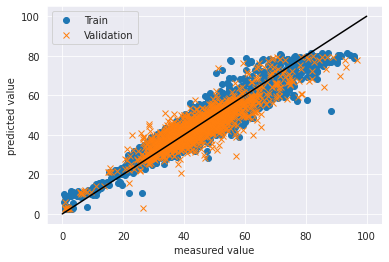

Test: s1i10-020629
Recording time: 2020-08-29 02:20:39.380407
Duriation: 0:13:55.645814
Layer Size: 64
-------------------------
Learning Rate: 0.001
Train Steps: 3000
Batch Size: 128
Dropout Ratio: 0.8
Lambda: 0.01
Beta: 0.02
Start #: 1
Iterations: 10
-------------------------
Architecture: b'| 2_layer_dnn | 3_layer_dnn | 4_layer_dnn | 5_layer_dnn | 5_layer_dnn | 5_layer_dnn | 5_layer_dnn | 6_layer_dnn | 7_layer_dnn | 8_layer_dnn |'
-------------------------
cv_r2: 0.8054564130884918
cv_mse: 26.308650970458984
cv_rmse: 5.129195938006169
-------------------------
train_r2: 0.9017010218230859
train_mse: 13.446242332458496
train_rmse: 3.666911825018226




In [ ]:
TEST_NAME = "s1i10" #@param {type:"string"}
AUTO_RUN = True #@param {type:"boolean"}

if AUTO_RUN:
  tune_list = [0.5, 0.6, 0.7, 0.8]
  for i in range(len(tune_list)):
    DROPOUT_RATIO = tune_list[i]

    start_time = datetime.now()
    test_name = TEST_NAME + '-' + start_time.strftime('%H%M%S')

    adanet_model=train_and_evaluate(test_name, dropout_ratio=DROPOUT_RATIO)
    results,train_predict,validation_predict= adanet_model.get_results()

    end_time = datetime.now()
    print("Loss:", results["average_loss"])
    # print("Accuracy:", results["accuracy"])
    print("Architecture:", ensemble_architecture(results))

    y_test_inverse, validation_predict_inverse, y_train_inverse, train_predict_inverse = inverse_transform_data(y_test, validation_predict, y_train, train_predict)

    measure_v_predict(y_train_inverse, 
                      train_predict_inverse, 
                      y_test_inverse, 
                      validation_predict_inverse, 
                      title = test_name, 
                      save_path=SAVE_DIR)
    report(y_train_inverse, 
          train_predict_inverse, 
          y_test_inverse, 
          validation_predict_inverse)

    # adanet_model.get_detail_of_iterations()

In [ ]:
# experiment
CHECKPOINT = 's5i10-181737' #@param {type:"string"}
DETAIL_EACH_ITERATION = False #@param {type:"boolean"}

# show the detail of each iteration
if DETAIL_EACH_ITERATION:
  learn_mixture_weights=LEARN_MIXTURE_WEIGHTS
  train_iteration_steps=ITERATION_TRAIN_STEPS  # or TRAIN_STEPS // ADANET_ITERATIONS
  adanet_lambda=ADANET_LAMBDA
  adanet_beta=ADANET_BETA
  model_dir = os.path.join(LOG_DIR, test_name)

  ensembler_optimizer = tf.train.AdamOptimizer(
      learning_rate=learning_rate)

  estimator = adanet.Estimator(
      # Since we are predicting housing prices, we'll use a regression
      # head that optimizes for MSE.
      head=tf.estimator.RegressionHead(),

      # Define the generator, which defines our search space of subnetworks
      # to train as candidates to add to the final AdaNet model.
      subnetwork_generator=SimpleDNNGenerator(
          optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate),
          num_of_layers = START_NUMBER,
          layer_size = LAYER_SIZE,
          learn_mixture_weights=learn_mixture_weights,
          seed=RANDOM_SEED),

      # The number of train steps per iteration.
      max_iteration_steps=train_iteration_steps,

      # The evaluator will evaluate the model on the full training set to
      # compute the overall AdaNet loss (train loss + complexity
      # regularization) to select the best candidate to include in the
      # final AdaNet model.
      evaluator=adanet.Evaluator(
          input_fn=input_fn("train", training=False, batch_size=BATCH_SIZE)),

      ensemblers=[
          adanet.ensemble.ComplexityRegularizedEnsembler(
              optimizer=ensembler_optimizer,
              mixture_weight_type='scalar',
              # Lambda is a the strength of complexity regularization. A larger
              # value will penalize more complex subnetworks.
              adanet_lambda=adanet_lambda,
              adanet_beta=adanet_beta),
      ],      
      # Configuration for Estimators.
      config=tf.estimator.RunConfig(
          model_dir=model_dir, 
          tf_random_seed=RANDOM_SEED, 
          save_summary_steps=100,
          save_checkpoints_steps=train_iteration_steps, 
          # save_checkpoints_secs=_USE_DEFAULT,
          session_config=None, 
          keep_checkpoint_max=5, 
          keep_checkpoint_every_n_hours=10000,
          log_step_count_steps=100, 
          train_distribute=None, 
          device_fn=None, 
          protocol=None,
          eval_distribute=None, 
          experimental_distribute=None,
          experimental_max_worker_delay_secs=None, 
          session_creation_timeout_secs=7200
          )
    )
  # load checkpoint recursively
  for i in range(ADANET_ITERATIONS):
    _step = (i+1) * ITERATION_TRAIN_STEPS

    t_prediction = estimator.predict(
        input_fn("train", training=False, batch_size=BATCH_SIZE),
        predict_keys=None, hooks=None, 
        checkpoint_path=model_dir+'/model.ckpt-'+str(_step),
        yield_single_examples=True)
    tr_prediction = np.array([item['predictions'][0] for item in t_prediction])
    train_prediction = target_scaler.inverse_transform(tr_prediction) *0.00689476

    v_prediction = estimator.predict(
    input_fn("test", training=False, batch_size=BATCH_SIZE),
    predict_keys=None, hooks=None, 
    checkpoint_path=model_dir+'/model.ckpt-'+str(_step),
    yield_single_examples=True)
    va_prediction = np.array([item['predictions'][0] for item in v_prediction])
    test_prediction = target_scaler.inverse_transform(va_prediction) *0.00689476


    measure_v_predict(y_train_inverse, 
                      train_prediction, 
                      y_test_inverse, 
                      test_prediction, 
                      title = test_name, 
                      save_path=SAVE_DIR,
                      save=False)
    report(y_train_inverse, 
           train_prediction, 
           y_test_inverse, 
           test_prediction, 
           save=False)


In [ ]:
if END_TRAINING:
  drive.flush_and_unmount()
  drive.mount(Mount_DIR)

Mounted at /content/gdrive
